In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from copy import deepcopy
import matplotlib.colors as mcolors

In [2]:

def plot_series(iterations_per_episode, scores_per_episode):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(iterations_per_episode)
    plt.title("Iterations per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Iterations")

    plt.subplot(1, 2, 2)
    plt.plot(scores_per_episode)
    plt.title(f"Score per {PRINT_FREQUENCY} Episodes")
    plt.xlabel(f"Episodes time {PRINT_FREQUENCY}")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


In [3]:
def plot_game_board(grid):
    # Convert the grid to numpy array for easier indexing
    grid = np.array(grid)
    # Define a colormap: list of color names
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red', 'yellow', 'blue'])  # The order has been adjusted based on the value assignments below.
    # Set the bounds for the colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    # Plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)
    # Hide the axis
    ax.axis('off')
    plt.show()

In [4]:
# Editable Globals
DEATH_PENALTY = -1
MOVEMENT_BONUS_NUMERATOR = 1  # This is divided by the distance to the apple
APPLE_BONUS = 1
WIN_BONUS = 10
STARTING_SCORE = 0

PLAYABLE_GRID_SIZE = 5 # Playable grid without walls.  Minimum value = 5
DECAY_RATE = (1 - 1e-6)
LEARNING_RATE = 1e-1
EPSILON = 9 * 1e-1
PRINT_FREQUENCY = 2**12
BUFFER_SIZE = 4096
BATCH_SIZE = 8192
GAMMA = 0.99
SYNC_FREQUENCY = 2** 6
EPISODES = 2**22
SEED = 42

# These globals are derived, don't edit unless refactoring
TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2             # Playable Area + Walls
INPUT_DIM = TOTAL_GRID_SIZE ** 2
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE ** 2 - 1
EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE - 1), repeat=2))
## initialize blank grid with empty squares (0) and walls (4)
EMPTY_STATE_NESTED_LIST = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]
for i in range(TOTAL_GRID_SIZE):
    EMPTY_STATE_NESTED_LIST[0][i] = EMPTY_STATE_NESTED_LIST[i][0] = EMPTY_STATE_NESTED_LIST[TOTAL_GRID_SIZE -1][i] = EMPTY_STATE_NESTED_LIST[i][TOTAL_GRID_SIZE - 1] = 1

In [5]:
class Direction(Enum):
    UP =    [1, 0, 0, 0]
    DOWN =  [0, 1, 0, 0]
    LEFT =  [0, 0, 1, 0]
    RIGHT = [0, 0, 0, 1]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def eat_apple(snake_queue):
    new_apple_location = random.choice(list(EMPTY_GRID_SET - set(snake_queue)))
    return new_apple_location

def initialize_game(starting_head_location, starting_apple_location):
    snake_queue = [starting_head_location]
    apple_location = starting_apple_location
    score = STARTING_SCORE
    game_over = False
    return game_over, snake_queue, apple_location, score

def update_state(snake_queue, apple_location, direction, score):
    def move_snake(snake_queue, direction):
        head_location = snake_queue[-1]
        # Update head_location based on the direction
        if direction == Direction.UP: # Up
            head_location = (head_location[0]-1, head_location[1])
        elif direction == Direction.DOWN: # Down
            head_location = (head_location[0]+1, head_location[1])
        elif direction == Direction.LEFT: # Left
            head_location = (head_location[0], head_location[1]-1)
        else: # Right
            head_location = (head_location[0], head_location[1]+1)
        return head_location

    def score_and_process_move(head_location, snake_queue, apple_location, score):
        distance_to_apple = ((head_location[0]-apple_location[0])**2 + (head_location[1]-apple_location[1])**2)**0.5
        walls = [0, TOTAL_GRID_SIZE - 1]
        if head_location == apple_location:
            score += APPLE_BONUS 
            apple_location = eat_apple(snake_queue)
            snake_queue.append(head_location)
        else:
            snake_queue.pop(0)
            if (head_location in snake_queue) or (head_location[0] in walls or head_location[1] in walls):
                score += DEATH_PENALTY
                snake_queue.append(head_location)
                return True, snake_queue, apple_location, score
            # Snake just moves
            else:
                snake_queue.append(head_location)
                score += MOVEMENT_BONUS_NUMERATOR / distance_to_apple
        if len(snake_queue) == MAX_SNAKE_LENGTH:
            score += WIN_BONUS
            return True, snake_queue, apple_location, score
        return False, snake_queue, apple_location, score

    return score_and_process_move(move_snake(snake_queue, direction), snake_queue, apple_location, score)


In [6]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *random.sample(self.buffer, batch_size))
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

In [8]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, gamma=GAMMA, learning_rate=LEARNING_RATE, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        self.dqn = DQN(input_dim, output_dim).to(device)
        self.target = DQN(input_dim, output_dim).to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval() # Set the target network to evaluation mode
        
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = EPSILON
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        state = torch.FloatTensor(state).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)
        
        # Compute Q-values
        curr_Q = self.dqn(state).gather(1, action.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target(next_state).max(1)[0]
        expected_Q = reward + (1 - done) * self.gamma * next_Q
        
        # Compute loss and update the network
        loss = self.loss_fn(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            if random.random() > self.epsilon:
                action_index = int(self.dqn(state).max(1)[1])
            else:
                action_index = random.randint(0, 3) # Number of actions - 1
        return action_index
                
    def decay_epsilon(self):
        self.epsilon *= DECAY_RATE
        self.epsilon = max(self.epsilon, 0.01)
        '''
        # Decay the learning rate
        #self.optimizer.param_groups[0]['lr'] *= DECAY_RATE
        #self.optimizer.param_groups[0]['lr'] = max(self.optimizer.param_groups[0]['lr'], 0.001)
        '''
    def get_epsilon(self):
        return self.epsilon
    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']        
    def sync_target(self):
        self.target.load_state_dict(self.dqn.state_dict())

In [9]:
def encode_state(snake_queue, apple_location, score):
    # This line imports an appropriately sized grid with walls = 1, blank = 0
    grid = [row[:] for row in EMPTY_STATE_NESTED_LIST]
    head, tail = snake_queue[-1], snake_queue[0]
    grid[tail[0]][tail[1]] = 5
    for segment in snake_queue[1:]:
        grid[segment[0]][segment[1]] = 2
    grid[apple_location[0]][apple_location[1]] = 3
    grid[head[0]][head[1]] = 4
    flat_grid = [cell for row in grid for cell in row]
    state = flat_grid
    return state

In [10]:
def my_plot_fn(moving_avg_iterations, moving_avg_scores, moving_avg_length, eps, lr, episode, state):   
    avg_iterations = sum(moving_avg_iterations) / len(moving_avg_iterations)
    avg_score = sum(moving_avg_scores) / len(moving_avg_scores)
    avg_length = sum(moving_avg_length)/len(moving_avg_length)
    print(f'''Episode: {episode} 
    Avg Iterations (last {PRINT_FREQUENCY} episodes): {avg_iterations:.2f} 
    Avg Score (last {PRINT_FREQUENCY}): {avg_score:.4f} 
    SnakeLength: {avg_length} 
    Eplsilon: {eps} 
    Learning Rate: {lr}
    ''')
    game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
    plot_game_board(game_grid)
    return avg_iterations, avg_score

In [11]:
iterations_plot_list = []
scores_plot_list = []
moving_avg_iterations = deque(maxlen=PRINT_FREQUENCY)
moving_avg_scores = deque(maxlen=PRINT_FREQUENCY)
moving_avg_length = deque(maxlen=PRINT_FREQUENCY)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Number of GPUs: {torch.cuda.device_count()}')
print(f'Device: {device}')
agent = DQNAgent(input_dim=INPUT_DIM , output_dim=4) # Fill input dimension

Number of GPUs: 0
Device: cpu


Episode: 4095 
    Avg Iterations (last 4096 episodes): 6.58 
    Avg Score (last 4096): 1.6533 
    SnakeLength: 1.180419921875 
    Eplsilon: 0.8963220339360848 
    Learning Rate: 0.1
    


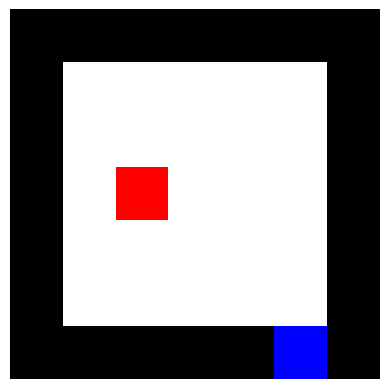

Episode: 8191 
    Avg Iterations (last 4096 episodes): 6.45 
    Avg Score (last 4096): 1.5953 
    SnakeLength: 1.1708984375 
    Eplsilon: 0.8926582056957006 
    Learning Rate: 0.1
    


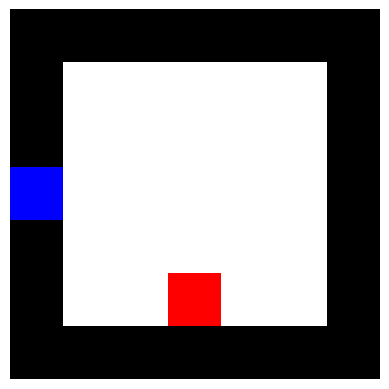

Episode: 12287 
    Avg Iterations (last 4096 episodes): 6.45 
    Avg Score (last 4096): 1.5966 
    SnakeLength: 1.182861328125 
    Eplsilon: 0.8890093538107648 
    Learning Rate: 0.1
    


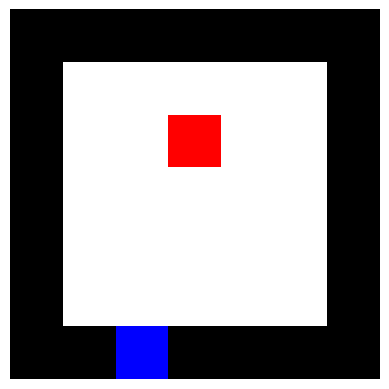

Episode: 16383 
    Avg Iterations (last 4096 episodes): 6.38 
    Avg Score (last 4096): 1.5690 
    SnakeLength: 1.17626953125 
    Eplsilon: 0.8853754170635548 
    Learning Rate: 0.1
    


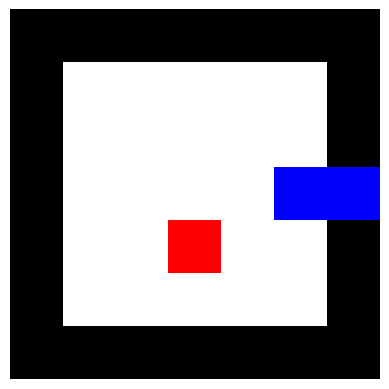

Episode: 20479 
    Avg Iterations (last 4096 episodes): 6.46 
    Avg Score (last 4096): 1.6164 
    SnakeLength: 1.1748046875 
    Eplsilon: 0.8817563344865778 
    Learning Rate: 0.1
    


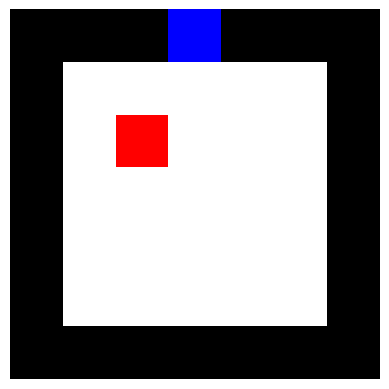

Episode: 24575 
    Avg Iterations (last 4096 episodes): 6.67 
    Avg Score (last 4096): 1.6941 
    SnakeLength: 1.17724609375 
    Eplsilon: 0.8781520453615635 
    Learning Rate: 0.1
    


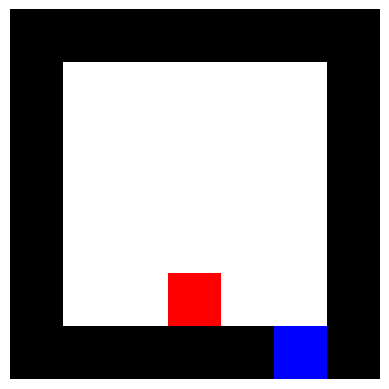

Episode: 28671 
    Avg Iterations (last 4096 episodes): 6.29 
    Avg Score (last 4096): 1.5338 
    SnakeLength: 1.177490234375 
    Eplsilon: 0.8745624892184263 
    Learning Rate: 0.1
    


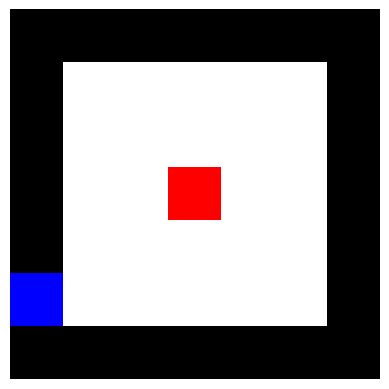

Episode: 32767 
    Avg Iterations (last 4096 episodes): 6.46 
    Avg Score (last 4096): 1.5857 
    SnakeLength: 1.172607421875 
    Eplsilon: 0.870987605834262 
    Learning Rate: 0.1
    


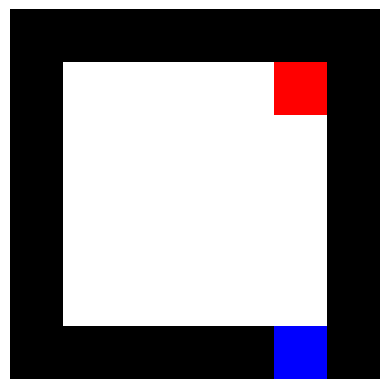

Episode: 36863 
    Avg Iterations (last 4096 episodes): 6.30 
    Avg Score (last 4096): 1.4963 
    SnakeLength: 1.166015625 
    Eplsilon: 0.8674273352323396 
    Learning Rate: 0.1
    


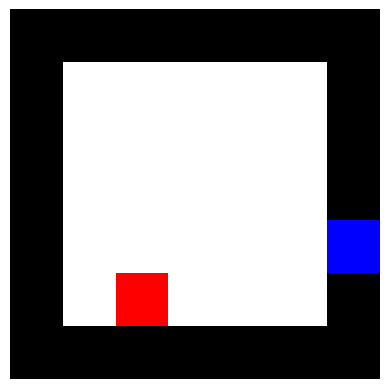

Episode: 40959 
    Avg Iterations (last 4096 episodes): 6.52 
    Avg Score (last 4096): 1.6308 
    SnakeLength: 1.177734375 
    Eplsilon: 0.8638816176810846 
    Learning Rate: 0.1
    


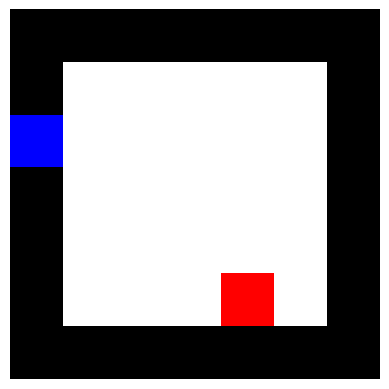

Episode: 45055 
    Avg Iterations (last 4096 episodes): 6.40 
    Avg Score (last 4096): 1.5515 
    SnakeLength: 1.168701171875 
    Eplsilon: 0.8603503936930882 
    Learning Rate: 0.1
    


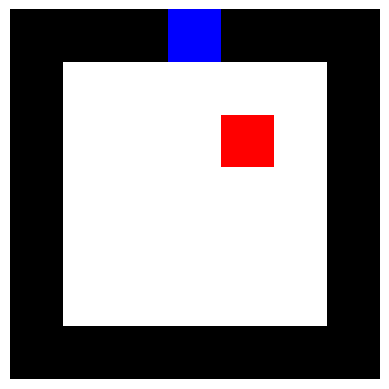

Episode: 49151 
    Avg Iterations (last 4096 episodes): 6.34 
    Avg Score (last 4096): 1.5305 
    SnakeLength: 1.1787109375 
    Eplsilon: 0.8568336040240981 
    Learning Rate: 0.1
    


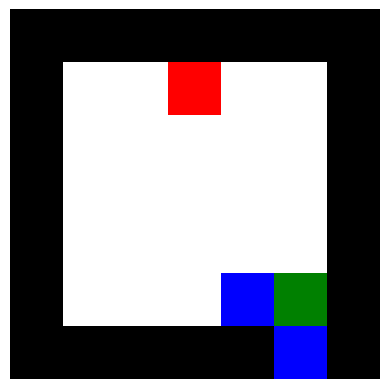

Episode: 53247 
    Avg Iterations (last 4096 episodes): 6.27 
    Avg Score (last 4096): 1.5207 
    SnakeLength: 1.173095703125 
    Eplsilon: 0.853331189672033 
    Learning Rate: 0.1
    


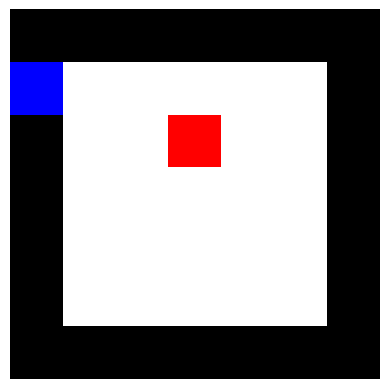

Episode: 57343 
    Avg Iterations (last 4096 episodes): 6.43 
    Avg Score (last 4096): 1.5866 
    SnakeLength: 1.174072265625 
    Eplsilon: 0.8498430918759871 
    Learning Rate: 0.1
    


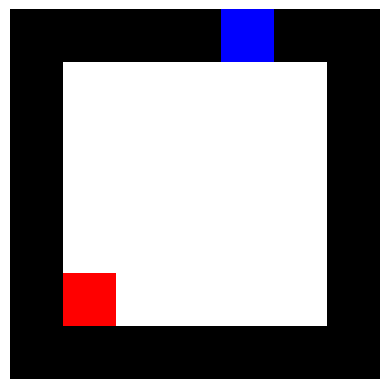

Episode: 61439 
    Avg Iterations (last 4096 episodes): 6.33 
    Avg Score (last 4096): 1.5229 
    SnakeLength: 1.16552734375 
    Eplsilon: 0.8463692521152568 
    Learning Rate: 0.1
    


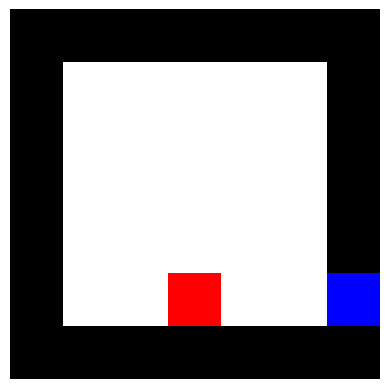

Episode: 65535 
    Avg Iterations (last 4096 episodes): 6.28 
    Avg Score (last 4096): 1.4984 
    SnakeLength: 1.1669921875 
    Eplsilon: 0.8429096121083343 
    Learning Rate: 0.1
    


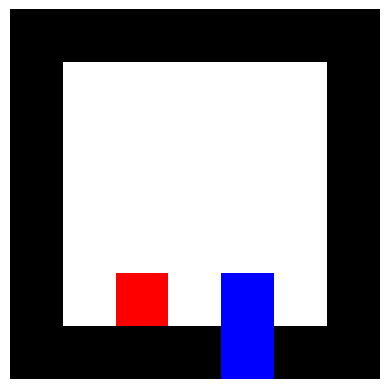

Episode: 69631 
    Avg Iterations (last 4096 episodes): 6.24 
    Avg Score (last 4096): 1.4893 
    SnakeLength: 1.156005859375 
    Eplsilon: 0.8394641138119574 
    Learning Rate: 0.1
    


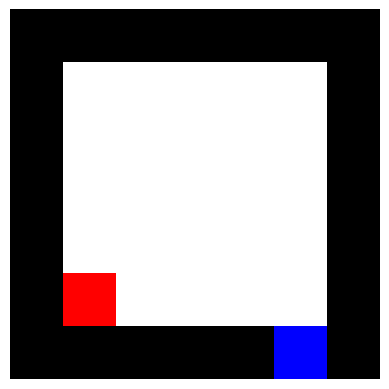

Episode: 73727 
    Avg Iterations (last 4096 episodes): 6.30 
    Avg Score (last 4096): 1.5198 
    SnakeLength: 1.1591796875 
    Eplsilon: 0.8360326994201186 
    Learning Rate: 0.1
    


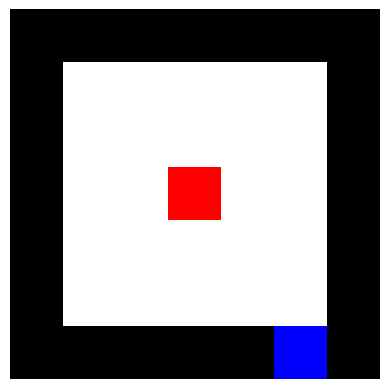

Episode: 77823 
    Avg Iterations (last 4096 episodes): 6.24 
    Avg Score (last 4096): 1.4826 
    SnakeLength: 1.170654296875 
    Eplsilon: 0.8326153113630999 
    Learning Rate: 0.1
    


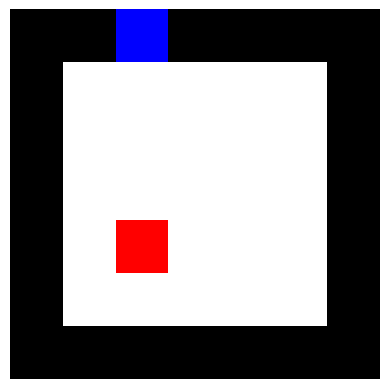

Episode: 81919 
    Avg Iterations (last 4096 episodes): 6.21 
    Avg Score (last 4096): 1.4660 
    SnakeLength: 1.166259765625 
    Eplsilon: 0.8292118923065027 
    Learning Rate: 0.1
    


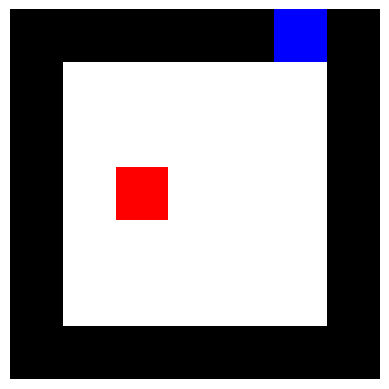

Episode: 86015 
    Avg Iterations (last 4096 episodes): 6.34 
    Avg Score (last 4096): 1.5327 
    SnakeLength: 1.172607421875 
    Eplsilon: 0.8258223851502953 
    Learning Rate: 0.1
    


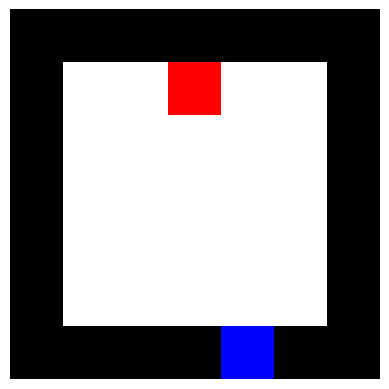

Episode: 90111 
    Avg Iterations (last 4096 episodes): 6.33 
    Avg Score (last 4096): 1.5413 
    SnakeLength: 1.1650390625 
    Eplsilon: 0.8224467330278428 
    Learning Rate: 0.1
    


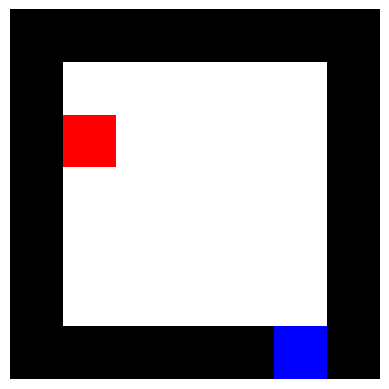

Episode: 94207 
    Avg Iterations (last 4096 episodes): 6.22 
    Avg Score (last 4096): 1.4695 
    SnakeLength: 1.16015625 
    Eplsilon: 0.8190848793049749 
    Learning Rate: 0.1
    


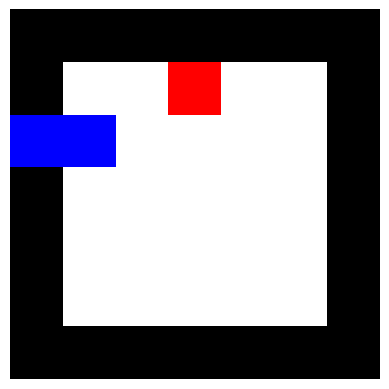

Episode: 98303 
    Avg Iterations (last 4096 episodes): 6.41 
    Avg Score (last 4096): 1.5749 
    SnakeLength: 1.1767578125 
    Eplsilon: 0.8157367675790016 
    Learning Rate: 0.1
    


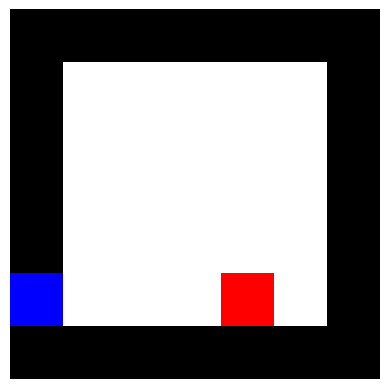

Episode: 102399 
    Avg Iterations (last 4096 episodes): 6.27 
    Avg Score (last 4096): 1.5121 
    SnakeLength: 1.171142578125 
    Eplsilon: 0.8124023416777981 
    Learning Rate: 0.1
    


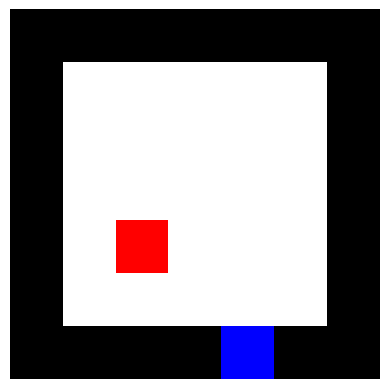

Episode: 106495 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.4204 
    SnakeLength: 1.15966796875 
    Eplsilon: 0.8090815456588489 
    Learning Rate: 0.1
    


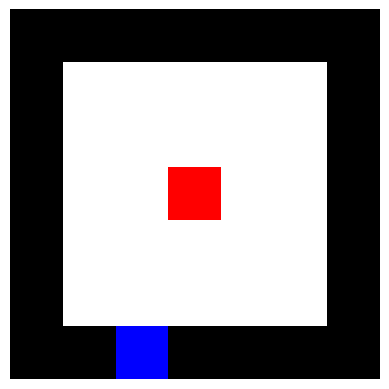

Episode: 110591 
    Avg Iterations (last 4096 episodes): 6.31 
    Avg Score (last 4096): 1.5443 
    SnakeLength: 1.173828125 
    Eplsilon: 0.8057743238083013 
    Learning Rate: 0.1
    


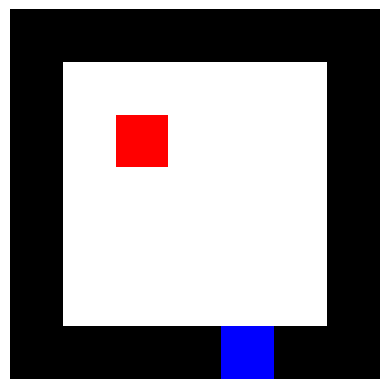

Episode: 114687 
    Avg Iterations (last 4096 episodes): 6.33 
    Avg Score (last 4096): 1.5115 
    SnakeLength: 1.1669921875 
    Eplsilon: 0.8024806206400582 
    Learning Rate: 0.1
    


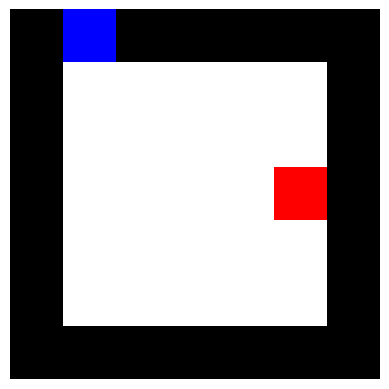

Episode: 118783 
    Avg Iterations (last 4096 episodes): 6.21 
    Avg Score (last 4096): 1.5022 
    SnakeLength: 1.177001953125 
    Eplsilon: 0.7992003808948088 
    Learning Rate: 0.1
    


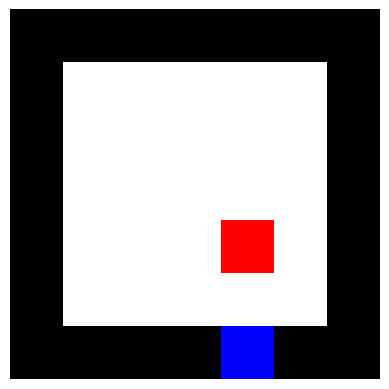

Episode: 122879 
    Avg Iterations (last 4096 episodes): 6.30 
    Avg Score (last 4096): 1.5308 
    SnakeLength: 1.17626953125 
    Eplsilon: 0.7959335495391311 
    Learning Rate: 0.1
    


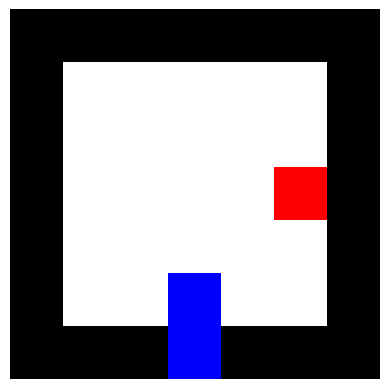

Episode: 126975 
    Avg Iterations (last 4096 episodes): 6.17 
    Avg Score (last 4096): 1.4932 
    SnakeLength: 1.171142578125 
    Eplsilon: 0.7926800717645609 
    Learning Rate: 0.1
    


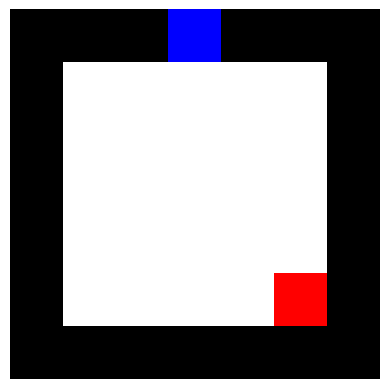

Episode: 131071 
    Avg Iterations (last 4096 episodes): 6.25 
    Avg Score (last 4096): 1.5259 
    SnakeLength: 1.181396484375 
    Eplsilon: 0.7894398929866692 
    Learning Rate: 0.1
    


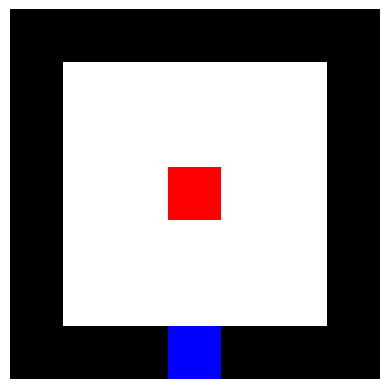

Episode: 135167 
    Avg Iterations (last 4096 episodes): 6.22 
    Avg Score (last 4096): 1.4572 
    SnakeLength: 1.1533203125 
    Eplsilon: 0.7862129588441364 
    Learning Rate: 0.1
    


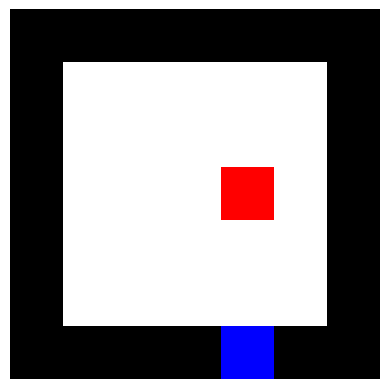

Episode: 139263 
    Avg Iterations (last 4096 episodes): 6.19 
    Avg Score (last 4096): 1.4961 
    SnakeLength: 1.173828125 
    Eplsilon: 0.7829992151978771 
    Learning Rate: 0.1
    


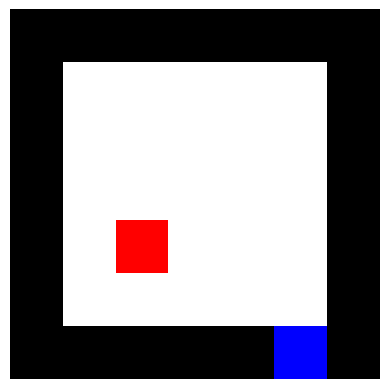

Episode: 143359 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.4494 
    SnakeLength: 1.172607421875 
    Eplsilon: 0.7797986081300781 
    Learning Rate: 0.1
    


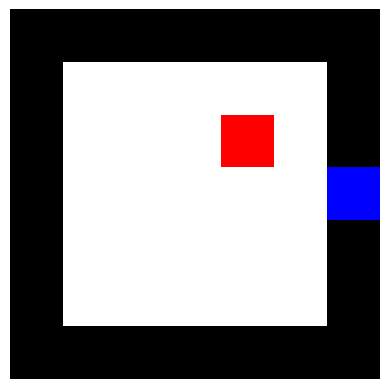

Episode: 147455 
    Avg Iterations (last 4096 episodes): 6.16 
    Avg Score (last 4096): 1.4532 
    SnakeLength: 1.161865234375 
    Eplsilon: 0.7766110839433421 
    Learning Rate: 0.1
    


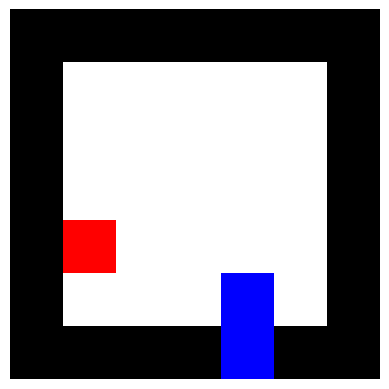

Episode: 151551 
    Avg Iterations (last 4096 episodes): 6.08 
    Avg Score (last 4096): 1.3942 
    SnakeLength: 1.16259765625 
    Eplsilon: 0.773436589159757 
    Learning Rate: 0.1
    


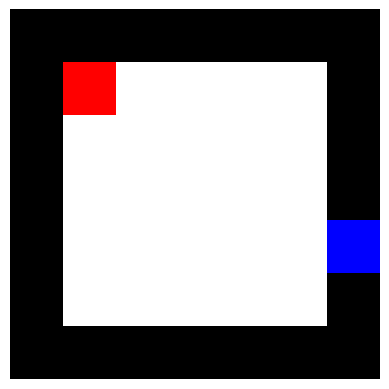

Episode: 155647 
    Avg Iterations (last 4096 episodes): 6.08 
    Avg Score (last 4096): 1.4087 
    SnakeLength: 1.158935546875 
    Eplsilon: 0.7702750705200088 
    Learning Rate: 0.1
    


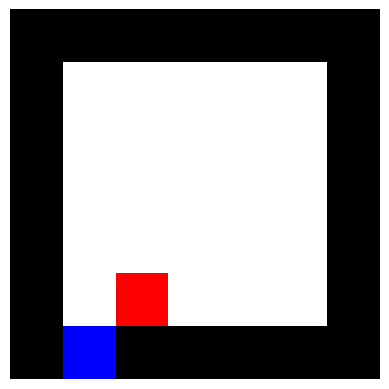

Episode: 159743 
    Avg Iterations (last 4096 episodes): 6.34 
    Avg Score (last 4096): 1.5515 
    SnakeLength: 1.169189453125 
    Eplsilon: 0.7671264749824884 
    Learning Rate: 0.1
    


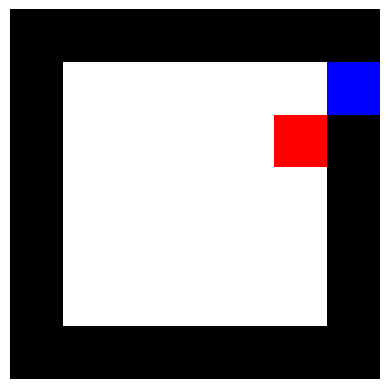

Episode: 163839 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.4135 
    SnakeLength: 1.169921875 
    Eplsilon: 0.7639907497224052 
    Learning Rate: 0.1
    


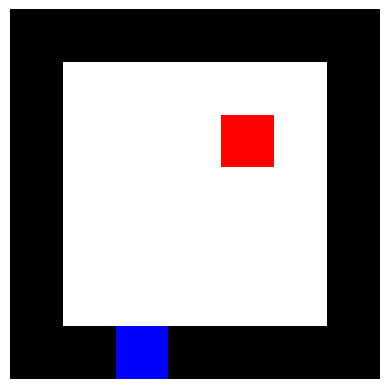

Episode: 167935 
    Avg Iterations (last 4096 episodes): 6.00 
    Avg Score (last 4096): 1.3882 
    SnakeLength: 1.1572265625 
    Eplsilon: 0.7608678421308878 
    Learning Rate: 0.1
    


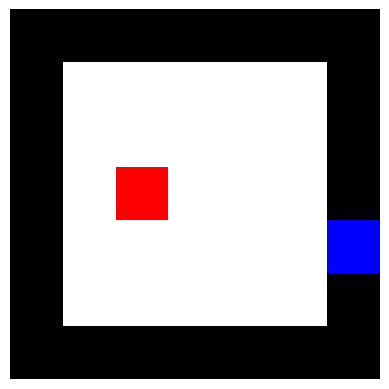

Episode: 172031 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.4225 
    SnakeLength: 1.169921875 
    Eplsilon: 0.7577576998141173 
    Learning Rate: 0.1
    


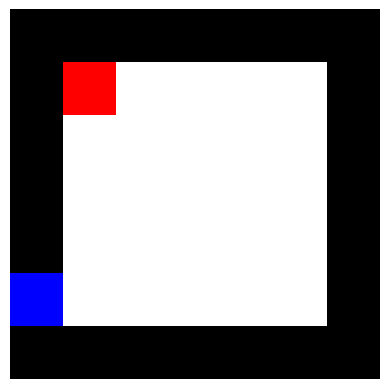

Episode: 176127 
    Avg Iterations (last 4096 episodes): 6.11 
    Avg Score (last 4096): 1.4318 
    SnakeLength: 1.167236328125 
    Eplsilon: 0.7546602705924402 
    Learning Rate: 0.1
    


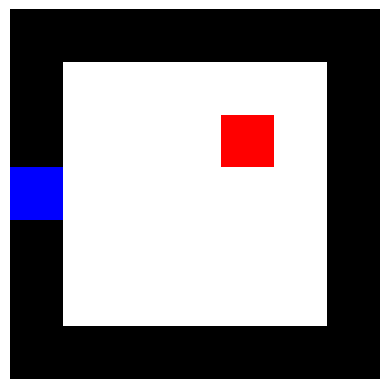

Episode: 180223 
    Avg Iterations (last 4096 episodes): 5.93 
    Avg Score (last 4096): 1.3357 
    SnakeLength: 1.15966796875 
    Eplsilon: 0.7515755024994945 
    Learning Rate: 0.1
    


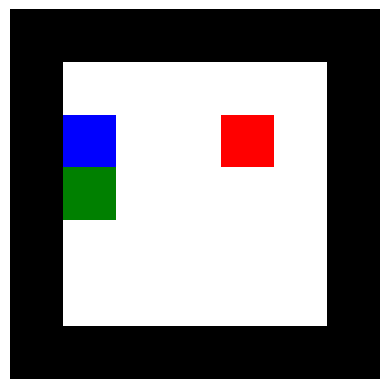

Episode: 184319 
    Avg Iterations (last 4096 episodes): 6.01 
    Avg Score (last 4096): 1.4040 
    SnakeLength: 1.180419921875 
    Eplsilon: 0.7485033437813314 
    Learning Rate: 0.1
    


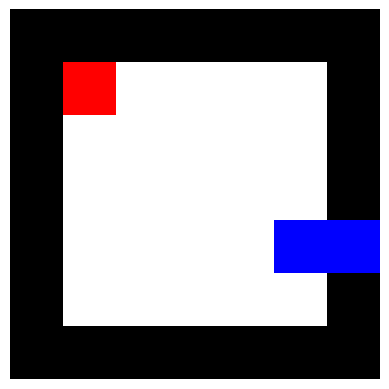

Episode: 188415 
    Avg Iterations (last 4096 episodes): 6.03 
    Avg Score (last 4096): 1.3906 
    SnakeLength: 1.164794921875 
    Eplsilon: 0.7454437428955624 
    Learning Rate: 0.1
    


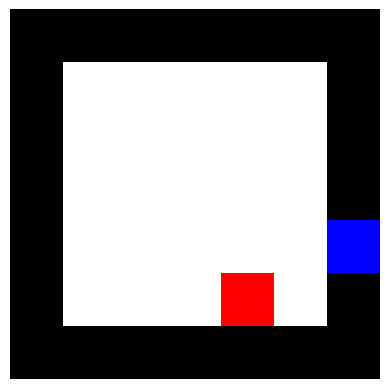

Episode: 192511 
    Avg Iterations (last 4096 episodes): 6.03 
    Avg Score (last 4096): 1.3624 
    SnakeLength: 1.165283203125 
    Eplsilon: 0.7423966485104759 
    Learning Rate: 0.1
    


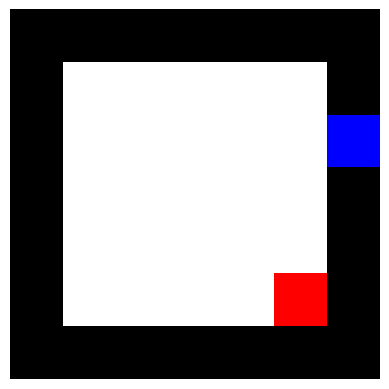

Episode: 196607 
    Avg Iterations (last 4096 episodes): 6.00 
    Avg Score (last 4096): 1.3798 
    SnakeLength: 1.15673828125 
    Eplsilon: 0.7393620095041885 
    Learning Rate: 0.1
    


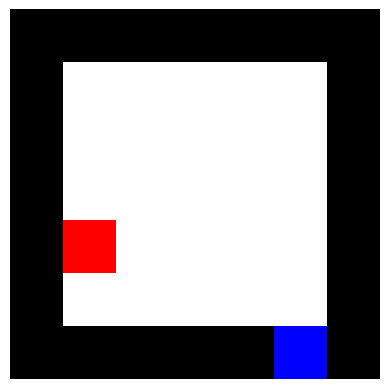

Episode: 200703 
    Avg Iterations (last 4096 episodes): 5.93 
    Avg Score (last 4096): 1.3437 
    SnakeLength: 1.162841796875 
    Eplsilon: 0.7363397749637866 
    Learning Rate: 0.1
    


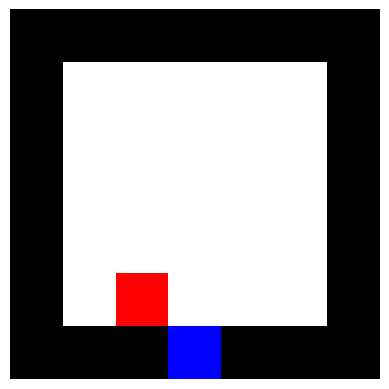

Episode: 204799 
    Avg Iterations (last 4096 episodes): 5.86 
    Avg Score (last 4096): 1.3107 
    SnakeLength: 1.16650390625 
    Eplsilon: 0.7333298941844638 
    Learning Rate: 0.1
    


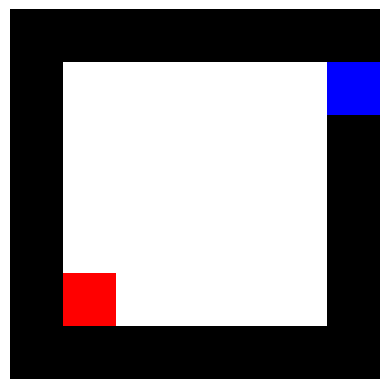

Episode: 208895 
    Avg Iterations (last 4096 episodes): 5.93 
    Avg Score (last 4096): 1.3796 
    SnakeLength: 1.17041015625 
    Eplsilon: 0.7303323166686791 
    Learning Rate: 0.1
    


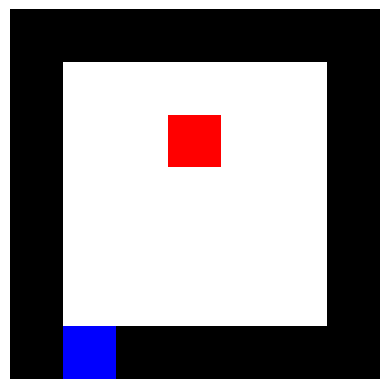

Episode: 212991 
    Avg Iterations (last 4096 episodes): 5.87 
    Avg Score (last 4096): 1.3263 
    SnakeLength: 1.159912109375 
    Eplsilon: 0.7273469921253046 
    Learning Rate: 0.1
    


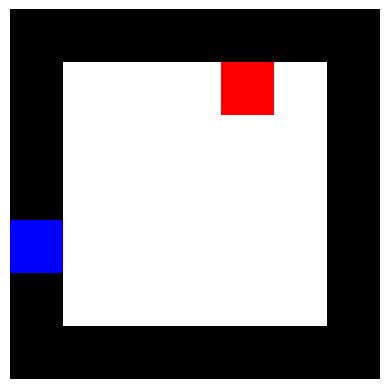

Episode: 217087 
    Avg Iterations (last 4096 episodes): 5.93 
    Avg Score (last 4096): 1.3701 
    SnakeLength: 1.1669921875 
    Eplsilon: 0.724373870468791 
    Learning Rate: 0.1
    


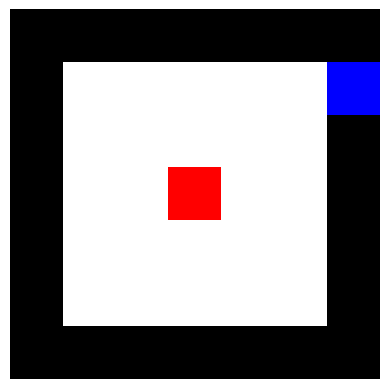

Episode: 221183 
    Avg Iterations (last 4096 episodes): 5.89 
    Avg Score (last 4096): 1.3342 
    SnakeLength: 1.153076171875 
    Eplsilon: 0.7214129018183116 
    Learning Rate: 0.1
    


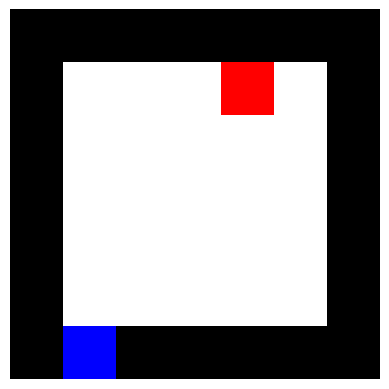

Episode: 225279 
    Avg Iterations (last 4096 episodes): 5.87 
    Avg Score (last 4096): 1.3241 
    SnakeLength: 1.15380859375 
    Eplsilon: 0.718464036496935 
    Learning Rate: 0.1
    


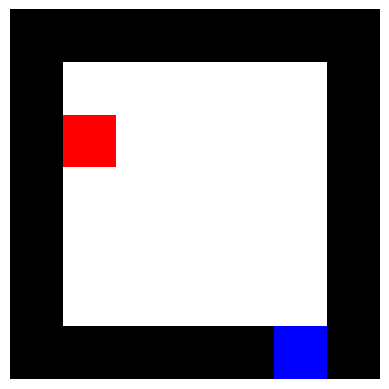

Episode: 229375 
    Avg Iterations (last 4096 episodes): 5.73 
    Avg Score (last 4096): 1.2414 
    SnakeLength: 1.15087890625 
    Eplsilon: 0.715527225030794 
    Learning Rate: 0.1
    


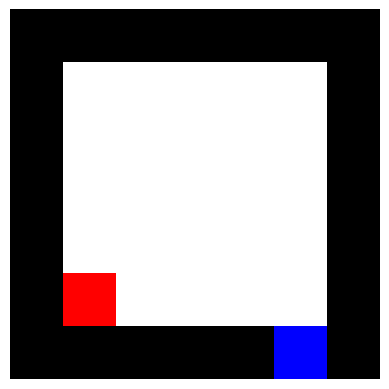

Episode: 233471 
    Avg Iterations (last 4096 episodes): 5.89 
    Avg Score (last 4096): 1.3530 
    SnakeLength: 1.159912109375 
    Eplsilon: 0.7126024181482563 
    Learning Rate: 0.1
    


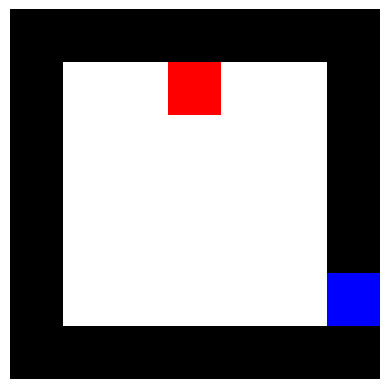

Episode: 237567 
    Avg Iterations (last 4096 episodes): 5.84 
    Avg Score (last 4096): 1.3110 
    SnakeLength: 1.170654296875 
    Eplsilon: 0.7096895667790818 
    Learning Rate: 0.1
    


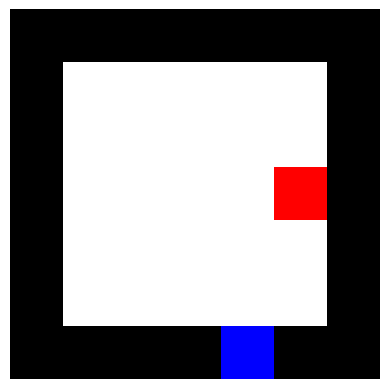

Episode: 241663 
    Avg Iterations (last 4096 episodes): 5.87 
    Avg Score (last 4096): 1.3245 
    SnakeLength: 1.16064453125 
    Eplsilon: 0.7067886220536107 
    Learning Rate: 0.1
    


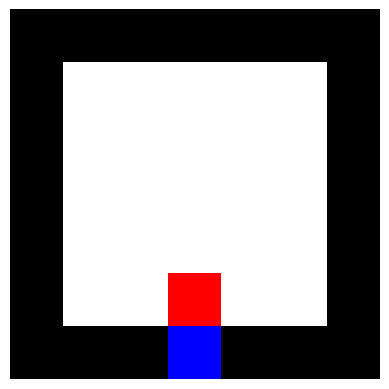

Episode: 245759 
    Avg Iterations (last 4096 episodes): 5.75 
    Avg Score (last 4096): 1.2840 
    SnakeLength: 1.16015625 
    Eplsilon: 0.7038995353019564 
    Learning Rate: 0.1
    


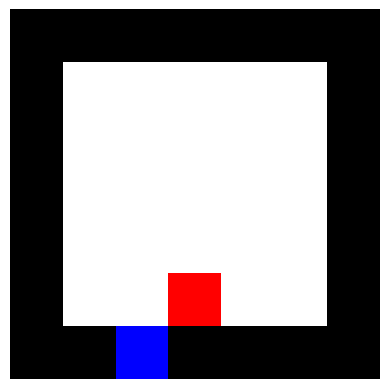

Episode: 249855 
    Avg Iterations (last 4096 episodes): 5.79 
    Avg Score (last 4096): 1.3116 
    SnakeLength: 1.1630859375 
    Eplsilon: 0.7010222580531711 
    Learning Rate: 0.1
    


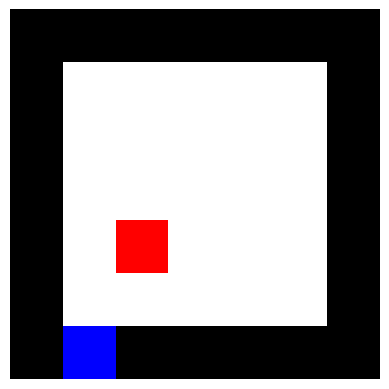

Episode: 253951 
    Avg Iterations (last 4096 episodes): 5.85 
    Avg Score (last 4096): 1.3173 
    SnakeLength: 1.16845703125 
    Eplsilon: 0.6981567420344352 
    Learning Rate: 0.1
    


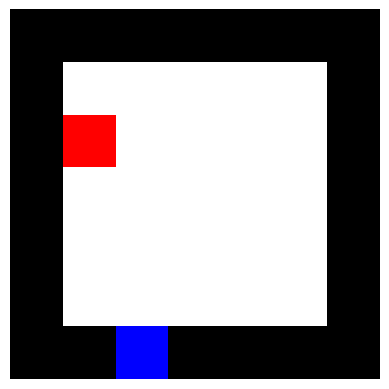

Episode: 258047 
    Avg Iterations (last 4096 episodes): 5.70 
    Avg Score (last 4096): 1.2705 
    SnakeLength: 1.175537109375 
    Eplsilon: 0.6953029391702529 
    Learning Rate: 0.1
    


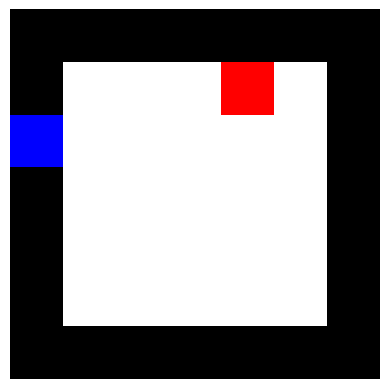

Episode: 262143 
    Avg Iterations (last 4096 episodes): 5.80 
    Avg Score (last 4096): 1.2898 
    SnakeLength: 1.15380859375 
    Eplsilon: 0.6924608015816379 
    Learning Rate: 0.1
    


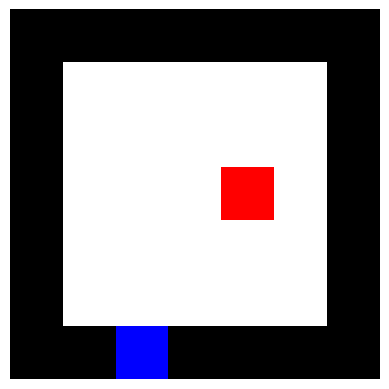

Episode: 266239 
    Avg Iterations (last 4096 episodes): 5.76 
    Avg Score (last 4096): 1.2472 
    SnakeLength: 1.155029296875 
    Eplsilon: 0.6896302815853252 
    Learning Rate: 0.1
    


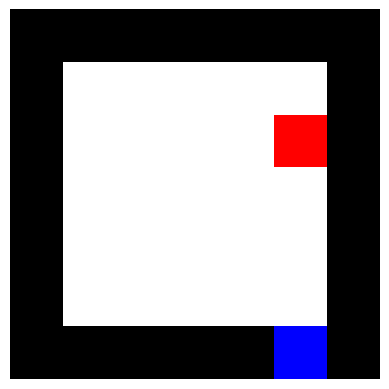

Episode: 270335 
    Avg Iterations (last 4096 episodes): 5.86 
    Avg Score (last 4096): 1.3038 
    SnakeLength: 1.1591796875 
    Eplsilon: 0.6868113316929492 
    Learning Rate: 0.1
    


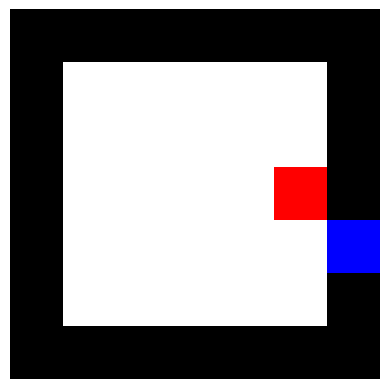

Episode: 274431 
    Avg Iterations (last 4096 episodes): 5.87 
    Avg Score (last 4096): 1.3249 
    SnakeLength: 1.16455078125 
    Eplsilon: 0.6840039046102755 
    Learning Rate: 0.1
    


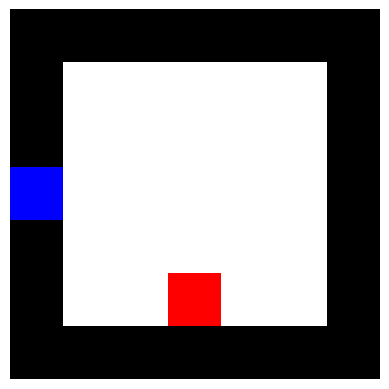

Episode: 278527 
    Avg Iterations (last 4096 episodes): 5.83 
    Avg Score (last 4096): 1.3129 
    SnakeLength: 1.159423828125 
    Eplsilon: 0.6812079532363743 
    Learning Rate: 0.1
    


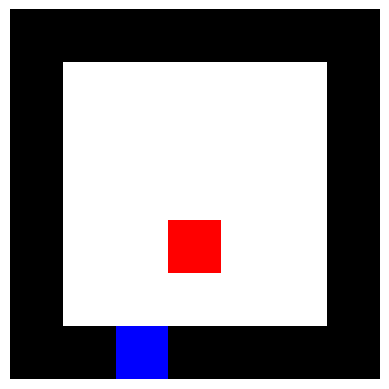

Episode: 282623 
    Avg Iterations (last 4096 episodes): 5.86 
    Avg Score (last 4096): 1.3402 
    SnakeLength: 1.166259765625 
    Eplsilon: 0.6784234306628503 
    Learning Rate: 0.1
    


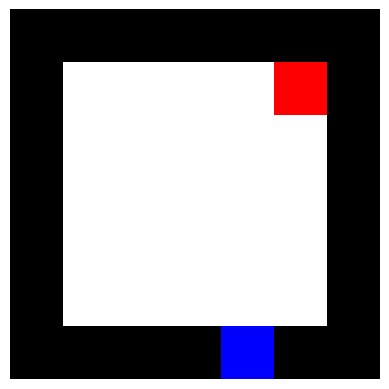

Episode: 286719 
    Avg Iterations (last 4096 episodes): 5.63 
    Avg Score (last 4096): 1.1943 
    SnakeLength: 1.151611328125 
    Eplsilon: 0.67565029017306 
    Learning Rate: 0.1
    


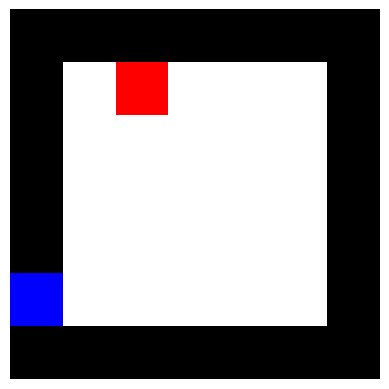

Episode: 290815 
    Avg Iterations (last 4096 episodes): 5.76 
    Avg Score (last 4096): 1.2827 
    SnakeLength: 1.144287109375 
    Eplsilon: 0.6728884852413164 
    Learning Rate: 0.1
    


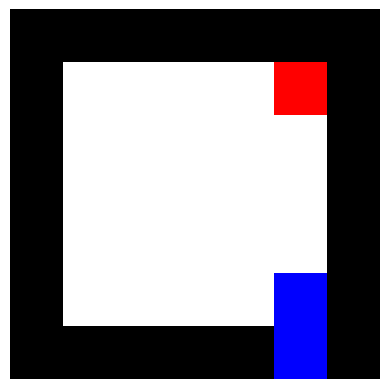

Episode: 294911 
    Avg Iterations (last 4096 episodes): 5.68 
    Avg Score (last 4096): 1.2519 
    SnakeLength: 1.1640625 
    Eplsilon: 0.6701379695321029 
    Learning Rate: 0.1
    


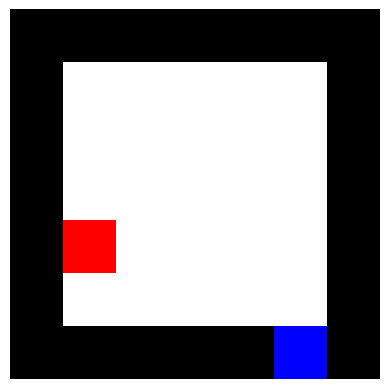

Episode: 299007 
    Avg Iterations (last 4096 episodes): 5.65 
    Avg Score (last 4096): 1.1988 
    SnakeLength: 1.153076171875 
    Eplsilon: 0.6673986968993164 
    Learning Rate: 0.1
    


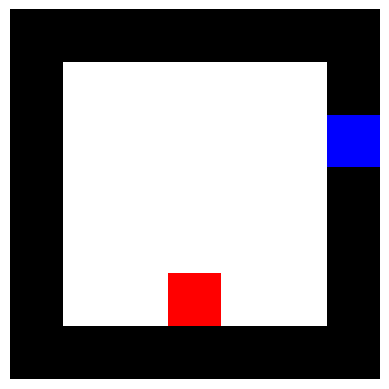

Episode: 303103 
    Avg Iterations (last 4096 episodes): 5.68 
    Avg Score (last 4096): 1.2282 
    SnakeLength: 1.154541015625 
    Eplsilon: 0.6646706213854805 
    Learning Rate: 0.1
    


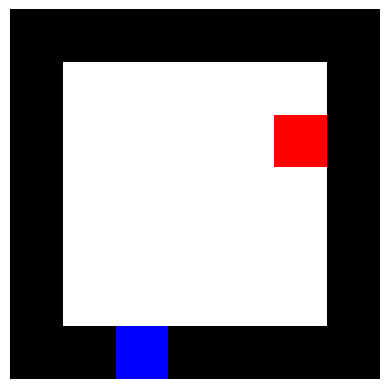

Episode: 307199 
    Avg Iterations (last 4096 episodes): 5.67 
    Avg Score (last 4096): 1.2262 
    SnakeLength: 1.166748046875 
    Eplsilon: 0.6619536972209698 
    Learning Rate: 0.1
    


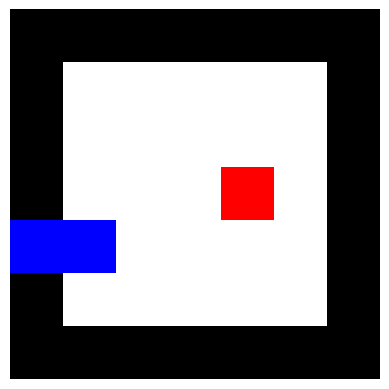

Episode: 311295 
    Avg Iterations (last 4096 episodes): 5.73 
    Avg Score (last 4096): 1.2742 
    SnakeLength: 1.159423828125 
    Eplsilon: 0.6592478788232522 
    Learning Rate: 0.1
    


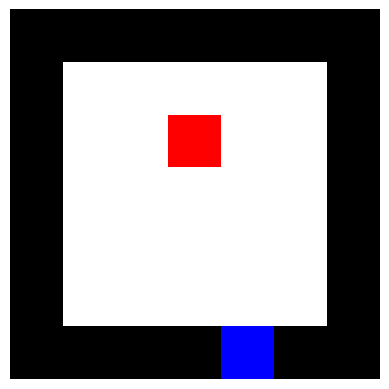

Episode: 315391 
    Avg Iterations (last 4096 episodes): 5.49 
    Avg Score (last 4096): 1.1261 
    SnakeLength: 1.150146484375 
    Eplsilon: 0.6565531207961259 
    Learning Rate: 0.1
    


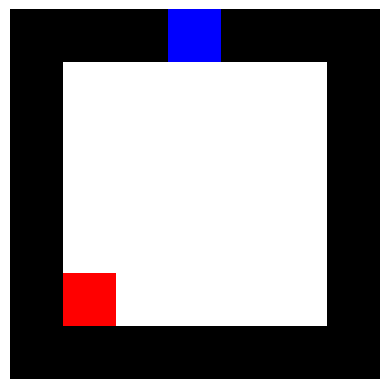

Episode: 319487 
    Avg Iterations (last 4096 episodes): 5.62 
    Avg Score (last 4096): 1.2163 
    SnakeLength: 1.1572265625 
    Eplsilon: 0.6538693779289342 
    Learning Rate: 0.1
    


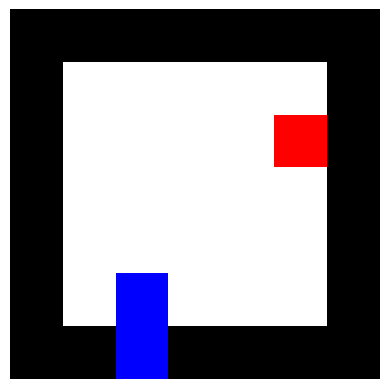

Episode: 323583 
    Avg Iterations (last 4096 episodes): 5.65 
    Avg Score (last 4096): 1.2263 
    SnakeLength: 1.1494140625 
    Eplsilon: 0.6511966051958387 
    Learning Rate: 0.1
    


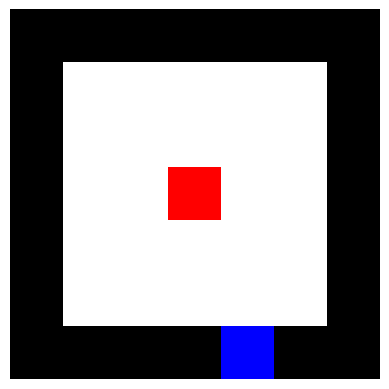

Episode: 327679 
    Avg Iterations (last 4096 episodes): 5.69 
    Avg Score (last 4096): 1.2536 
    SnakeLength: 1.15283203125 
    Eplsilon: 0.64853475775505 
    Learning Rate: 0.1
    


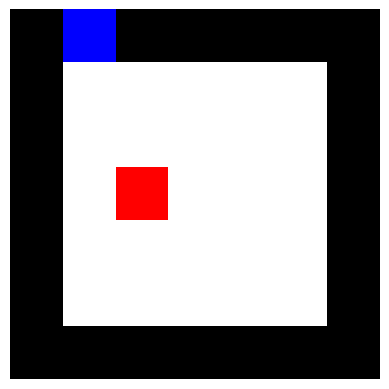

Episode: 331775 
    Avg Iterations (last 4096 episodes): 5.63 
    Avg Score (last 4096): 1.2037 
    SnakeLength: 1.156005859375 
    Eplsilon: 0.6458837909480681 
    Learning Rate: 0.1
    


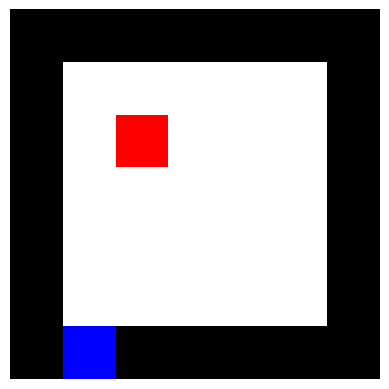

Episode: 335871 
    Avg Iterations (last 4096 episodes): 5.57 
    Avg Score (last 4096): 1.1986 
    SnakeLength: 1.15234375 
    Eplsilon: 0.6432436602989469 
    Learning Rate: 0.1
    


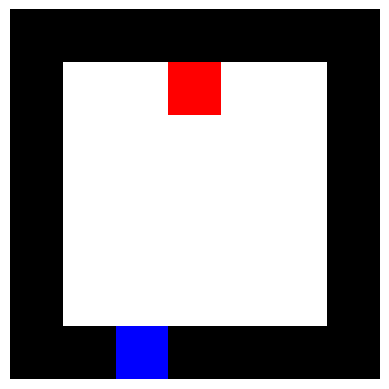

Episode: 339967 
    Avg Iterations (last 4096 episodes): 5.66 
    Avg Score (last 4096): 1.2091 
    SnakeLength: 1.15576171875 
    Eplsilon: 0.6406143215135308 
    Learning Rate: 0.1
    


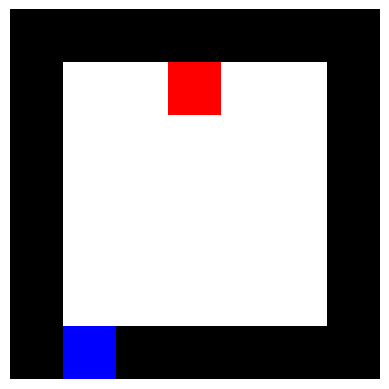

Episode: 344063 
    Avg Iterations (last 4096 episodes): 5.53 
    Avg Score (last 4096): 1.1615 
    SnakeLength: 1.156494140625 
    Eplsilon: 0.6379957304787354 
    Learning Rate: 0.1
    


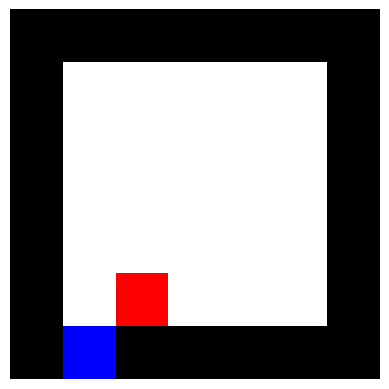

Episode: 348159 
    Avg Iterations (last 4096 episodes): 5.52 
    Avg Score (last 4096): 1.1491 
    SnakeLength: 1.150146484375 
    Eplsilon: 0.6353878432617869 
    Learning Rate: 0.1
    


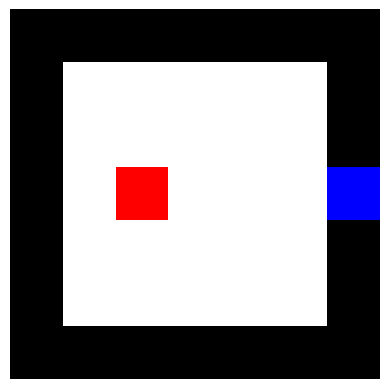

Episode: 352255 
    Avg Iterations (last 4096 episodes): 5.52 
    Avg Score (last 4096): 1.1461 
    SnakeLength: 1.154052734375 
    Eplsilon: 0.6327906161094933 
    Learning Rate: 0.1
    


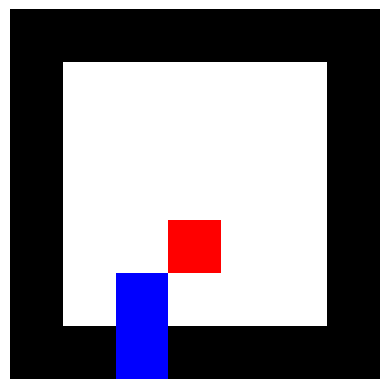

Episode: 356351 
    Avg Iterations (last 4096 episodes): 5.62 
    Avg Score (last 4096): 1.1970 
    SnakeLength: 1.1552734375 
    Eplsilon: 0.630204005447508 
    Learning Rate: 0.1
    


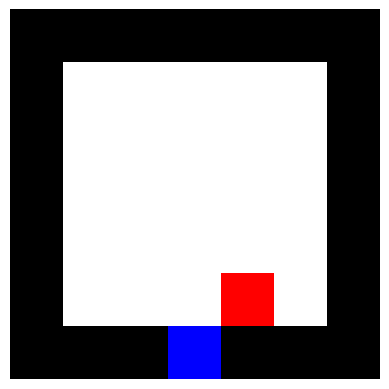

Episode: 360447 
    Avg Iterations (last 4096 episodes): 5.60 
    Avg Score (last 4096): 1.1995 
    SnakeLength: 1.146728515625 
    Eplsilon: 0.6276279678796024 
    Learning Rate: 0.1
    


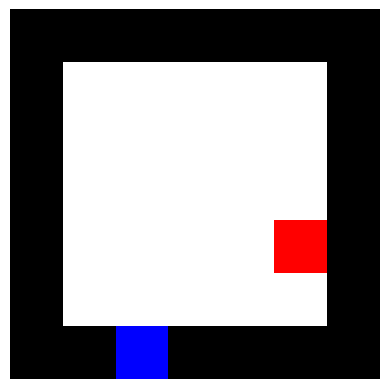

Episode: 364543 
    Avg Iterations (last 4096 episodes): 5.46 
    Avg Score (last 4096): 1.1513 
    SnakeLength: 1.15283203125 
    Eplsilon: 0.6250624601869377 
    Learning Rate: 0.1
    


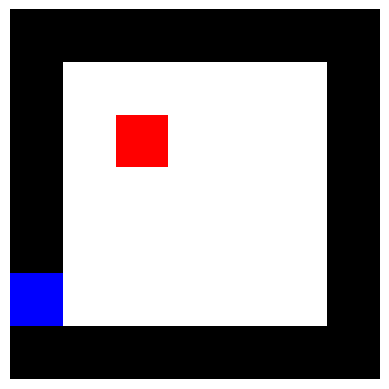

Episode: 368639 
    Avg Iterations (last 4096 episodes): 5.47 
    Avg Score (last 4096): 1.1411 
    SnakeLength: 1.15576171875 
    Eplsilon: 0.6225074393273283 
    Learning Rate: 0.1
    


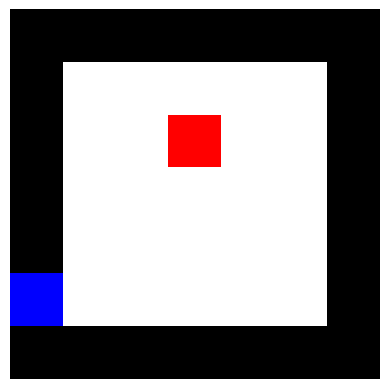

Episode: 372735 
    Avg Iterations (last 4096 episodes): 5.47 
    Avg Score (last 4096): 1.1430 
    SnakeLength: 1.146728515625 
    Eplsilon: 0.6199628624345376 
    Learning Rate: 0.1
    


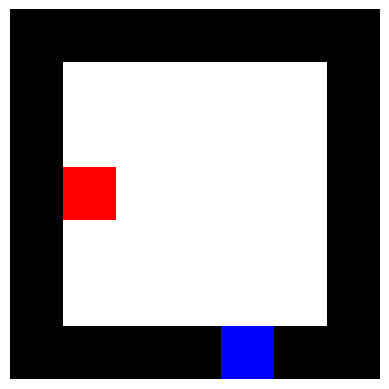

Episode: 376831 
    Avg Iterations (last 4096 episodes): 5.44 
    Avg Score (last 4096): 1.1192 
    SnakeLength: 1.15625 
    Eplsilon: 0.6174286868175423 
    Learning Rate: 0.1
    


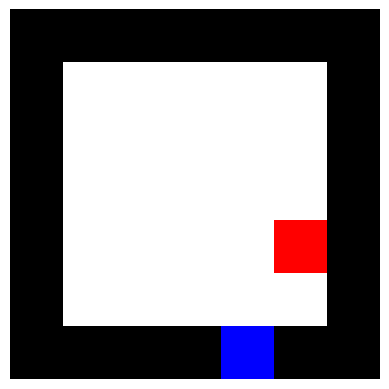

Episode: 380927 
    Avg Iterations (last 4096 episodes): 5.54 
    Avg Score (last 4096): 1.1708 
    SnakeLength: 1.157958984375 
    Eplsilon: 0.6149048699598295 
    Learning Rate: 0.1
    


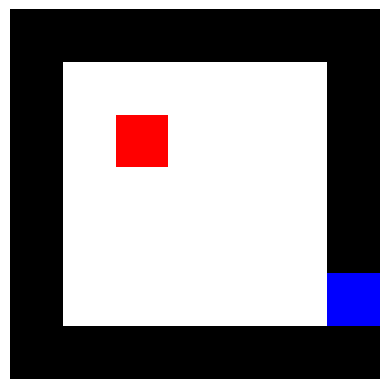

Episode: 385023 
    Avg Iterations (last 4096 episodes): 5.43 
    Avg Score (last 4096): 1.0879 
    SnakeLength: 1.1435546875 
    Eplsilon: 0.6123913695186846 
    Learning Rate: 0.1
    


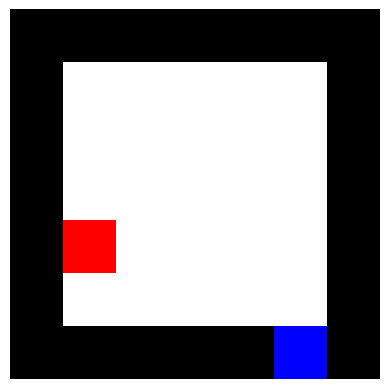

Episode: 389119 
    Avg Iterations (last 4096 episodes): 5.44 
    Avg Score (last 4096): 1.1064 
    SnakeLength: 1.14111328125 
    Eplsilon: 0.6098881433244652 
    Learning Rate: 0.1
    


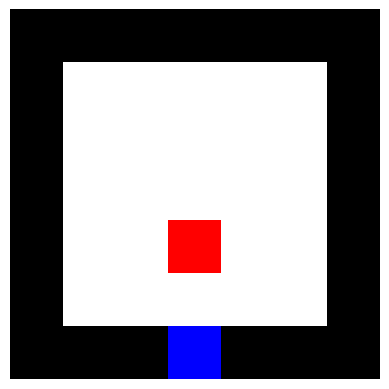

Episode: 393215 
    Avg Iterations (last 4096 episodes): 5.34 
    Avg Score (last 4096): 1.0635 
    SnakeLength: 1.144287109375 
    Eplsilon: 0.6073951493798952 
    Learning Rate: 0.1
    


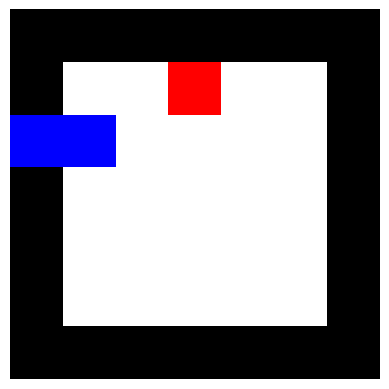

Episode: 397311 
    Avg Iterations (last 4096 episodes): 5.42 
    Avg Score (last 4096): 1.1281 
    SnakeLength: 1.1474609375 
    Eplsilon: 0.6049123458593831 
    Learning Rate: 0.1
    


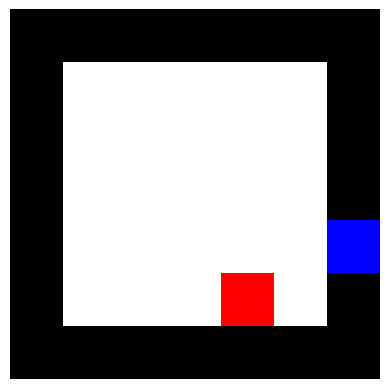

Episode: 401407 
    Avg Iterations (last 4096 episodes): 5.35 
    Avg Score (last 4096): 1.0649 
    SnakeLength: 1.14599609375 
    Eplsilon: 0.6024396911082966 
    Learning Rate: 0.1
    


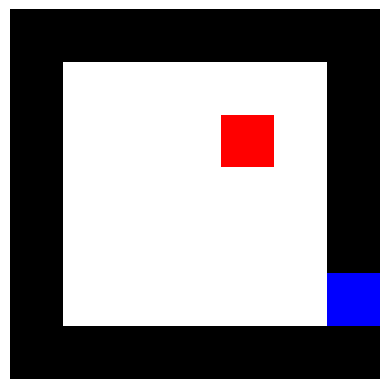

Episode: 405503 
    Avg Iterations (last 4096 episodes): 5.39 
    Avg Score (last 4096): 1.1079 
    SnakeLength: 1.1494140625 
    Eplsilon: 0.599977143642274 
    Learning Rate: 0.1
    


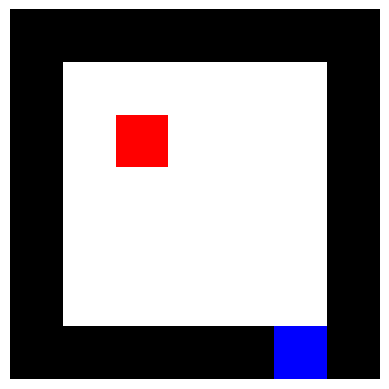

Episode: 409599 
    Avg Iterations (last 4096 episodes): 5.47 
    Avg Score (last 4096): 1.1482 
    SnakeLength: 1.152587890625 
    Eplsilon: 0.5975246621465237 
    Learning Rate: 0.1
    


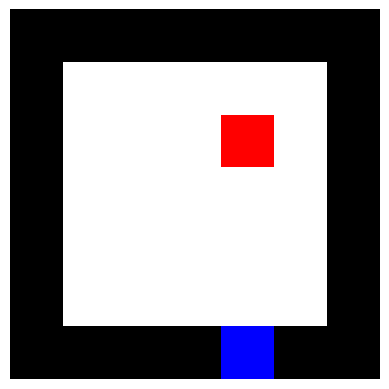

Episode: 413695 
    Avg Iterations (last 4096 episodes): 5.54 
    Avg Score (last 4096): 1.1931 
    SnakeLength: 1.16357421875 
    Eplsilon: 0.5950822054751386 
    Learning Rate: 0.1
    


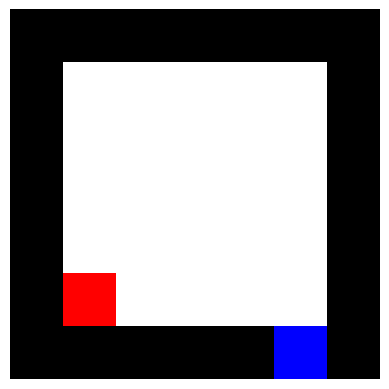

Episode: 417791 
    Avg Iterations (last 4096 episodes): 5.40 
    Avg Score (last 4096): 1.0773 
    SnakeLength: 1.139404296875 
    Eplsilon: 0.5926497326503937 
    Learning Rate: 0.1
    


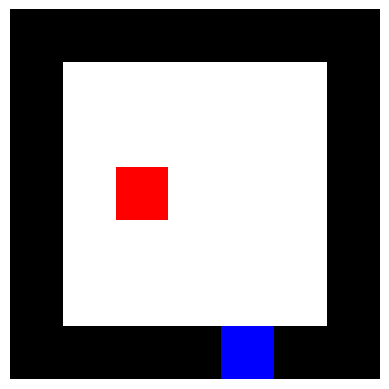

Episode: 421887 
    Avg Iterations (last 4096 episodes): 5.48 
    Avg Score (last 4096): 1.1411 
    SnakeLength: 1.15087890625 
    Eplsilon: 0.59022720286207 
    Learning Rate: 0.1
    


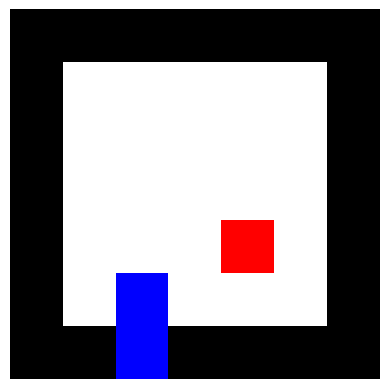

Episode: 425983 
    Avg Iterations (last 4096 episodes): 5.43 
    Avg Score (last 4096): 1.1330 
    SnakeLength: 1.156494140625 
    Eplsilon: 0.587814575466765 
    Learning Rate: 0.1
    


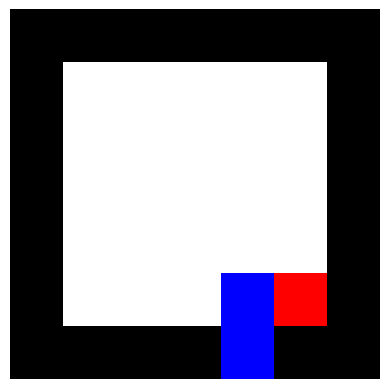

Episode: 430079 
    Avg Iterations (last 4096 episodes): 5.46 
    Avg Score (last 4096): 1.1615 
    SnakeLength: 1.153564453125 
    Eplsilon: 0.5854118099872124 
    Learning Rate: 0.1
    


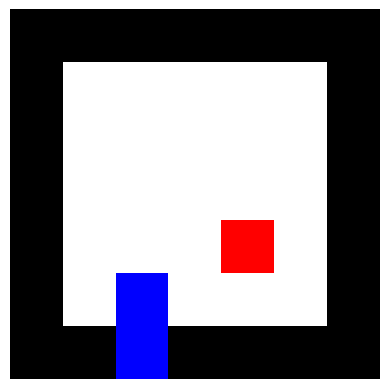

Episode: 434175 
    Avg Iterations (last 4096 episodes): 5.43 
    Avg Score (last 4096): 1.1253 
    SnakeLength: 1.14990234375 
    Eplsilon: 0.583018866111598 
    Learning Rate: 0.1
    


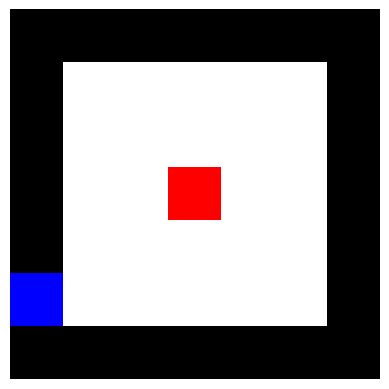

Episode: 438271 
    Avg Iterations (last 4096 episodes): 5.33 
    Avg Score (last 4096): 1.1038 
    SnakeLength: 1.15771484375 
    Eplsilon: 0.5806357036928936 
    Learning Rate: 0.1
    


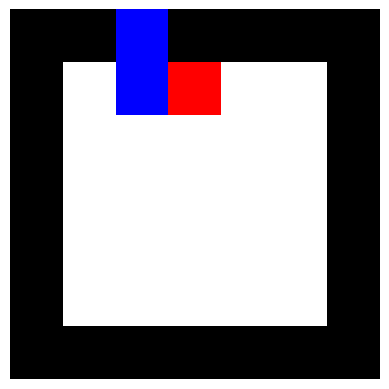

Episode: 442367 
    Avg Iterations (last 4096 episodes): 5.43 
    Avg Score (last 4096): 1.1191 
    SnakeLength: 1.146240234375 
    Eplsilon: 0.5782622827481658 
    Learning Rate: 0.1
    


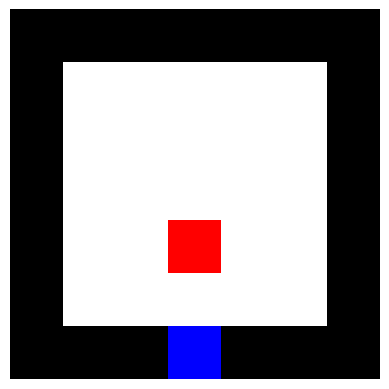

Episode: 446463 
    Avg Iterations (last 4096 episodes): 5.31 
    Avg Score (last 4096): 1.0379 
    SnakeLength: 1.147216796875 
    Eplsilon: 0.5758985634579276 
    Learning Rate: 0.1
    


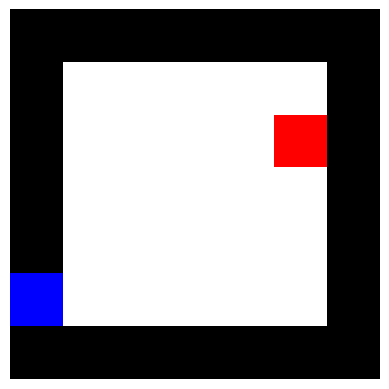

Episode: 450559 
    Avg Iterations (last 4096 episodes): 5.23 
    Avg Score (last 4096): 1.0186 
    SnakeLength: 1.15234375 
    Eplsilon: 0.5735445061654522 
    Learning Rate: 0.1
    


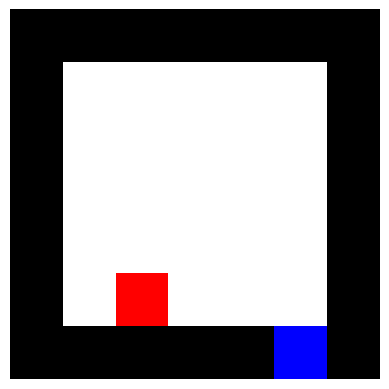

Episode: 454655 
    Avg Iterations (last 4096 episodes): 5.40 
    Avg Score (last 4096): 1.0913 
    SnakeLength: 1.147705078125 
    Eplsilon: 0.5712000713761197 
    Learning Rate: 0.1
    


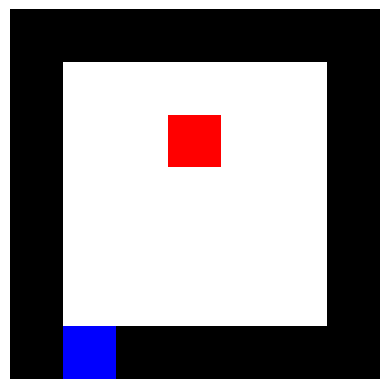

Episode: 458751 
    Avg Iterations (last 4096 episodes): 5.35 
    Avg Score (last 4096): 1.0601 
    SnakeLength: 1.143310546875 
    Eplsilon: 0.568865219756749 
    Learning Rate: 0.1
    


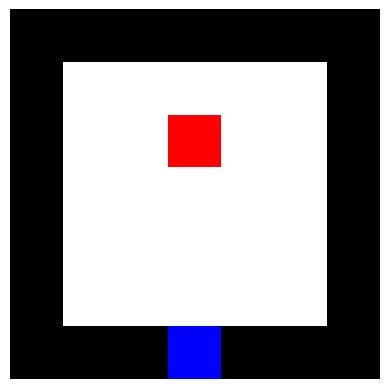

Episode: 462847 
    Avg Iterations (last 4096 episodes): 5.25 
    Avg Score (last 4096): 1.0322 
    SnakeLength: 1.14990234375 
    Eplsilon: 0.5665399121349304 
    Learning Rate: 0.1
    


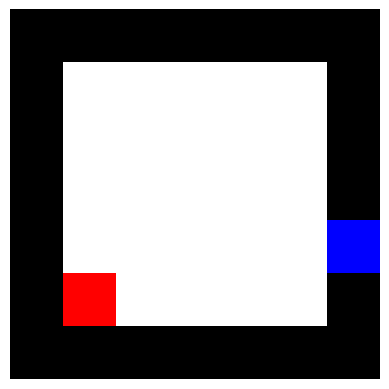

Episode: 466943 
    Avg Iterations (last 4096 episodes): 5.21 
    Avg Score (last 4096): 1.0203 
    SnakeLength: 1.153076171875 
    Eplsilon: 0.5642241094983831 
    Learning Rate: 0.1
    


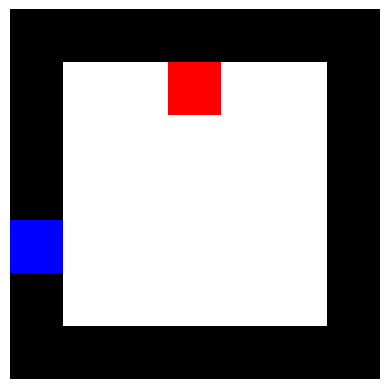

Episode: 471039 
    Avg Iterations (last 4096 episodes): 5.25 
    Avg Score (last 4096): 1.0322 
    SnakeLength: 1.145263671875 
    Eplsilon: 0.5619177729942937 
    Learning Rate: 0.1
    


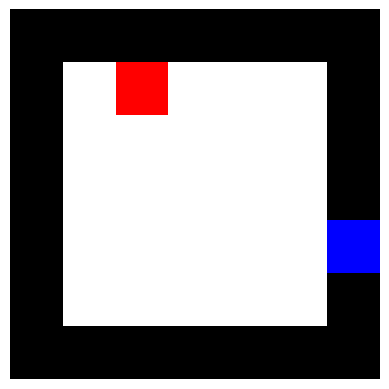

Episode: 475135 
    Avg Iterations (last 4096 episodes): 5.29 
    Avg Score (last 4096): 1.0487 
    SnakeLength: 1.14697265625 
    Eplsilon: 0.5596208639286676 
    Learning Rate: 0.1
    


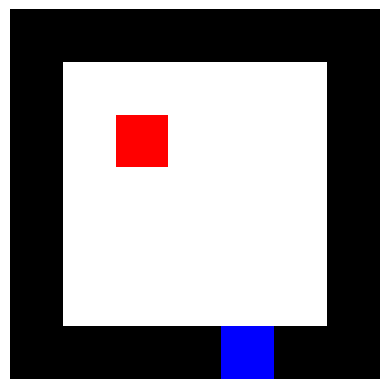

Episode: 479231 
    Avg Iterations (last 4096 episodes): 5.30 
    Avg Score (last 4096): 1.0641 
    SnakeLength: 1.15478515625 
    Eplsilon: 0.5573333437656677 
    Learning Rate: 0.1
    


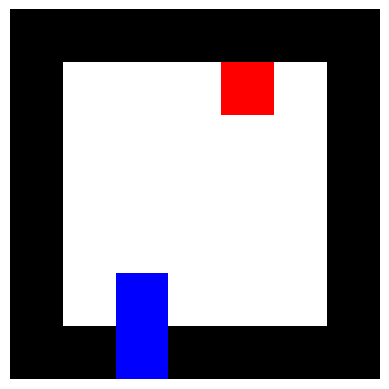

Episode: 483327 
    Avg Iterations (last 4096 episodes): 5.22 
    Avg Score (last 4096): 1.0387 
    SnakeLength: 1.144287109375 
    Eplsilon: 0.5550551741269873 
    Learning Rate: 0.1
    


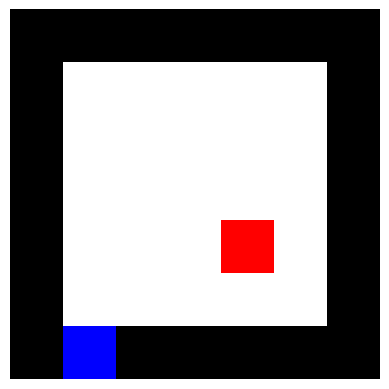

Episode: 487423 
    Avg Iterations (last 4096 episodes): 5.23 
    Avg Score (last 4096): 1.0198 
    SnakeLength: 1.144775390625 
    Eplsilon: 0.5527863167911848 
    Learning Rate: 0.1
    


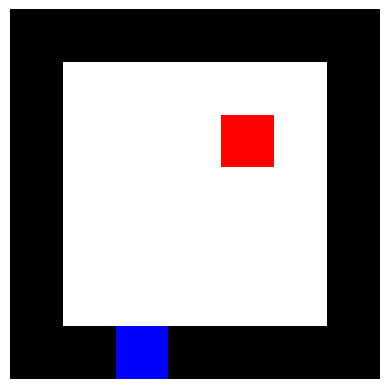

Episode: 491519 
    Avg Iterations (last 4096 episodes): 5.17 
    Avg Score (last 4096): 0.9874 
    SnakeLength: 1.1435546875 
    Eplsilon: 0.5505267336930659 
    Learning Rate: 0.1
    


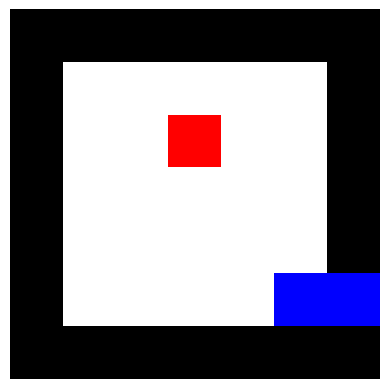

Episode: 495615 
    Avg Iterations (last 4096 episodes): 5.19 
    Avg Score (last 4096): 1.0112 
    SnakeLength: 1.137939453125 
    Eplsilon: 0.5482763869230205 
    Learning Rate: 0.1
    


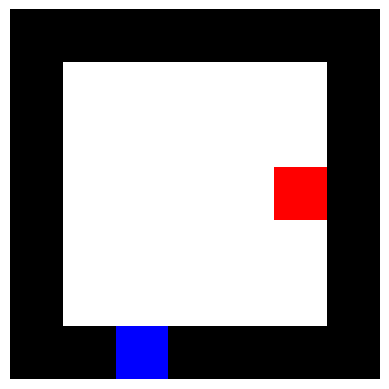

Episode: 499711 
    Avg Iterations (last 4096 episodes): 5.22 
    Avg Score (last 4096): 1.0345 
    SnakeLength: 1.15283203125 
    Eplsilon: 0.5460352387264034 
    Learning Rate: 0.1
    


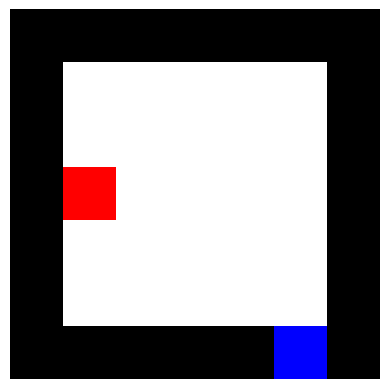

Episode: 503807 
    Avg Iterations (last 4096 episodes): 5.28 
    Avg Score (last 4096): 1.0409 
    SnakeLength: 1.146240234375 
    Eplsilon: 0.5438032515029013 
    Learning Rate: 0.1
    


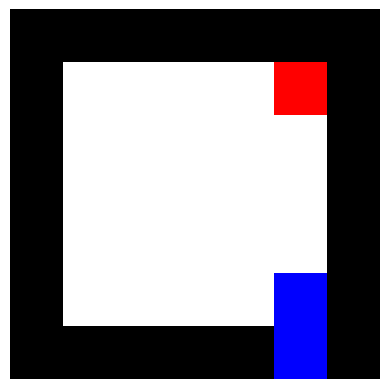

Episode: 507903 
    Avg Iterations (last 4096 episodes): 5.32 
    Avg Score (last 4096): 1.0523 
    SnakeLength: 1.148193359375 
    Eplsilon: 0.5415803878058923 
    Learning Rate: 0.1
    


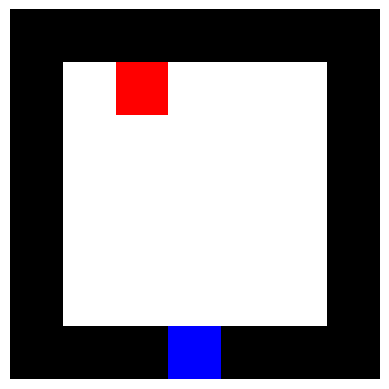

Episode: 511999 
    Avg Iterations (last 4096 episodes): 5.12 
    Avg Score (last 4096): 0.9560 
    SnakeLength: 1.142333984375 
    Eplsilon: 0.5393666103418187 
    Learning Rate: 0.1
    


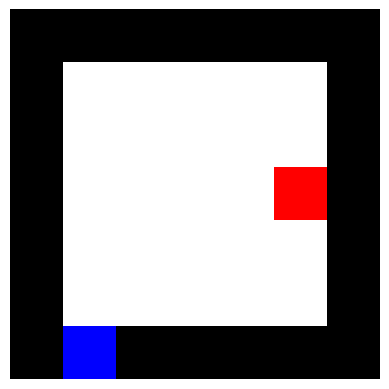

Episode: 516095 
    Avg Iterations (last 4096 episodes): 5.04 
    Avg Score (last 4096): 0.9556 
    SnakeLength: 1.140869140625 
    Eplsilon: 0.5371618819695743 
    Learning Rate: 0.1
    


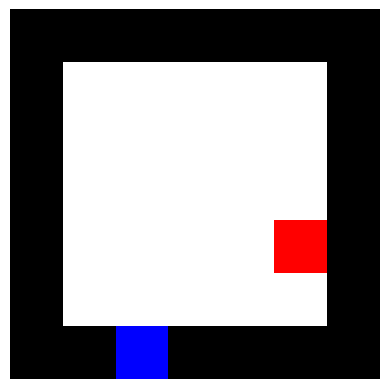

Episode: 520191 
    Avg Iterations (last 4096 episodes): 5.22 
    Avg Score (last 4096): 1.0465 
    SnakeLength: 1.14599609375 
    Eplsilon: 0.5349661656998655 
    Learning Rate: 0.1
    


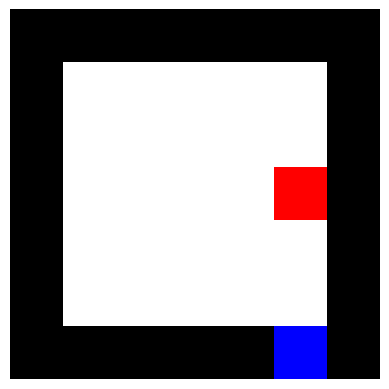

Episode: 524287 
    Avg Iterations (last 4096 episodes): 5.17 
    Avg Score (last 4096): 1.0063 
    SnakeLength: 1.1474609375 
    Eplsilon: 0.5327794246945887 
    Learning Rate: 0.1
    


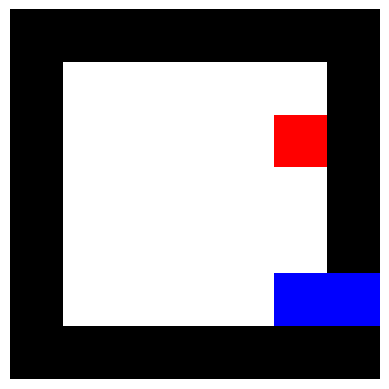

Episode: 528383 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 0.9660 
    SnakeLength: 1.139404296875 
    Eplsilon: 0.530601622266237 
    Learning Rate: 0.1
    


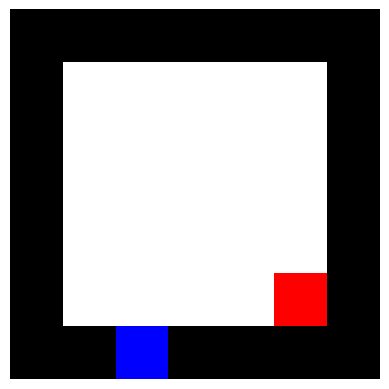

Episode: 532479 
    Avg Iterations (last 4096 episodes): 4.99 
    Avg Score (last 4096): 0.8855 
    SnakeLength: 1.136962890625 
    Eplsilon: 0.5284327218772613 
    Learning Rate: 0.1
    


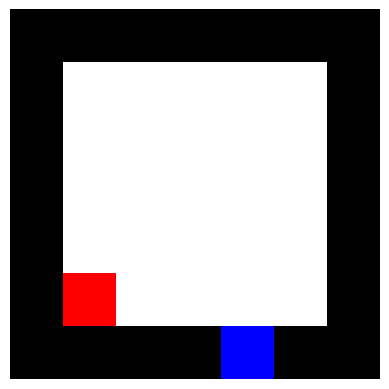

Episode: 536575 
    Avg Iterations (last 4096 episodes): 5.08 
    Avg Score (last 4096): 0.9731 
    SnakeLength: 1.145751953125 
    Eplsilon: 0.5262726871394657 
    Learning Rate: 0.1
    


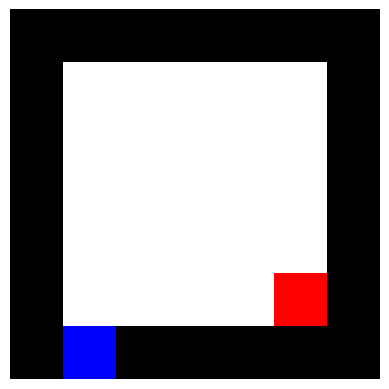

Episode: 540671 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 1.0025 
    SnakeLength: 1.149169921875 
    Eplsilon: 0.5241214818133878 
    Learning Rate: 0.1
    


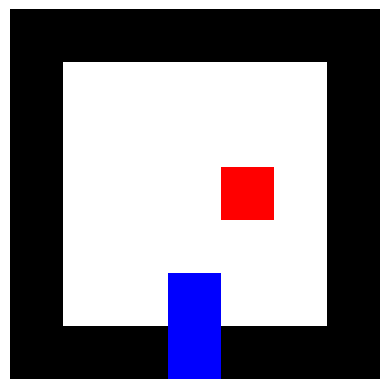

Episode: 544767 
    Avg Iterations (last 4096 episodes): 5.10 
    Avg Score (last 4096): 0.9623 
    SnakeLength: 1.140625 
    Eplsilon: 0.5219790698077076 
    Learning Rate: 0.1
    


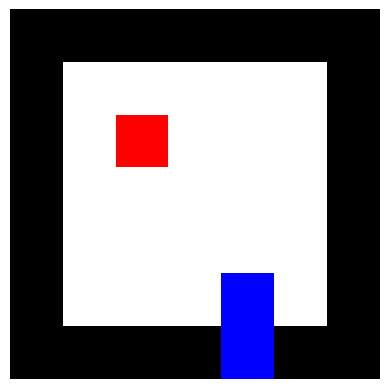

Episode: 548863 
    Avg Iterations (last 4096 episodes): 5.19 
    Avg Score (last 4096): 0.9880 
    SnakeLength: 1.145263671875 
    Eplsilon: 0.5198454151786308 
    Learning Rate: 0.1
    


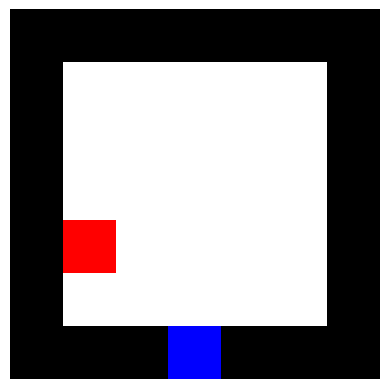

Episode: 552959 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 0.9811 
    SnakeLength: 1.146240234375 
    Eplsilon: 0.5177204821292866 
    Learning Rate: 0.1
    


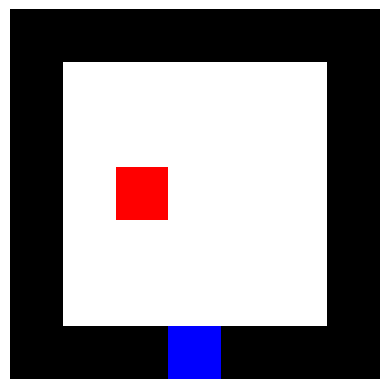

Episode: 557055 
    Avg Iterations (last 4096 episodes): 5.13 
    Avg Score (last 4096): 0.9869 
    SnakeLength: 1.140380859375 
    Eplsilon: 0.5156042350091337 
    Learning Rate: 0.1
    


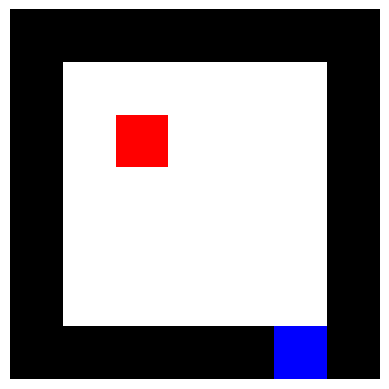

Episode: 561151 
    Avg Iterations (last 4096 episodes): 5.06 
    Avg Score (last 4096): 0.9380 
    SnakeLength: 1.139404296875 
    Eplsilon: 0.5134966383133448 
    Learning Rate: 0.1
    


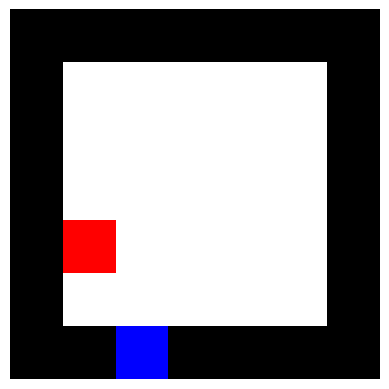

Episode: 565247 
    Avg Iterations (last 4096 episodes): 5.07 
    Avg Score (last 4096): 0.9490 
    SnakeLength: 1.13671875 
    Eplsilon: 0.5113976566822331 
    Learning Rate: 0.1
    


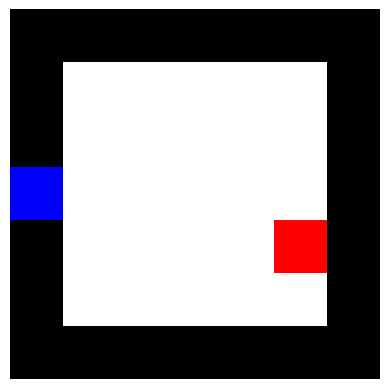

Episode: 569343 
    Avg Iterations (last 4096 episodes): 5.02 
    Avg Score (last 4096): 0.9060 
    SnakeLength: 1.141845703125 
    Eplsilon: 0.509307254900643 
    Learning Rate: 0.1
    


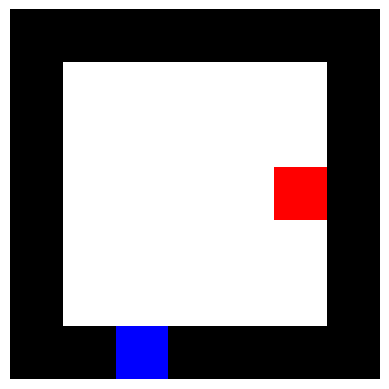

Episode: 573439 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8792 
    SnakeLength: 1.14208984375 
    Eplsilon: 0.5072253978973749 
    Learning Rate: 0.1
    


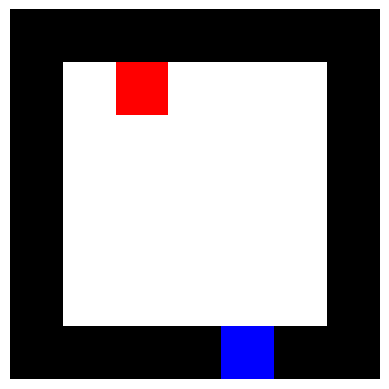

Episode: 577535 
    Avg Iterations (last 4096 episodes): 4.92 
    Avg Score (last 4096): 0.8909 
    SnakeLength: 1.14697265625 
    Eplsilon: 0.5051520507445709 
    Learning Rate: 0.1
    


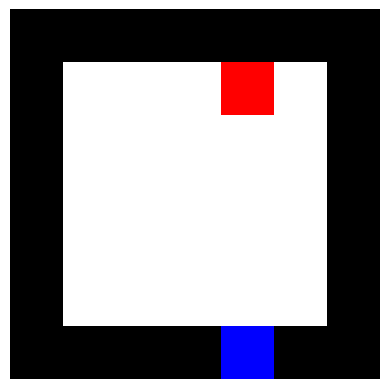

Episode: 581631 
    Avg Iterations (last 4096 episodes): 5.09 
    Avg Score (last 4096): 0.9474 
    SnakeLength: 1.130126953125 
    Eplsilon: 0.5030871786571606 
    Learning Rate: 0.1
    


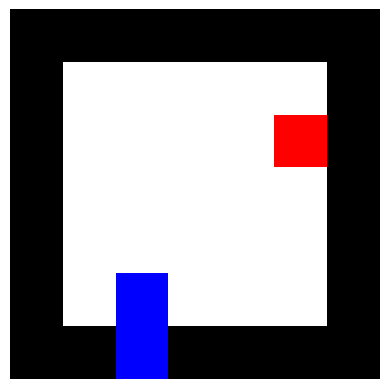

Episode: 585727 
    Avg Iterations (last 4096 episodes): 5.09 
    Avg Score (last 4096): 0.9430 
    SnakeLength: 1.143798828125 
    Eplsilon: 0.5010307469922551 
    Learning Rate: 0.1
    


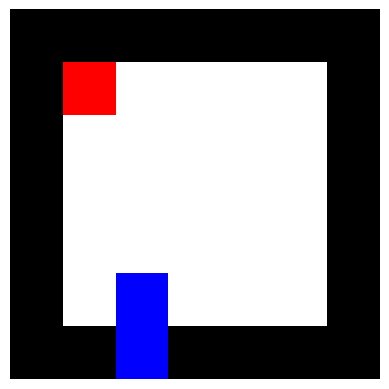

Episode: 589823 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.8985 
    SnakeLength: 1.1376953125 
    Eplsilon: 0.4989827212485755 
    Learning Rate: 0.1
    


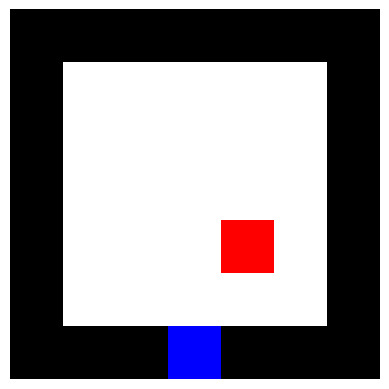

Episode: 593919 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.9200 
    SnakeLength: 1.14013671875 
    Eplsilon: 0.49694306706586633 
    Learning Rate: 0.1
    


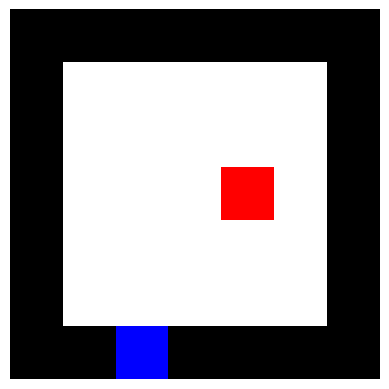

Episode: 598015 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.9706 
    SnakeLength: 1.1513671875 
    Eplsilon: 0.49491175022432754 
    Learning Rate: 0.1
    


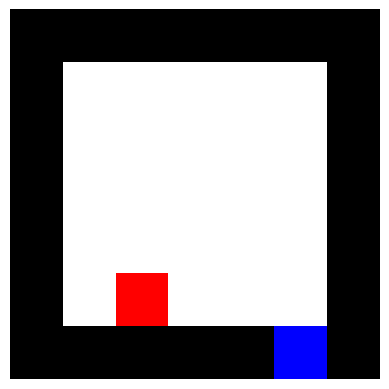

Episode: 602111 
    Avg Iterations (last 4096 episodes): 4.93 
    Avg Score (last 4096): 0.8798 
    SnakeLength: 1.12744140625 
    Eplsilon: 0.492888736644034 
    Learning Rate: 0.1
    


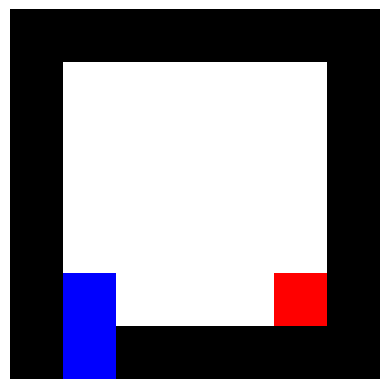

Episode: 606207 
    Avg Iterations (last 4096 episodes): 5.07 
    Avg Score (last 4096): 0.9364 
    SnakeLength: 1.140625 
    Eplsilon: 0.49087399238437124 
    Learning Rate: 0.1
    


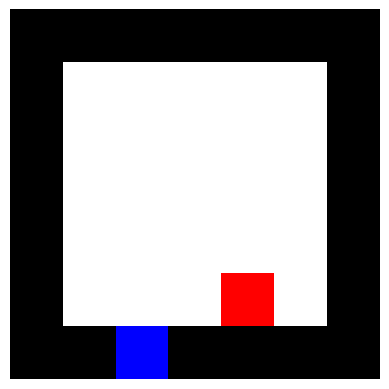

Episode: 610303 
    Avg Iterations (last 4096 episodes): 4.97 
    Avg Score (last 4096): 0.9302 
    SnakeLength: 1.139404296875 
    Eplsilon: 0.48886748364345717 
    Learning Rate: 0.1
    


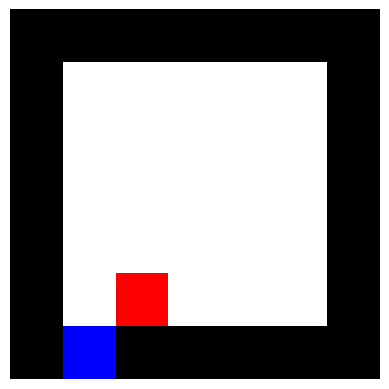

Episode: 614399 
    Avg Iterations (last 4096 episodes): 4.87 
    Avg Score (last 4096): 0.8682 
    SnakeLength: 1.136474609375 
    Eplsilon: 0.4868691767575819 
    Learning Rate: 0.1
    


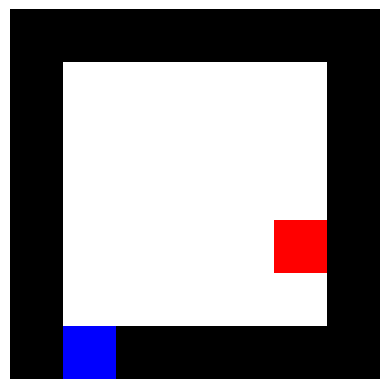

Episode: 618495 
    Avg Iterations (last 4096 episodes): 4.94 
    Avg Score (last 4096): 0.8661 
    SnakeLength: 1.13427734375 
    Eplsilon: 0.48487903820063727 
    Learning Rate: 0.1
    


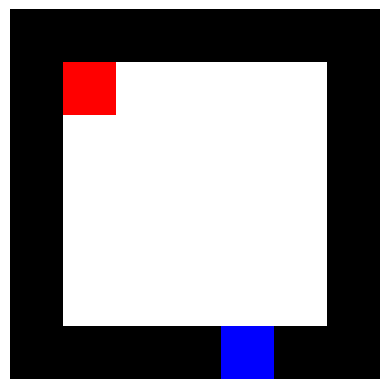

Episode: 622591 
    Avg Iterations (last 4096 episodes): 5.02 
    Avg Score (last 4096): 0.9256 
    SnakeLength: 1.1494140625 
    Eplsilon: 0.4828970345835584 
    Learning Rate: 0.1
    


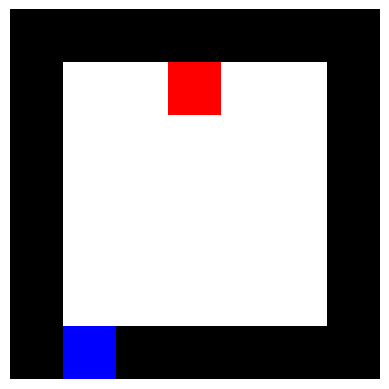

Episode: 626687 
    Avg Iterations (last 4096 episodes): 5.01 
    Avg Score (last 4096): 0.9178 
    SnakeLength: 1.137451171875 
    Eplsilon: 0.4809231326537644 
    Learning Rate: 0.1
    


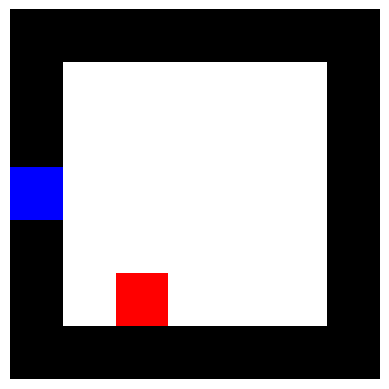

Episode: 630783 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.8144 
    SnakeLength: 1.131591796875 
    Eplsilon: 0.4789572992945968 
    Learning Rate: 0.1
    


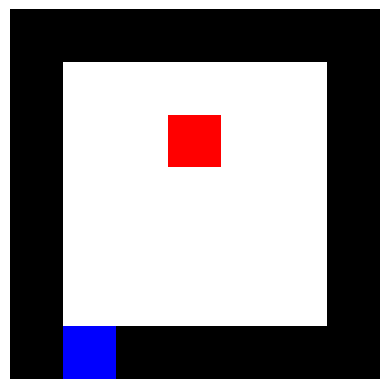

Episode: 634879 
    Avg Iterations (last 4096 episodes): 5.04 
    Avg Score (last 4096): 0.9421 
    SnakeLength: 1.142822265625 
    Eplsilon: 0.4769995015247641 
    Learning Rate: 0.1
    


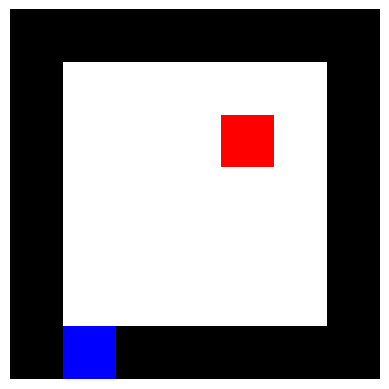

Episode: 638975 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.8939 
    SnakeLength: 1.142578125 
    Eplsilon: 0.4750497064977908 
    Learning Rate: 0.1
    


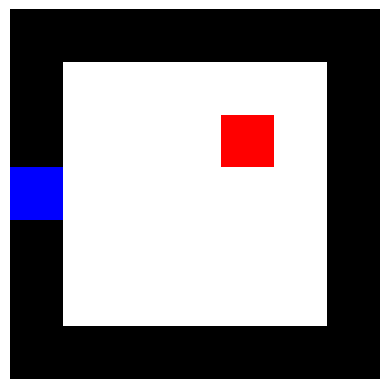

Episode: 643071 
    Avg Iterations (last 4096 episodes): 4.88 
    Avg Score (last 4096): 0.8582 
    SnakeLength: 1.13525390625 
    Eplsilon: 0.4731078815014691 
    Learning Rate: 0.1
    


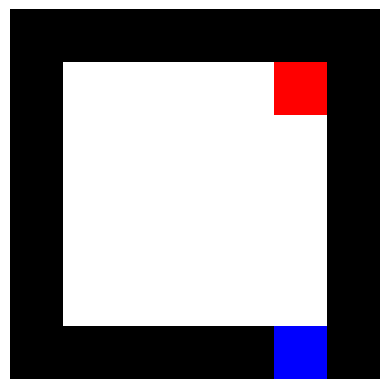

Episode: 647167 
    Avg Iterations (last 4096 episodes): 4.99 
    Avg Score (last 4096): 0.8717 
    SnakeLength: 1.12890625 
    Eplsilon: 0.47117399395730275 
    Learning Rate: 0.1
    


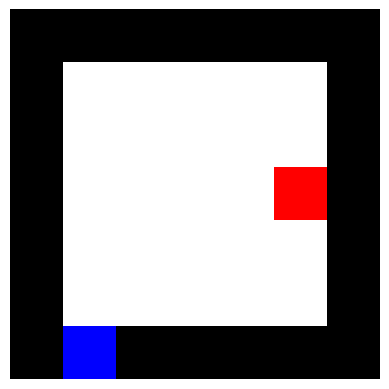

Episode: 651263 
    Avg Iterations (last 4096 episodes): 4.92 
    Avg Score (last 4096): 0.8780 
    SnakeLength: 1.150390625 
    Eplsilon: 0.46924801141996475 
    Learning Rate: 0.1
    


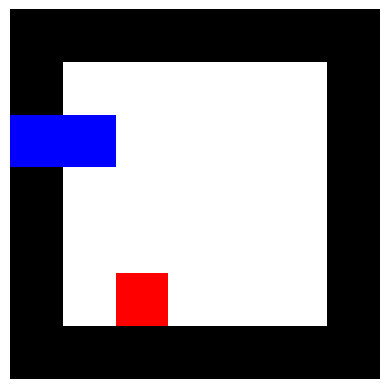

Episode: 655359 
    Avg Iterations (last 4096 episodes): 4.93 
    Avg Score (last 4096): 0.8714 
    SnakeLength: 1.135986328125 
    Eplsilon: 0.46732990157674964 
    Learning Rate: 0.1
    


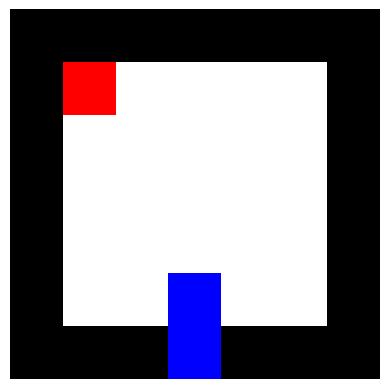

Episode: 659455 
    Avg Iterations (last 4096 episodes): 4.81 
    Avg Score (last 4096): 0.8304 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.4654196322470394 
    Learning Rate: 0.1
    


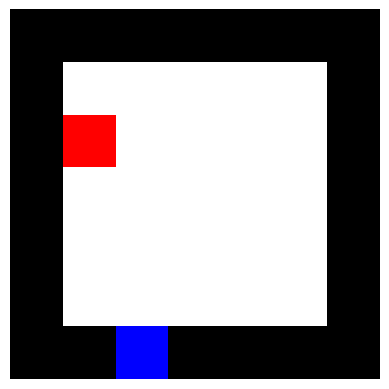

Episode: 663551 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8821 
    SnakeLength: 1.13427734375 
    Eplsilon: 0.4635171713817573 
    Learning Rate: 0.1
    


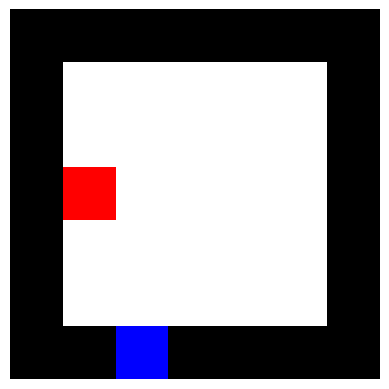

Episode: 667647 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.9127 
    SnakeLength: 1.13916015625 
    Eplsilon: 0.46162248706282755 
    Learning Rate: 0.1
    


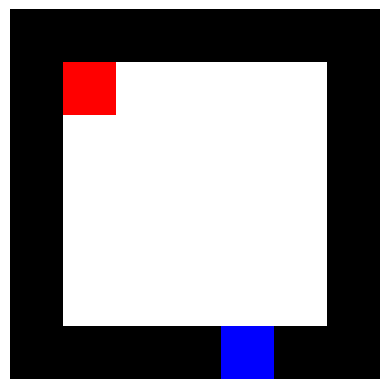

Episode: 671743 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7986 
    SnakeLength: 1.136962890625 
    Eplsilon: 0.459735547502648 
    Learning Rate: 0.1
    


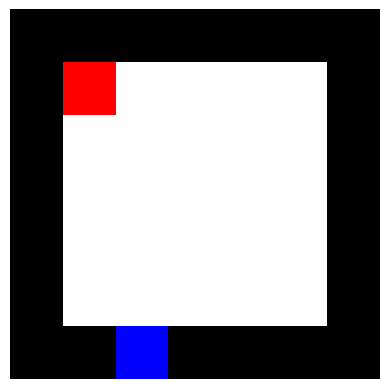

Episode: 675839 
    Avg Iterations (last 4096 episodes): 4.87 
    Avg Score (last 4096): 0.8816 
    SnakeLength: 1.146240234375 
    Eplsilon: 0.45785632104354673 
    Learning Rate: 0.1
    


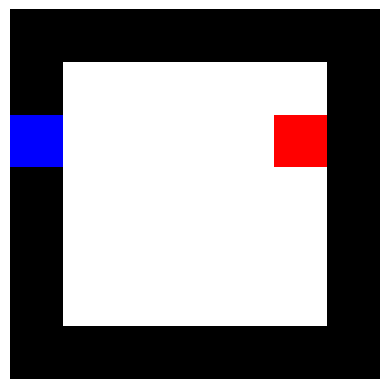

Episode: 679935 
    Avg Iterations (last 4096 episodes): 4.91 
    Avg Score (last 4096): 0.8749 
    SnakeLength: 1.143310546875 
    Eplsilon: 0.45598477615726113 
    Learning Rate: 0.1
    


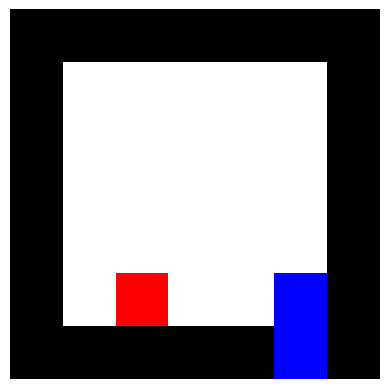

Episode: 684031 
    Avg Iterations (last 4096 episodes): 4.82 
    Avg Score (last 4096): 0.8282 
    SnakeLength: 1.14208984375 
    Eplsilon: 0.4541208814444068 
    Learning Rate: 0.1
    


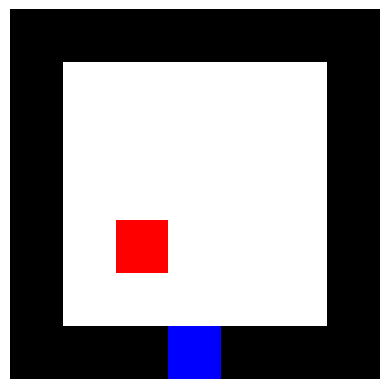

Episode: 688127 
    Avg Iterations (last 4096 episodes): 4.92 
    Avg Score (last 4096): 0.8667 
    SnakeLength: 1.131591796875 
    Eplsilon: 0.4522646056339415 
    Learning Rate: 0.1
    


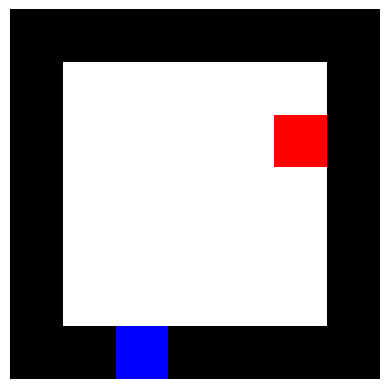

Episode: 692223 
    Avg Iterations (last 4096 episodes): 4.86 
    Avg Score (last 4096): 0.8399 
    SnakeLength: 1.13427734375 
    Eplsilon: 0.4504159175826519 
    Learning Rate: 0.1
    


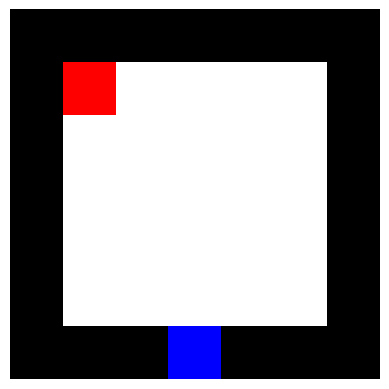

Episode: 696319 
    Avg Iterations (last 4096 episodes): 4.86 
    Avg Score (last 4096): 0.8926 
    SnakeLength: 1.14599609375 
    Eplsilon: 0.44857478627461944 
    Learning Rate: 0.1
    


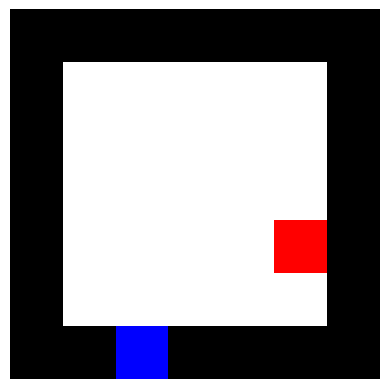

Episode: 700415 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.8659 
    SnakeLength: 1.133544921875 
    Eplsilon: 0.446741180820722 
    Learning Rate: 0.1
    


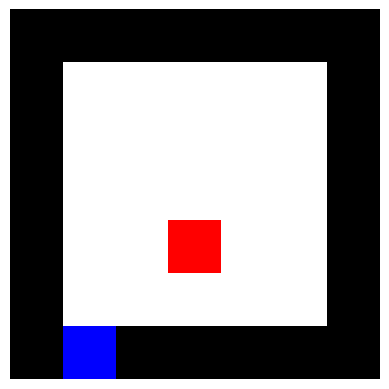

Episode: 704511 
    Avg Iterations (last 4096 episodes): 4.74 
    Avg Score (last 4096): 0.7714 
    SnakeLength: 1.130615234375 
    Eplsilon: 0.4449150704580826 
    Learning Rate: 0.1
    


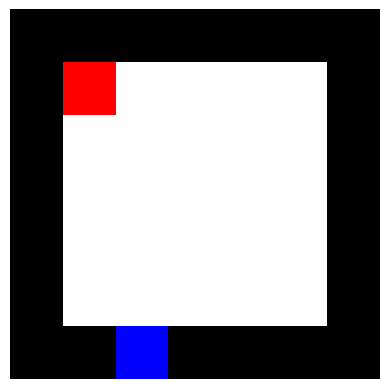

Episode: 708607 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8589 
    SnakeLength: 1.138916015625 
    Eplsilon: 0.44309642454958054 
    Learning Rate: 0.1
    


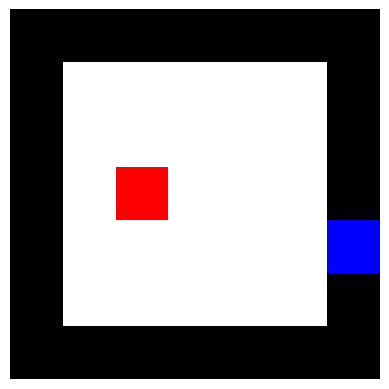

Episode: 712703 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8717 
    SnakeLength: 1.14306640625 
    Eplsilon: 0.44128521258333214 
    Learning Rate: 0.1
    


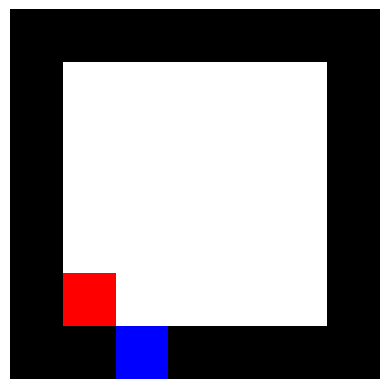

Episode: 716799 
    Avg Iterations (last 4096 episodes): 4.94 
    Avg Score (last 4096): 0.8932 
    SnakeLength: 1.142578125 
    Eplsilon: 0.4394814041721682 
    Learning Rate: 0.1
    


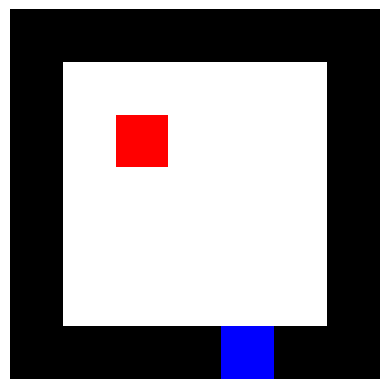

Episode: 720895 
    Avg Iterations (last 4096 episodes): 4.87 
    Avg Score (last 4096): 0.8736 
    SnakeLength: 1.1484375 
    Eplsilon: 0.43768496905313253 
    Learning Rate: 0.1
    


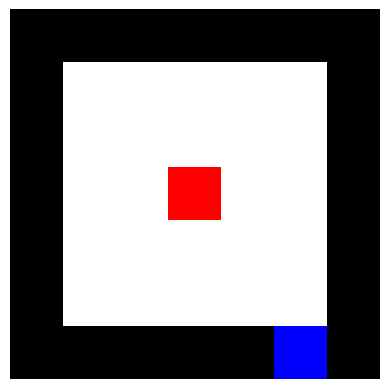

Episode: 724991 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.8046 
    SnakeLength: 1.13818359375 
    Eplsilon: 0.43589587708697114 
    Learning Rate: 0.1
    


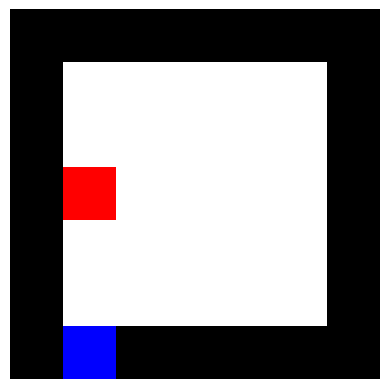

Episode: 729087 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.8028 
    SnakeLength: 1.140869140625 
    Eplsilon: 0.43411409825763253 
    Learning Rate: 0.1
    


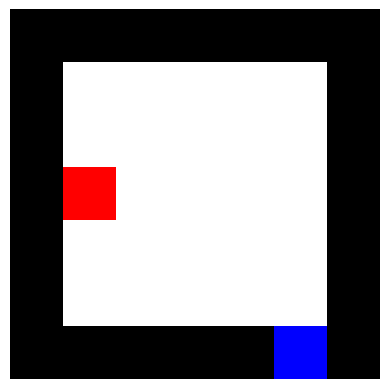

Episode: 733183 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.8379 
    SnakeLength: 1.138916015625 
    Eplsilon: 0.4323396026717569 
    Learning Rate: 0.1
    


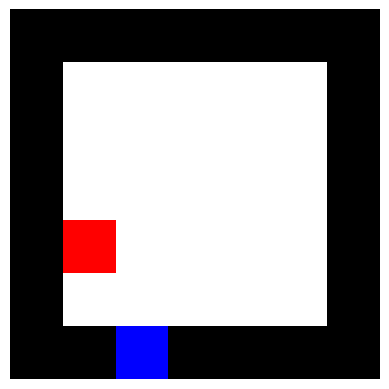

Episode: 737279 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7900 
    SnakeLength: 1.135498046875 
    Eplsilon: 0.43057236055817394 
    Learning Rate: 0.1
    


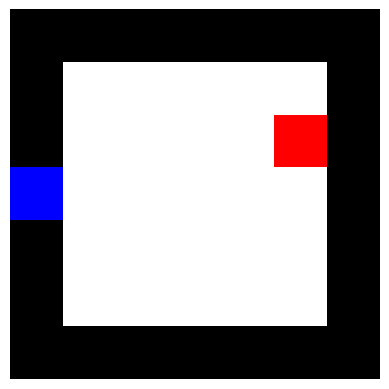

Episode: 741375 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7760 
    SnakeLength: 1.135498046875 
    Eplsilon: 0.4288123422674125 
    Learning Rate: 0.1
    


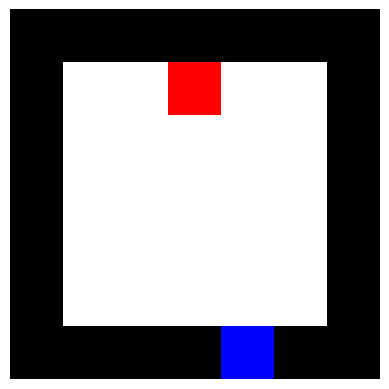

Episode: 745471 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.8112 
    SnakeLength: 1.13232421875 
    Eplsilon: 0.427059518271194 
    Learning Rate: 0.1
    


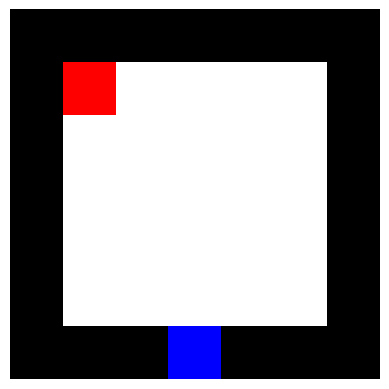

Episode: 749567 
    Avg Iterations (last 4096 episodes): 4.89 
    Avg Score (last 4096): 0.8657 
    SnakeLength: 1.14453125 
    Eplsilon: 0.42531385916194103 
    Learning Rate: 0.1
    


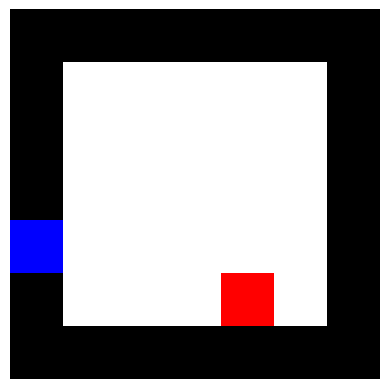

Episode: 753663 
    Avg Iterations (last 4096 episodes): 4.77 
    Avg Score (last 4096): 0.8194 
    SnakeLength: 1.13916015625 
    Eplsilon: 0.42357533565228184 
    Learning Rate: 0.1
    


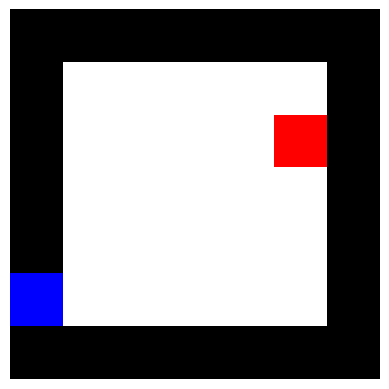

Episode: 757759 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.8258 
    SnakeLength: 1.135498046875 
    Eplsilon: 0.42184391857456477 
    Learning Rate: 0.1
    


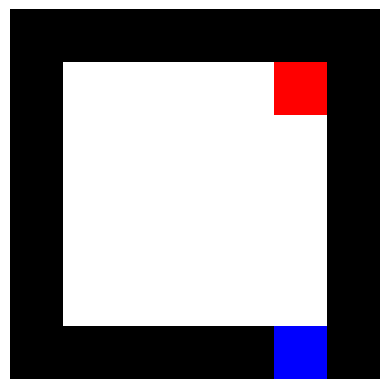

Episode: 761855 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.8310 
    SnakeLength: 1.1337890625 
    Eplsilon: 0.42011957888035906 
    Learning Rate: 0.1
    


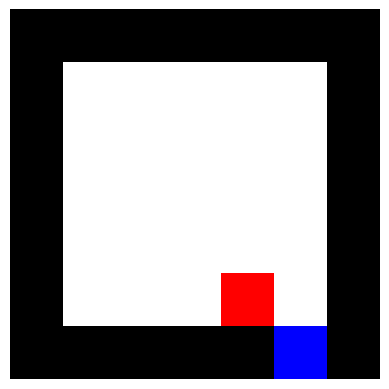

Episode: 765951 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.7665 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.41840228763997783 
    Learning Rate: 0.1
    


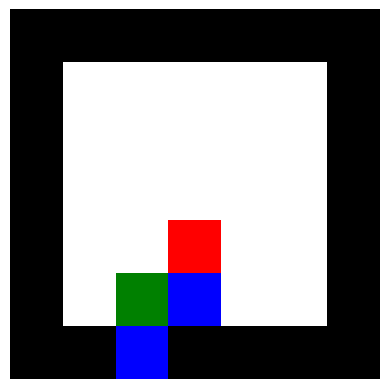

Episode: 770047 
    Avg Iterations (last 4096 episodes): 4.80 
    Avg Score (last 4096): 0.8293 
    SnakeLength: 1.14111328125 
    Eplsilon: 0.41669201604198686 
    Learning Rate: 0.1
    


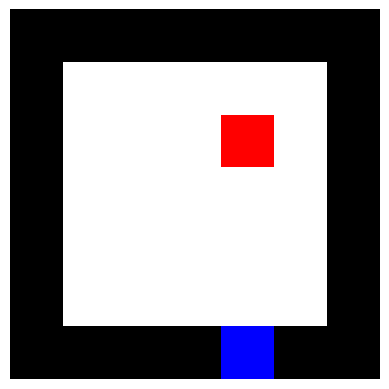

Episode: 774143 
    Avg Iterations (last 4096 episodes): 4.91 
    Avg Score (last 4096): 0.8802 
    SnakeLength: 1.14111328125 
    Eplsilon: 0.4149887353927178 
    Learning Rate: 0.1
    


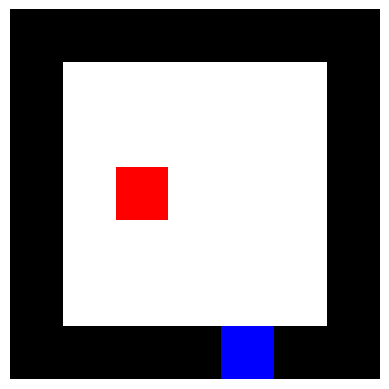

Episode: 778239 
    Avg Iterations (last 4096 episodes): 4.80 
    Avg Score (last 4096): 0.8131 
    SnakeLength: 1.1298828125 
    Eplsilon: 0.41329241711579384 
    Learning Rate: 0.1
    


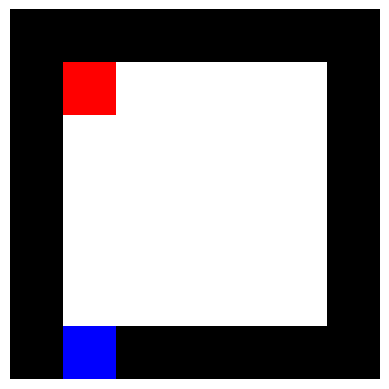

Episode: 782335 
    Avg Iterations (last 4096 episodes): 4.79 
    Avg Score (last 4096): 0.8286 
    SnakeLength: 1.1357421875 
    Eplsilon: 0.41160303275165533 
    Learning Rate: 0.1
    


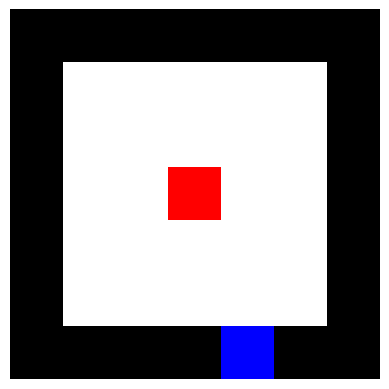

Episode: 786431 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8756 
    SnakeLength: 1.1396484375 
    Eplsilon: 0.40992055395706434 
    Learning Rate: 0.1
    


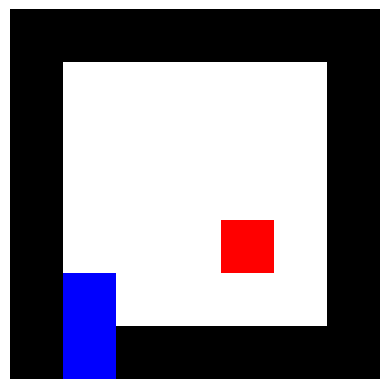

Episode: 790527 
    Avg Iterations (last 4096 episodes): 4.75 
    Avg Score (last 4096): 0.7972 
    SnakeLength: 1.1376953125 
    Eplsilon: 0.40824495250464315 
    Learning Rate: 0.1
    


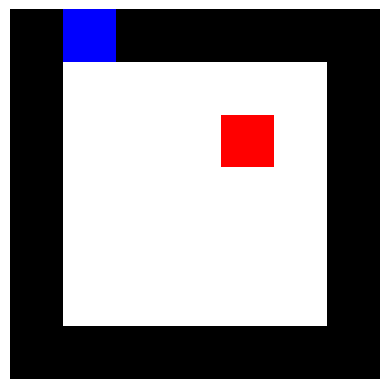

Episode: 794623 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7885 
    SnakeLength: 1.135009765625 
    Eplsilon: 0.40657620028239705 
    Learning Rate: 0.1
    


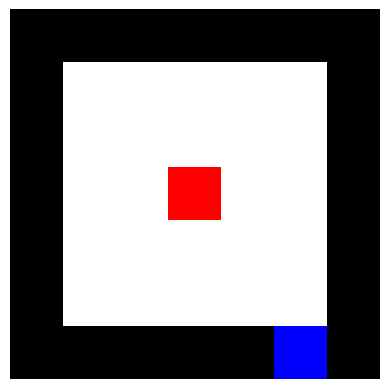

Episode: 798719 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7286 
    SnakeLength: 1.12646484375 
    Eplsilon: 0.4049142692932405 
    Learning Rate: 0.1
    


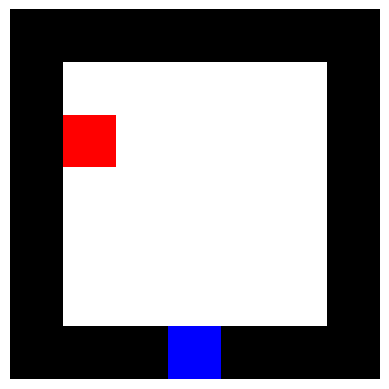

Episode: 802815 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7669 
    SnakeLength: 1.12939453125 
    Eplsilon: 0.40325913165453375 
    Learning Rate: 0.1
    


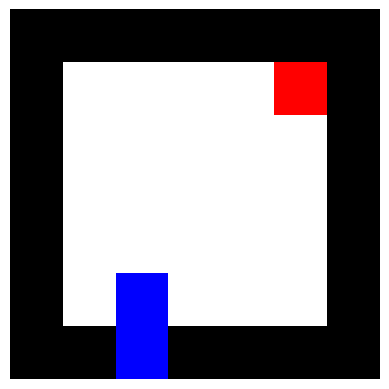

Episode: 806911 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7836 
    SnakeLength: 1.134033203125 
    Eplsilon: 0.4016107595976054 
    Learning Rate: 0.1
    


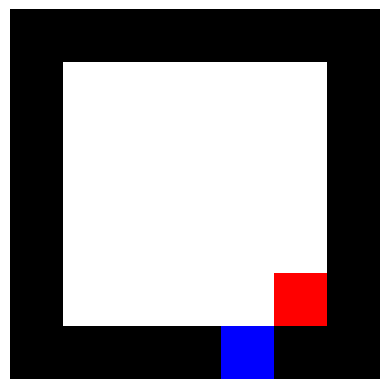

Episode: 811007 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7934 
    SnakeLength: 1.13330078125 
    Eplsilon: 0.3999691254672989 
    Learning Rate: 0.1
    


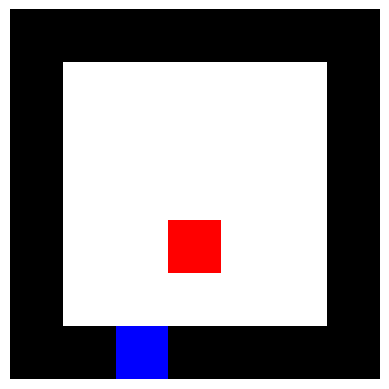

Episode: 815103 
    Avg Iterations (last 4096 episodes): 4.73 
    Avg Score (last 4096): 0.7811 
    SnakeLength: 1.13232421875 
    Eplsilon: 0.3983342017214971 
    Learning Rate: 0.1
    


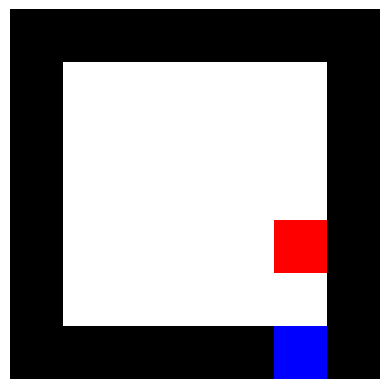

Episode: 819199 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.8147 
    SnakeLength: 1.138427734375 
    Eplsilon: 0.3967059609306649 
    Learning Rate: 0.1
    


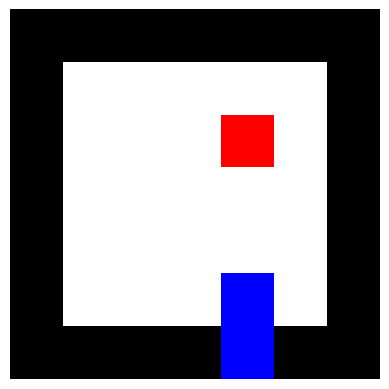

Episode: 823295 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7357 
    SnakeLength: 1.128173828125 
    Eplsilon: 0.3950843757773862 
    Learning Rate: 0.1
    


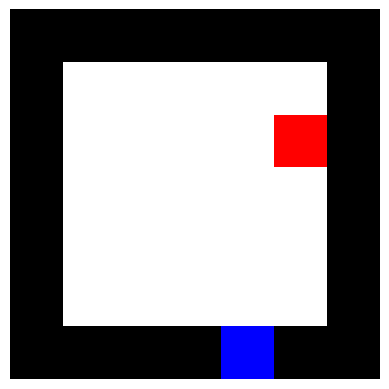

Episode: 827391 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7716 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.39346941905591726 
    Learning Rate: 0.1
    


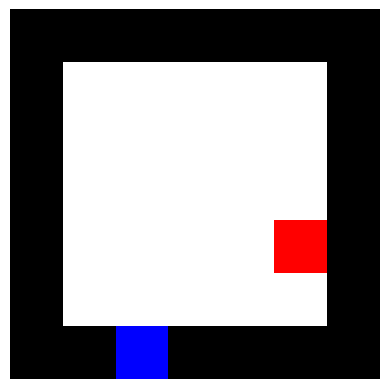

Episode: 831487 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7596 
    SnakeLength: 1.13330078125 
    Eplsilon: 0.39186106367171086 
    Learning Rate: 0.1
    


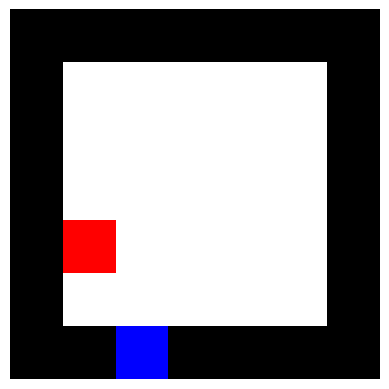

Episode: 835583 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.7331 
    SnakeLength: 1.12890625 
    Eplsilon: 0.3902592826409788 
    Learning Rate: 0.1
    


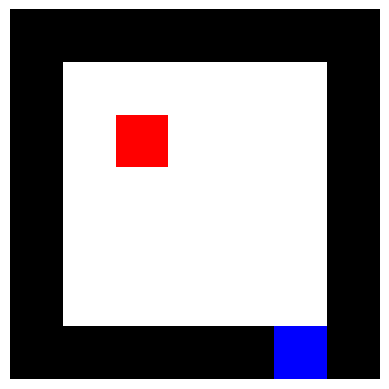

Episode: 839679 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7599 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.3886640490902303 
    Learning Rate: 0.1
    


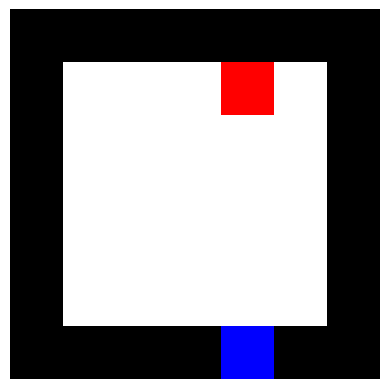

Episode: 843775 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.7387 
    SnakeLength: 1.119140625 
    Eplsilon: 0.387075336255822 
    Learning Rate: 0.1
    


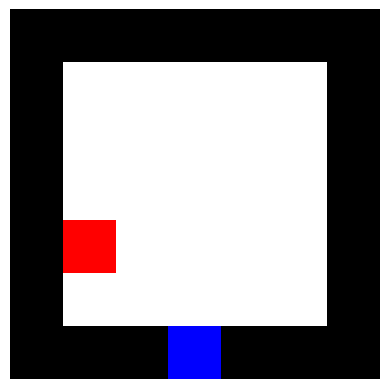

Episode: 847871 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7185 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.38549311748351134 
    Learning Rate: 0.1
    


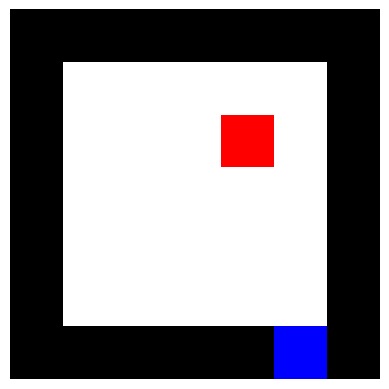

Episode: 851967 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7421 
    SnakeLength: 1.131591796875 
    Eplsilon: 0.3839173662280089 
    Learning Rate: 0.1
    


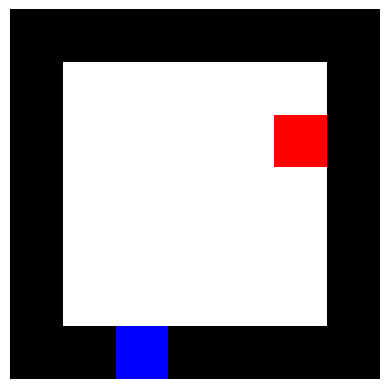

Episode: 856063 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.7201 
    SnakeLength: 1.13916015625 
    Eplsilon: 0.38234805605253064 
    Learning Rate: 0.1
    


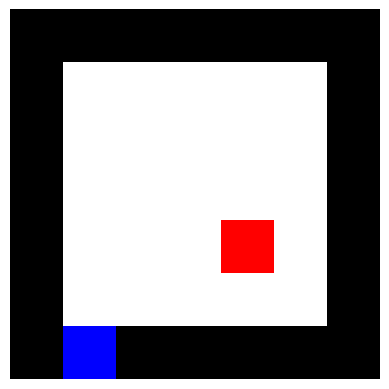

Episode: 860159 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7793 
    SnakeLength: 1.131591796875 
    Eplsilon: 0.3807851606283625 
    Learning Rate: 0.1
    


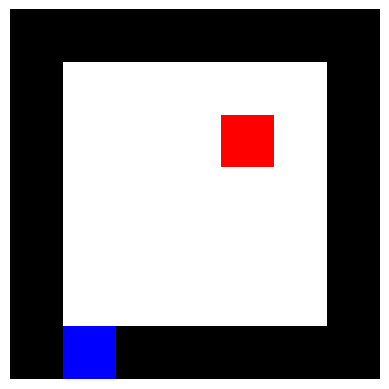

Episode: 864255 
    Avg Iterations (last 4096 episodes): 4.65 
    Avg Score (last 4096): 0.7549 
    SnakeLength: 1.1298828125 
    Eplsilon: 0.3792286537344051 
    Learning Rate: 0.1
    


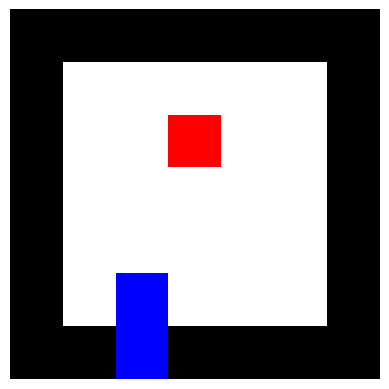

Episode: 868351 
    Avg Iterations (last 4096 episodes): 4.79 
    Avg Score (last 4096): 0.8168 
    SnakeLength: 1.134033203125 
    Eplsilon: 0.3776785092567421 
    Learning Rate: 0.1
    


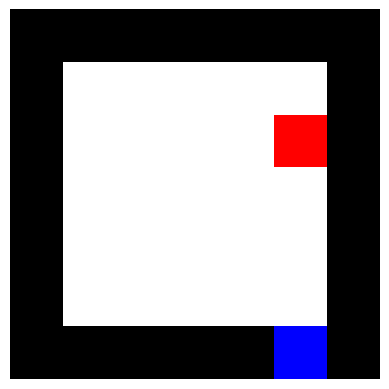

Episode: 872447 
    Avg Iterations (last 4096 episodes): 4.74 
    Avg Score (last 4096): 0.7816 
    SnakeLength: 1.123291015625 
    Eplsilon: 0.37613470118820247 
    Learning Rate: 0.1
    


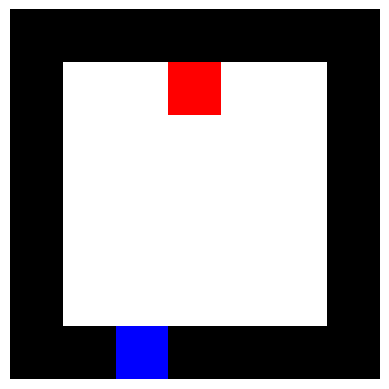

Episode: 876543 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7705 
    SnakeLength: 1.13427734375 
    Eplsilon: 0.37459720362792454 
    Learning Rate: 0.1
    


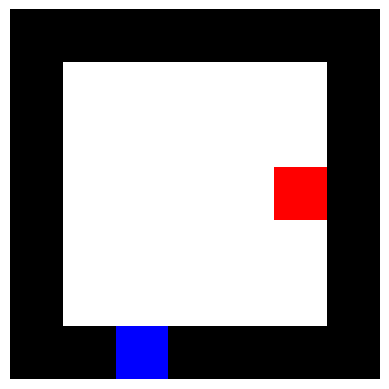

Episode: 880639 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7606 
    SnakeLength: 1.13037109375 
    Eplsilon: 0.37306599078091546 
    Learning Rate: 0.1
    


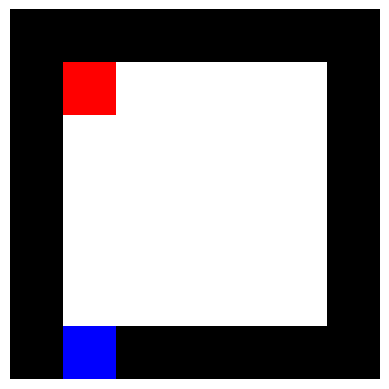

Episode: 884735 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.7122 
    SnakeLength: 1.133056640625 
    Eplsilon: 0.37154103695762675 
    Learning Rate: 0.1
    


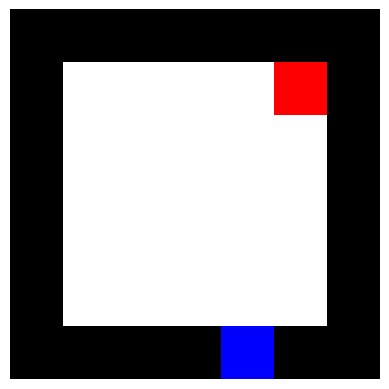

Episode: 888831 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7411 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.37002231657351614 
    Learning Rate: 0.1
    


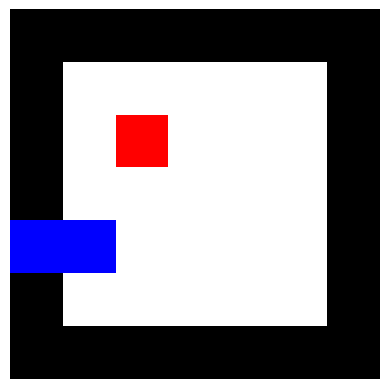

Episode: 892927 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7382 
    SnakeLength: 1.138671875 
    Eplsilon: 0.36850980414862555 
    Learning Rate: 0.1
    


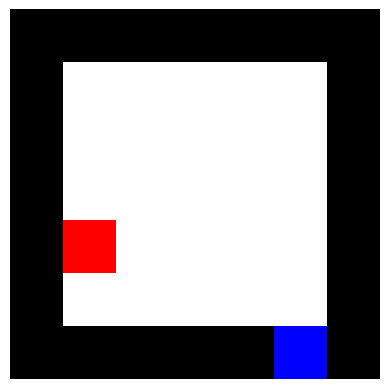

Episode: 897023 
    Avg Iterations (last 4096 episodes): 4.73 
    Avg Score (last 4096): 0.7851 
    SnakeLength: 1.12353515625 
    Eplsilon: 0.36700347430713876 
    Learning Rate: 0.1
    


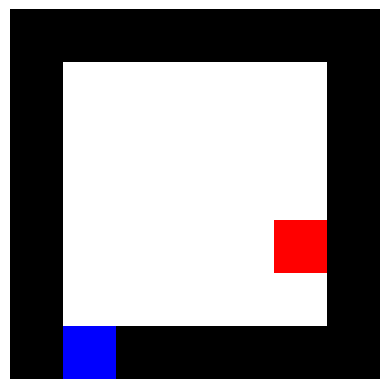

Episode: 901119 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7247 
    SnakeLength: 1.127685546875 
    Eplsilon: 0.365503301776984 
    Learning Rate: 0.1
    


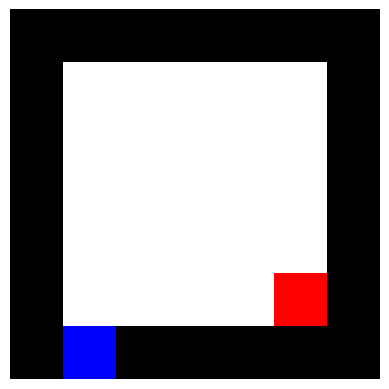

Episode: 905215 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7539 
    SnakeLength: 1.136962890625 
    Eplsilon: 0.3640092613893752 
    Learning Rate: 0.1
    


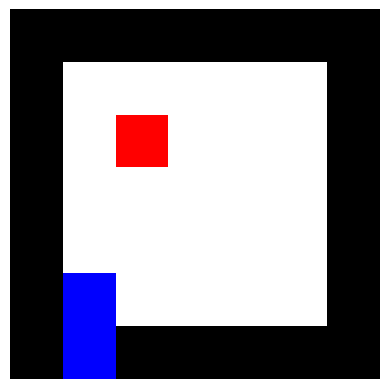

Episode: 909311 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7012 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.3625213280784189 
    Learning Rate: 0.1
    


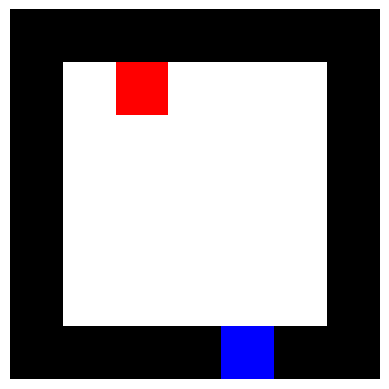

Episode: 913407 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7319 
    SnakeLength: 1.1298828125 
    Eplsilon: 0.36103947688067406 
    Learning Rate: 0.1
    


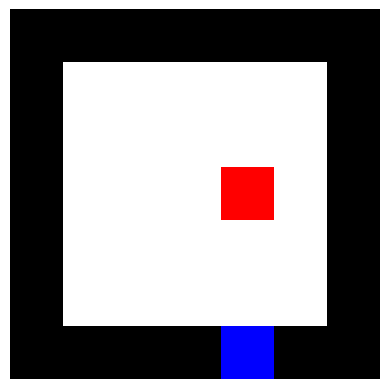

Episode: 917503 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7142 
    SnakeLength: 1.130615234375 
    Eplsilon: 0.3595636829347424 
    Learning Rate: 0.1
    


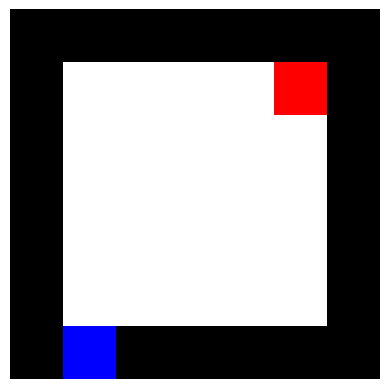

Episode: 921599 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7105 
    SnakeLength: 1.130126953125 
    Eplsilon: 0.35809392148085284 
    Learning Rate: 0.1
    


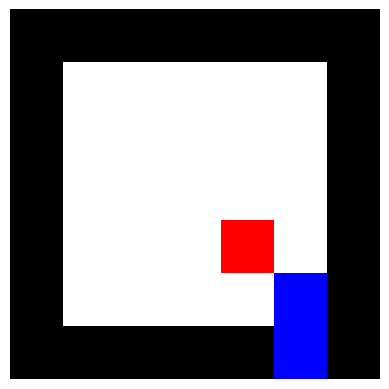

Episode: 925695 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.6751 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.35663016786043933 
    Learning Rate: 0.1
    


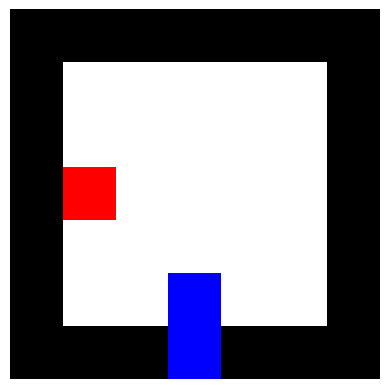

Episode: 929791 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7540 
    SnakeLength: 1.133056640625 
    Eplsilon: 0.35517239751573315 
    Learning Rate: 0.1
    


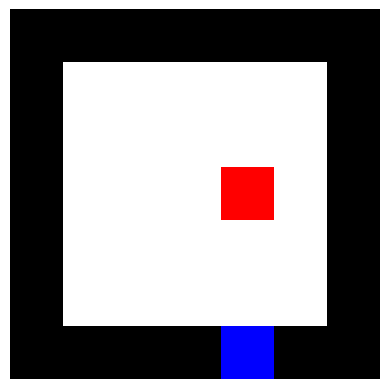

Episode: 933887 
    Avg Iterations (last 4096 episodes): 4.65 
    Avg Score (last 4096): 0.7717 
    SnakeLength: 1.135498046875 
    Eplsilon: 0.3537205859893483 
    Learning Rate: 0.1
    


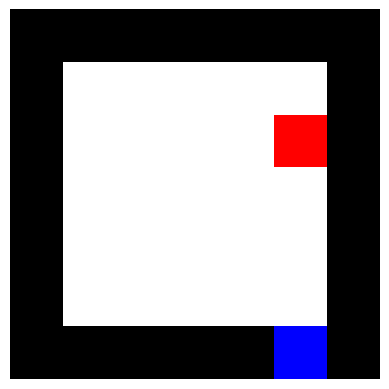

Episode: 937983 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.7153 
    SnakeLength: 1.1328125 
    Eplsilon: 0.35227470892386975 
    Learning Rate: 0.1
    


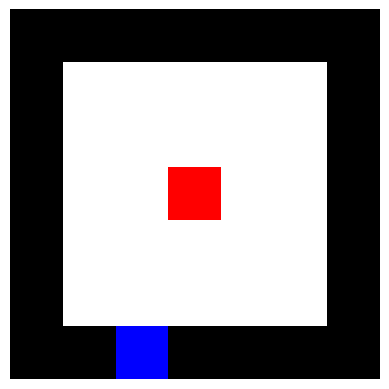

Episode: 942079 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.7161 
    SnakeLength: 1.135009765625 
    Eplsilon: 0.3508347420614464 
    Learning Rate: 0.1
    


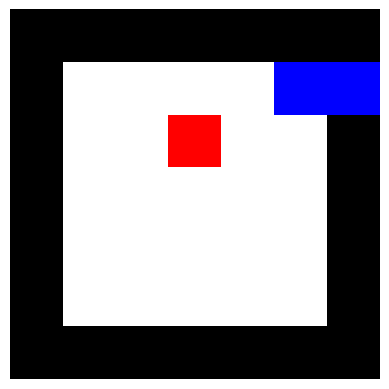

Episode: 946175 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6700 
    SnakeLength: 1.124267578125 
    Eplsilon: 0.3494006612433867 
    Learning Rate: 0.1
    


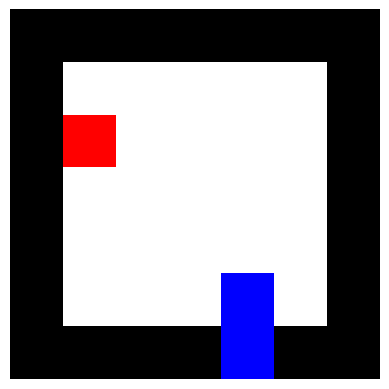

Episode: 950271 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6864 
    SnakeLength: 1.12744140625 
    Eplsilon: 0.34797244240974834 
    Learning Rate: 0.1
    


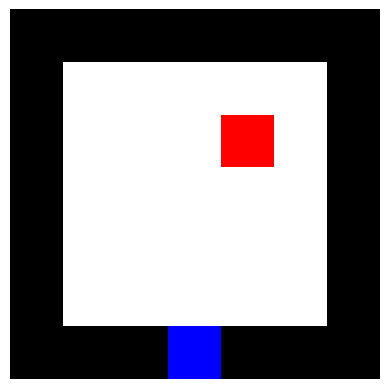

Episode: 954367 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7538 
    SnakeLength: 1.13525390625 
    Eplsilon: 0.34655006159894014 
    Learning Rate: 0.1
    


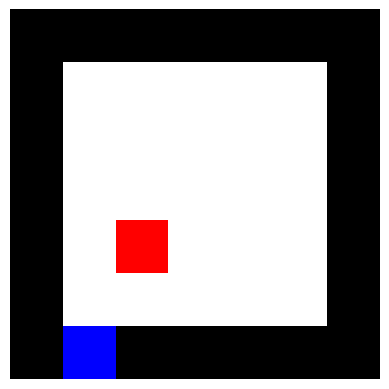

Episode: 958463 
    Avg Iterations (last 4096 episodes): 4.65 
    Avg Score (last 4096): 0.7356 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.3451334949473122 
    Learning Rate: 0.1
    


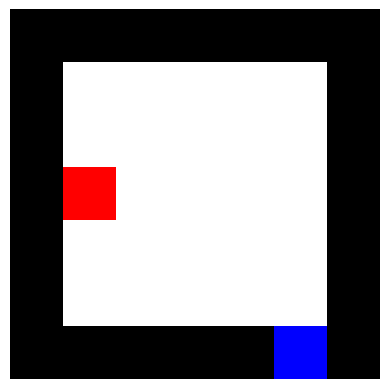

Episode: 962559 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7253 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.34372271868876586 
    Learning Rate: 0.1
    


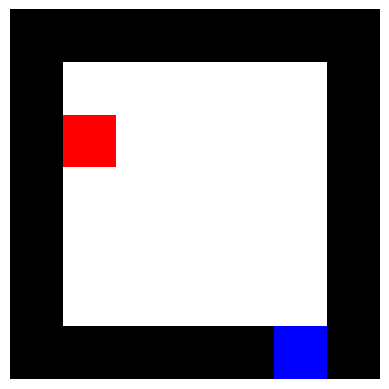

Episode: 966655 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.7182 
    SnakeLength: 1.132080078125 
    Eplsilon: 0.34231770915434623 
    Learning Rate: 0.1
    


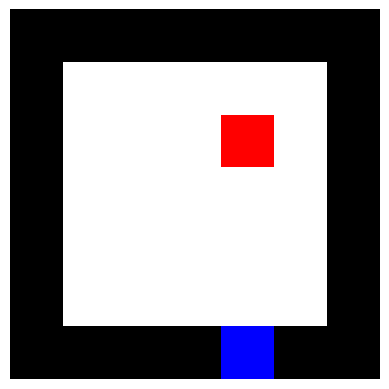

Episode: 970751 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7521 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.3409184427718454 
    Learning Rate: 0.1
    


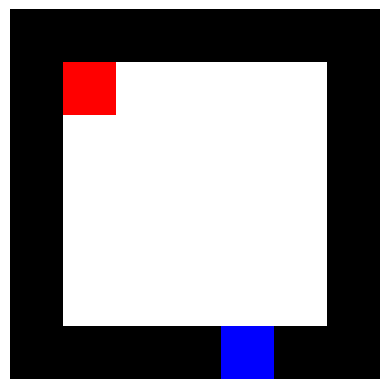

Episode: 974847 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.7358 
    SnakeLength: 1.134033203125 
    Eplsilon: 0.3395248960654136 
    Learning Rate: 0.1
    


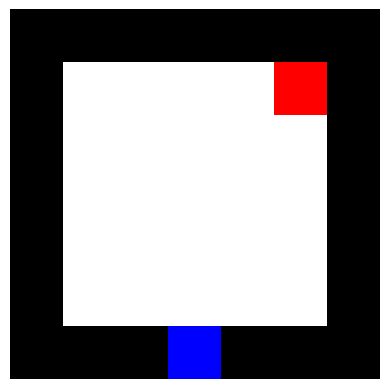

Episode: 978943 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7381 
    SnakeLength: 1.138916015625 
    Eplsilon: 0.33813704565516184 
    Learning Rate: 0.1
    


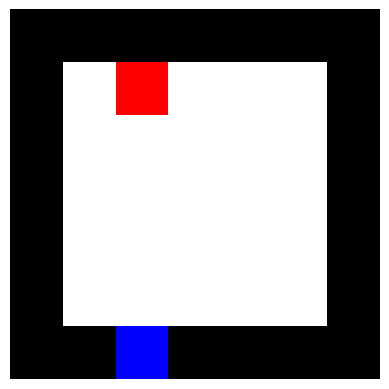

Episode: 983039 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.8000 
    SnakeLength: 1.132080078125 
    Eplsilon: 0.3367548682567664 
    Learning Rate: 0.1
    


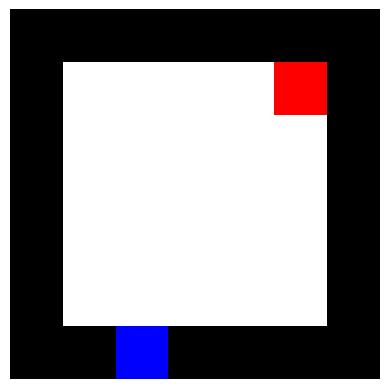

Episode: 987135 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7319 
    SnakeLength: 1.134033203125 
    Eplsilon: 0.3353783406810833 
    Learning Rate: 0.1
    


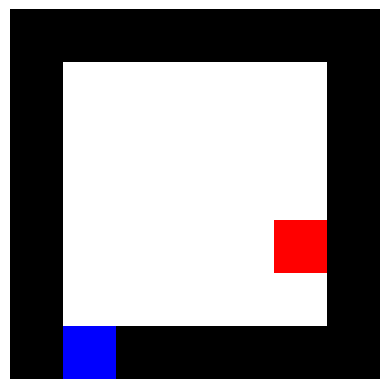

Episode: 991231 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7192 
    SnakeLength: 1.1298828125 
    Eplsilon: 0.3340074398337572 
    Learning Rate: 0.1
    


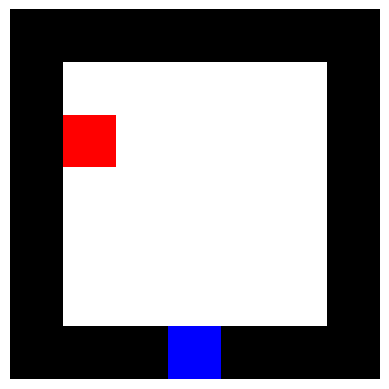

Episode: 995327 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6980 
    SnakeLength: 1.12353515625 
    Eplsilon: 0.332642142714833 
    Learning Rate: 0.1
    


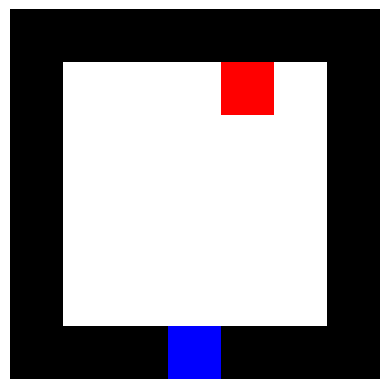

Episode: 999423 
    Avg Iterations (last 4096 episodes): 4.65 
    Avg Score (last 4096): 0.7693 
    SnakeLength: 1.128173828125 
    Eplsilon: 0.33128242641837374 
    Learning Rate: 0.1
    


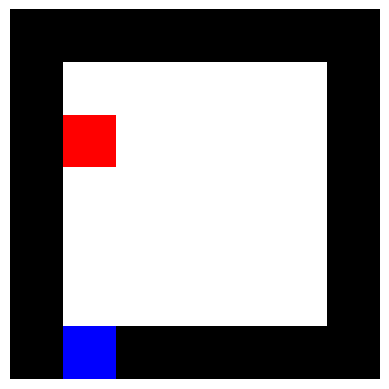

Episode: 1003519 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6716 
    SnakeLength: 1.126953125 
    Eplsilon: 0.32992826813206805 
    Learning Rate: 0.1
    


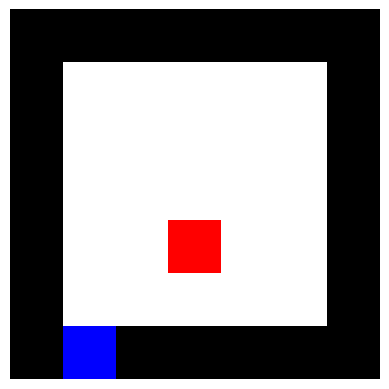

Episode: 1007615 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6716 
    SnakeLength: 1.128662109375 
    Eplsilon: 0.32857964513685767 
    Learning Rate: 0.1
    


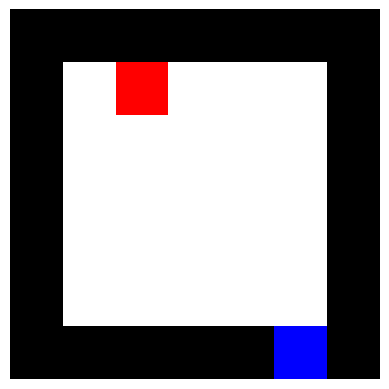

Episode: 1011711 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6959 
    SnakeLength: 1.1337890625 
    Eplsilon: 0.3272365348065448 
    Learning Rate: 0.1
    


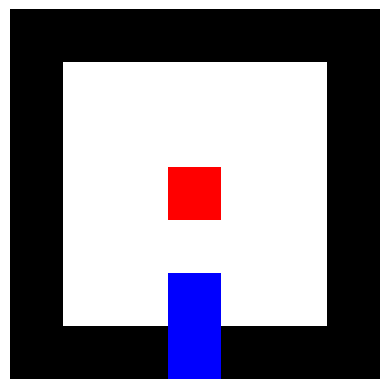

Episode: 1015807 
    Avg Iterations (last 4096 episodes): 4.46 
    Avg Score (last 4096): 0.6388 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.3258989146074243 
    Learning Rate: 0.1
    


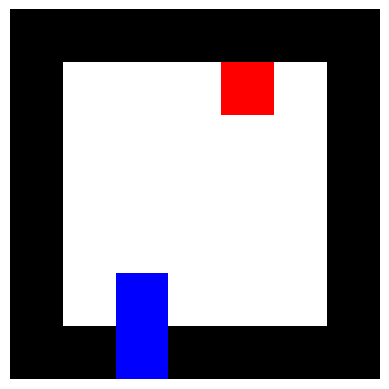

Episode: 1019903 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7352 
    SnakeLength: 1.130615234375 
    Eplsilon: 0.3245667620979015 
    Learning Rate: 0.1
    


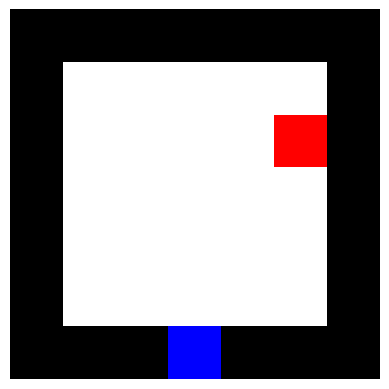

Episode: 1023999 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.7143 
    SnakeLength: 1.123046875 
    Eplsilon: 0.32324005492811286 
    Learning Rate: 0.1
    


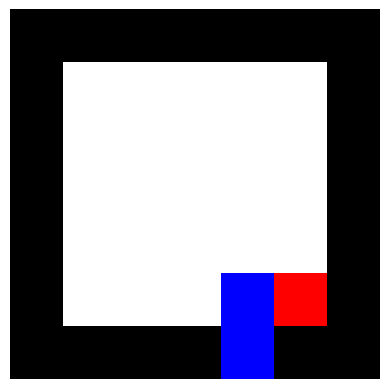

Episode: 1028095 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7586 
    SnakeLength: 1.130859375 
    Eplsilon: 0.32191877083955145 
    Learning Rate: 0.1
    


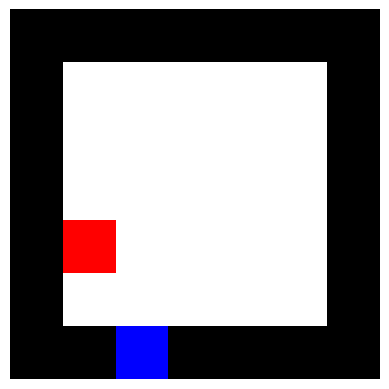

Episode: 1032191 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6491 
    SnakeLength: 1.12109375 
    Eplsilon: 0.3206028876646924 
    Learning Rate: 0.1
    


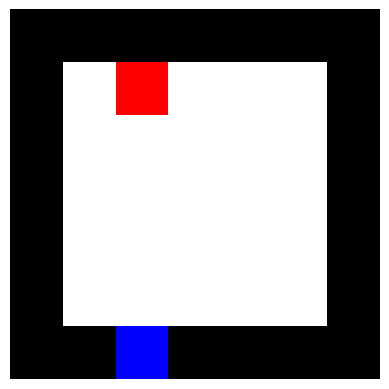

Episode: 1036287 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.6758 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.31929238332662907 
    Learning Rate: 0.1
    


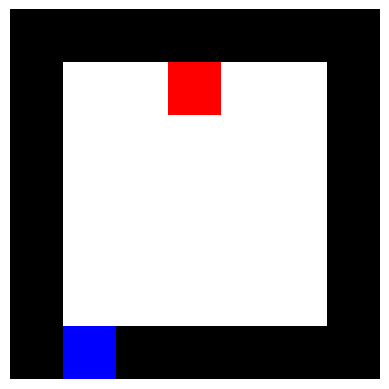

Episode: 1040383 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7104 
    SnakeLength: 1.123291015625 
    Eplsilon: 0.3179872358386961 
    Learning Rate: 0.1
    


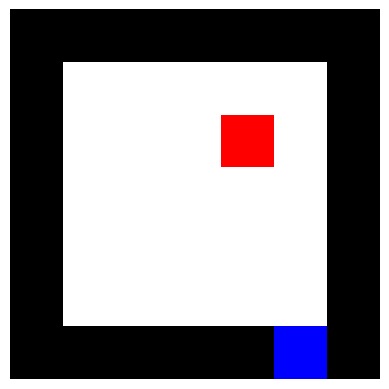

Episode: 1044479 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.7162 
    SnakeLength: 1.128173828125 
    Eplsilon: 0.3166874233040986 
    Learning Rate: 0.1
    


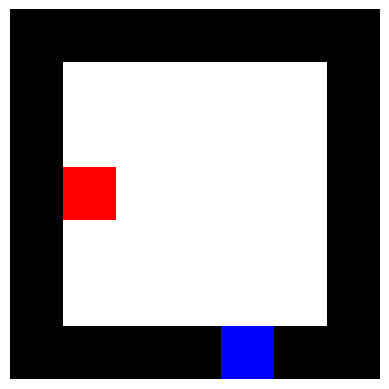

Episode: 1048575 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6882 
    SnakeLength: 1.131103515625 
    Eplsilon: 0.31539292391554813 
    Learning Rate: 0.1
    


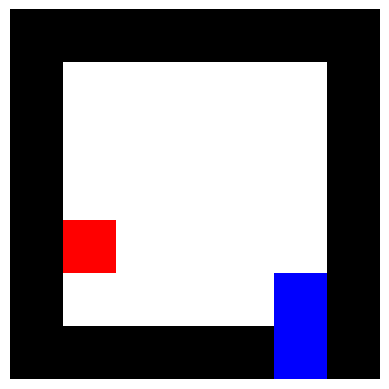

Episode: 1052671 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6850 
    SnakeLength: 1.128662109375 
    Eplsilon: 0.31410371595489717 
    Learning Rate: 0.1
    


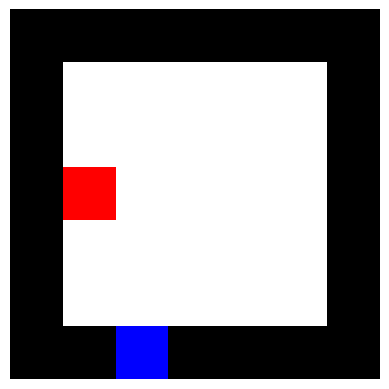

Episode: 1056767 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6971 
    SnakeLength: 1.122802734375 
    Eplsilon: 0.3128197777927706 
    Learning Rate: 0.1
    


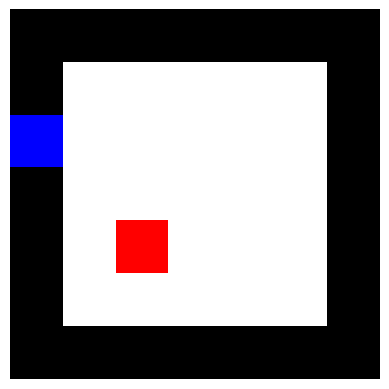

Episode: 1060863 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.6828 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.31154108788821167 
    Learning Rate: 0.1
    


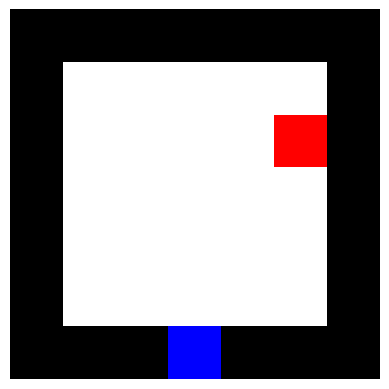

Episode: 1064959 
    Avg Iterations (last 4096 episodes): 4.35 
    Avg Score (last 4096): 0.5974 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.31026762478831227 
    Learning Rate: 0.1
    


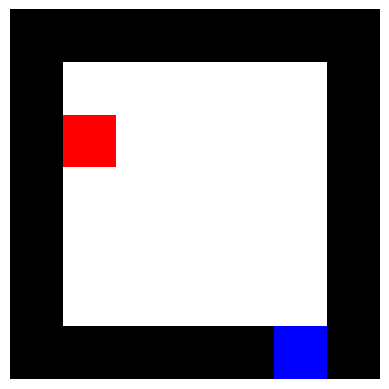

Episode: 1069055 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.7139 
    SnakeLength: 1.12939453125 
    Eplsilon: 0.30899936712785453 
    Learning Rate: 0.1
    


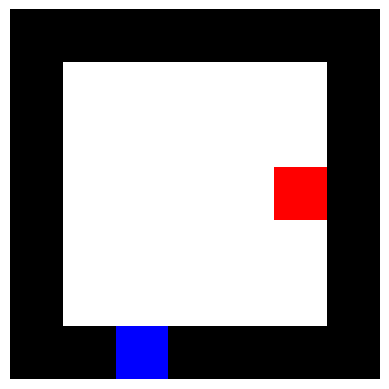

Episode: 1073151 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.6932 
    SnakeLength: 1.130859375 
    Eplsilon: 0.30773629362895677 
    Learning Rate: 0.1
    


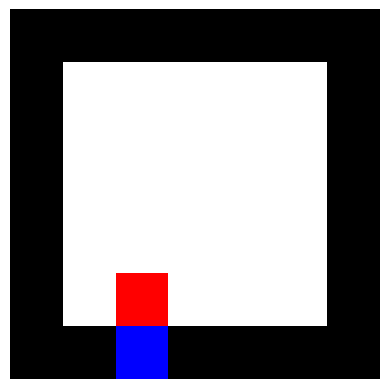

Episode: 1077247 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6359 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.3064783831007098 
    Learning Rate: 0.1
    


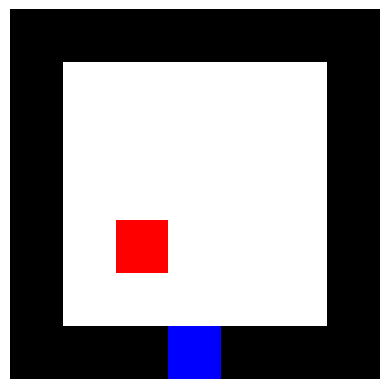

Episode: 1081343 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6996 
    SnakeLength: 1.130126953125 
    Eplsilon: 0.305225614438826 
    Learning Rate: 0.1
    


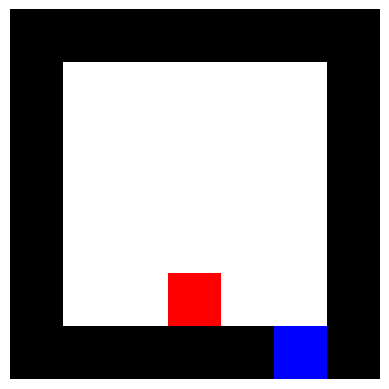

Episode: 1085439 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.6943 
    SnakeLength: 1.123779296875 
    Eplsilon: 0.3039779666252846 
    Learning Rate: 0.1
    


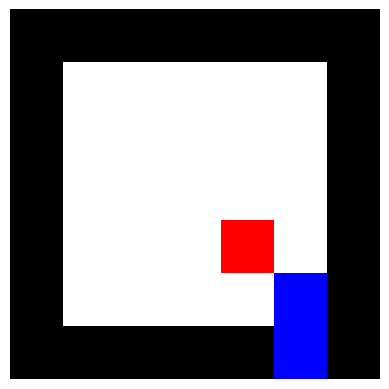

Episode: 1089535 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6806 
    SnakeLength: 1.1279296875 
    Eplsilon: 0.3027354187279802 
    Learning Rate: 0.1
    


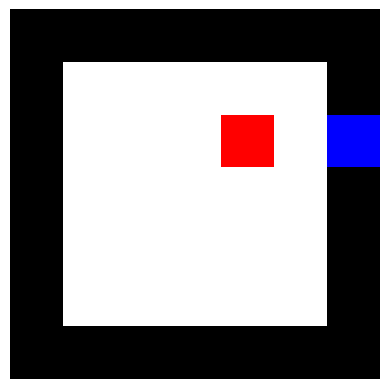

Episode: 1093631 
    Avg Iterations (last 4096 episodes): 4.35 
    Avg Score (last 4096): 0.6084 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.3014979499003676 
    Learning Rate: 0.1
    


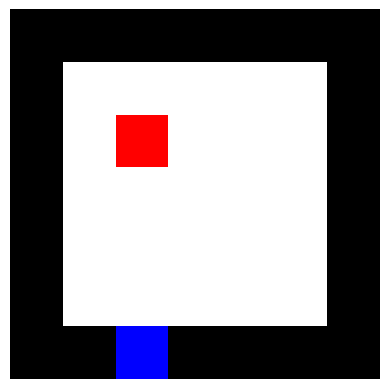

Episode: 1097727 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7154 
    SnakeLength: 1.13037109375 
    Eplsilon: 0.30026553938111183 
    Learning Rate: 0.1
    


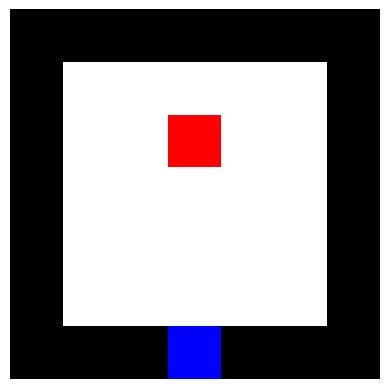

Episode: 1101823 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6513 
    SnakeLength: 1.128662109375 
    Eplsilon: 0.29903816649375103 
    Learning Rate: 0.1
    


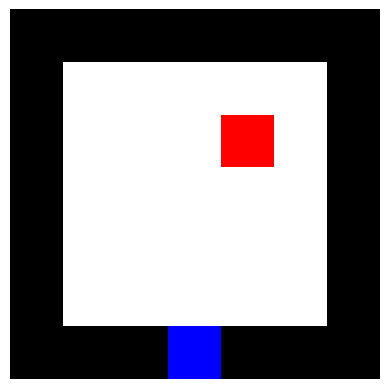

Episode: 1105919 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6755 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.2978158106463329 
    Learning Rate: 0.1
    


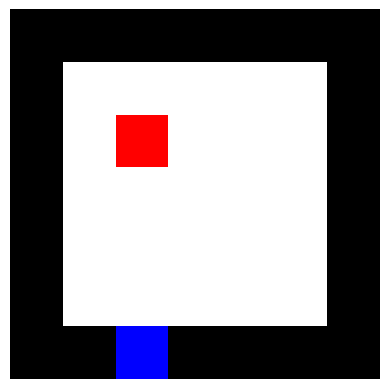

Episode: 1110015 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.7045 
    SnakeLength: 1.1318359375 
    Eplsilon: 0.29659845133108026 
    Learning Rate: 0.1
    


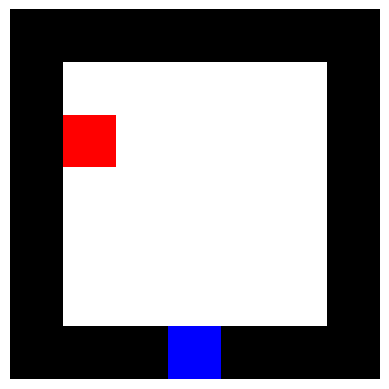

Episode: 1114111 
    Avg Iterations (last 4096 episodes): 4.39 
    Avg Score (last 4096): 0.6258 
    SnakeLength: 1.127197265625 
    Eplsilon: 0.295386068124044 
    Learning Rate: 0.1
    


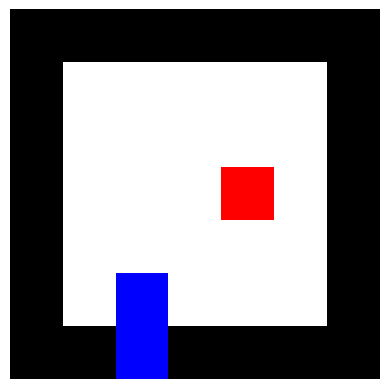

Episode: 1118207 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6796 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.2941786406847628 
    Learning Rate: 0.1
    


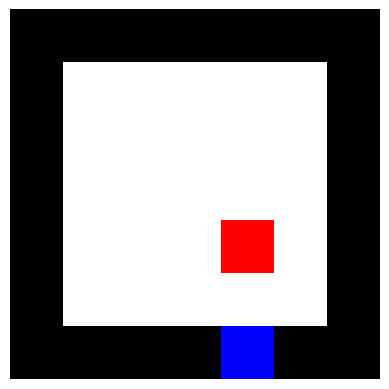

Episode: 1122303 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6857 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.2929761487559126 
    Learning Rate: 0.1
    


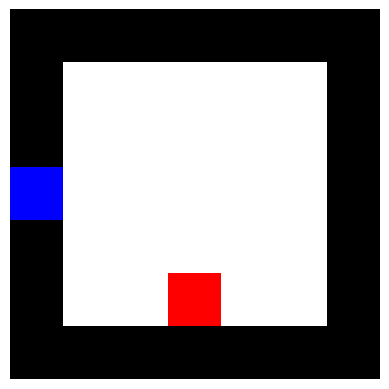

Episode: 1126399 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6617 
    SnakeLength: 1.12744140625 
    Eplsilon: 0.2917785721629825 
    Learning Rate: 0.1
    


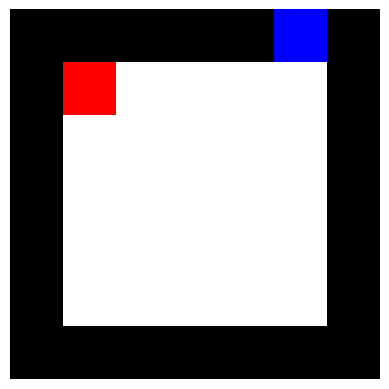

Episode: 1130495 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7141 
    SnakeLength: 1.128173828125 
    Eplsilon: 0.2905858908139206 
    Learning Rate: 0.1
    


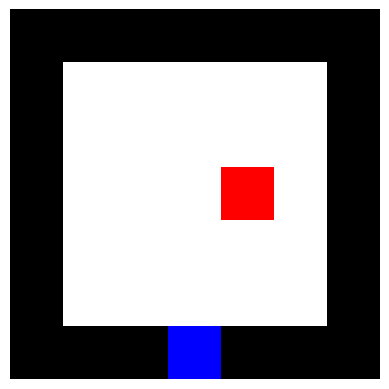

Episode: 1134591 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6601 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.2893980846988085 
    Learning Rate: 0.1
    


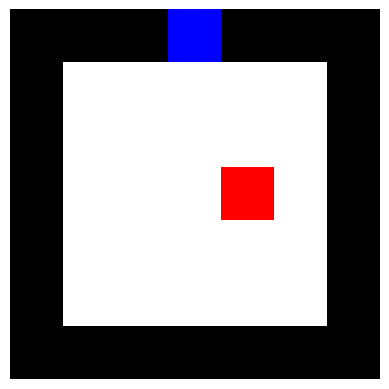

Episode: 1138687 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6544 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.28821513388951564 
    Learning Rate: 0.1
    


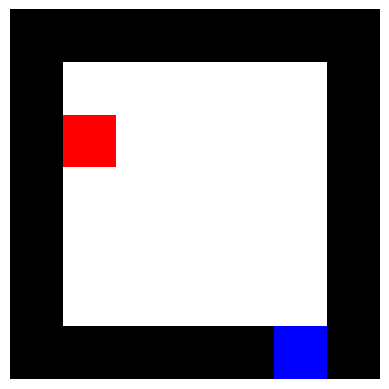

Episode: 1142783 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6668 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.28703701853937613 
    Learning Rate: 0.1
    


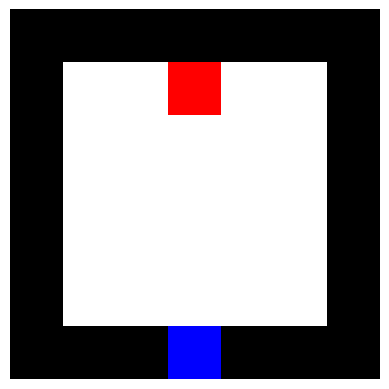

Episode: 1146879 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7029 
    SnakeLength: 1.115234375 
    Eplsilon: 0.28586371888284196 
    Learning Rate: 0.1
    


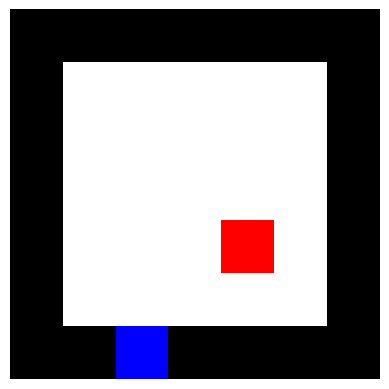

Episode: 1150975 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6297 
    SnakeLength: 1.116943359375 
    Eplsilon: 0.2846952152351683 
    Learning Rate: 0.1
    


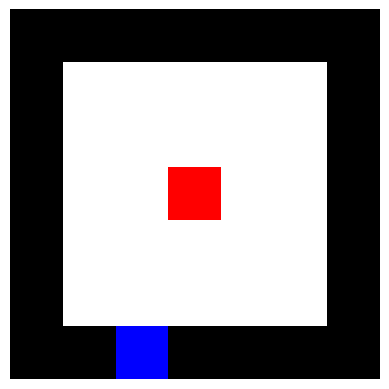

Episode: 1155071 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7099 
    SnakeLength: 1.12451171875 
    Eplsilon: 0.2835314879920697 
    Learning Rate: 0.1
    


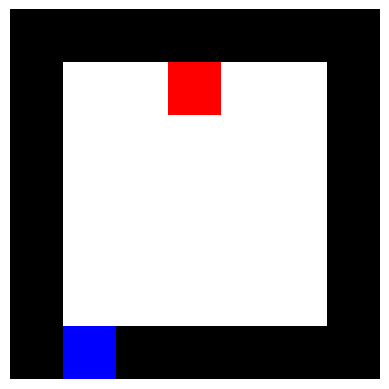

Episode: 1159167 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6864 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.2823725176293954 
    Learning Rate: 0.1
    


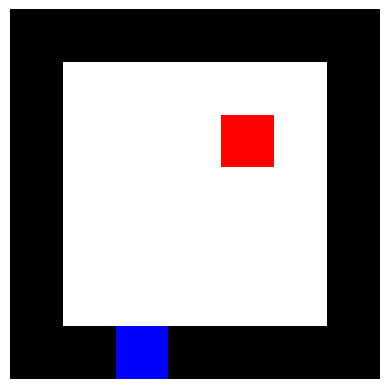

Episode: 1163263 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6690 
    SnakeLength: 1.125 
    Eplsilon: 0.28121828470280413 
    Learning Rate: 0.1
    


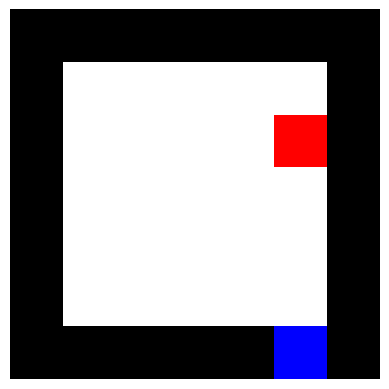

Episode: 1167359 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6566 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.280068769847432 
    Learning Rate: 0.1
    


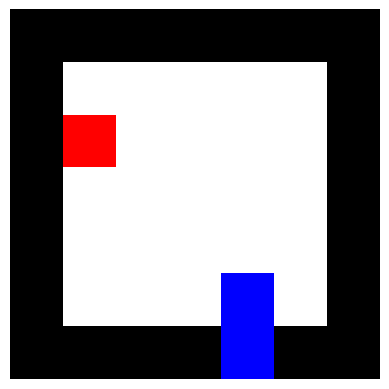

Episode: 1171455 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6799 
    SnakeLength: 1.123046875 
    Eplsilon: 0.2789239537775757 
    Learning Rate: 0.1
    


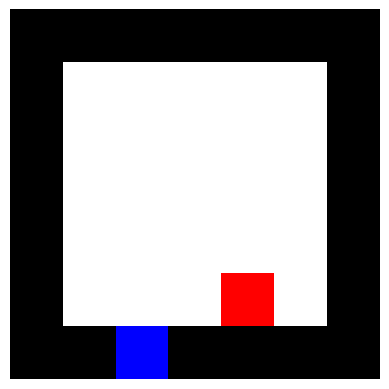

Episode: 1175551 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7216 
    SnakeLength: 1.140380859375 
    Eplsilon: 0.2777838172863634 
    Learning Rate: 0.1
    


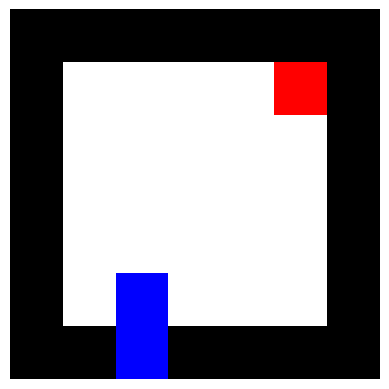

Episode: 1179647 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6247 
    SnakeLength: 1.12109375 
    Eplsilon: 0.2766483412454306 
    Learning Rate: 0.1
    


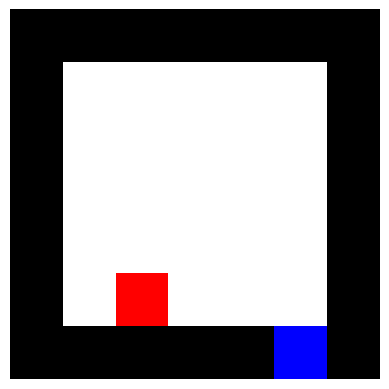

Episode: 1183743 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6790 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.27551750660460655 
    Learning Rate: 0.1
    


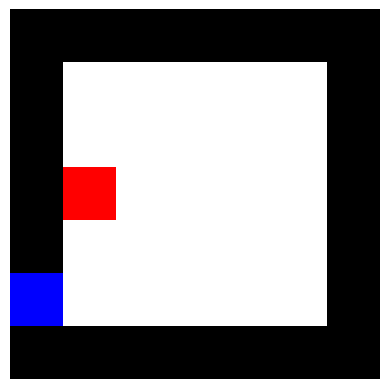

Episode: 1187839 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6320 
    SnakeLength: 1.123779296875 
    Eplsilon: 0.2743912943915875 
    Learning Rate: 0.1
    


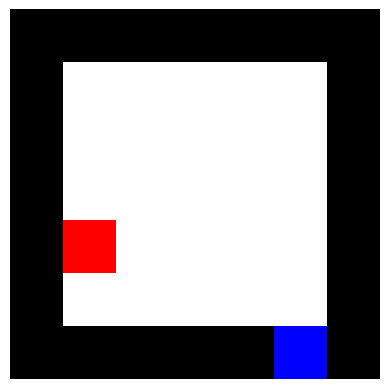

Episode: 1191935 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7150 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.273269685711621 
    Learning Rate: 0.1
    


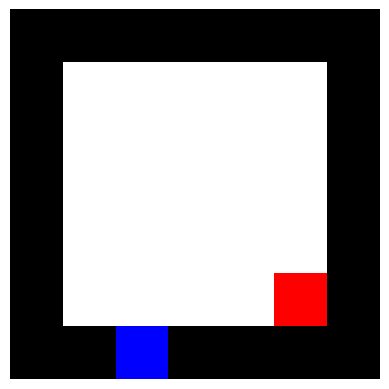

Episode: 1196031 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6414 
    SnakeLength: 1.12646484375 
    Eplsilon: 0.27215266174719394 
    Learning Rate: 0.1
    


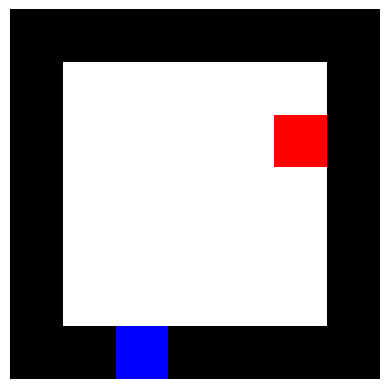

Episode: 1200127 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6725 
    SnakeLength: 1.126708984375 
    Eplsilon: 0.27104020375770715 
    Learning Rate: 0.1
    


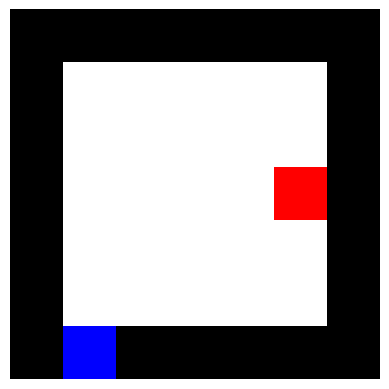

Episode: 1204223 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7181 
    SnakeLength: 1.127685546875 
    Eplsilon: 0.2699322930791697 
    Learning Rate: 0.1
    


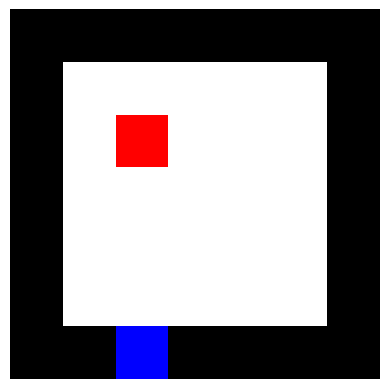

Episode: 1208319 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6492 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.2688289111238769 
    Learning Rate: 0.1
    


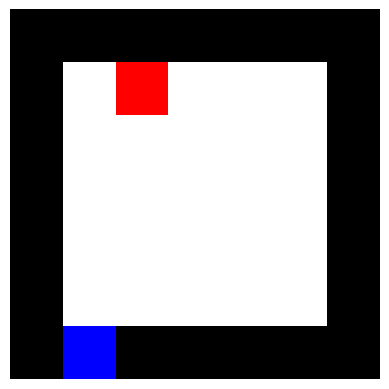

Episode: 1212415 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.7190 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.2677300393801097 
    Learning Rate: 0.1
    


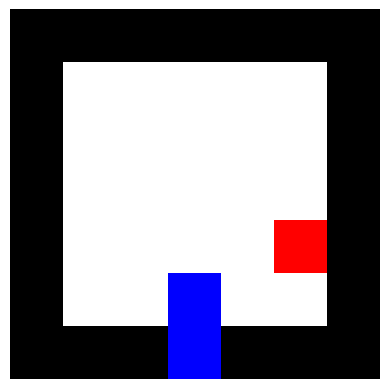

Episode: 1216511 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7219 
    SnakeLength: 1.123291015625 
    Eplsilon: 0.26663565941181644 
    Learning Rate: 0.1
    


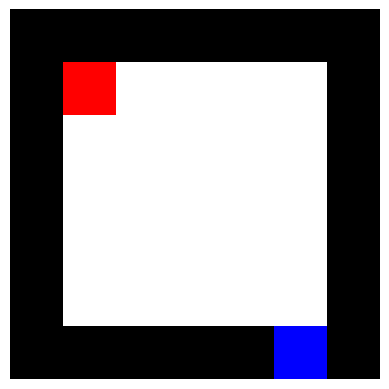

Episode: 1220607 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6761 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.26554575285830423 
    Learning Rate: 0.1
    


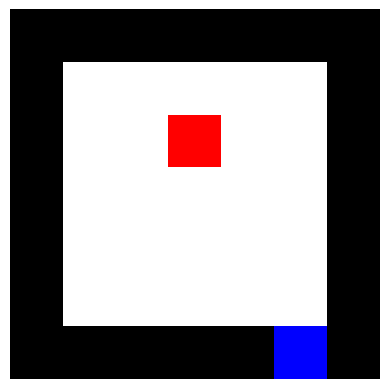

Episode: 1224703 
    Avg Iterations (last 4096 episodes): 4.40 
    Avg Score (last 4096): 0.6276 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.26446030143392735 
    Learning Rate: 0.1
    


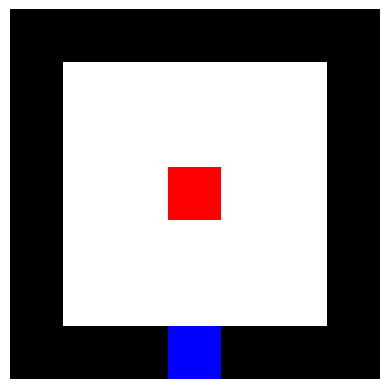

Episode: 1228799 
    Avg Iterations (last 4096 episodes): 4.40 
    Avg Score (last 4096): 0.6021 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.26337928692779305 
    Learning Rate: 0.1
    


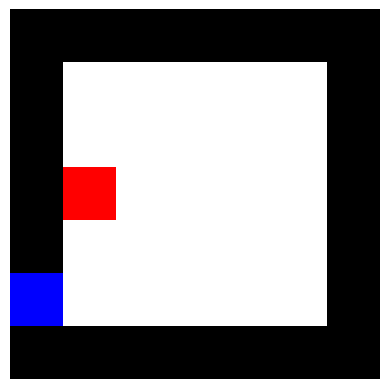

Episode: 1232895 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6647 
    SnakeLength: 1.124755859375 
    Eplsilon: 0.26230269120344174 
    Learning Rate: 0.1
    


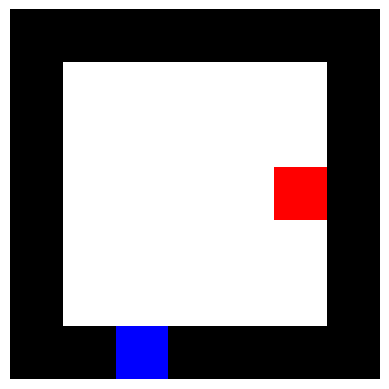

Episode: 1236991 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6529 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.26123049619855254 
    Learning Rate: 0.1
    


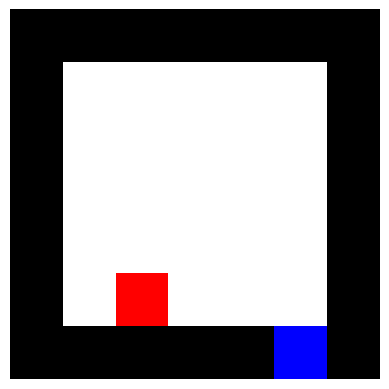

Episode: 1241087 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.7386 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.26016268392463227 
    Learning Rate: 0.1
    


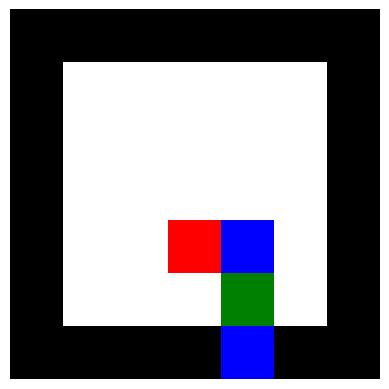

Episode: 1245183 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6493 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.25909923646672445 
    Learning Rate: 0.1
    


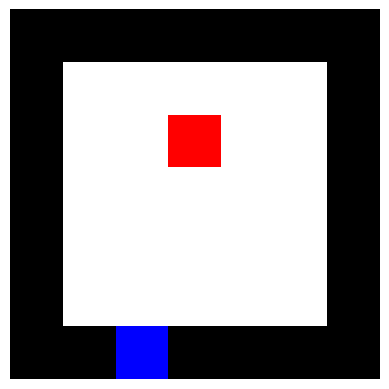

Episode: 1249279 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6486 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.25804013598309655 
    Learning Rate: 0.1
    


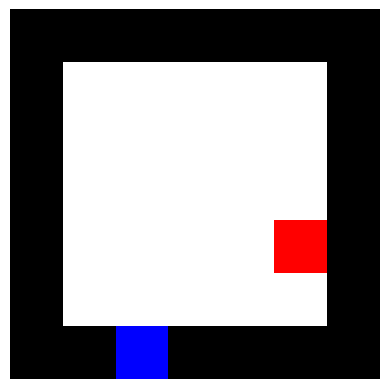

Episode: 1253375 
    Avg Iterations (last 4096 episodes): 4.42 
    Avg Score (last 4096): 0.6657 
    SnakeLength: 1.130126953125 
    Eplsilon: 0.25698536470494926 
    Learning Rate: 0.1
    


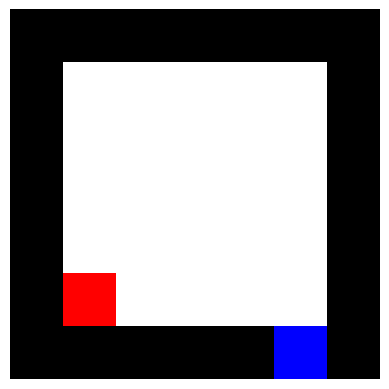

Episode: 1257471 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6601 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.2559349049361138 
    Learning Rate: 0.1
    


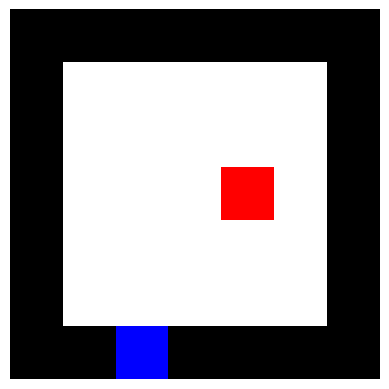

Episode: 1261567 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6660 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.2548887390527579 
    Learning Rate: 0.1
    


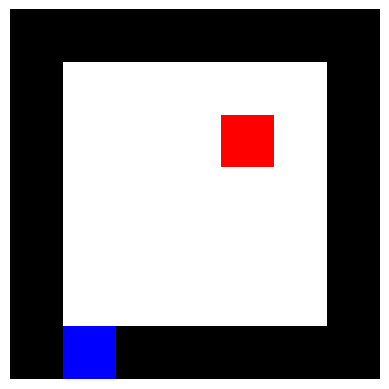

Episode: 1265663 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6265 
    SnakeLength: 1.126708984375 
    Eplsilon: 0.2538468495030895 
    Learning Rate: 0.1
    


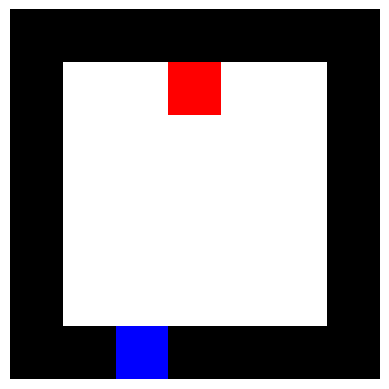

Episode: 1269759 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6729 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.2528092188070589 
    Learning Rate: 0.1
    


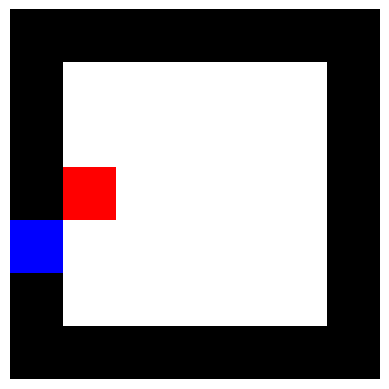

Episode: 1273855 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6599 
    SnakeLength: 1.119873046875 
    Eplsilon: 0.2517758295560703 
    Learning Rate: 0.1
    


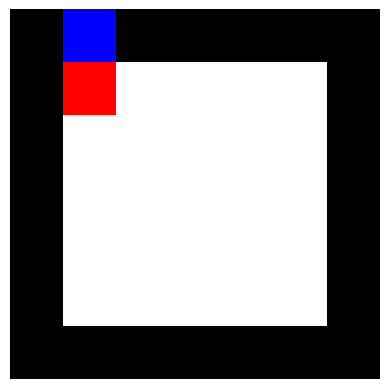

Episode: 1277951 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6357 
    SnakeLength: 1.128662109375 
    Eplsilon: 0.2507466644126881 
    Learning Rate: 0.1
    


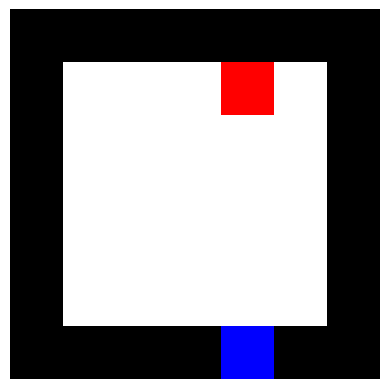

Episode: 1282047 
    Avg Iterations (last 4096 episodes): 4.43 
    Avg Score (last 4096): 0.6378 
    SnakeLength: 1.130859375 
    Eplsilon: 0.24972170611034458 
    Learning Rate: 0.1
    


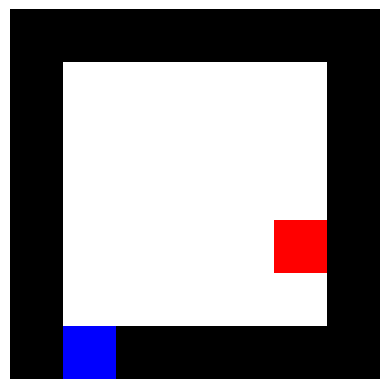

Episode: 1286143 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.7017 
    SnakeLength: 1.133544921875 
    Eplsilon: 0.2487009374530509 
    Learning Rate: 0.1
    


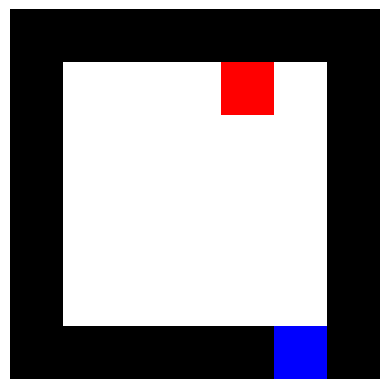

Episode: 1290239 
    Avg Iterations (last 4096 episodes): 4.38 
    Avg Score (last 4096): 0.6173 
    SnakeLength: 1.126953125 
    Eplsilon: 0.24768434131511133 
    Learning Rate: 0.1
    


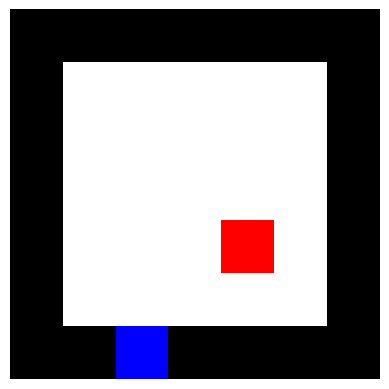

Episode: 1294335 
    Avg Iterations (last 4096 episodes): 4.38 
    Avg Score (last 4096): 0.6163 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.24667190064083133 
    Learning Rate: 0.1
    


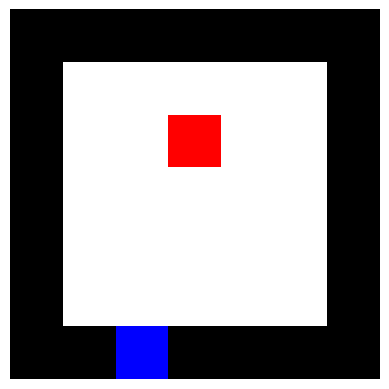

Episode: 1298431 
    Avg Iterations (last 4096 episodes): 4.43 
    Avg Score (last 4096): 0.6390 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.24566359844423327 
    Learning Rate: 0.1
    


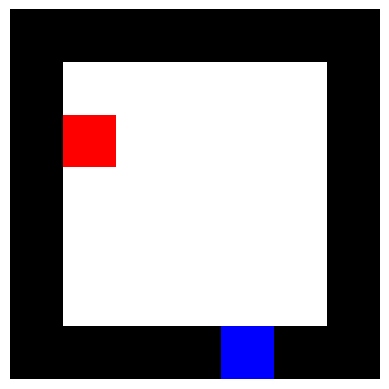

Episode: 1302527 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6413 
    SnakeLength: 1.12548828125 
    Eplsilon: 0.24465941780877412 
    Learning Rate: 0.1
    


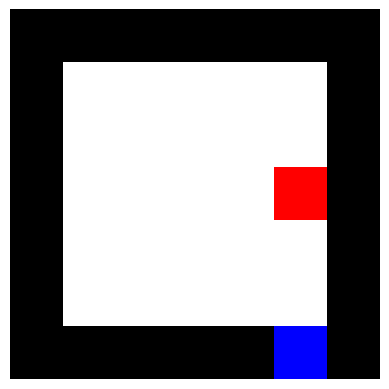

Episode: 1306623 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6461 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.24365934188705793 
    Learning Rate: 0.1
    


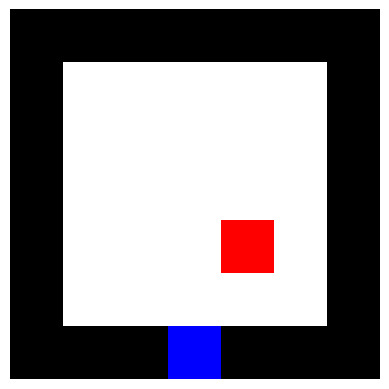

Episode: 1310719 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6602 
    SnakeLength: 1.12841796875 
    Eplsilon: 0.24266335390055457 
    Learning Rate: 0.1
    


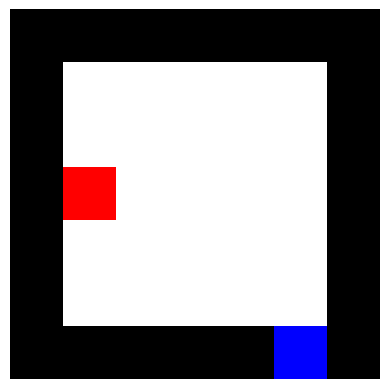

Episode: 1314815 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6423 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.2416714371393178 
    Learning Rate: 0.1
    


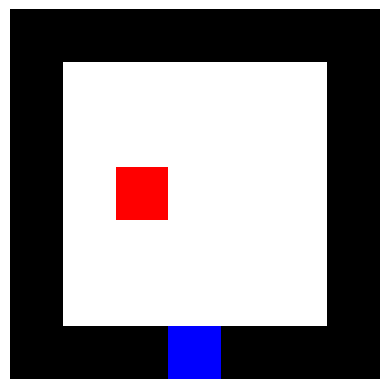

Episode: 1318911 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6804 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.24068357496170673 
    Learning Rate: 0.1
    


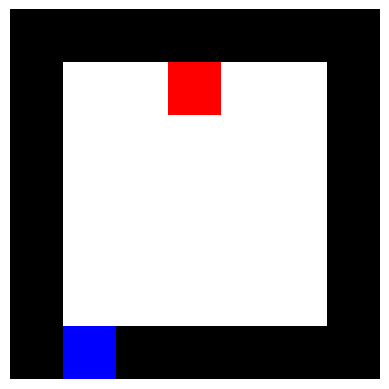

Episode: 1323007 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6321 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.2396997507941041 
    Learning Rate: 0.1
    


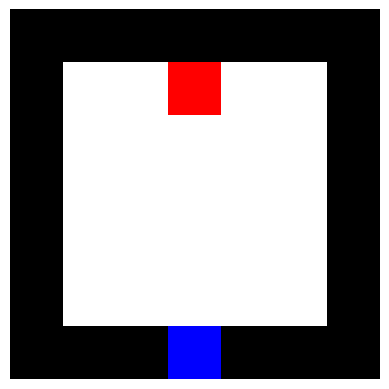

Episode: 1327103 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6139 
    SnakeLength: 1.109375 
    Eplsilon: 0.2387199481306407 
    Learning Rate: 0.1
    


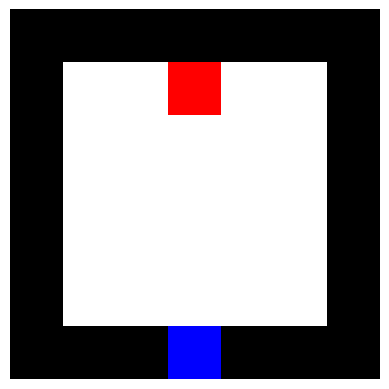

Episode: 1331199 
    Avg Iterations (last 4096 episodes): 4.40 
    Avg Score (last 4096): 0.6146 
    SnakeLength: 1.12109375 
    Eplsilon: 0.2377441505329149 
    Learning Rate: 0.1
    


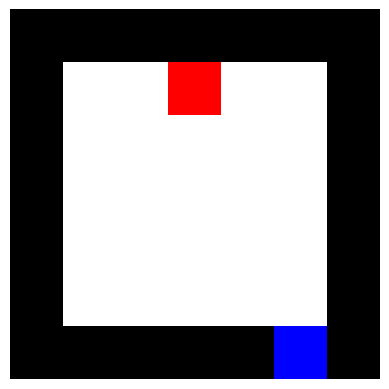

Episode: 1335295 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6690 
    SnakeLength: 1.1240234375 
    Eplsilon: 0.236772341629721 
    Learning Rate: 0.1
    


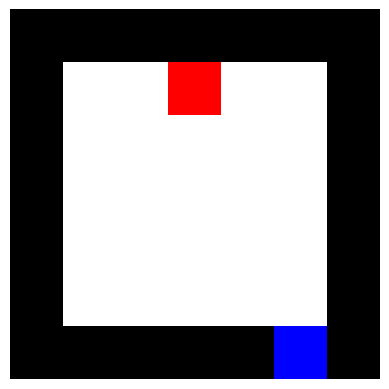

Episode: 1339391 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6906 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.23580450511677123 
    Learning Rate: 0.1
    


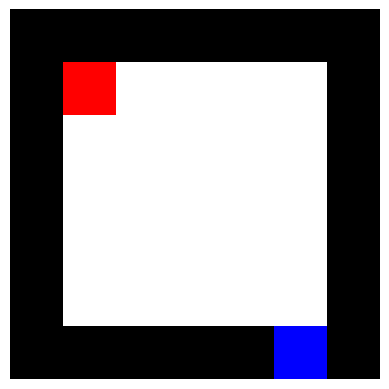

Episode: 1343487 
    Avg Iterations (last 4096 episodes): 4.42 
    Avg Score (last 4096): 0.6386 
    SnakeLength: 1.122314453125 
    Eplsilon: 0.23484062475642553 
    Learning Rate: 0.1
    


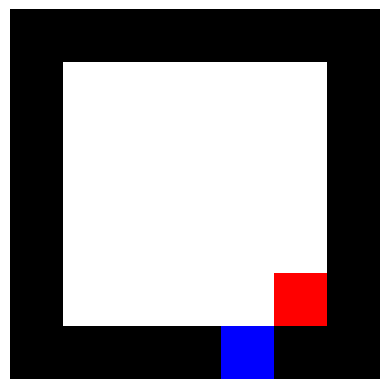

Episode: 1347583 
    Avg Iterations (last 4096 episodes): 4.37 
    Avg Score (last 4096): 0.6181 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.23388068437741563 
    Learning Rate: 0.1
    


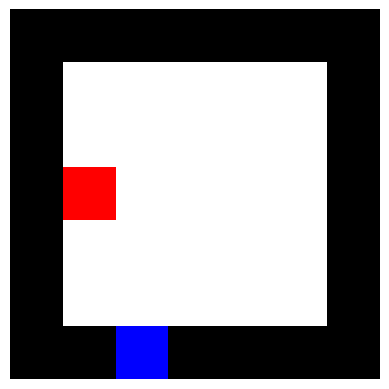

Episode: 1351679 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6394 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.23292466787457614 
    Learning Rate: 0.1
    


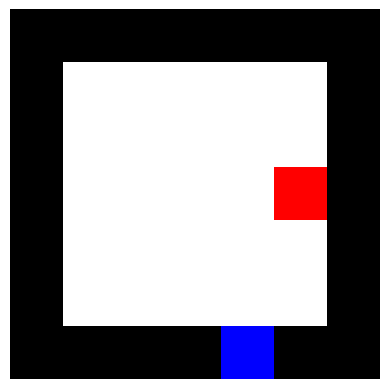

Episode: 1355775 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6537 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.23197255920857213 
    Learning Rate: 0.1
    


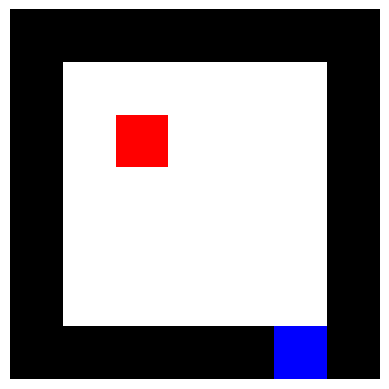

Episode: 1359871 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6616 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.23102434240563433 
    Learning Rate: 0.1
    


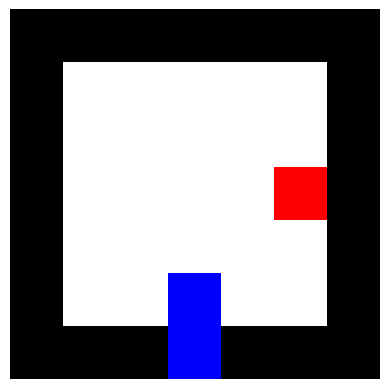

Episode: 1363967 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6684 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.23008000155728414 
    Learning Rate: 0.1
    


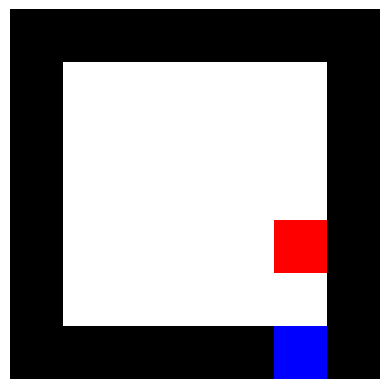

Episode: 1368063 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6617 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.22913952082007516 
    Learning Rate: 0.1
    


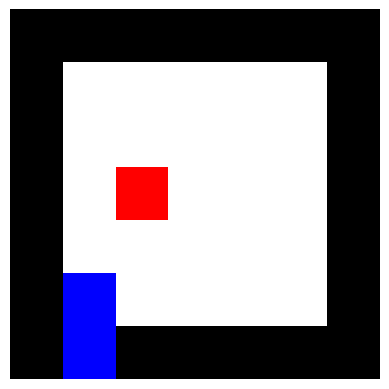

Episode: 1372159 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6482 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.22820288441532022 
    Learning Rate: 0.1
    


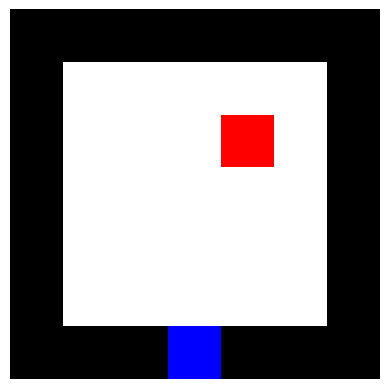

Episode: 1376255 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.6997 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.22727007662883134 
    Learning Rate: 0.1
    


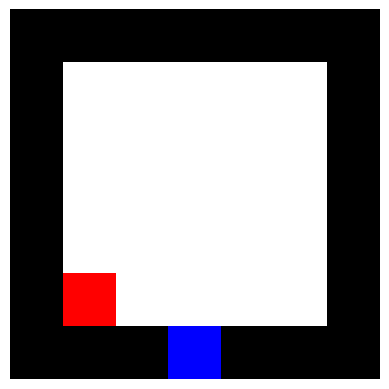

Episode: 1380351 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.7030 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.22634108181065213 
    Learning Rate: 0.1
    


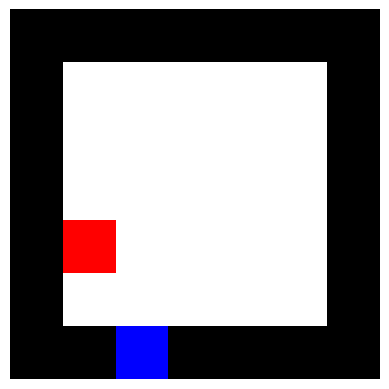

Episode: 1384447 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6201 
    SnakeLength: 1.119873046875 
    Eplsilon: 0.22541588437479906 
    Learning Rate: 0.1
    


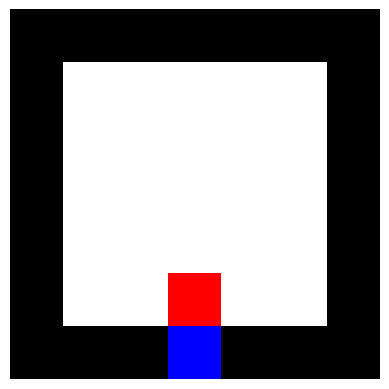

Episode: 1388543 
    Avg Iterations (last 4096 episodes): 4.43 
    Avg Score (last 4096): 0.6512 
    SnakeLength: 1.12451171875 
    Eplsilon: 0.22449446879899657 
    Learning Rate: 0.1
    


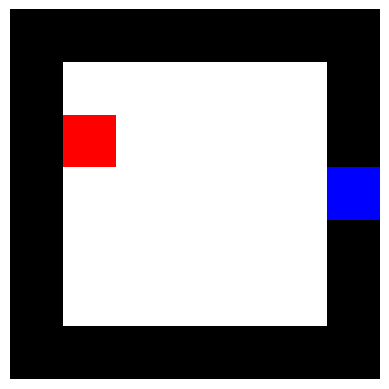

Episode: 1392639 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6862 
    SnakeLength: 1.124267578125 
    Eplsilon: 0.22357681962442075 
    Learning Rate: 0.1
    


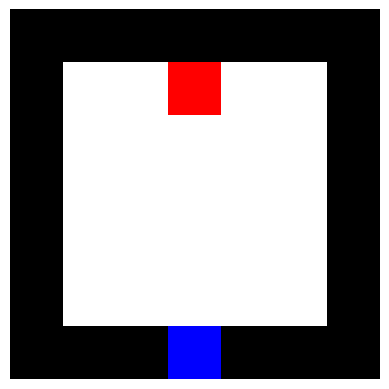

Episode: 1396735 
    Avg Iterations (last 4096 episodes): 4.46 
    Avg Score (last 4096): 0.6384 
    SnakeLength: 1.1171875 
    Eplsilon: 0.22266292145543692 
    Learning Rate: 0.1
    


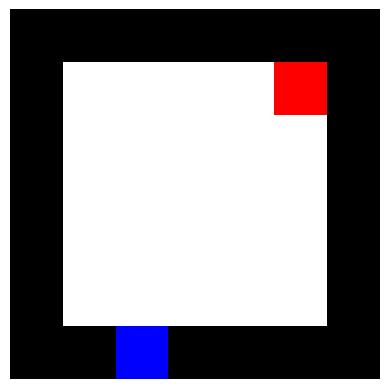

Episode: 1400831 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.7015 
    SnakeLength: 1.12353515625 
    Eplsilon: 0.22175275895933952 
    Learning Rate: 0.1
    


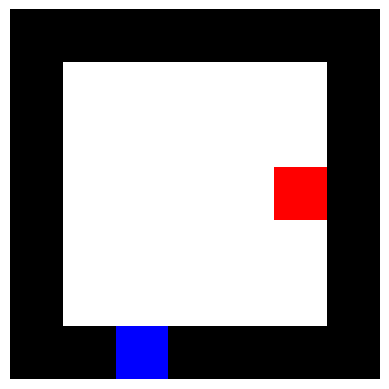

Episode: 1404927 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.6647 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.22084631686610137 
    Learning Rate: 0.1
    


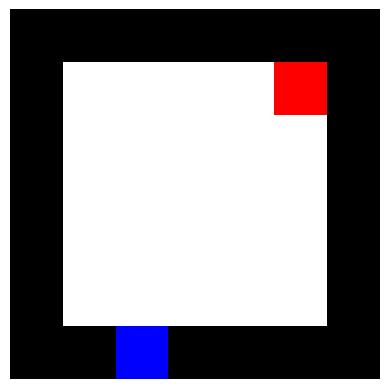

Episode: 1409023 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6788 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.2199435799681075 
    Learning Rate: 0.1
    


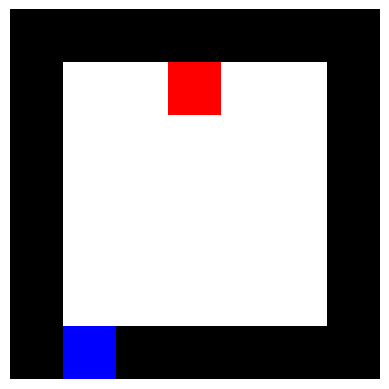

Episode: 1413119 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6821 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.21904453311991243 
    Learning Rate: 0.1
    


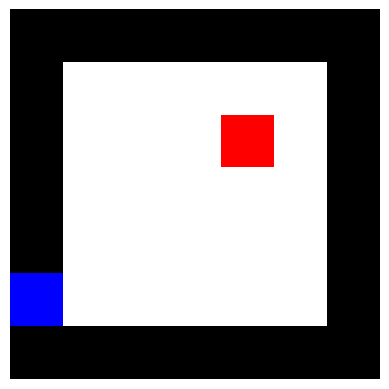

Episode: 1417215 
    Avg Iterations (last 4096 episodes): 4.40 
    Avg Score (last 4096): 0.6102 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.21814916123797673 
    Learning Rate: 0.1
    


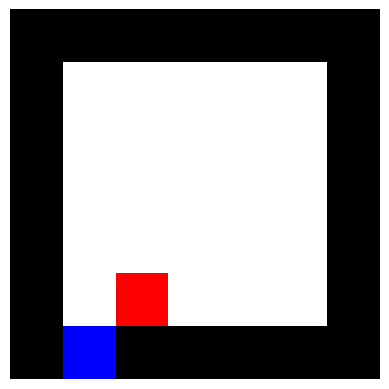

Episode: 1421311 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6555 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.2172574493004164 
    Learning Rate: 0.1
    


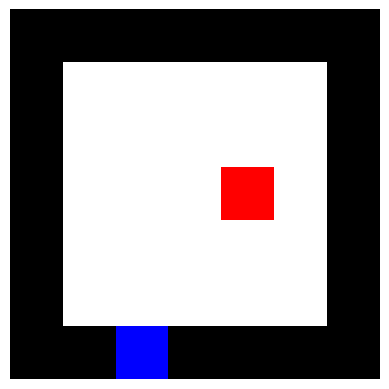

Episode: 1425407 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7380 
    SnakeLength: 1.1279296875 
    Eplsilon: 0.2163693823467523 
    Learning Rate: 0.1
    


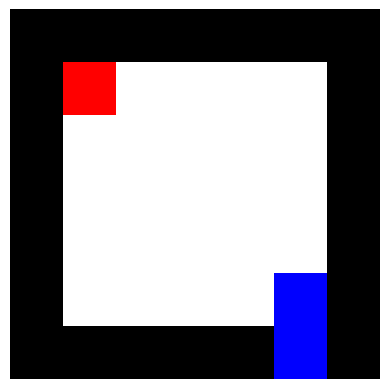

Episode: 1429503 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6449 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.21548494547765584 
    Learning Rate: 0.1
    


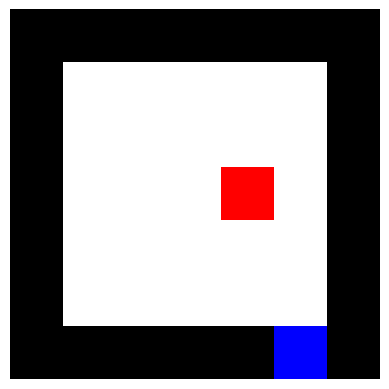

Episode: 1433599 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.6739 
    SnakeLength: 1.115234375 
    Eplsilon: 0.21460412385470487 
    Learning Rate: 0.1
    


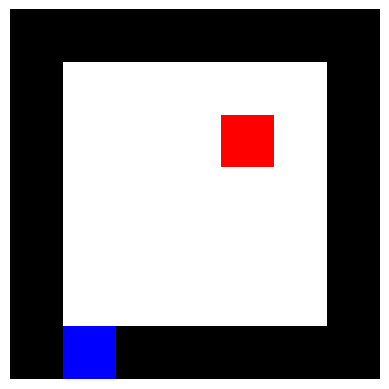

Episode: 1437695 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7091 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.21372690270012878 
    Learning Rate: 0.1
    


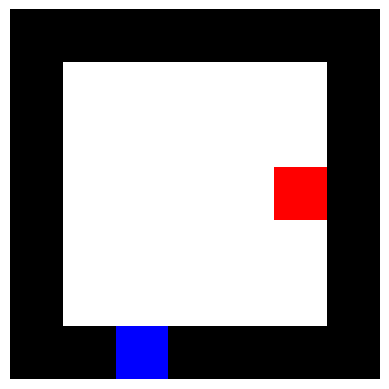

Episode: 1441791 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6905 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.21285326729656479 
    Learning Rate: 0.1
    


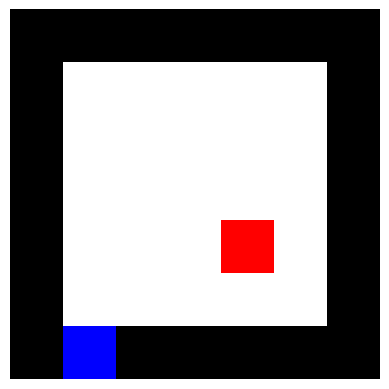

Episode: 1445887 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7304 
    SnakeLength: 1.13037109375 
    Eplsilon: 0.21198320298680556 
    Learning Rate: 0.1
    


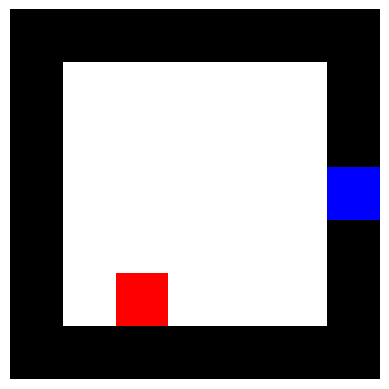

Episode: 1449983 
    Avg Iterations (last 4096 episodes): 4.33 
    Avg Score (last 4096): 0.5930 
    SnakeLength: 1.126708984375 
    Eplsilon: 0.21111669517356146 
    Learning Rate: 0.1
    


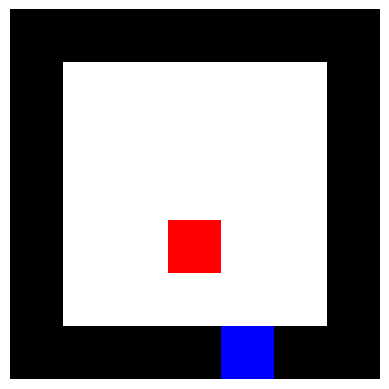

Episode: 1454079 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.7116 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.21025372931920577 
    Learning Rate: 0.1
    


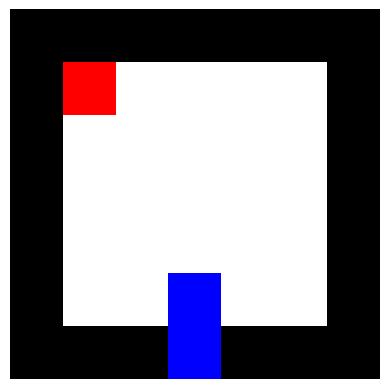

Episode: 1458175 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6527 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.20939429094554213 
    Learning Rate: 0.1
    


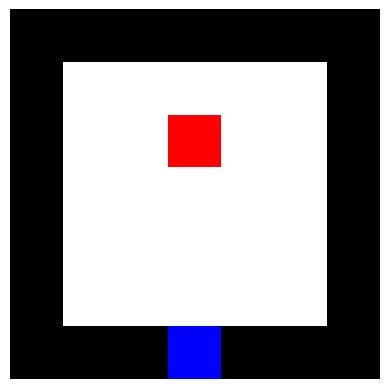

Episode: 1462271 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6912 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.20853836563355121 
    Learning Rate: 0.1
    


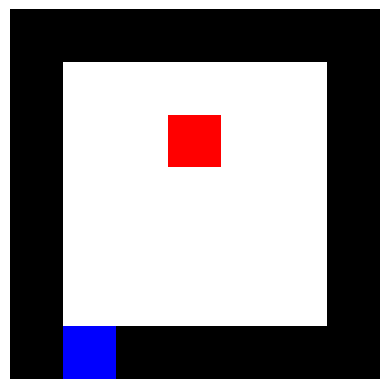

Episode: 1466367 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6536 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.20768593902315627 
    Learning Rate: 0.1
    


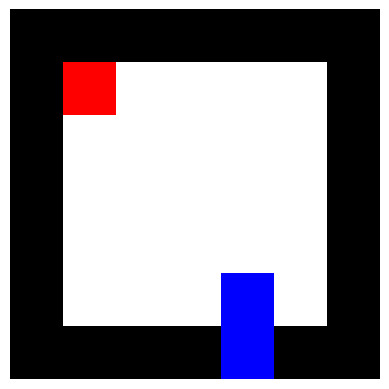

Episode: 1470463 
    Avg Iterations (last 4096 episodes): 4.39 
    Avg Score (last 4096): 0.6124 
    SnakeLength: 1.119140625 
    Eplsilon: 0.206836996812976 
    Learning Rate: 0.1
    


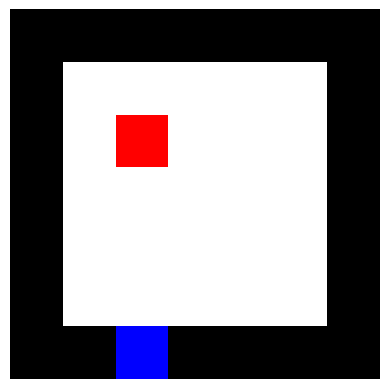

Episode: 1474559 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6798 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.20599152476008942 
    Learning Rate: 0.1
    


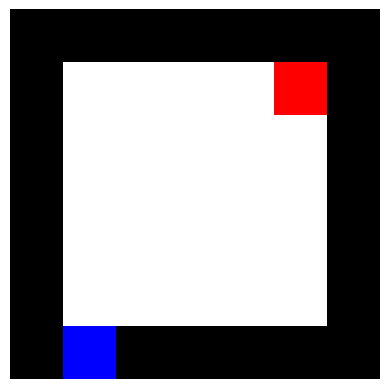

Episode: 1478655 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7096 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.20514950867979584 
    Learning Rate: 0.1
    


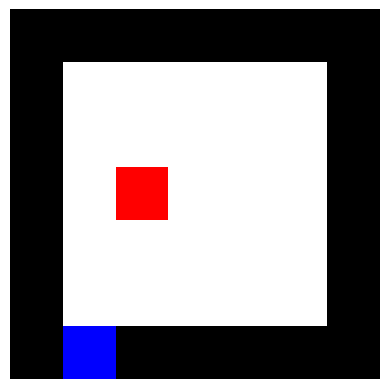

Episode: 1482751 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6582 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.20431093444537612 
    Learning Rate: 0.1
    


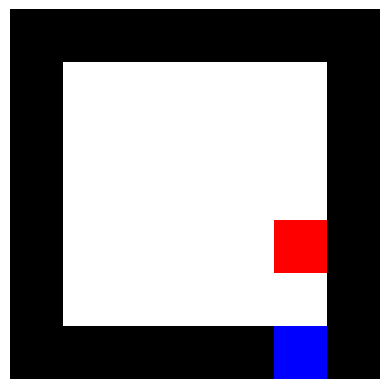

Episode: 1486847 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.6920 
    SnakeLength: 1.129638671875 
    Eplsilon: 0.20347578798785562 
    Learning Rate: 0.1
    


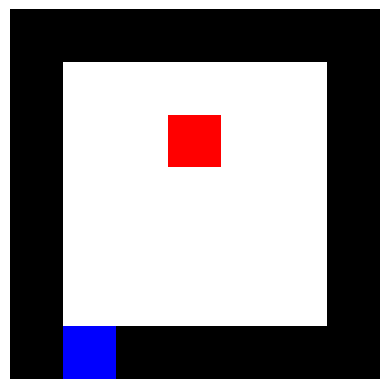

Episode: 1490943 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6645 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.20264405529576637 
    Learning Rate: 0.1
    


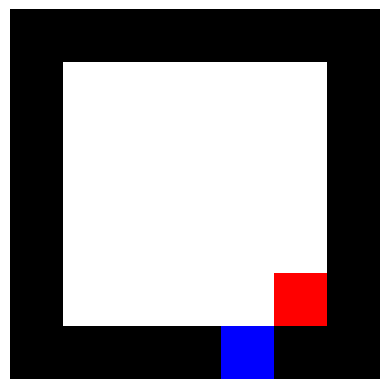

Episode: 1495039 
    Avg Iterations (last 4096 episodes): 4.39 
    Avg Score (last 4096): 0.6031 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.20181572241491785 
    Learning Rate: 0.1
    


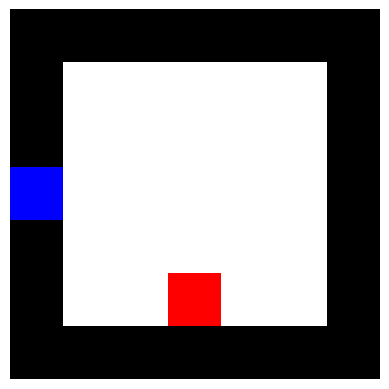

Episode: 1499135 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6250 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.2009907754481571 
    Learning Rate: 0.1
    


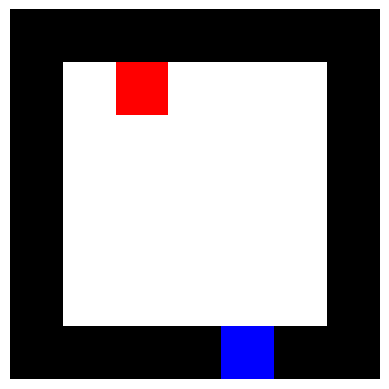

Episode: 1503231 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6150 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.20016920055513635 
    Learning Rate: 0.1
    


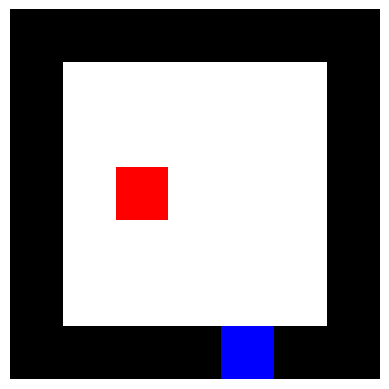

Episode: 1507327 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6328 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.19935098395208276 
    Learning Rate: 0.1
    


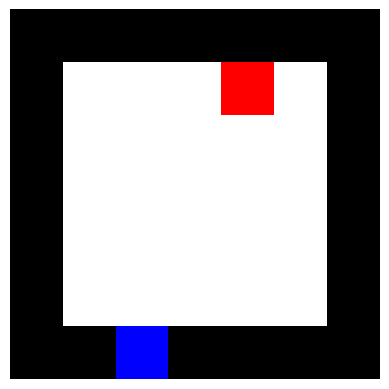

Episode: 1511423 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.6786 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.19853611191156798 
    Learning Rate: 0.1
    


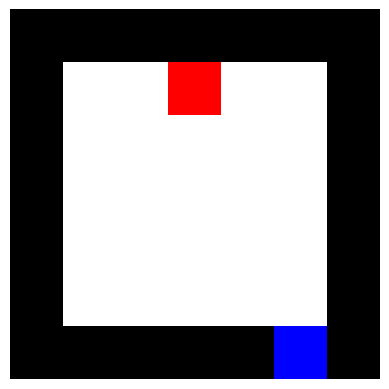

Episode: 1515519 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6484 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.197724570762274 
    Learning Rate: 0.1
    


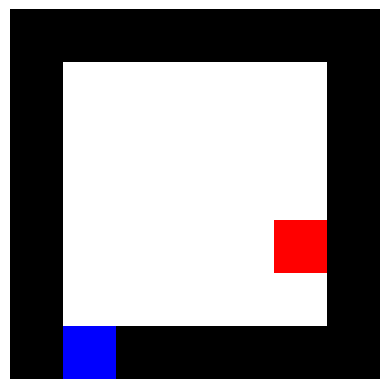

Episode: 1519615 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.7134 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.19691634688876866 
    Learning Rate: 0.1
    


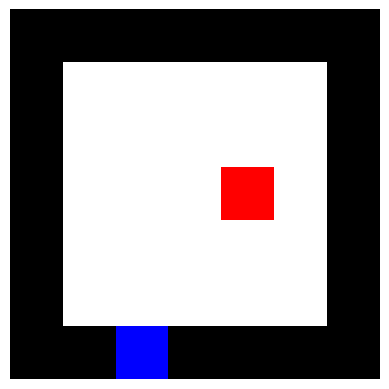

Episode: 1523711 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6590 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.19611142673127083 
    Learning Rate: 0.1
    


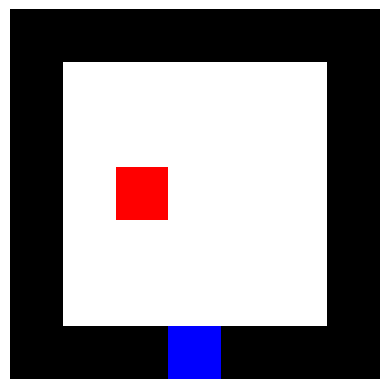

Episode: 1527807 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6554 
    SnakeLength: 1.123779296875 
    Eplsilon: 0.19530979678543128 
    Learning Rate: 0.1
    


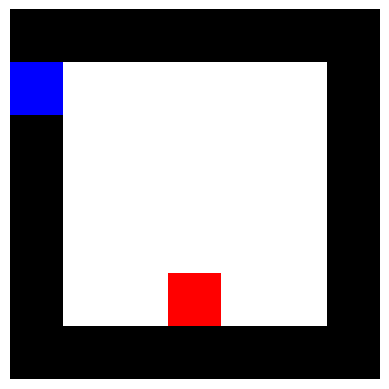

Episode: 1531903 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6728 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.19451144360209732 
    Learning Rate: 0.1
    


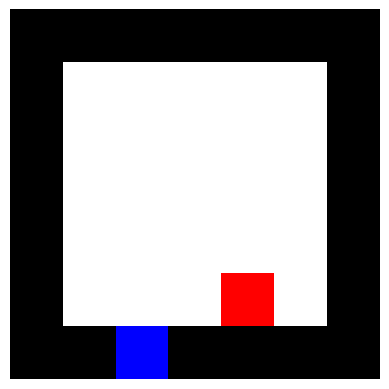

Episode: 1535999 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6760 
    SnakeLength: 1.11328125 
    Eplsilon: 0.19371635378709226 
    Learning Rate: 0.1
    


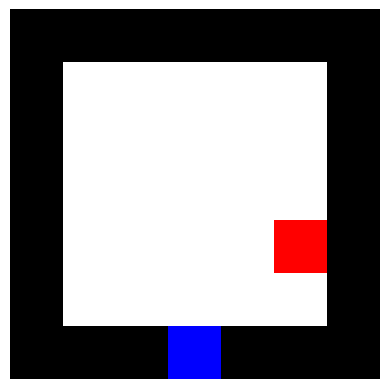

Episode: 1540095 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.7209 
    SnakeLength: 1.127197265625 
    Eplsilon: 0.19292451400099167 
    Learning Rate: 0.1
    


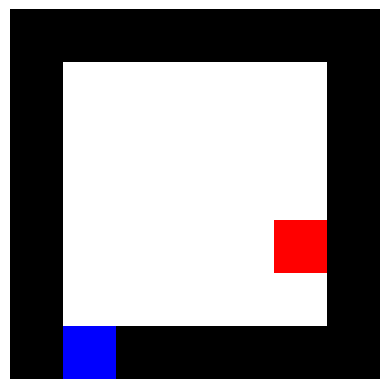

Episode: 1544191 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7338 
    SnakeLength: 1.124755859375 
    Eplsilon: 0.19213591095889662 
    Learning Rate: 0.1
    


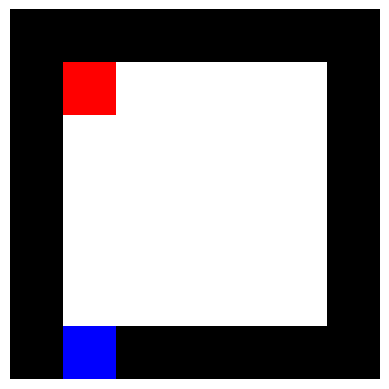

Episode: 1548287 
    Avg Iterations (last 4096 episodes): 4.46 
    Avg Score (last 4096): 0.6425 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.19135053143021144 
    Learning Rate: 0.1
    


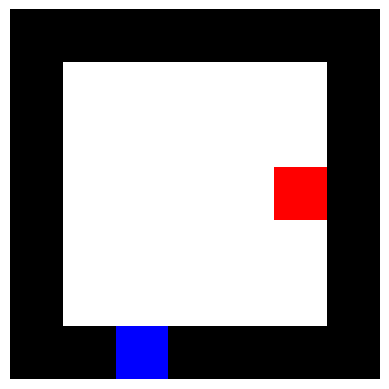

Episode: 1552383 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6476 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.1905683622384222 
    Learning Rate: 0.1
    


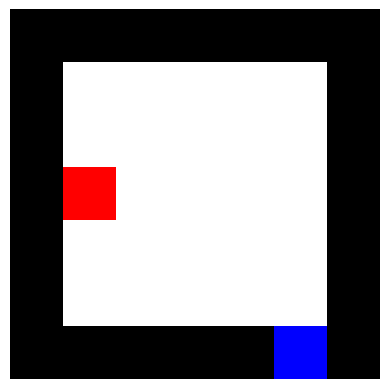

Episode: 1556479 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6349 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.18978939026087666 
    Learning Rate: 0.1
    


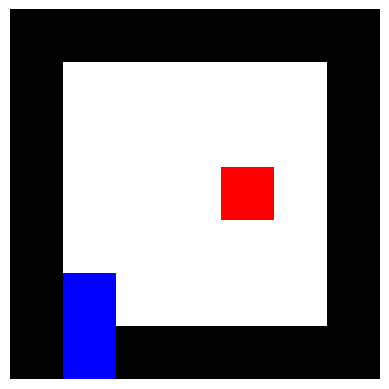

Episode: 1560575 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7242 
    SnakeLength: 1.123291015625 
    Eplsilon: 0.18901360242856255 
    Learning Rate: 0.1
    


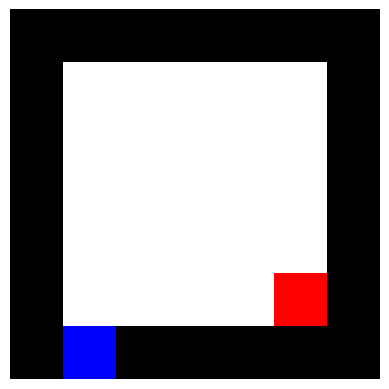

Episode: 1564671 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6609 
    SnakeLength: 1.109375 
    Eplsilon: 0.18824098572588827 
    Learning Rate: 0.1
    


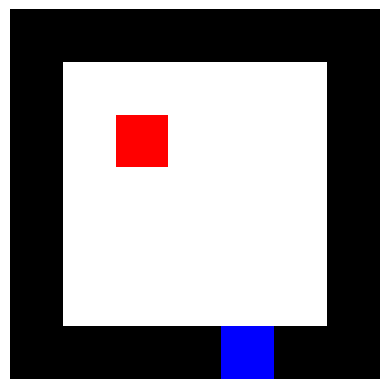

Episode: 1568767 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6954 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.1874715271904655 
    Learning Rate: 0.1
    


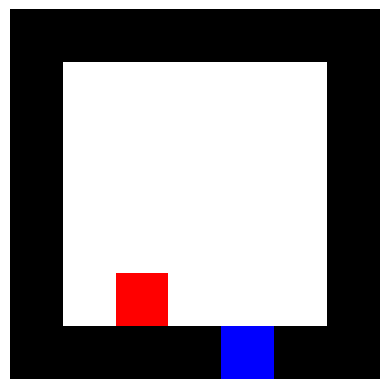

Episode: 1572863 
    Avg Iterations (last 4096 episodes): 4.53 
    Avg Score (last 4096): 0.6533 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.1867052139128921 
    Learning Rate: 0.1
    


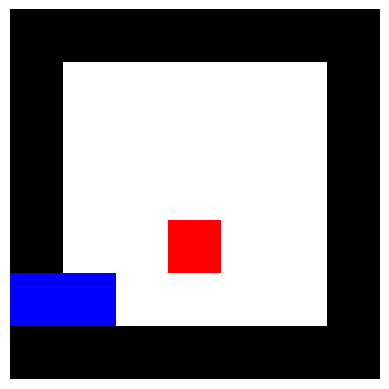

Episode: 1576959 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6598 
    SnakeLength: 1.1240234375 
    Eplsilon: 0.18594203303653223 
    Learning Rate: 0.1
    


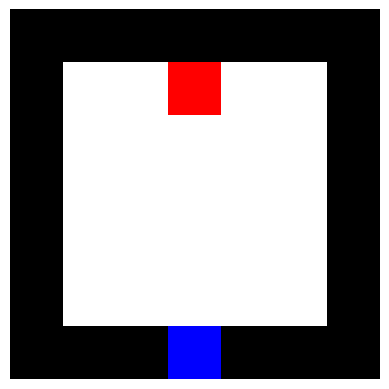

Episode: 1581055 
    Avg Iterations (last 4096 episodes): 4.50 
    Avg Score (last 4096): 0.6847 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.1851819717573041 
    Learning Rate: 0.1
    


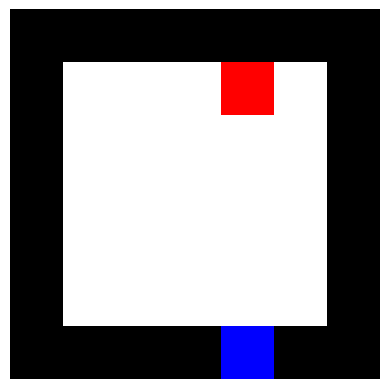

Episode: 1585151 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.7030 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.1844250173234665 
    Learning Rate: 0.1
    


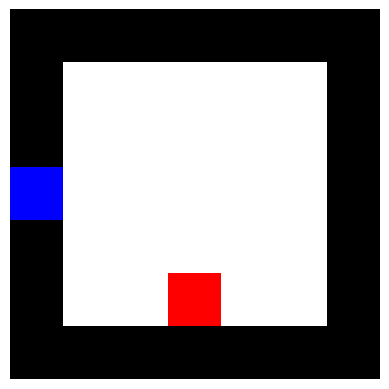

Episode: 1589247 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.6985 
    SnakeLength: 1.11767578125 
    Eplsilon: 0.18367115703540005 
    Learning Rate: 0.1
    


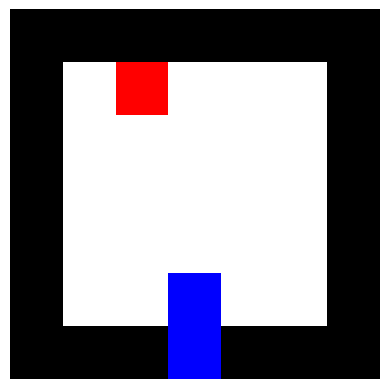

Episode: 1593343 
    Avg Iterations (last 4096 episodes): 4.46 
    Avg Score (last 4096): 0.6437 
    SnakeLength: 1.11328125 
    Eplsilon: 0.1829203782453982 
    Learning Rate: 0.1
    


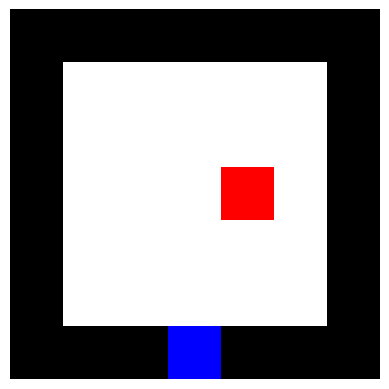

Episode: 1597439 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6582 
    SnakeLength: 1.116943359375 
    Eplsilon: 0.18217266835745402 
    Learning Rate: 0.1
    


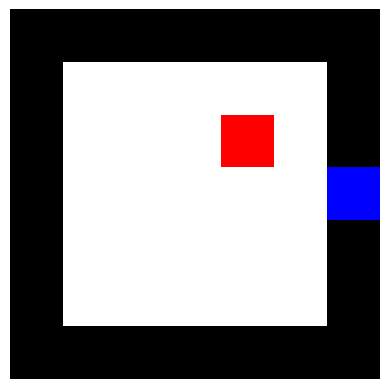

Episode: 1601535 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6875 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.1814280148270447 
    Learning Rate: 0.1
    


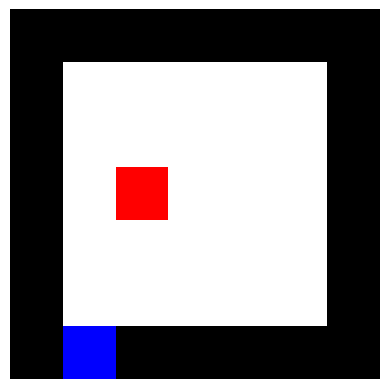

Episode: 1605631 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6924 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.1806864051609292 
    Learning Rate: 0.1
    


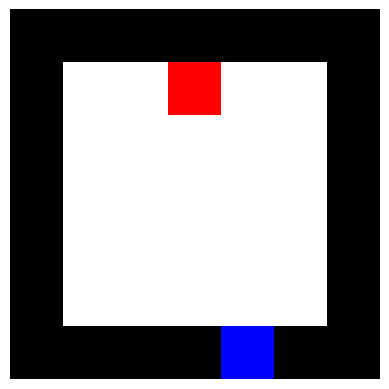

Episode: 1609727 
    Avg Iterations (last 4096 episodes): 4.65 
    Avg Score (last 4096): 0.7079 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.17994782691693115 
    Learning Rate: 0.1
    


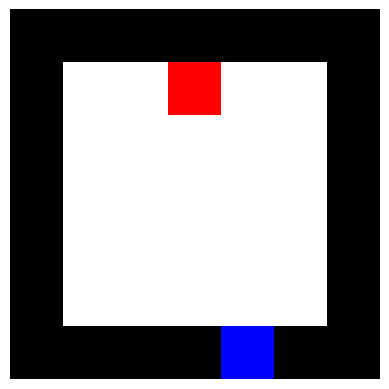

Episode: 1613823 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6823 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.17921226770373314 
    Learning Rate: 0.1
    


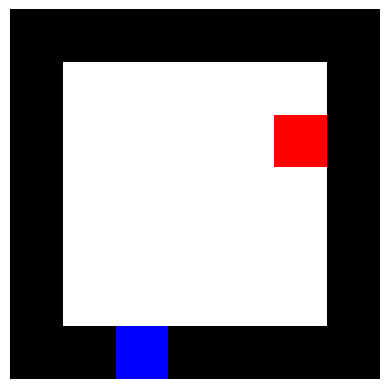

Episode: 1617919 
    Avg Iterations (last 4096 episodes): 4.41 
    Avg Score (last 4096): 0.6325 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.17847971518067055 
    Learning Rate: 0.1
    


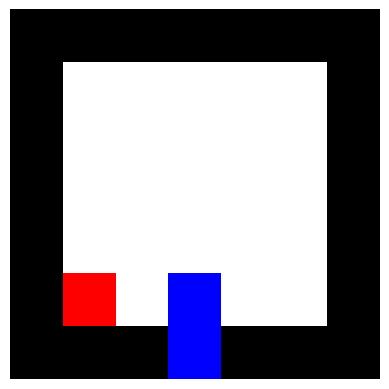

Episode: 1622015 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6996 
    SnakeLength: 1.115234375 
    Eplsilon: 0.17775015705752334 
    Learning Rate: 0.1
    


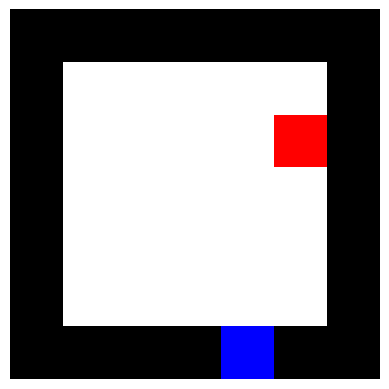

Episode: 1626111 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7303 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.17702358109430608 
    Learning Rate: 0.1
    


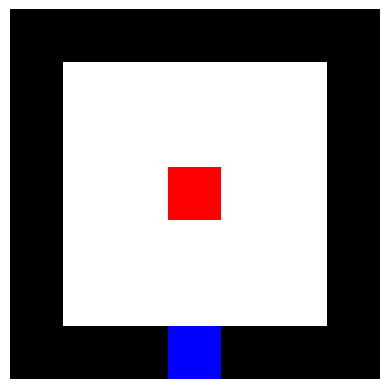

Episode: 1630207 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.7007 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.1762999751010694 
    Learning Rate: 0.1
    


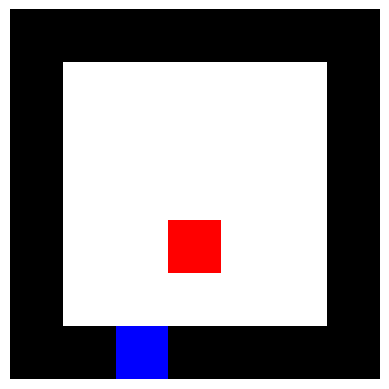

Episode: 1634303 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6789 
    SnakeLength: 1.126953125 
    Eplsilon: 0.17557932693768719 
    Learning Rate: 0.1
    


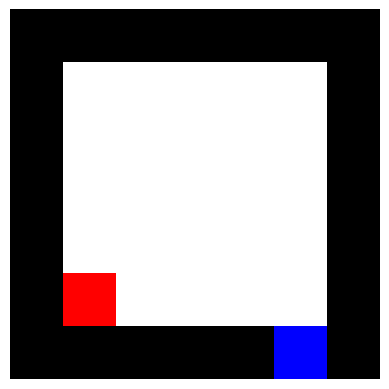

Episode: 1638399 
    Avg Iterations (last 4096 episodes): 4.43 
    Avg Score (last 4096): 0.6230 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.17486162451366416 
    Learning Rate: 0.1
    


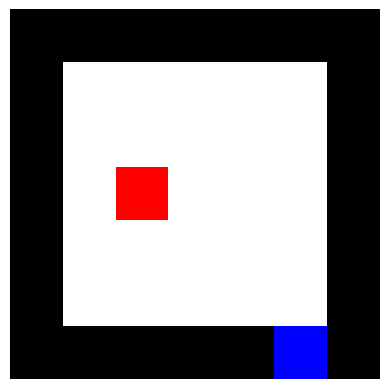

Episode: 1642495 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6999 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.17414685578792127 
    Learning Rate: 0.1
    


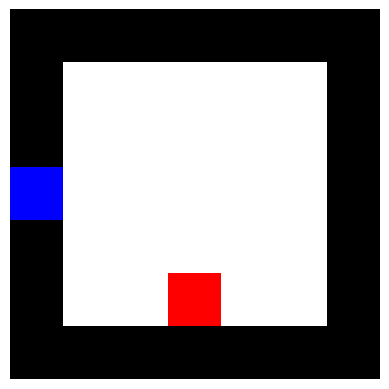

Episode: 1646591 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7378 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.17343500876860038 
    Learning Rate: 0.1
    


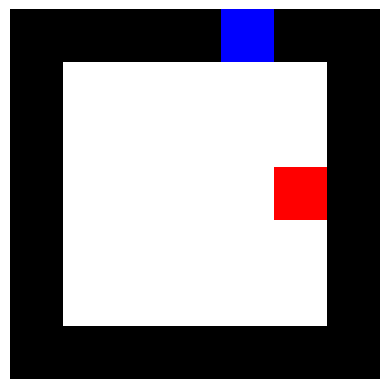

Episode: 1650687 
    Avg Iterations (last 4096 episodes): 4.42 
    Avg Score (last 4096): 0.6281 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.17272607151286112 
    Learning Rate: 0.1
    


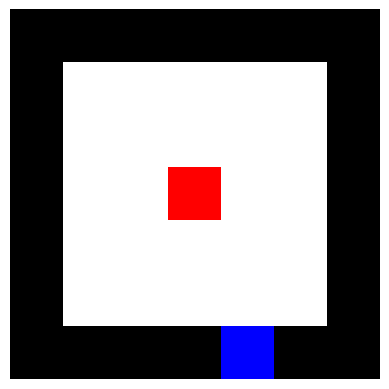

Episode: 1654783 
    Avg Iterations (last 4096 episodes): 4.60 
    Avg Score (last 4096): 0.6923 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.1720200321266818 
    Learning Rate: 0.1
    


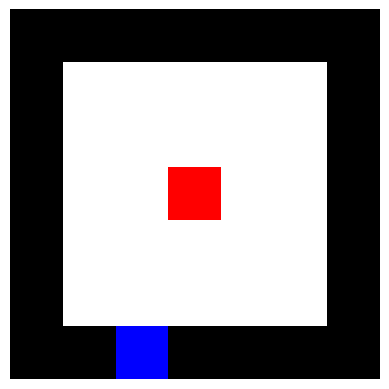

Episode: 1658879 
    Avg Iterations (last 4096 episodes): 4.61 
    Avg Score (last 4096): 0.6982 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.1713168787646595 
    Learning Rate: 0.1
    


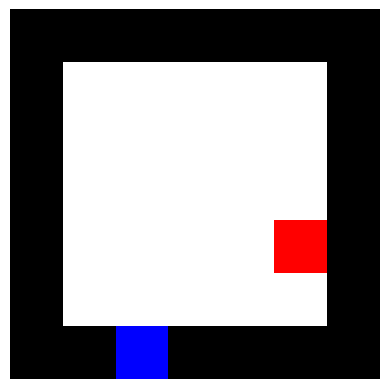

Episode: 1662975 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6379 
    SnakeLength: 1.1171875 
    Eplsilon: 0.17061659962980946 
    Learning Rate: 0.1
    


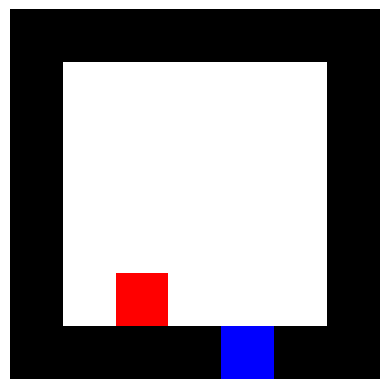

Episode: 1667071 
    Avg Iterations (last 4096 episodes): 4.52 
    Avg Score (last 4096): 0.6707 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.1699191829733692 
    Learning Rate: 0.1
    


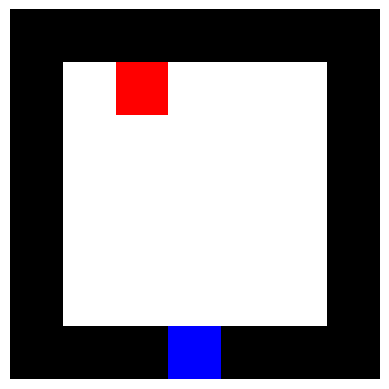

Episode: 1671167 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.7067 
    SnakeLength: 1.122802734375 
    Eplsilon: 0.16922461709459946 
    Learning Rate: 0.1
    


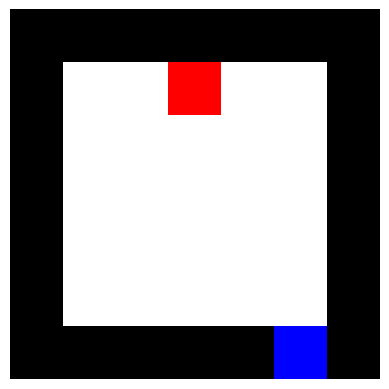

Episode: 1675263 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.7198 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.16853289034059343 
    Learning Rate: 0.1
    


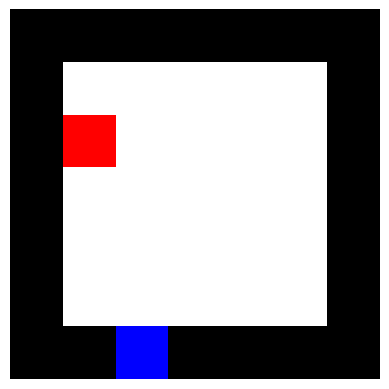

Episode: 1679359 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6207 
    SnakeLength: 1.109375 
    Eplsilon: 0.16784399110607268 
    Learning Rate: 0.1
    


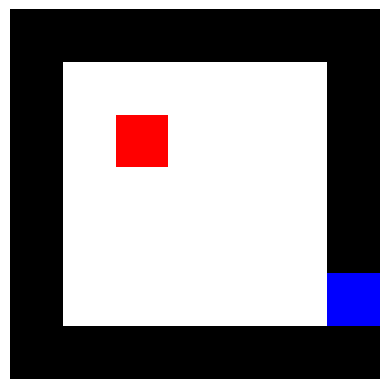

Episode: 1683455 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7430 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.16715790783319792 
    Learning Rate: 0.1
    


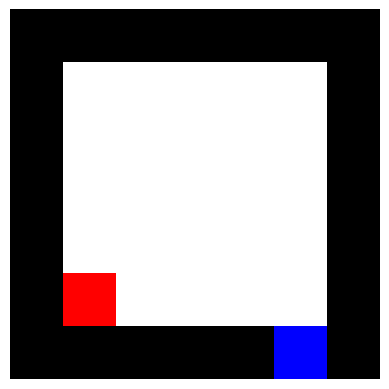

Episode: 1687551 
    Avg Iterations (last 4096 episodes): 4.49 
    Avg Score (last 4096): 0.6662 
    SnakeLength: 1.124267578125 
    Eplsilon: 0.16647462901137378 
    Learning Rate: 0.1
    


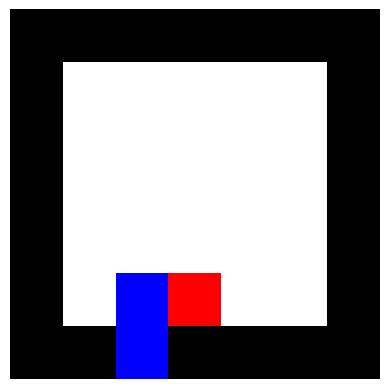

Episode: 1691647 
    Avg Iterations (last 4096 episodes): 4.47 
    Avg Score (last 4096): 0.6377 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.16579414317705735 
    Learning Rate: 0.1
    


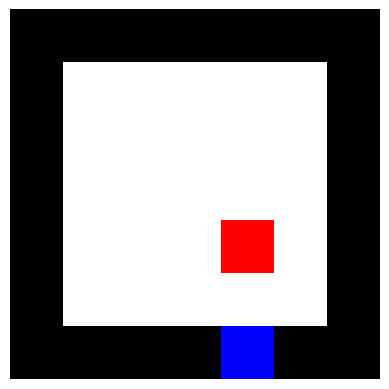

Episode: 1695743 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.6860 
    SnakeLength: 1.115234375 
    Eplsilon: 0.16511643891356356 
    Learning Rate: 0.1
    


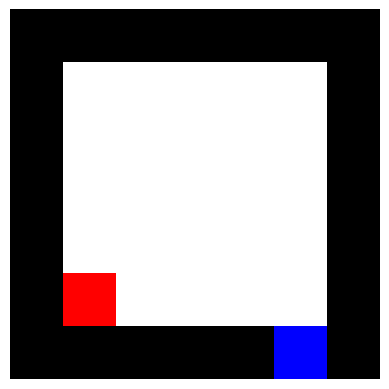

Episode: 1699839 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7607 
    SnakeLength: 1.1259765625 
    Eplsilon: 0.16444150485087417 
    Learning Rate: 0.1
    


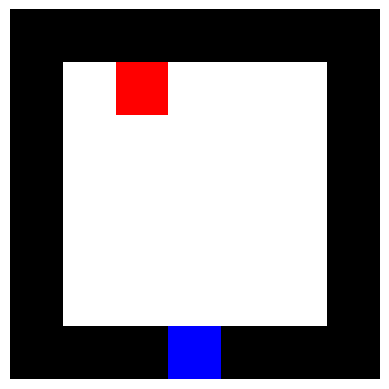

Episode: 1703935 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6883 
    SnakeLength: 1.1259765625 
    Eplsilon: 0.1637693296654476 
    Learning Rate: 0.1
    


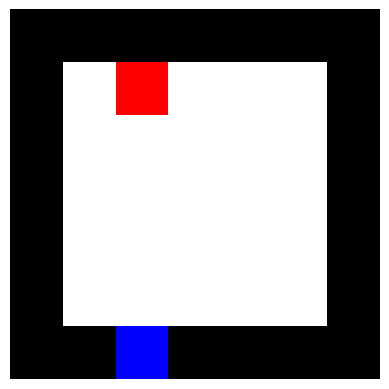

Episode: 1708031 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7391 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.16309990208002742 
    Learning Rate: 0.1
    


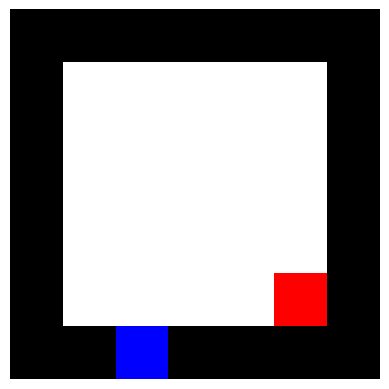

Episode: 1712127 
    Avg Iterations (last 4096 episodes): 4.66 
    Avg Score (last 4096): 0.7301 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.1624332108634555 
    Learning Rate: 0.1
    


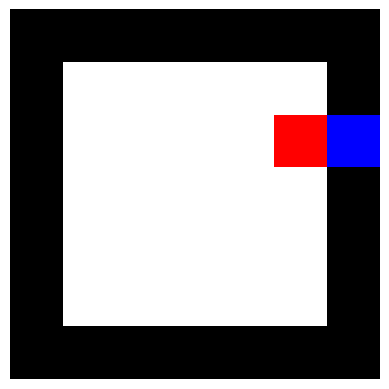

Episode: 1716223 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.6868 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.16176924483048427 
    Learning Rate: 0.1
    


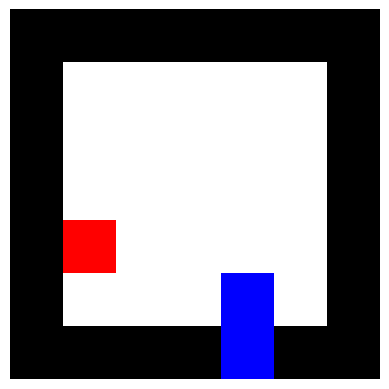

Episode: 1720319 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6641 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.16110799284158428 
    Learning Rate: 0.1
    


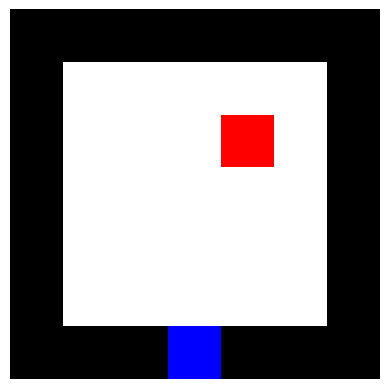

Episode: 1724415 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7452 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.1604494438027621 
    Learning Rate: 0.1
    


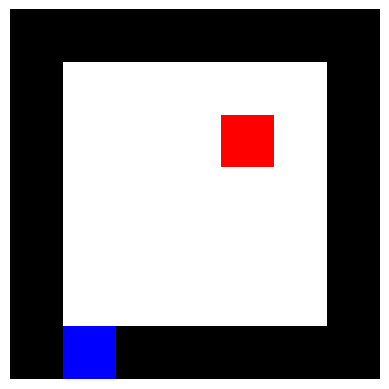

Episode: 1728511 
    Avg Iterations (last 4096 episodes): 4.45 
    Avg Score (last 4096): 0.6487 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.1597935866653703 
    Learning Rate: 0.1
    


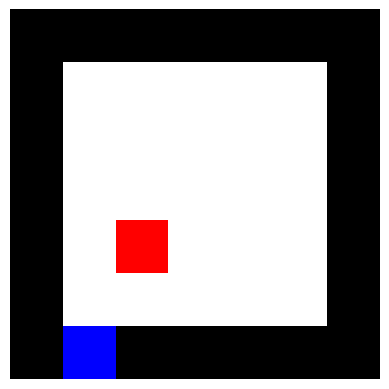

Episode: 1732607 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7091 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.15914041042592683 
    Learning Rate: 0.1
    


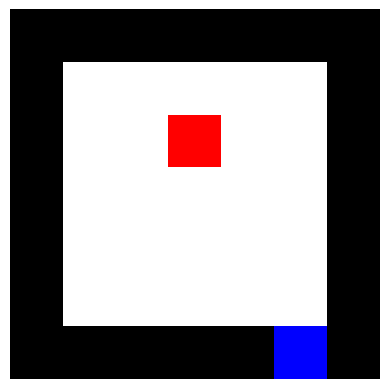

Episode: 1736703 
    Avg Iterations (last 4096 episodes): 4.59 
    Avg Score (last 4096): 0.6922 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.15848990412592712 
    Learning Rate: 0.1
    


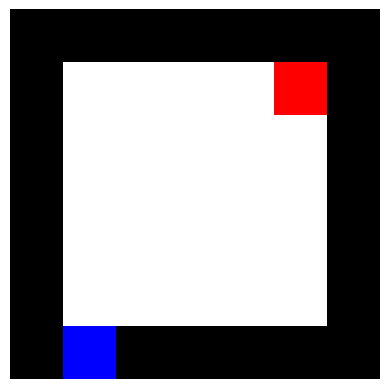

Episode: 1740799 
    Avg Iterations (last 4096 episodes): 4.87 
    Avg Score (last 4096): 0.8061 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.15784205685165953 
    Learning Rate: 0.1
    


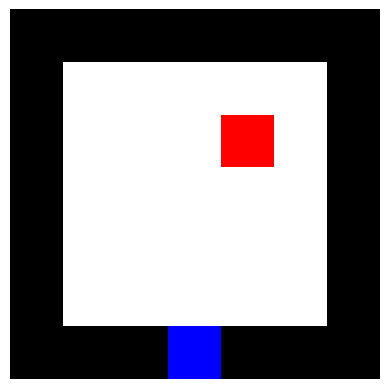

Episode: 1744895 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.6851 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.15719685773402306 
    Learning Rate: 0.1
    


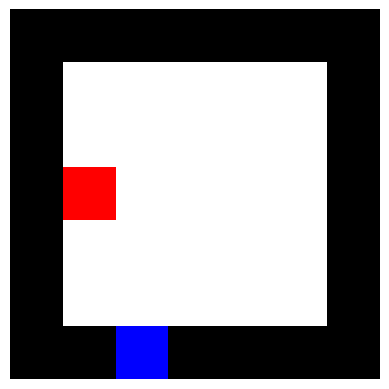

Episode: 1748991 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.6867 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.15655429594834874 
    Learning Rate: 0.1
    


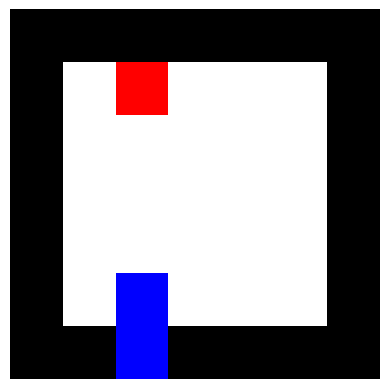

Episode: 1753087 
    Avg Iterations (last 4096 episodes): 4.55 
    Avg Score (last 4096): 0.7008 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.1559143607142126 
    Learning Rate: 0.1
    


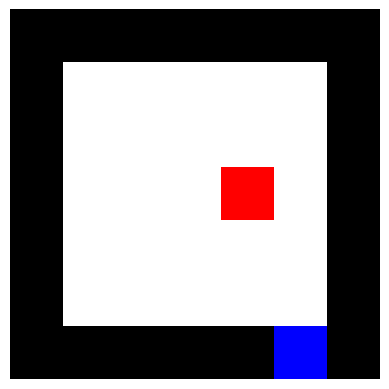

Episode: 1757183 
    Avg Iterations (last 4096 episodes): 4.58 
    Avg Score (last 4096): 0.6904 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.1552770412952558 
    Learning Rate: 0.1
    


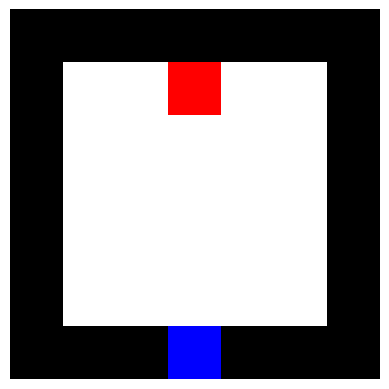

Episode: 1761279 
    Avg Iterations (last 4096 episodes): 4.44 
    Avg Score (last 4096): 0.6354 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.154642326999009 
    Learning Rate: 0.1
    


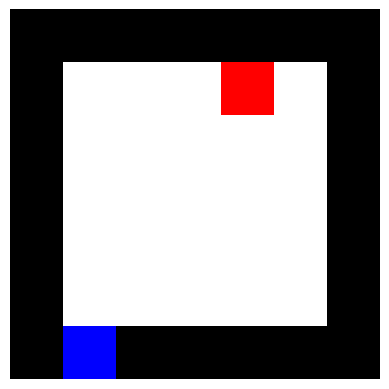

Episode: 1765375 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7214 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.15401020717670688 
    Learning Rate: 0.1
    


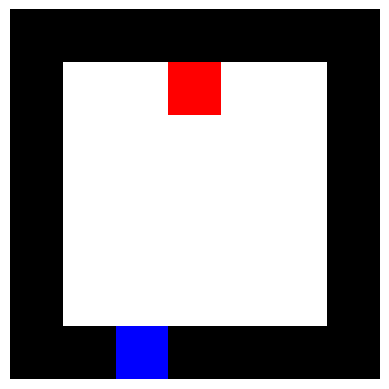

Episode: 1769471 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.6713 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.15338067122311339 
    Learning Rate: 0.1
    


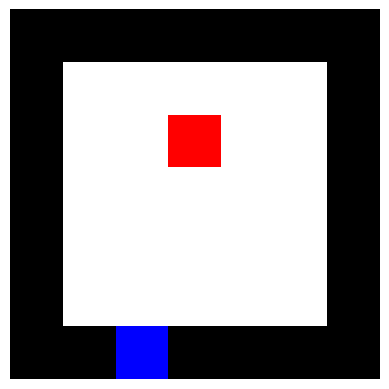

Episode: 1773567 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6863 
    SnakeLength: 1.115234375 
    Eplsilon: 0.15275370857634338 
    Learning Rate: 0.1
    


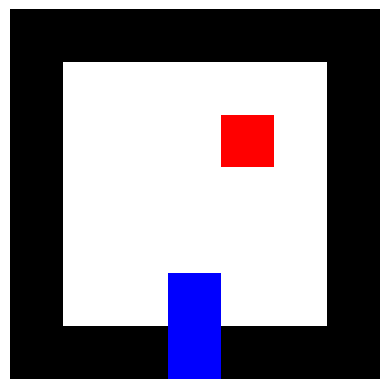

Episode: 1777663 
    Avg Iterations (last 4096 episodes): 4.51 
    Avg Score (last 4096): 0.6490 
    SnakeLength: 1.107177734375 
    Eplsilon: 0.1521293087176811 
    Learning Rate: 0.1
    


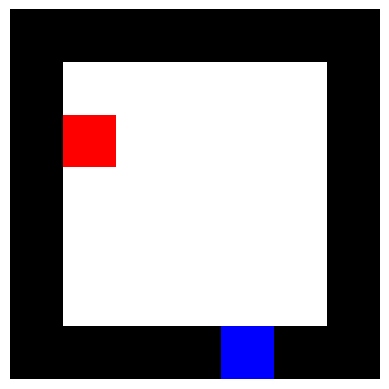

Episode: 1781759 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6318 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.15150746117141306 
    Learning Rate: 0.1
    


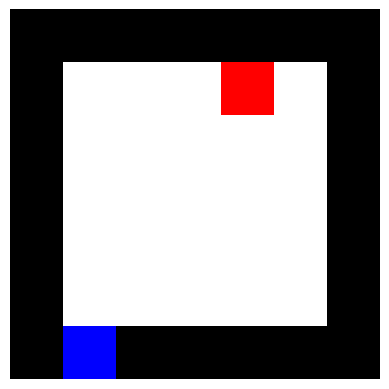

Episode: 1785855 
    Avg Iterations (last 4096 episodes): 4.62 
    Avg Score (last 4096): 0.7113 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.15088815550464219 
    Learning Rate: 0.1
    


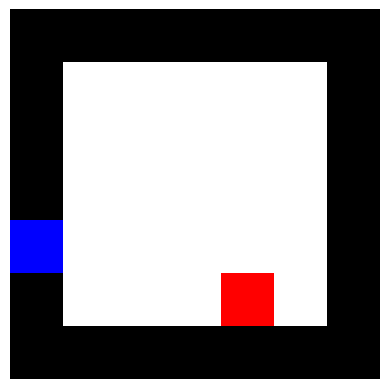

Episode: 1789951 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.7892 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.1502713813271191 
    Learning Rate: 0.1
    


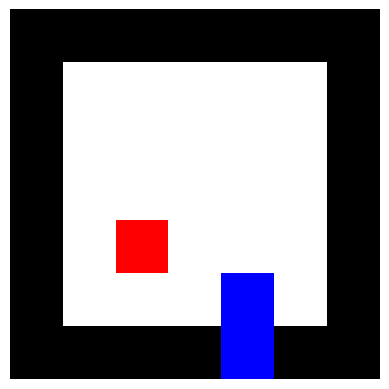

Episode: 1794047 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.6678 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.1496571282910652 
    Learning Rate: 0.1
    


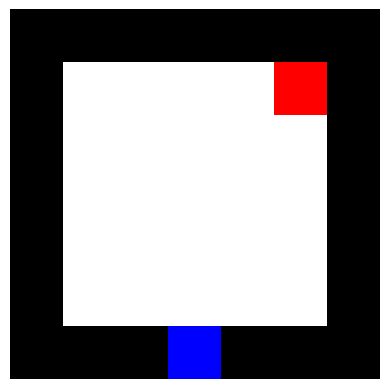

Episode: 1798143 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7130 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.149045386091 
    Learning Rate: 0.1
    


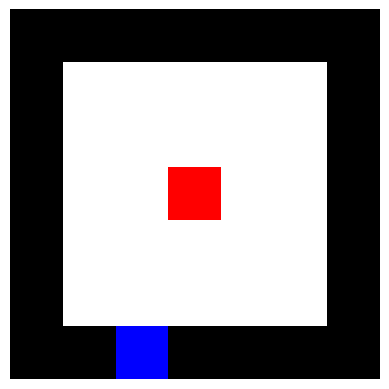

Episode: 1802239 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7170 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.1484361444635674 
    Learning Rate: 0.1
    


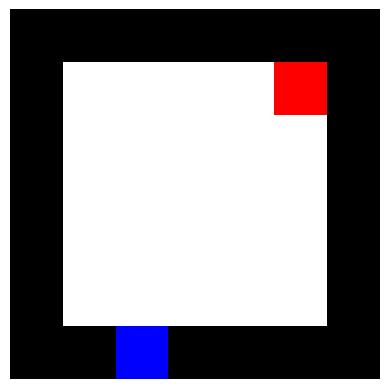

Episode: 1806335 
    Avg Iterations (last 4096 episodes): 4.48 
    Avg Score (last 4096): 0.6373 
    SnakeLength: 1.10205078125 
    Eplsilon: 0.14782939318736524 
    Learning Rate: 0.1
    


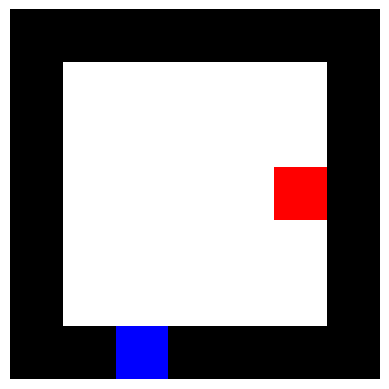

Episode: 1810431 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.6772 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.147225122082772 
    Learning Rate: 0.1
    


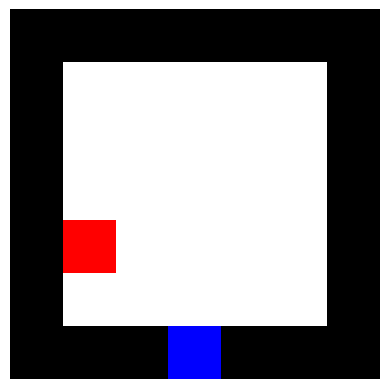

Episode: 1814527 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7724 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.14662332101177536 
    Learning Rate: 0.1
    


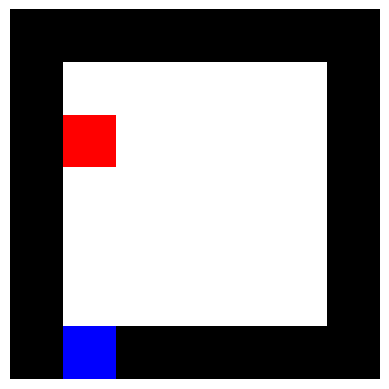

Episode: 1818623 
    Avg Iterations (last 4096 episodes): 4.67 
    Avg Score (last 4096): 0.6964 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.1460239798778059 
    Learning Rate: 0.1
    


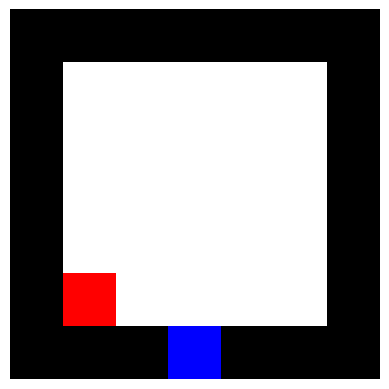

Episode: 1822719 
    Avg Iterations (last 4096 episodes): 4.69 
    Avg Score (last 4096): 0.7565 
    SnakeLength: 1.125244140625 
    Eplsilon: 0.14542708862556314 
    Learning Rate: 0.1
    


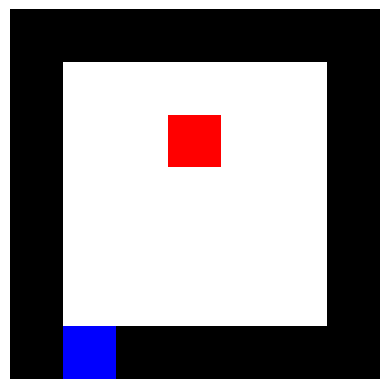

Episode: 1826815 
    Avg Iterations (last 4096 episodes): 4.56 
    Avg Score (last 4096): 0.7020 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.14483263724084877 
    Learning Rate: 0.1
    


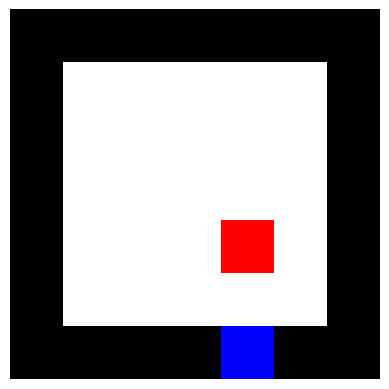

Episode: 1830911 
    Avg Iterations (last 4096 episodes): 4.87 
    Avg Score (last 4096): 0.8594 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.14424061575040062 
    Learning Rate: 0.1
    


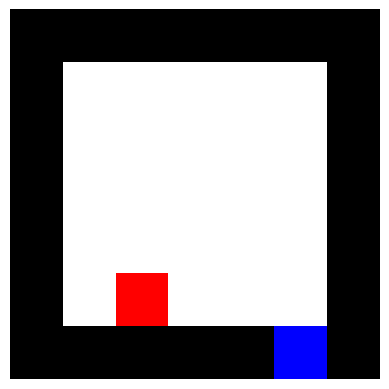

Episode: 1835007 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7433 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.14365101422172236 
    Learning Rate: 0.1
    


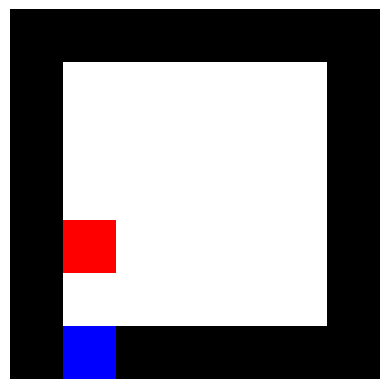

Episode: 1839103 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7073 
    SnakeLength: 1.116943359375 
    Eplsilon: 0.14306382276291899 
    Learning Rate: 0.1
    


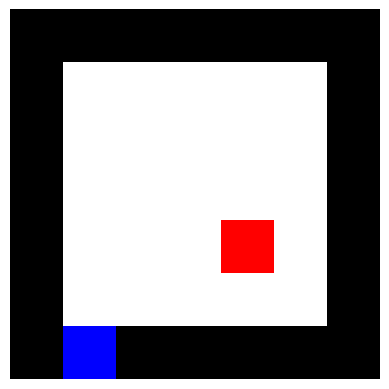

Episode: 1843199 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7812 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.14247903152252728 
    Learning Rate: 0.1
    


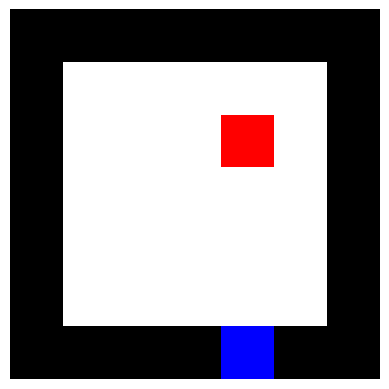

Episode: 1847295 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7774 
    SnakeLength: 1.12158203125 
    Eplsilon: 0.141896630689356 
    Learning Rate: 0.1
    


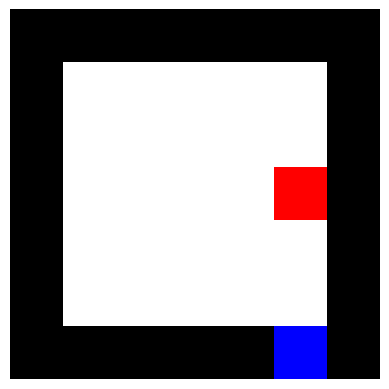

Episode: 1851391 
    Avg Iterations (last 4096 episodes): 4.75 
    Avg Score (last 4096): 0.7626 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.14131661049231498 
    Learning Rate: 0.1
    


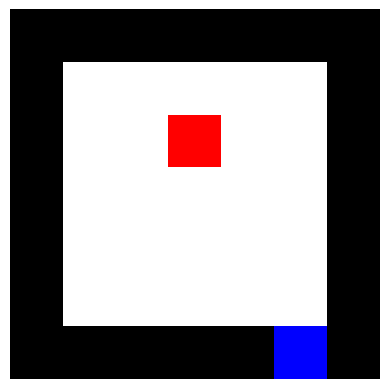

Episode: 1855487 
    Avg Iterations (last 4096 episodes): 4.69 
    Avg Score (last 4096): 0.7377 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.1407389612002593 
    Learning Rate: 0.1
    


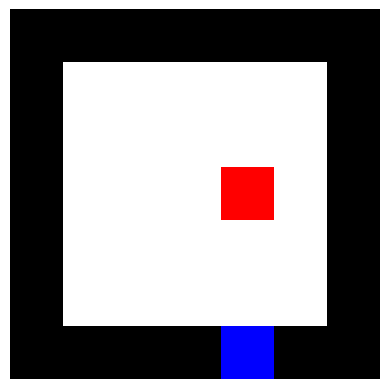

Episode: 1859583 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.7300 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.140163673121819 
    Learning Rate: 0.1
    


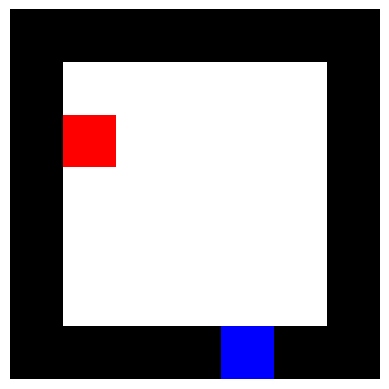

Episode: 1863679 
    Avg Iterations (last 4096 episodes): 4.57 
    Avg Score (last 4096): 0.7111 
    SnakeLength: 1.115234375 
    Eplsilon: 0.13959073660523694 
    Learning Rate: 0.1
    


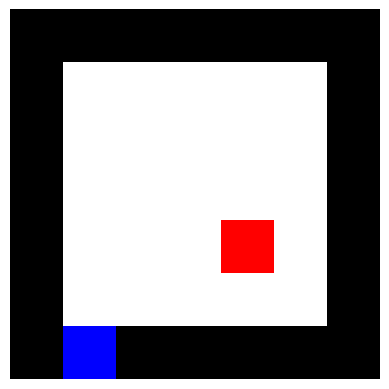

Episode: 1867775 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.8111 
    SnakeLength: 1.119873046875 
    Eplsilon: 0.13902014203821028 
    Learning Rate: 0.1
    


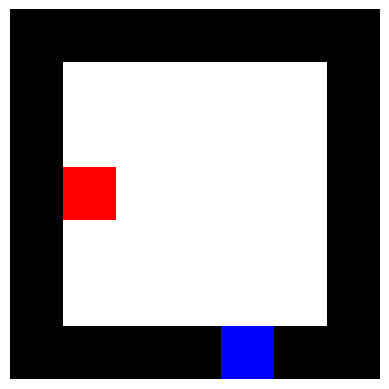

Episode: 1871871 
    Avg Iterations (last 4096 episodes): 4.94 
    Avg Score (last 4096): 0.8560 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.13845187984772944 
    Learning Rate: 0.1
    


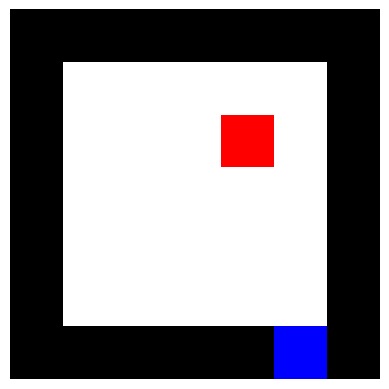

Episode: 1875967 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7112 
    SnakeLength: 1.116943359375 
    Eplsilon: 0.13788594049991237 
    Learning Rate: 0.1
    


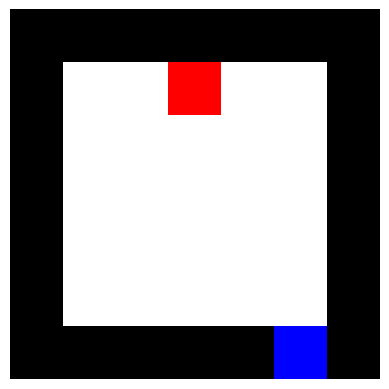

Episode: 1880063 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.7566 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.1373223144998509 
    Learning Rate: 0.1
    


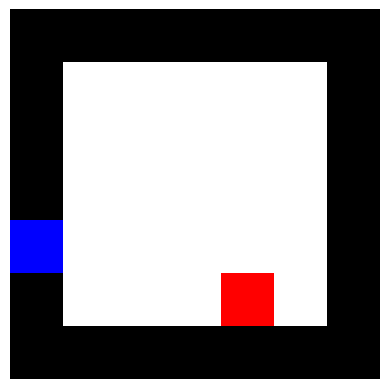

Episode: 1884159 
    Avg Iterations (last 4096 episodes): 4.80 
    Avg Score (last 4096): 0.7788 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.13676099239144573 
    Learning Rate: 0.1
    


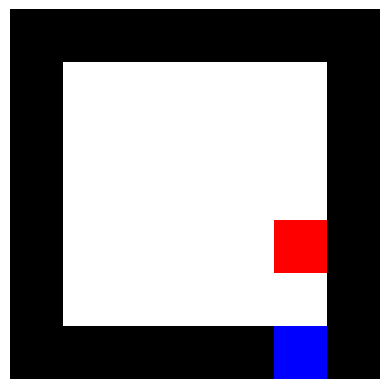

Episode: 1888255 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.7497 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.13620196475725269 
    Learning Rate: 0.1
    


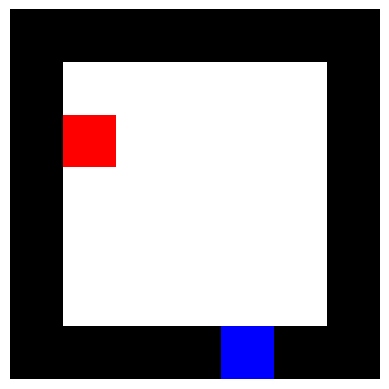

Episode: 1892351 
    Avg Iterations (last 4096 episodes): 4.69 
    Avg Score (last 4096): 0.7678 
    SnakeLength: 1.10400390625 
    Eplsilon: 0.1356452222183221 
    Learning Rate: 0.1
    


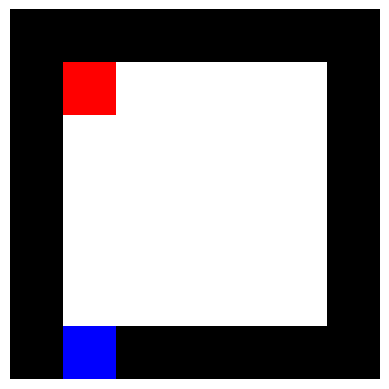

Episode: 1896447 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.6970 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.13509075543404211 
    Learning Rate: 0.1
    


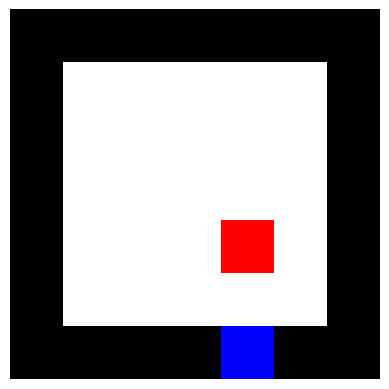

Episode: 1900543 
    Avg Iterations (last 4096 episodes): 4.75 
    Avg Score (last 4096): 0.7562 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.13453855510198037 
    Learning Rate: 0.1
    


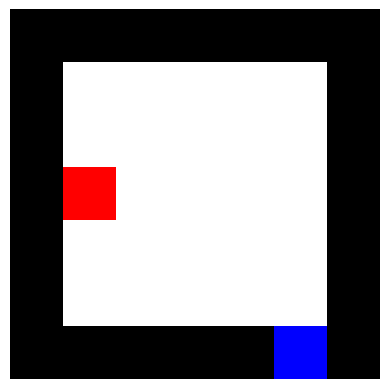

Episode: 1904639 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.8118 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.13398861195773126 
    Learning Rate: 0.1
    


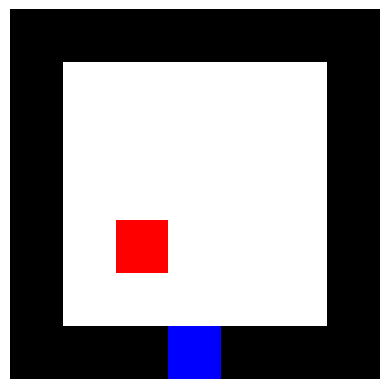

Episode: 1908735 
    Avg Iterations (last 4096 episodes): 4.77 
    Avg Score (last 4096): 0.7562 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.13344091677475736 
    Learning Rate: 0.1
    


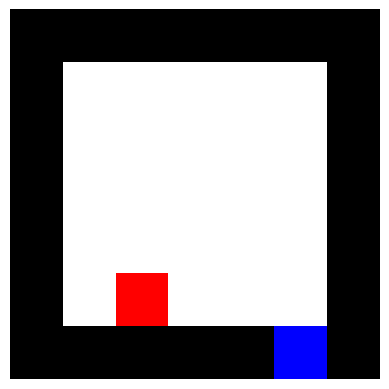

Episode: 1912831 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7725 
    SnakeLength: 1.115234375 
    Eplsilon: 0.13289546036423608 
    Learning Rate: 0.1
    


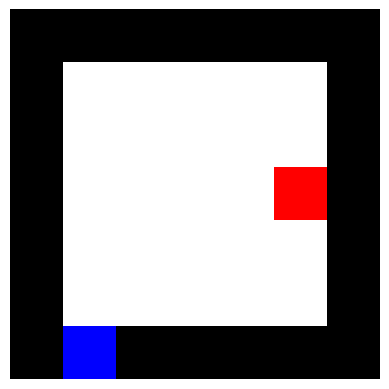

Episode: 1916927 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.7775 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.13235223357490528 
    Learning Rate: 0.1
    


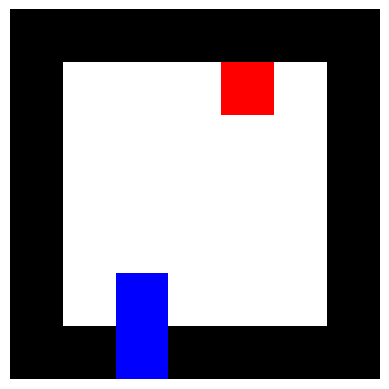

Episode: 1921023 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7297 
    SnakeLength: 1.127197265625 
    Eplsilon: 0.1318112272929111 
    Learning Rate: 0.1
    


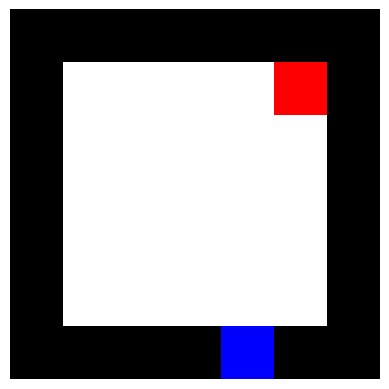

Episode: 1925119 
    Avg Iterations (last 4096 episodes): 4.70 
    Avg Score (last 4096): 0.7465 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.13127243244165251 
    Learning Rate: 0.1
    


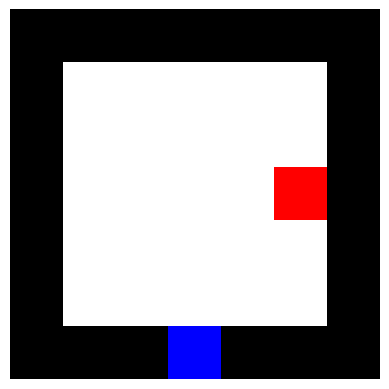

Episode: 1929215 
    Avg Iterations (last 4096 episodes): 4.75 
    Avg Score (last 4096): 0.7861 
    SnakeLength: 1.129150390625 
    Eplsilon: 0.13073583998162827 
    Learning Rate: 0.1
    


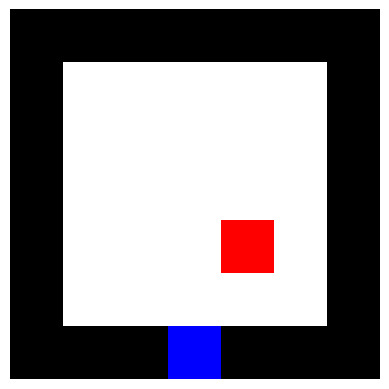

Episode: 1933311 
    Avg Iterations (last 4096 episodes): 4.73 
    Avg Score (last 4096): 0.7485 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.13020144091029043 
    Learning Rate: 0.1
    


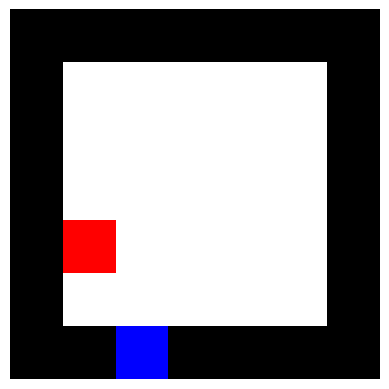

Episode: 1937407 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7183 
    SnakeLength: 1.1220703125 
    Eplsilon: 0.129669226261889 
    Learning Rate: 0.1
    


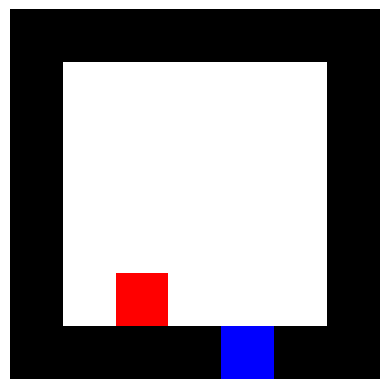

Episode: 1941503 
    Avg Iterations (last 4096 episodes): 4.54 
    Avg Score (last 4096): 0.6426 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.12913918710732217 
    Learning Rate: 0.1
    


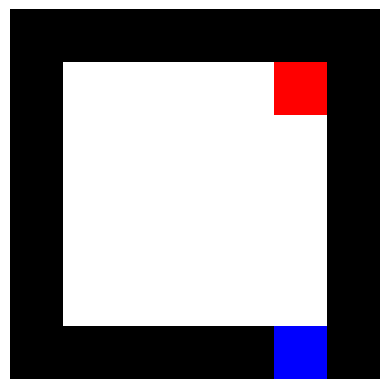

Episode: 1945599 
    Avg Iterations (last 4096 episodes): 4.84 
    Avg Score (last 4096): 0.8036 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.12861131455398767 
    Learning Rate: 0.1
    


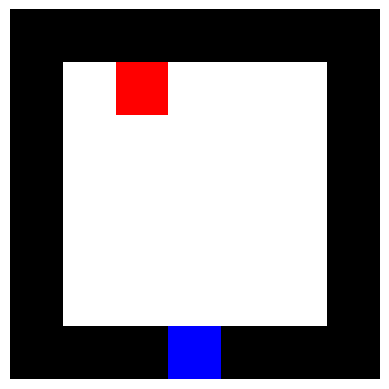

Episode: 1949695 
    Avg Iterations (last 4096 episodes): 4.64 
    Avg Score (last 4096): 0.7068 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.12808559974563266 
    Learning Rate: 0.1
    


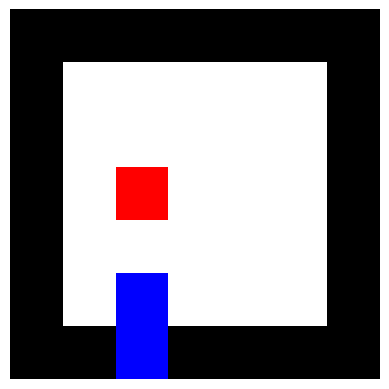

Episode: 1953791 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7575 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.12756203386220397 
    Learning Rate: 0.1
    


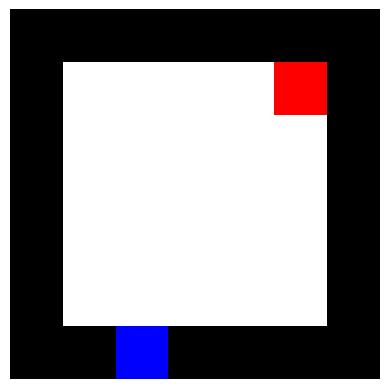

Episode: 1957887 
    Avg Iterations (last 4096 episodes): 4.81 
    Avg Score (last 4096): 0.7991 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.12704060811970352 
    Learning Rate: 0.1
    


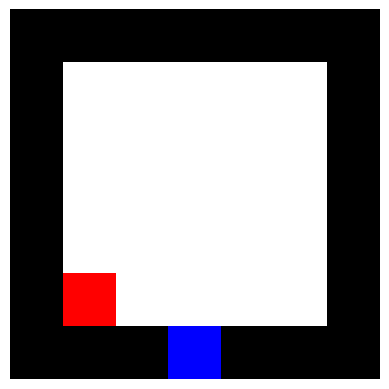

Episode: 1961983 
    Avg Iterations (last 4096 episodes): 4.84 
    Avg Score (last 4096): 0.7812 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.12652131377003697 
    Learning Rate: 0.1
    


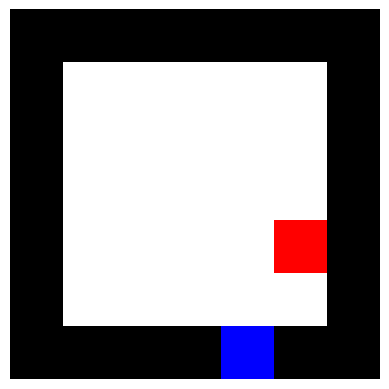

Episode: 1966079 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.8216 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.12600414210087027 
    Learning Rate: 0.1
    


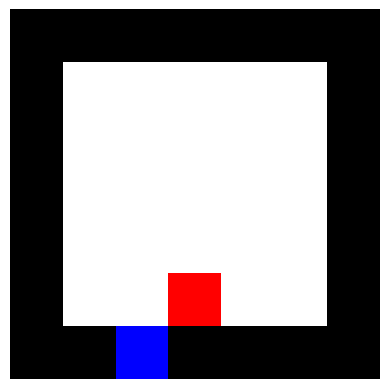

Episode: 1970175 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7004 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.12548908443548273 
    Learning Rate: 0.1
    


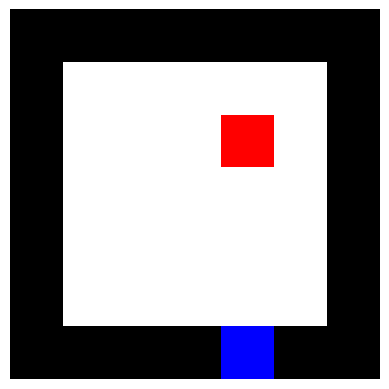

Episode: 1974271 
    Avg Iterations (last 4096 episodes): 4.89 
    Avg Score (last 4096): 0.8174 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.12497613213261978 
    Learning Rate: 0.1
    


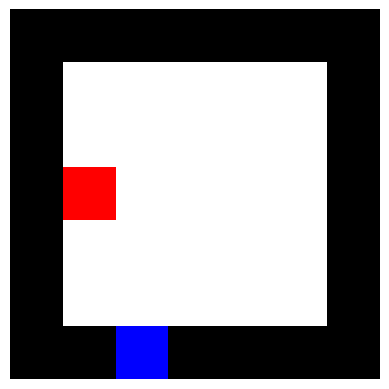

Episode: 1978367 
    Avg Iterations (last 4096 episodes): 4.86 
    Avg Score (last 4096): 0.8345 
    SnakeLength: 1.115234375 
    Eplsilon: 0.12446527658634897 
    Learning Rate: 0.1
    


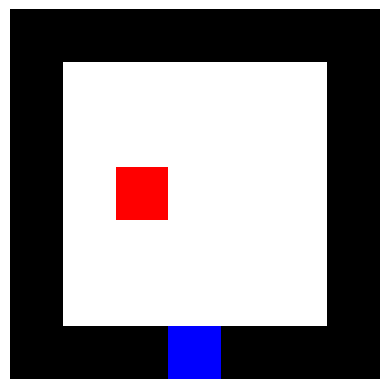

Episode: 1982463 
    Avg Iterations (last 4096 episodes): 4.95 
    Avg Score (last 4096): 0.8375 
    SnakeLength: 1.11328125 
    Eplsilon: 0.12395650922591575 
    Learning Rate: 0.1
    


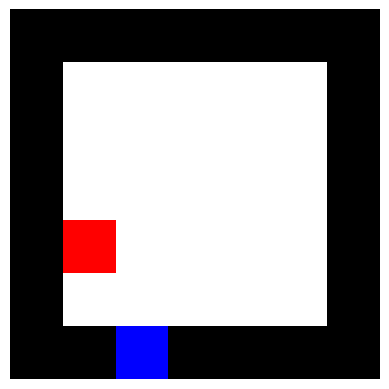

Episode: 1986559 
    Avg Iterations (last 4096 episodes): 4.94 
    Avg Score (last 4096): 0.8431 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.12344982151559955 
    Learning Rate: 0.1
    


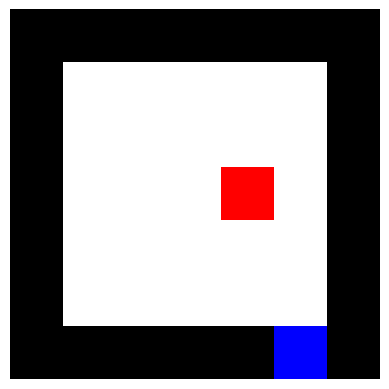

Episode: 1990655 
    Avg Iterations (last 4096 episodes): 4.83 
    Avg Score (last 4096): 0.7887 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.12294520495457092 
    Learning Rate: 0.1
    


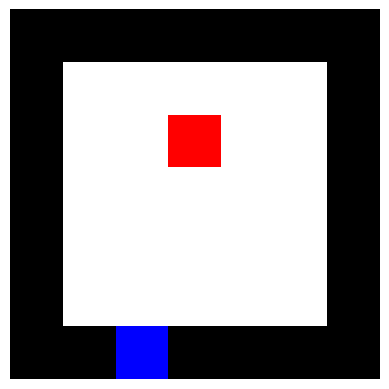

Episode: 1994751 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7720 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.12244265107674933 
    Learning Rate: 0.1
    


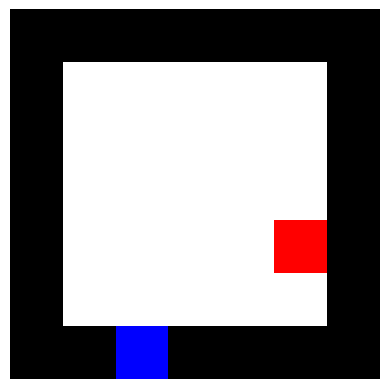

Episode: 1998847 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7180 
    SnakeLength: 1.122314453125 
    Eplsilon: 0.1219421514506583 
    Learning Rate: 0.1
    


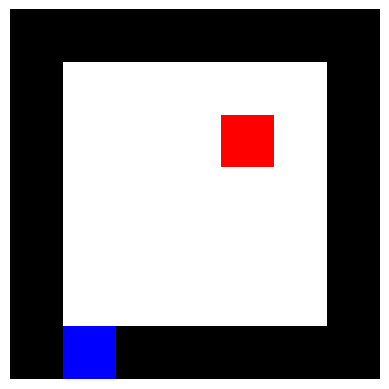

Episode: 2002943 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7499 
    SnakeLength: 1.100830078125 
    Eplsilon: 0.12144369767928798 
    Learning Rate: 0.1
    


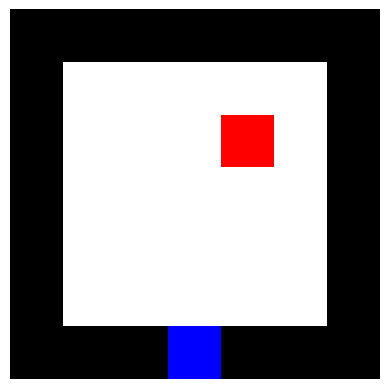

Episode: 2007039 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7383 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.12094728139995155 
    Learning Rate: 0.1
    


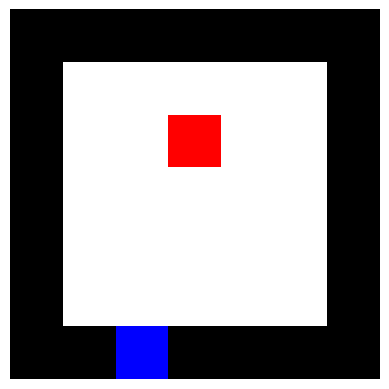

Episode: 2011135 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.7668 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.12045289428414561 
    Learning Rate: 0.1
    


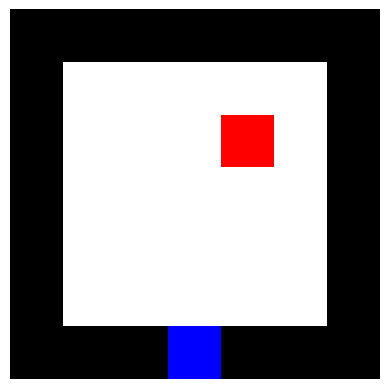

Episode: 2015231 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.8179 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.11996052803741175 
    Learning Rate: 0.1
    


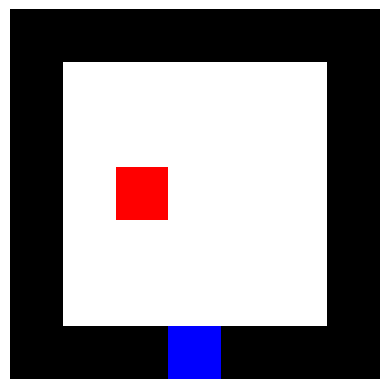

Episode: 2019327 
    Avg Iterations (last 4096 episodes): 4.71 
    Avg Score (last 4096): 0.7603 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.1194701743991947 
    Learning Rate: 0.1
    


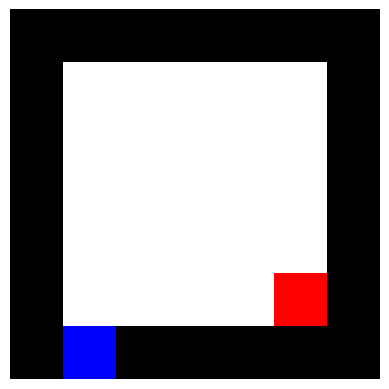

Episode: 2023423 
    Avg Iterations (last 4096 episodes): 4.77 
    Avg Score (last 4096): 0.7659 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.11898182514270642 
    Learning Rate: 0.1
    


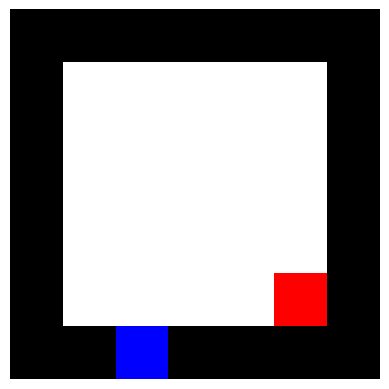

Episode: 2027519 
    Avg Iterations (last 4096 episodes): 4.82 
    Avg Score (last 4096): 0.7745 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.11849547207478553 
    Learning Rate: 0.1
    


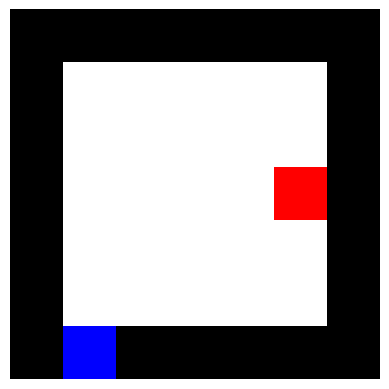

Episode: 2031615 
    Avg Iterations (last 4096 episodes): 4.72 
    Avg Score (last 4096): 0.7405 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.11801110703576202 
    Learning Rate: 0.1
    


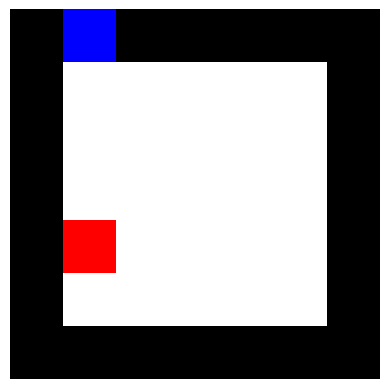

Episode: 2035711 
    Avg Iterations (last 4096 episodes): 4.63 
    Avg Score (last 4096): 0.7293 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.11752872189931947 
    Learning Rate: 0.1
    


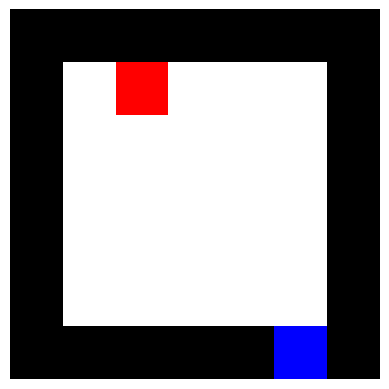

Episode: 2039807 
    Avg Iterations (last 4096 episodes): 4.68 
    Avg Score (last 4096): 0.7599 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.11704830857235925 
    Learning Rate: 0.1
    


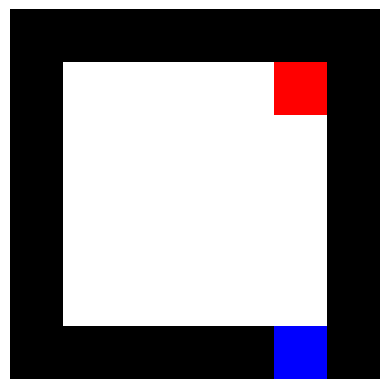

Episode: 2043903 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8461 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.11656985899486413 
    Learning Rate: 0.1
    


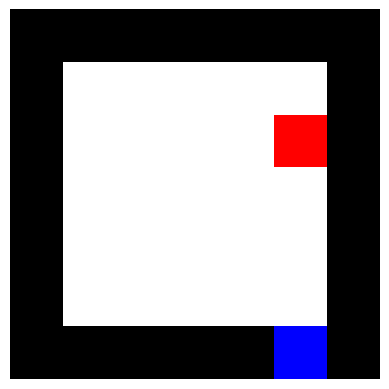

Episode: 2047999 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.7950 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.11609336513976225 
    Learning Rate: 0.1
    


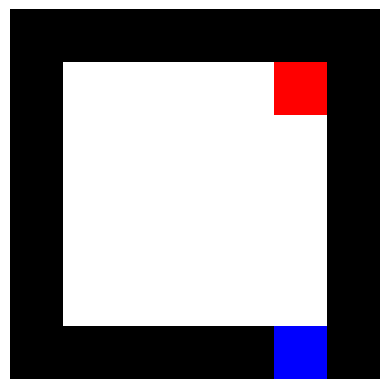

Episode: 2052095 
    Avg Iterations (last 4096 episodes): 5.11 
    Avg Score (last 4096): 0.9424 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.11561881901279479 
    Learning Rate: 0.1
    


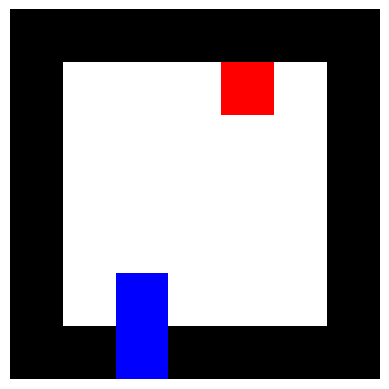

Episode: 2056191 
    Avg Iterations (last 4096 episodes): 4.82 
    Avg Score (last 4096): 0.8151 
    SnakeLength: 1.12646484375 
    Eplsilon: 0.11514621265237929 
    Learning Rate: 0.1
    


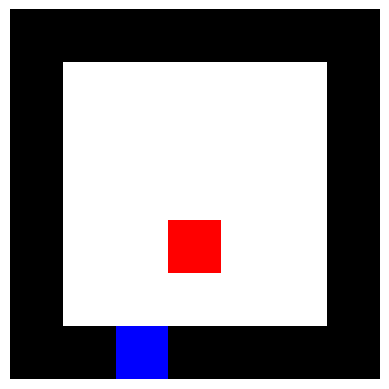

Episode: 2060287 
    Avg Iterations (last 4096 episodes): 5.11 
    Avg Score (last 4096): 0.9116 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.11467553812947762 
    Learning Rate: 0.1
    


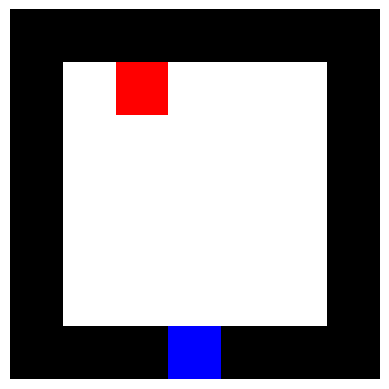

Episode: 2064383 
    Avg Iterations (last 4096 episodes): 4.96 
    Avg Score (last 4096): 0.8420 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.1142067875474636 
    Learning Rate: 0.1
    


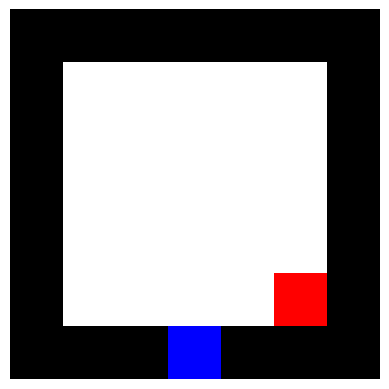

Episode: 2068479 
    Avg Iterations (last 4096 episodes): 4.92 
    Avg Score (last 4096): 0.8179 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.11373995304198835 
    Learning Rate: 0.1
    


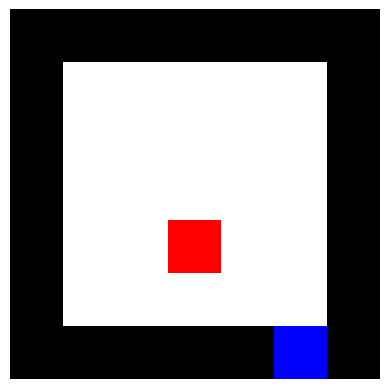

Episode: 2072575 
    Avg Iterations (last 4096 episodes): 5.14 
    Avg Score (last 4096): 0.9296 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.1132750267808486 
    Learning Rate: 0.1
    


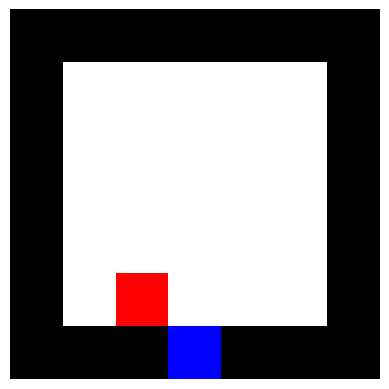

Episode: 2076671 
    Avg Iterations (last 4096 episodes): 4.96 
    Avg Score (last 4096): 0.8883 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.11281200096385852 
    Learning Rate: 0.1
    


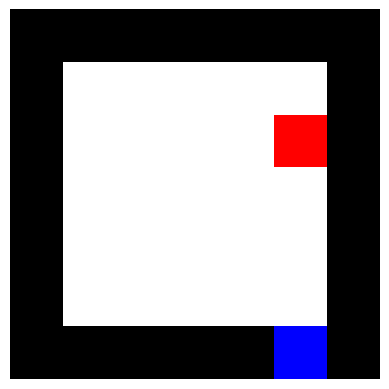

Episode: 2080767 
    Avg Iterations (last 4096 episodes): 4.82 
    Avg Score (last 4096): 0.7871 
    SnakeLength: 1.111328125 
    Eplsilon: 0.11235086782271515 
    Learning Rate: 0.1
    


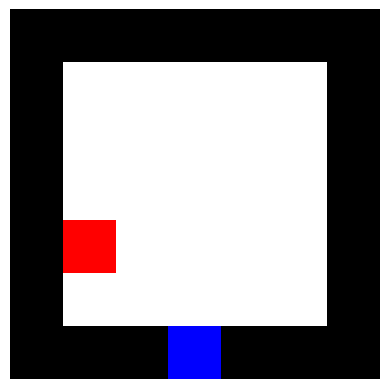

Episode: 2084863 
    Avg Iterations (last 4096 episodes): 4.88 
    Avg Score (last 4096): 0.8492 
    SnakeLength: 1.130859375 
    Eplsilon: 0.11189161962086938 
    Learning Rate: 0.1
    


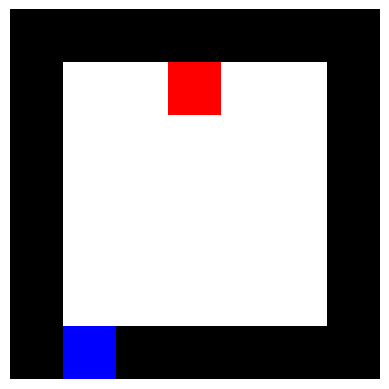

Episode: 2088959 
    Avg Iterations (last 4096 episodes): 4.76 
    Avg Score (last 4096): 0.7465 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.11143424865339657 
    Learning Rate: 0.1
    


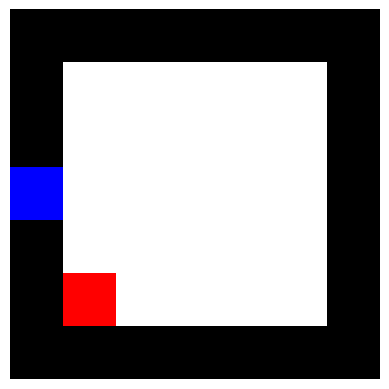

Episode: 2093055 
    Avg Iterations (last 4096 episodes): 4.78 
    Avg Score (last 4096): 0.7754 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.11097874724686635 
    Learning Rate: 0.1
    


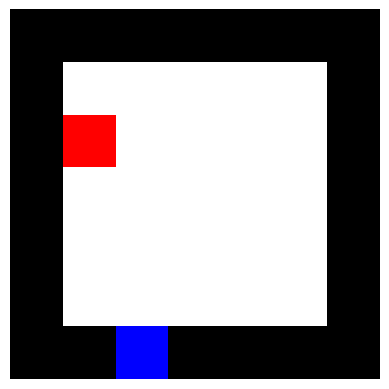

Episode: 2097151 
    Avg Iterations (last 4096 episodes): 4.96 
    Avg Score (last 4096): 0.8530 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.1105251077592151 
    Learning Rate: 0.1
    


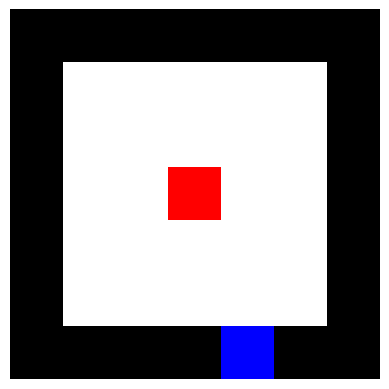

Episode: 2101247 
    Avg Iterations (last 4096 episodes): 5.04 
    Avg Score (last 4096): 0.8741 
    SnakeLength: 1.102294921875 
    Eplsilon: 0.1100733225796168 
    Learning Rate: 0.1
    


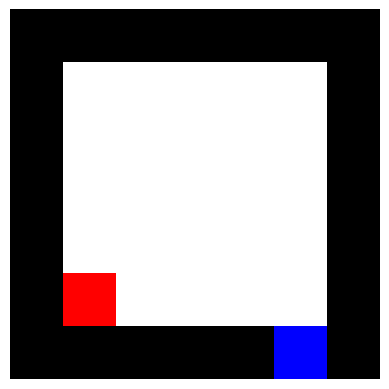

Episode: 2105343 
    Avg Iterations (last 4096 episodes): 4.99 
    Avg Score (last 4096): 0.8856 
    SnakeLength: 1.122314453125 
    Eplsilon: 0.10962338412835593 
    Learning Rate: 0.1
    


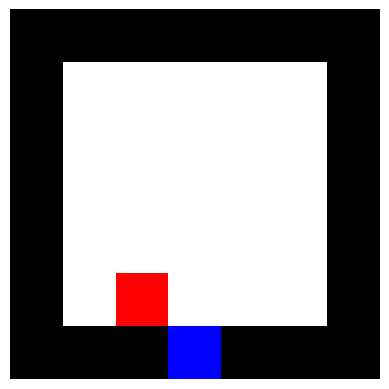

Episode: 2109439 
    Avg Iterations (last 4096 episodes): 4.88 
    Avg Score (last 4096): 0.8119 
    SnakeLength: 1.10400390625 
    Eplsilon: 0.10917528485669997 
    Learning Rate: 0.1
    


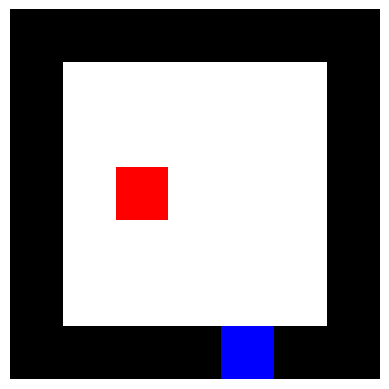

Episode: 2113535 
    Avg Iterations (last 4096 episodes): 4.88 
    Avg Score (last 4096): 0.8349 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.10872901724677278 
    Learning Rate: 0.1
    


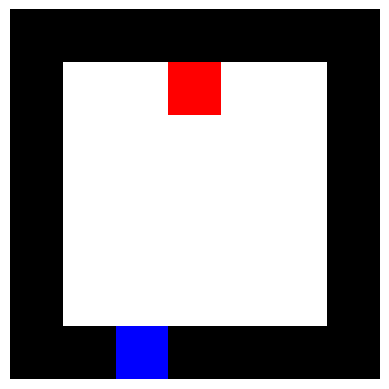

Episode: 2117631 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.9184 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.10828457381142795 
    Learning Rate: 0.1
    


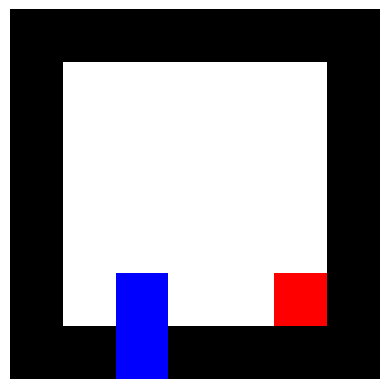

Episode: 2121727 
    Avg Iterations (last 4096 episodes): 5.03 
    Avg Score (last 4096): 0.8895 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.10784194709412431 
    Learning Rate: 0.1
    


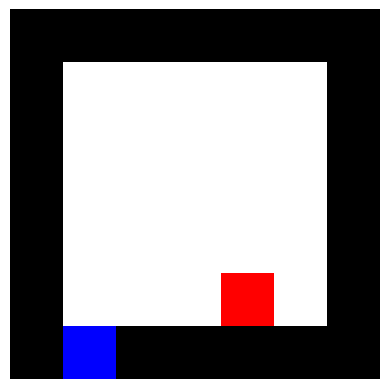

Episode: 2125823 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.8578 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.10740112966879999 
    Learning Rate: 0.1
    


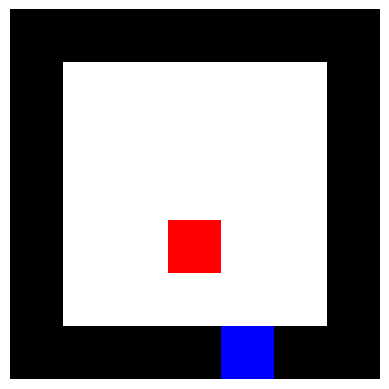

Episode: 2129919 
    Avg Iterations (last 4096 episodes): 4.91 
    Avg Score (last 4096): 0.8194 
    SnakeLength: 1.11328125 
    Eplsilon: 0.10696211413974785 
    Learning Rate: 0.1
    


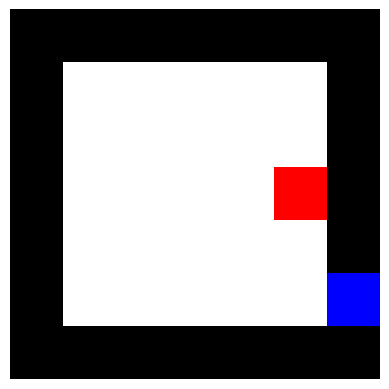

Episode: 2134015 
    Avg Iterations (last 4096 episodes): 4.85 
    Avg Score (last 4096): 0.7872 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.10652489314149227 
    Learning Rate: 0.1
    


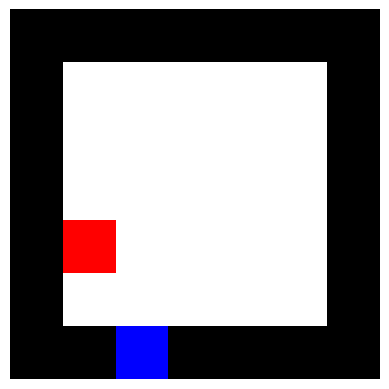

Episode: 2138111 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.9010 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.106089459338664 
    Learning Rate: 0.1
    


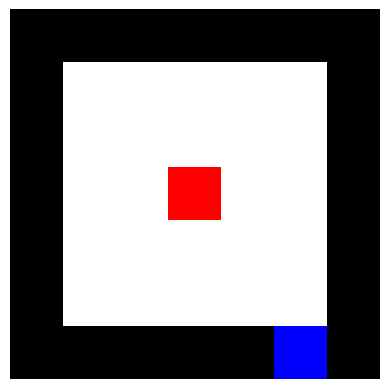

Episode: 2142207 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.8626 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.10565580542587928 
    Learning Rate: 0.1
    


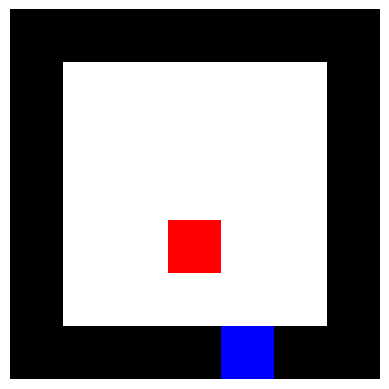

Episode: 2146303 
    Avg Iterations (last 4096 episodes): 4.94 
    Avg Score (last 4096): 0.8868 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.10522392412761483 
    Learning Rate: 0.1
    


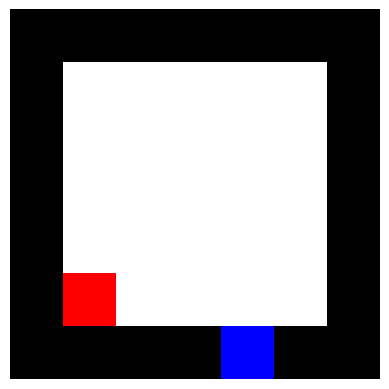

Episode: 2150399 
    Avg Iterations (last 4096 episodes): 5.00 
    Avg Score (last 4096): 0.8912 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.10479380819808744 
    Learning Rate: 0.1
    


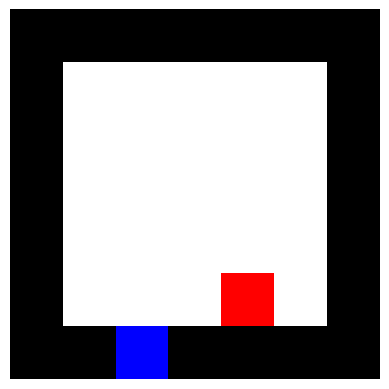

Episode: 2154495 
    Avg Iterations (last 4096 episodes): 4.88 
    Avg Score (last 4096): 0.8125 
    SnakeLength: 1.11328125 
    Eplsilon: 0.10436545042113143 
    Learning Rate: 0.1
    


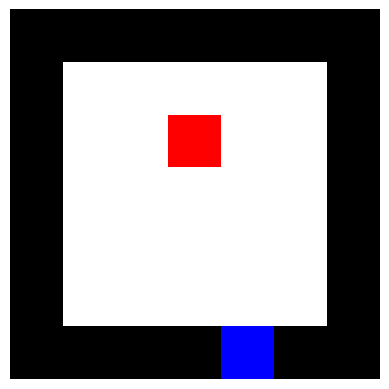

Episode: 2158591 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.8650 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.10393884361008013 
    Learning Rate: 0.1
    


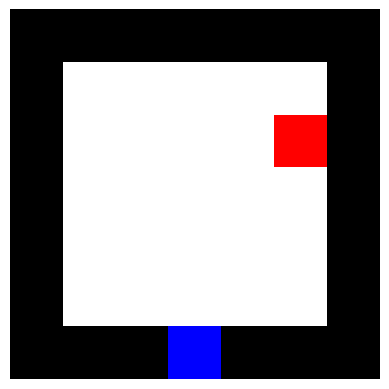

Episode: 2162687 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 0.9535 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.10351398060763979 
    Learning Rate: 0.1
    


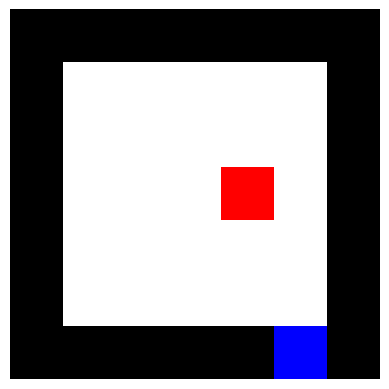

Episode: 2166783 
    Avg Iterations (last 4096 episodes): 5.14 
    Avg Score (last 4096): 0.9340 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.10309085428577658 
    Learning Rate: 0.1
    


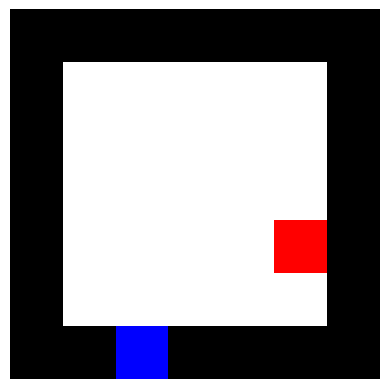

Episode: 2170879 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.8566 
    SnakeLength: 1.1171875 
    Eplsilon: 0.10266945754559048 
    Learning Rate: 0.1
    


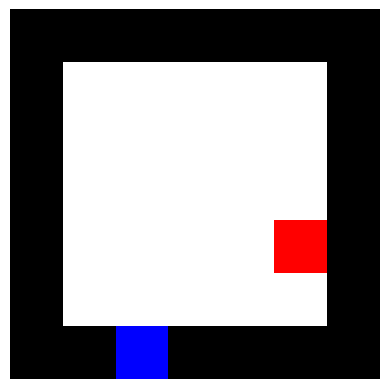

Episode: 2174975 
    Avg Iterations (last 4096 episodes): 4.99 
    Avg Score (last 4096): 0.8921 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.10224978331720193 
    Learning Rate: 0.1
    


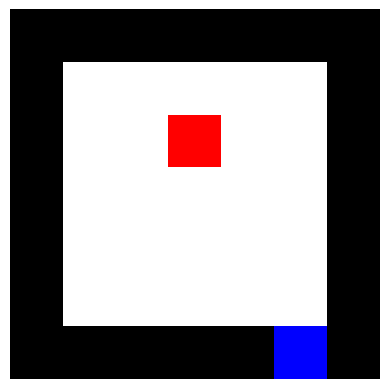

Episode: 2179071 
    Avg Iterations (last 4096 episodes): 5.02 
    Avg Score (last 4096): 0.9026 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.10183182455962735 
    Learning Rate: 0.1
    


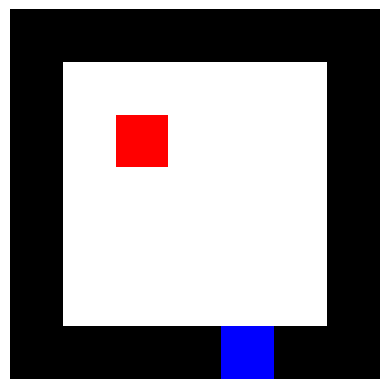

Episode: 2183167 
    Avg Iterations (last 4096 episodes): 5.01 
    Avg Score (last 4096): 0.8497 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.10141557426066625 
    Learning Rate: 0.1
    


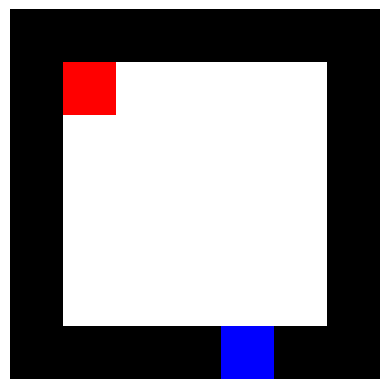

Episode: 2187263 
    Avg Iterations (last 4096 episodes): 5.42 
    Avg Score (last 4096): 1.0768 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.10100102543678083 
    Learning Rate: 0.1
    


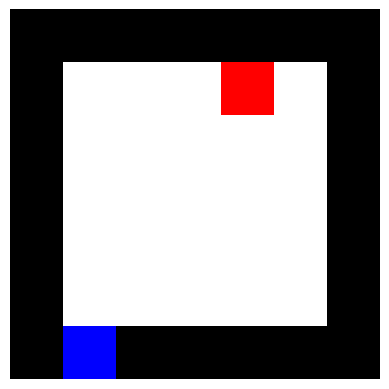

Episode: 2191359 
    Avg Iterations (last 4096 episodes): 5.11 
    Avg Score (last 4096): 0.9159 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.10058817113297923 
    Learning Rate: 0.1
    


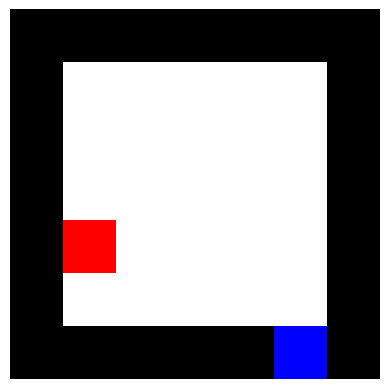

Episode: 2195455 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 0.9358 
    SnakeLength: 1.119140625 
    Eplsilon: 0.10017700442269907 
    Learning Rate: 0.1
    


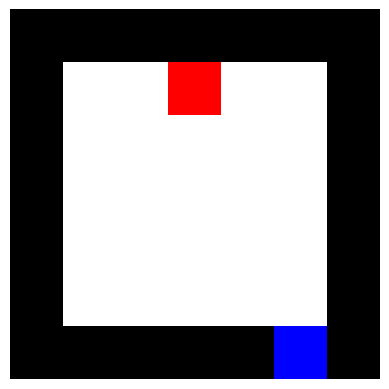

Episode: 2199551 
    Avg Iterations (last 4096 episodes): 5.00 
    Avg Score (last 4096): 0.8610 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.0997675184076905 
    Learning Rate: 0.1
    


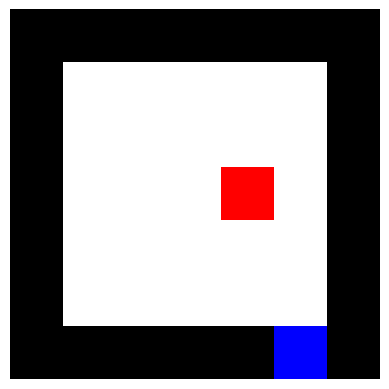

Episode: 2203647 
    Avg Iterations (last 4096 episodes): 4.98 
    Avg Score (last 4096): 0.8419 
    SnakeLength: 1.1171875 
    Eplsilon: 0.09935970621790245 
    Learning Rate: 0.1
    


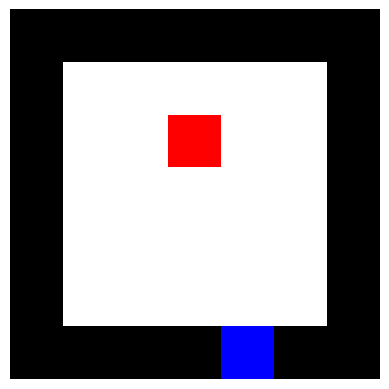

Episode: 2207743 
    Avg Iterations (last 4096 episodes): 4.96 
    Avg Score (last 4096): 0.8808 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.09895356101136477 
    Learning Rate: 0.1
    


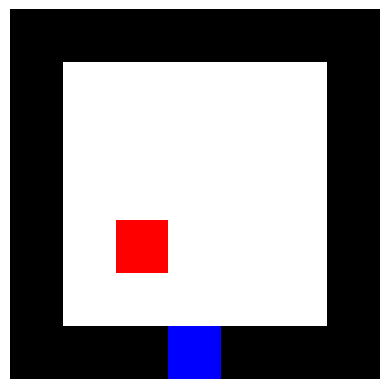

Episode: 2211839 
    Avg Iterations (last 4096 episodes): 5.18 
    Avg Score (last 4096): 0.9161 
    SnakeLength: 1.107421875 
    Eplsilon: 0.09854907597407576 
    Learning Rate: 0.1
    


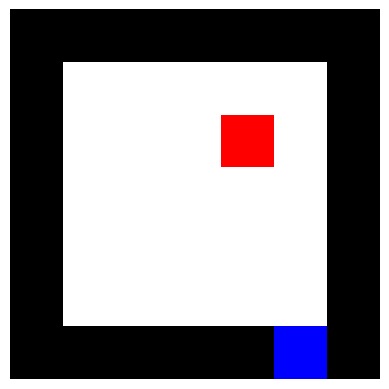

Episode: 2215935 
    Avg Iterations (last 4096 episodes): 5.25 
    Avg Score (last 4096): 0.9645 
    SnakeLength: 1.1259765625 
    Eplsilon: 0.09814624431988604 
    Learning Rate: 0.1
    


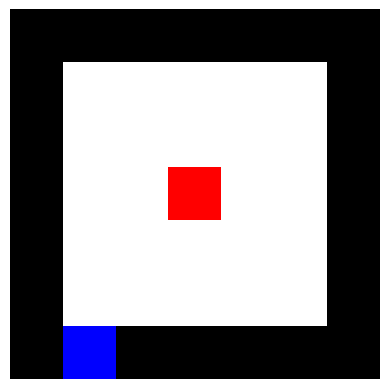

Episode: 2220031 
    Avg Iterations (last 4096 episodes): 5.00 
    Avg Score (last 4096): 0.8678 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.09774505929038553 
    Learning Rate: 0.1
    


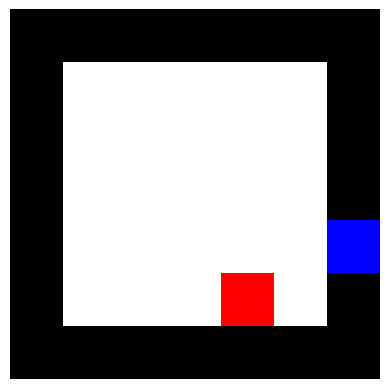

Episode: 2224127 
    Avg Iterations (last 4096 episodes): 5.00 
    Avg Score (last 4096): 0.8598 
    SnakeLength: 1.115234375 
    Eplsilon: 0.09734551415479048 
    Learning Rate: 0.1
    


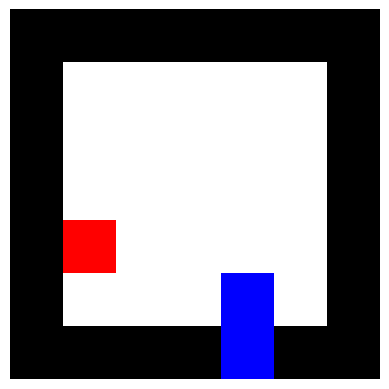

Episode: 2228223 
    Avg Iterations (last 4096 episodes): 5.27 
    Avg Score (last 4096): 1.0049 
    SnakeLength: 1.11767578125 
    Eplsilon: 0.09694760220982945 
    Learning Rate: 0.1
    


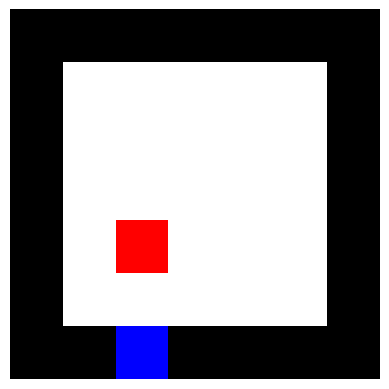

Episode: 2232319 
    Avg Iterations (last 4096 episodes): 5.05 
    Avg Score (last 4096): 0.8757 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.09655131677963172 
    Learning Rate: 0.1
    


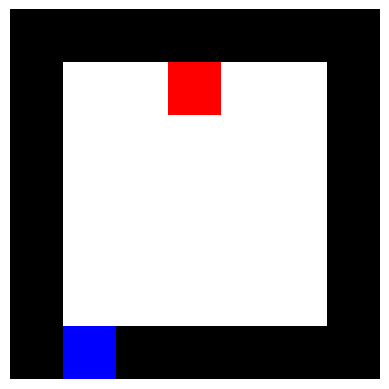

Episode: 2236415 
    Avg Iterations (last 4096 episodes): 5.12 
    Avg Score (last 4096): 0.9304 
    SnakeLength: 1.120849609375 
    Eplsilon: 0.09615665121561603 
    Learning Rate: 0.1
    


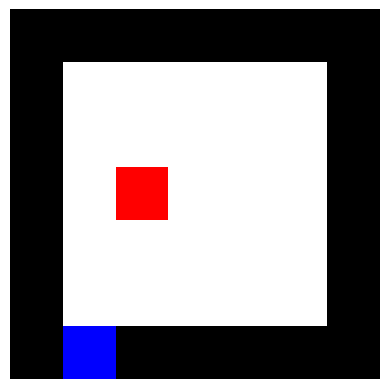

Episode: 2240511 
    Avg Iterations (last 4096 episodes): 5.18 
    Avg Score (last 4096): 0.9578 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.0957635988963761 
    Learning Rate: 0.1
    


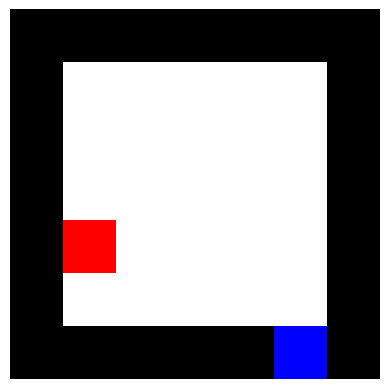

Episode: 2244607 
    Avg Iterations (last 4096 episodes): 5.28 
    Avg Score (last 4096): 1.0091 
    SnakeLength: 1.111328125 
    Eplsilon: 0.09537215322757274 
    Learning Rate: 0.1
    


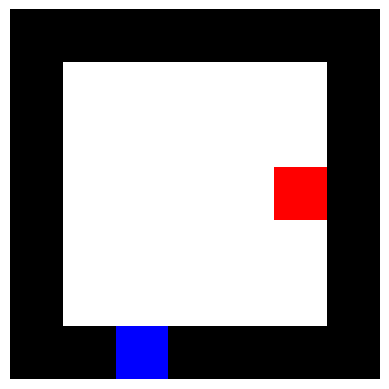

Episode: 2248703 
    Avg Iterations (last 4096 episodes): 5.21 
    Avg Score (last 4096): 0.9499 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.09498230764182226 
    Learning Rate: 0.1
    


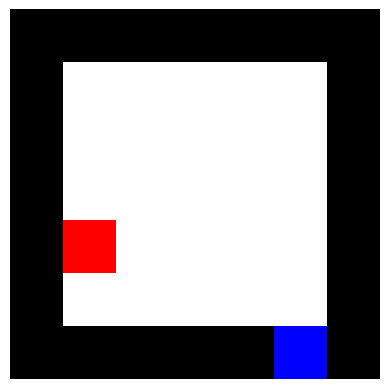

Episode: 2252799 
    Avg Iterations (last 4096 episodes): 5.25 
    Avg Score (last 4096): 1.0039 
    SnakeLength: 1.127197265625 
    Eplsilon: 0.09459405559858469 
    Learning Rate: 0.1
    


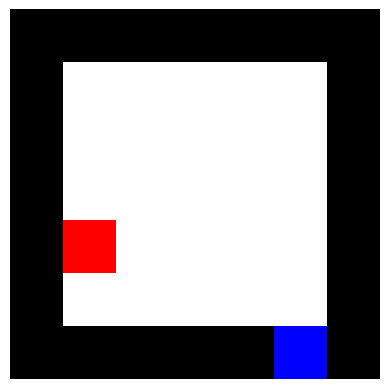

Episode: 2256895 
    Avg Iterations (last 4096 episodes): 5.06 
    Avg Score (last 4096): 0.8839 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.09420739058405614 
    Learning Rate: 0.1
    


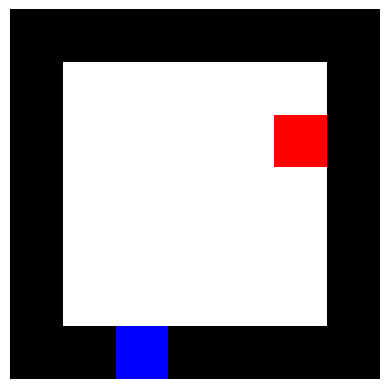

Episode: 2260991 
    Avg Iterations (last 4096 episodes): 5.14 
    Avg Score (last 4096): 0.9098 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.09382230611105792 
    Learning Rate: 0.1
    


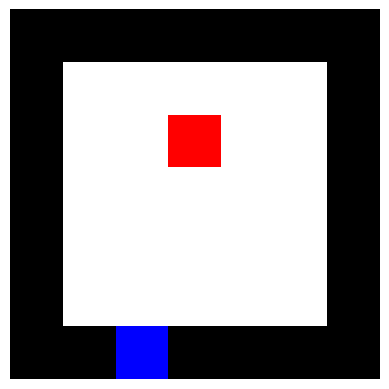

Episode: 2265087 
    Avg Iterations (last 4096 episodes): 5.00 
    Avg Score (last 4096): 0.8403 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.09343879571893048 
    Learning Rate: 0.1
    


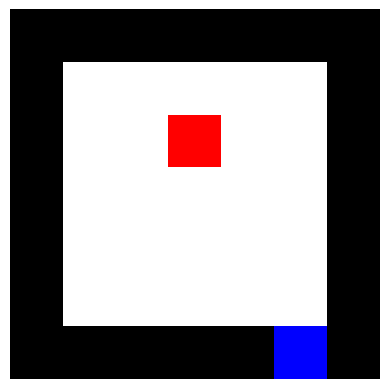

Episode: 2269183 
    Avg Iterations (last 4096 episodes): 5.17 
    Avg Score (last 4096): 0.9217 
    SnakeLength: 1.0986328125 
    Eplsilon: 0.09305685297342077 
    Learning Rate: 0.1
    


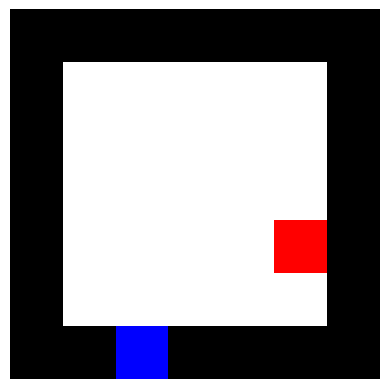

Episode: 2273279 
    Avg Iterations (last 4096 episodes): 5.03 
    Avg Score (last 4096): 0.8577 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.0926764714665782 
    Learning Rate: 0.1
    


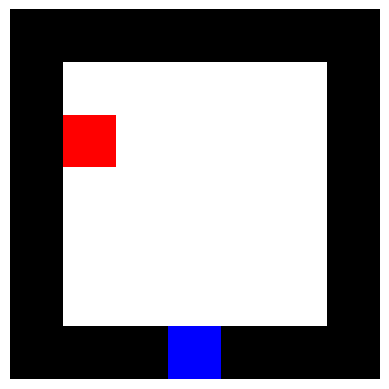

Episode: 2277375 
    Avg Iterations (last 4096 episodes): 5.22 
    Avg Score (last 4096): 0.9738 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.09229764481664395 
    Learning Rate: 0.1
    


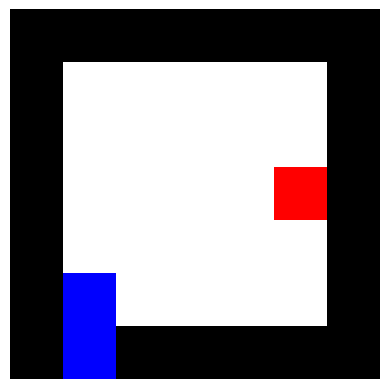

Episode: 2281471 
    Avg Iterations (last 4096 episodes): 5.21 
    Avg Score (last 4096): 0.9525 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.09192036666794699 
    Learning Rate: 0.1
    


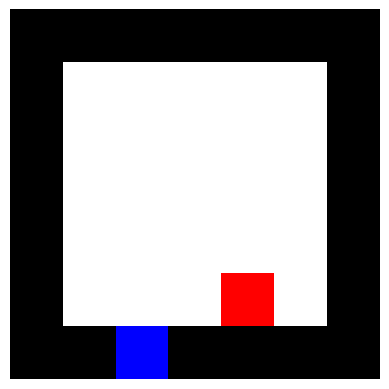

Episode: 2285567 
    Avg Iterations (last 4096 episodes): 5.03 
    Avg Score (last 4096): 0.9324 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.0915446306907946 
    Learning Rate: 0.1
    


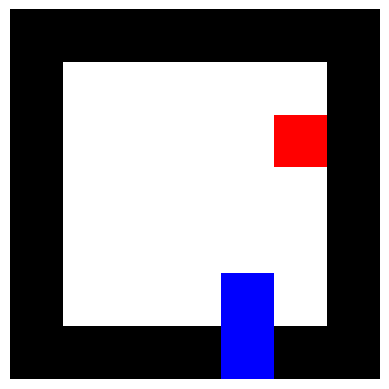

Episode: 2289663 
    Avg Iterations (last 4096 episodes): 5.30 
    Avg Score (last 4096): 1.0016 
    SnakeLength: 1.107421875 
    Eplsilon: 0.0911704305813679 
    Learning Rate: 0.1
    


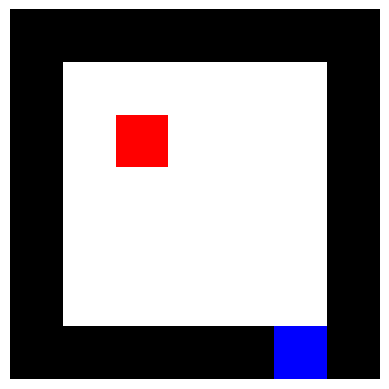

Episode: 2293759 
    Avg Iterations (last 4096 episodes): 5.32 
    Avg Score (last 4096): 0.9905 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.09079776006161633 
    Learning Rate: 0.1
    


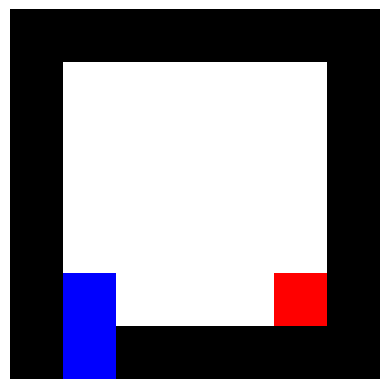

Episode: 2297855 
    Avg Iterations (last 4096 episodes): 5.33 
    Avg Score (last 4096): 1.0160 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.09042661287915069 
    Learning Rate: 0.1
    


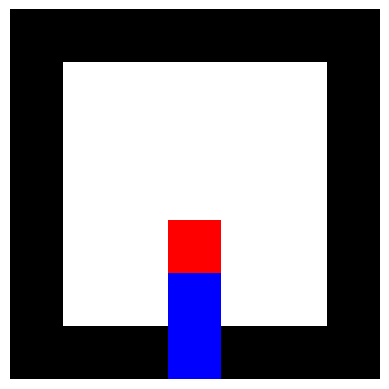

Episode: 2301951 
    Avg Iterations (last 4096 episodes): 5.31 
    Avg Score (last 4096): 0.9890 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.09005698280713961 
    Learning Rate: 0.1
    


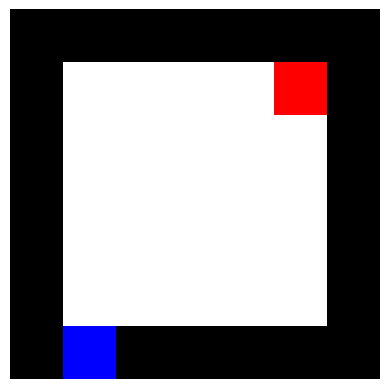

Episode: 2306047 
    Avg Iterations (last 4096 episodes): 4.92 
    Avg Score (last 4096): 0.8431 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.08968886364420485 
    Learning Rate: 0.1
    


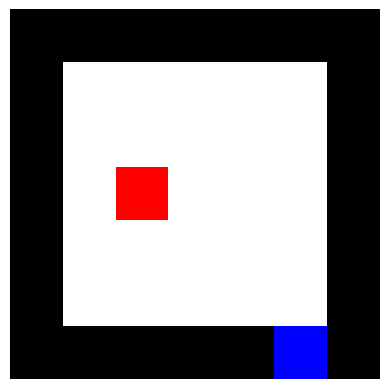

Episode: 2310143 
    Avg Iterations (last 4096 episodes): 5.04 
    Avg Score (last 4096): 0.9093 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.08932224921431714 
    Learning Rate: 0.1
    


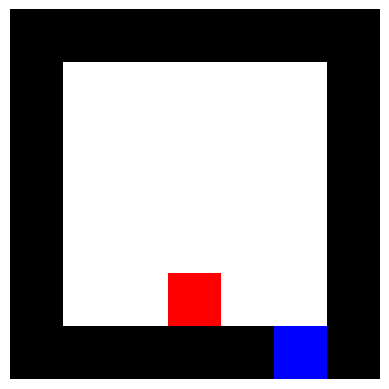

Episode: 2314239 
    Avg Iterations (last 4096 episodes): 5.35 
    Avg Score (last 4096): 1.0164 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.08895713336669192 
    Learning Rate: 0.1
    


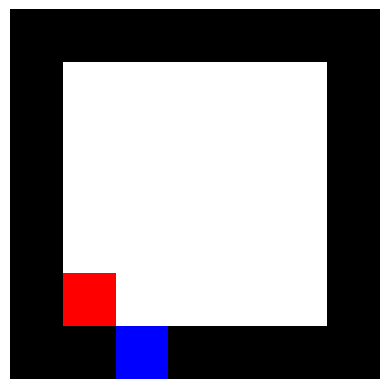

Episode: 2318335 
    Avg Iterations (last 4096 episodes): 5.22 
    Avg Score (last 4096): 0.9623 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.08859350997568693 
    Learning Rate: 0.1
    


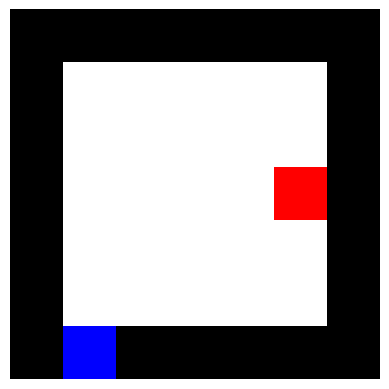

Episode: 2322431 
    Avg Iterations (last 4096 episodes): 5.30 
    Avg Score (last 4096): 0.9918 
    SnakeLength: 1.1171875 
    Eplsilon: 0.08823137294069937 
    Learning Rate: 0.1
    


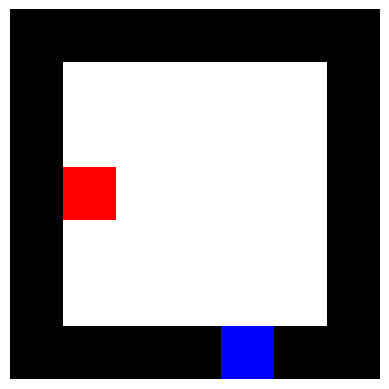

Episode: 2326527 
    Avg Iterations (last 4096 episodes): 4.90 
    Avg Score (last 4096): 0.8058 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.08787071618606371 
    Learning Rate: 0.1
    


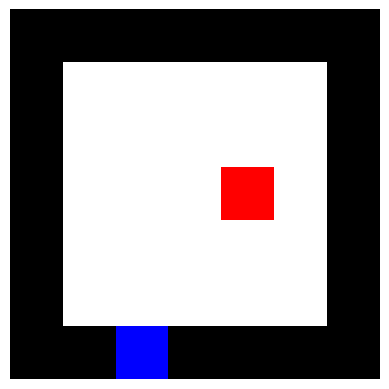

Episode: 2330623 
    Avg Iterations (last 4096 episodes): 5.35 
    Avg Score (last 4096): 1.0471 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.08751153366094876 
    Learning Rate: 0.1
    


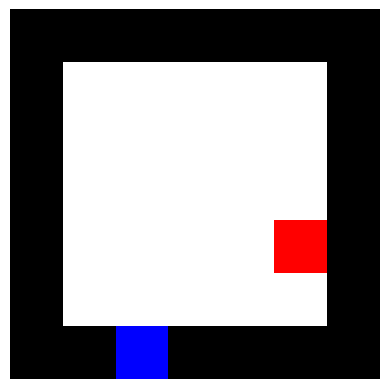

Episode: 2334719 
    Avg Iterations (last 4096 episodes): 5.52 
    Avg Score (last 4096): 1.1023 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.08715381933925789 
    Learning Rate: 0.1
    


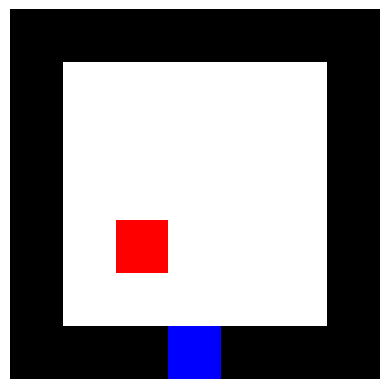

Episode: 2338815 
    Avg Iterations (last 4096 episodes): 5.08 
    Avg Score (last 4096): 0.9215 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.08679756721952579 
    Learning Rate: 0.1
    


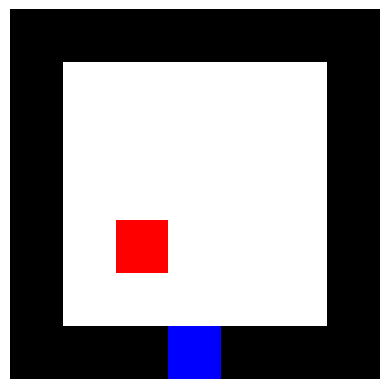

Episode: 2342911 
    Avg Iterations (last 4096 episodes): 5.12 
    Avg Score (last 4096): 0.9301 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.0864427713248194 
    Learning Rate: 0.1
    


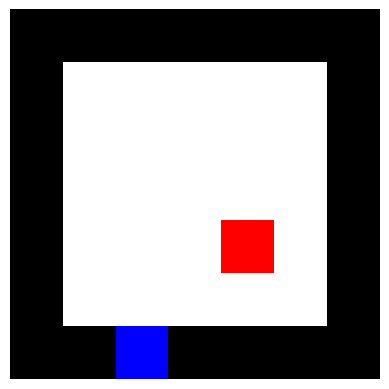

Episode: 2347007 
    Avg Iterations (last 4096 episodes): 5.10 
    Avg Score (last 4096): 0.8813 
    SnakeLength: 1.109375 
    Eplsilon: 0.08608942570263718 
    Learning Rate: 0.1
    


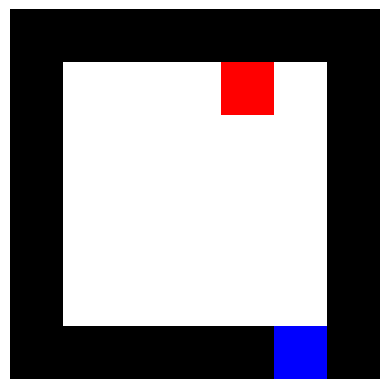

Episode: 2351103 
    Avg Iterations (last 4096 episodes): 5.13 
    Avg Score (last 4096): 0.9147 
    SnakeLength: 1.1015625 
    Eplsilon: 0.08573752442480924 
    Learning Rate: 0.1
    


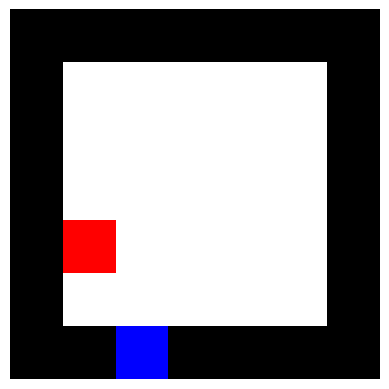

Episode: 2355199 
    Avg Iterations (last 4096 episodes): 5.31 
    Avg Score (last 4096): 0.9919 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.0853870615873971 
    Learning Rate: 0.1
    


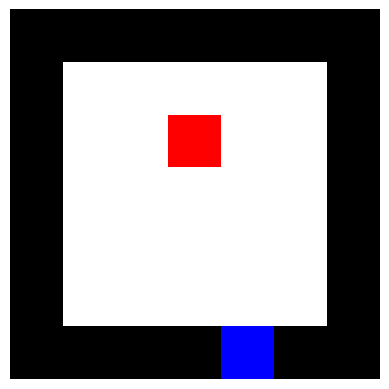

Episode: 2359295 
    Avg Iterations (last 4096 episodes): 5.18 
    Avg Score (last 4096): 0.9511 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.08503803131059587 
    Learning Rate: 0.1
    


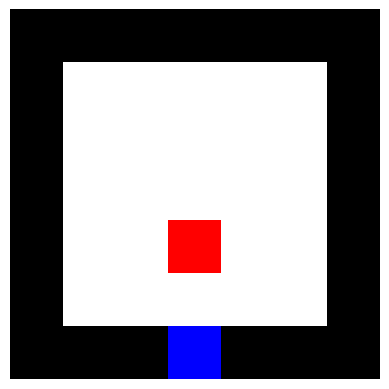

Episode: 2363391 
    Avg Iterations (last 4096 episodes): 5.47 
    Avg Score (last 4096): 1.0970 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.08469042773863641 
    Learning Rate: 0.1
    


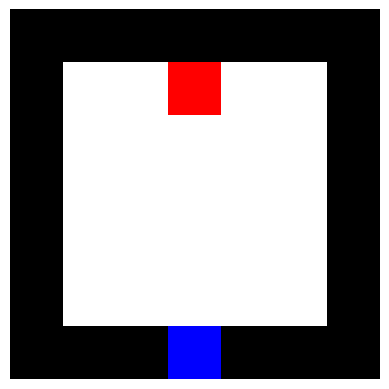

Episode: 2367487 
    Avg Iterations (last 4096 episodes): 5.38 
    Avg Score (last 4096): 1.0183 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.08434424503968337 
    Learning Rate: 0.1
    


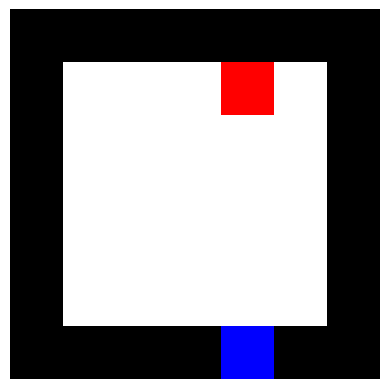

Episode: 2371583 
    Avg Iterations (last 4096 episodes): 5.14 
    Avg Score (last 4096): 0.9314 
    SnakeLength: 1.1171875 
    Eplsilon: 0.0839994774057418 
    Learning Rate: 0.1
    


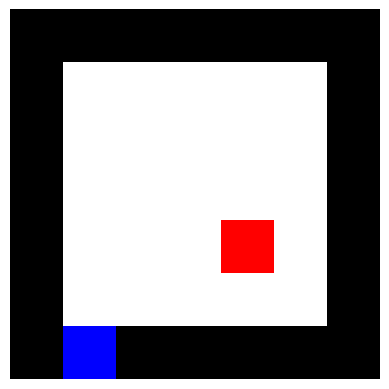

Episode: 2375679 
    Avg Iterations (last 4096 episodes): 5.50 
    Avg Score (last 4096): 1.1085 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.08365611905255585 
    Learning Rate: 0.1
    


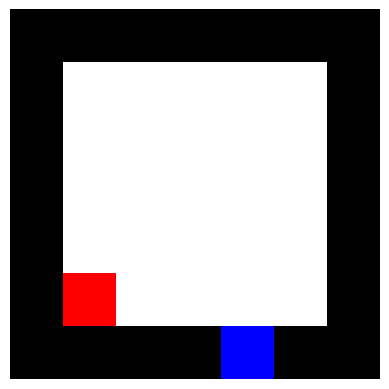

Episode: 2379775 
    Avg Iterations (last 4096 episodes): 5.60 
    Avg Score (last 4096): 1.1634 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.08331416421951543 
    Learning Rate: 0.1
    


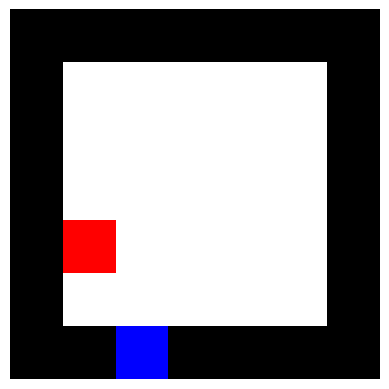

Episode: 2383871 
    Avg Iterations (last 4096 episodes): 5.21 
    Avg Score (last 4096): 0.9688 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.08297360716955596 
    Learning Rate: 0.1
    


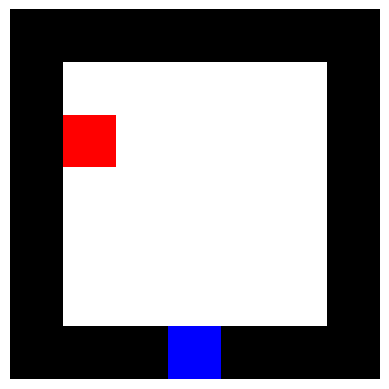

Episode: 2387967 
    Avg Iterations (last 4096 episodes): 5.45 
    Avg Score (last 4096): 1.0898 
    SnakeLength: 1.11328125 
    Eplsilon: 0.0826344421890647 
    Learning Rate: 0.1
    


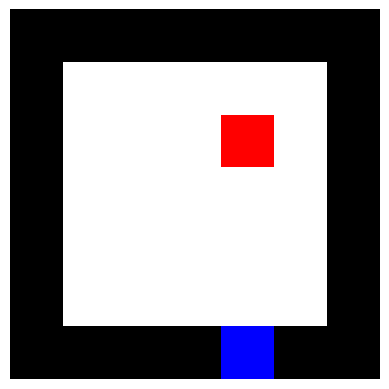

Episode: 2392063 
    Avg Iterations (last 4096 episodes): 5.50 
    Avg Score (last 4096): 1.1178 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.08229666358778355 
    Learning Rate: 0.1
    


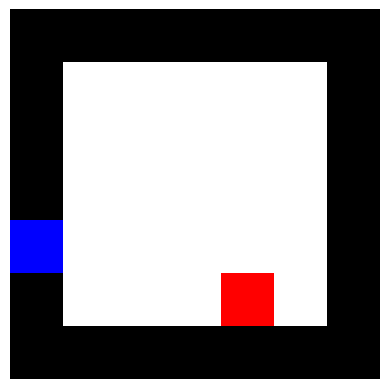

Episode: 2396159 
    Avg Iterations (last 4096 episodes): 5.09 
    Avg Score (last 4096): 0.9325 
    SnakeLength: 1.1240234375 
    Eplsilon: 0.08196026569871463 
    Learning Rate: 0.1
    


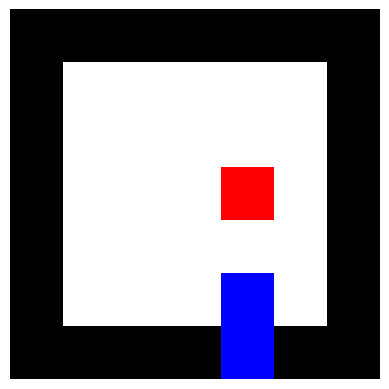

Episode: 2400255 
    Avg Iterations (last 4096 episodes): 5.29 
    Avg Score (last 4096): 0.9978 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.0816252428780245 
    Learning Rate: 0.1
    


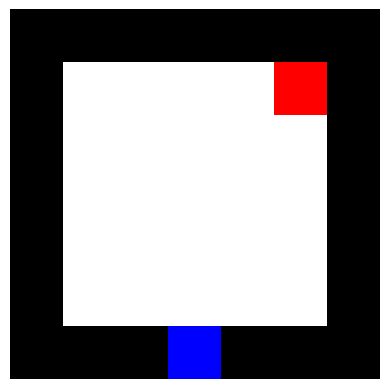

Episode: 2404351 
    Avg Iterations (last 4096 episodes): 5.51 
    Avg Score (last 4096): 1.0842 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.08129158950494905 
    Learning Rate: 0.1
    


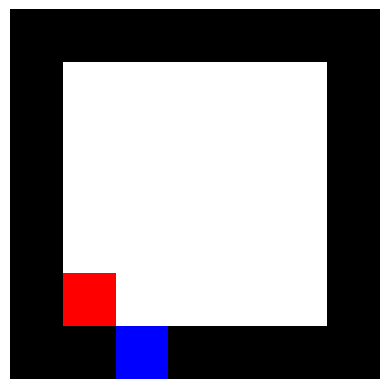

Episode: 2408447 
    Avg Iterations (last 4096 episodes): 5.36 
    Avg Score (last 4096): 1.0212 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.08095929998170033 
    Learning Rate: 0.1
    


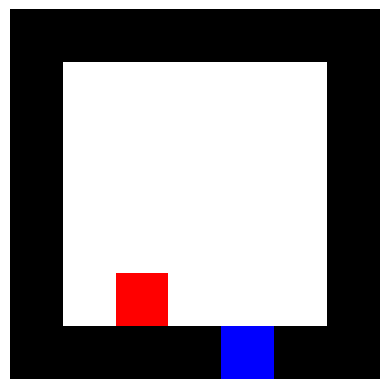

Episode: 2412543 
    Avg Iterations (last 4096 episodes): 5.32 
    Avg Score (last 4096): 1.0124 
    SnakeLength: 1.105224609375 
    Eplsilon: 0.08062836873337202 
    Learning Rate: 0.1
    


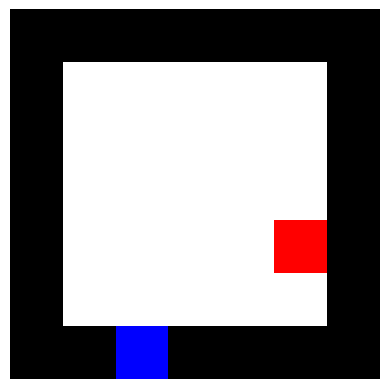

Episode: 2416639 
    Avg Iterations (last 4096 episodes): 5.45 
    Avg Score (last 4096): 1.0789 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.0802987902078458 
    Learning Rate: 0.1
    


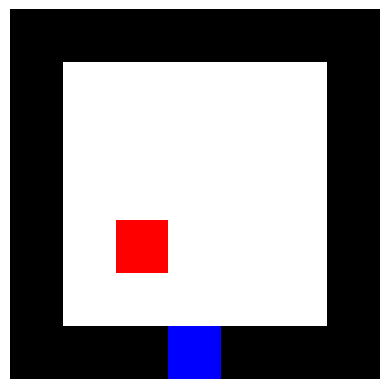

Episode: 2420735 
    Avg Iterations (last 4096 episodes): 5.50 
    Avg Score (last 4096): 1.1073 
    SnakeLength: 1.122314453125 
    Eplsilon: 0.07997055887569818 
    Learning Rate: 0.1
    


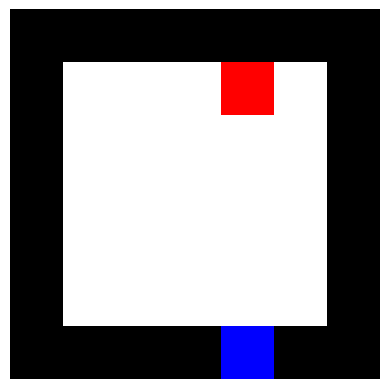

Episode: 2424831 
    Avg Iterations (last 4096 episodes): 5.18 
    Avg Score (last 4096): 0.9473 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.07964366923010831 
    Learning Rate: 0.1
    


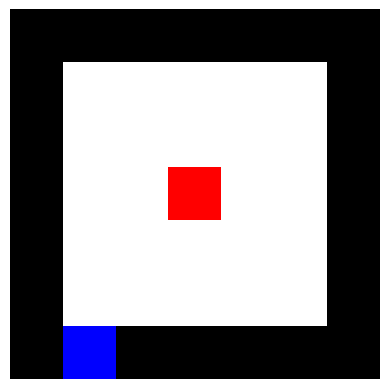

Episode: 2428927 
    Avg Iterations (last 4096 episodes): 5.38 
    Avg Score (last 4096): 1.0139 
    SnakeLength: 1.109375 
    Eplsilon: 0.07931811578676452 
    Learning Rate: 0.1
    


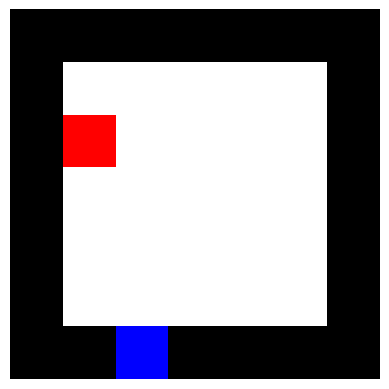

Episode: 2433023 
    Avg Iterations (last 4096 episodes): 5.31 
    Avg Score (last 4096): 0.9804 
    SnakeLength: 1.103759765625 
    Eplsilon: 0.07899389308377298 
    Learning Rate: 0.1
    


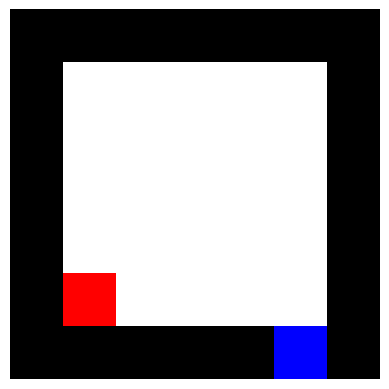

Episode: 2437119 
    Avg Iterations (last 4096 episodes): 5.17 
    Avg Score (last 4096): 0.9633 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.07867099568156717 
    Learning Rate: 0.1
    


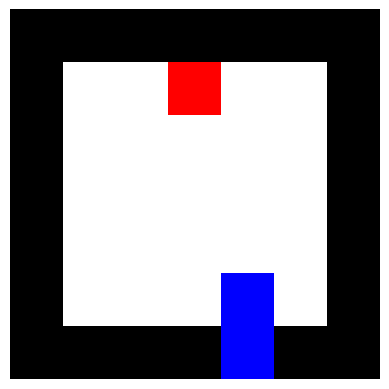

Episode: 2441215 
    Avg Iterations (last 4096 episodes): 5.59 
    Avg Score (last 4096): 1.1130 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.07834941816281418 
    Learning Rate: 0.1
    


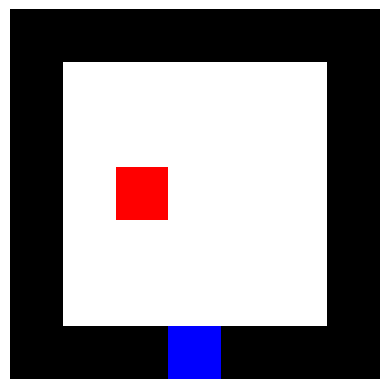

Episode: 2445311 
    Avg Iterations (last 4096 episodes): 5.49 
    Avg Score (last 4096): 1.0985 
    SnakeLength: 1.1171875 
    Eplsilon: 0.0780291551323252 
    Learning Rate: 0.1
    


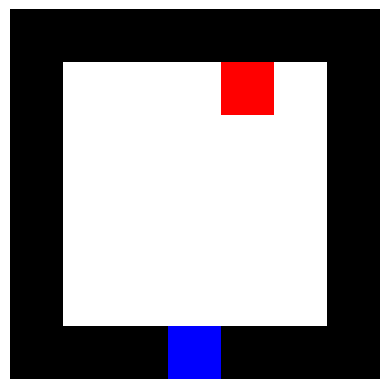

Episode: 2449407 
    Avg Iterations (last 4096 episodes): 5.68 
    Avg Score (last 4096): 1.2031 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.07771020121696554 
    Learning Rate: 0.1
    


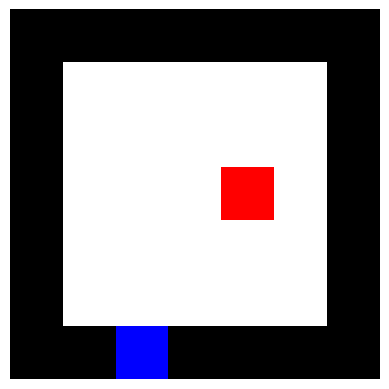

Episode: 2453503 
    Avg Iterations (last 4096 episodes): 5.33 
    Avg Score (last 4096): 1.0336 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.07739255106556381 
    Learning Rate: 0.1
    


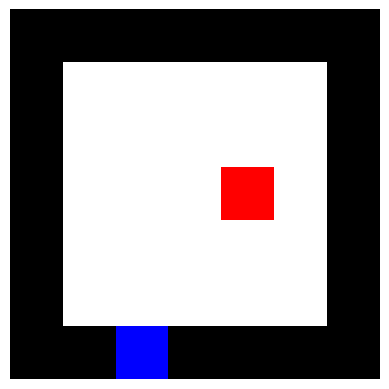

Episode: 2457599 
    Avg Iterations (last 4096 episodes): 5.79 
    Avg Score (last 4096): 1.1920 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.07707619934882234 
    Learning Rate: 0.1
    


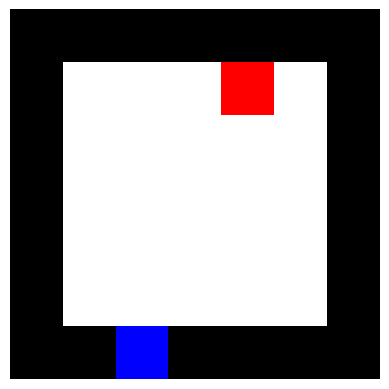

Episode: 2461695 
    Avg Iterations (last 4096 episodes): 5.36 
    Avg Score (last 4096): 1.0392 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.07676114075922665 
    Learning Rate: 0.1
    


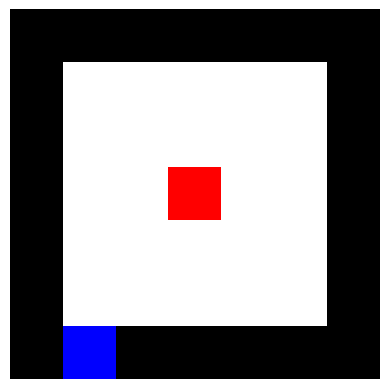

Episode: 2465791 
    Avg Iterations (last 4096 episodes): 5.25 
    Avg Score (last 4096): 0.9741 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.07644737001095867 
    Learning Rate: 0.1
    


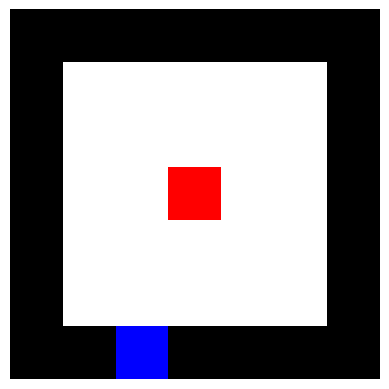

Episode: 2469887 
    Avg Iterations (last 4096 episodes): 5.15 
    Avg Score (last 4096): 0.9369 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.07613488183980523 
    Learning Rate: 0.1
    


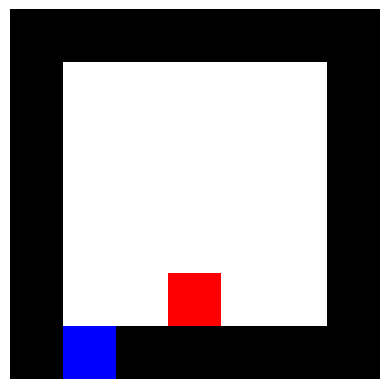

Episode: 2473983 
    Avg Iterations (last 4096 episodes): 5.30 
    Avg Score (last 4096): 0.9862 
    SnakeLength: 1.111328125 
    Eplsilon: 0.07582367100307287 
    Learning Rate: 0.1
    


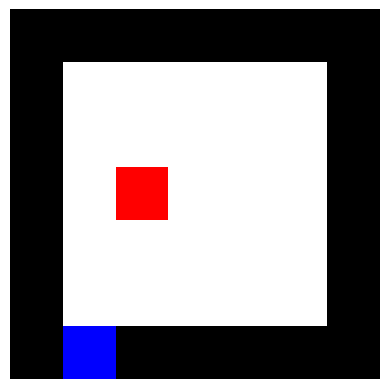

Episode: 2478079 
    Avg Iterations (last 4096 episodes): 5.34 
    Avg Score (last 4096): 0.9988 
    SnakeLength: 1.116943359375 
    Eplsilon: 0.07551373227949794 
    Learning Rate: 0.1
    


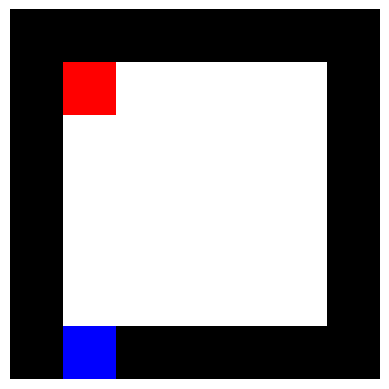

Episode: 2482175 
    Avg Iterations (last 4096 episodes): 5.72 
    Avg Score (last 4096): 1.2043 
    SnakeLength: 1.100830078125 
    Eplsilon: 0.07520506046915888 
    Learning Rate: 0.1
    


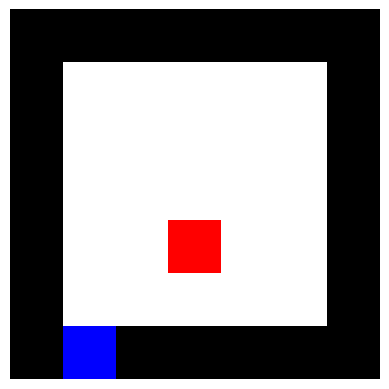

Episode: 2486271 
    Avg Iterations (last 4096 episodes): 5.16 
    Avg Score (last 4096): 0.9634 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.0748976503933895 
    Learning Rate: 0.1
    


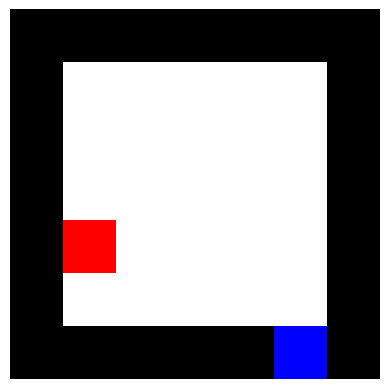

Episode: 2490367 
    Avg Iterations (last 4096 episodes): 5.66 
    Avg Score (last 4096): 1.1471 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.07459149689469154 
    Learning Rate: 0.1
    


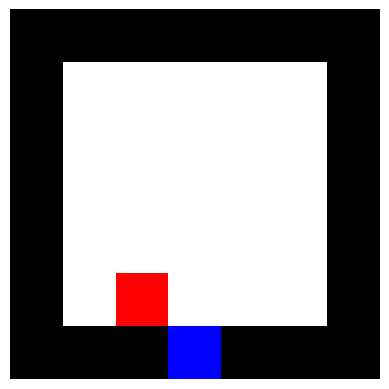

Episode: 2494463 
    Avg Iterations (last 4096 episodes): 5.51 
    Avg Score (last 4096): 1.1120 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.07428659483664997 
    Learning Rate: 0.1
    


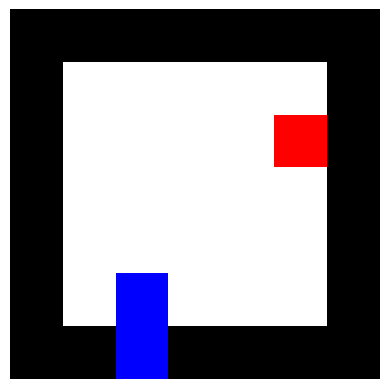

Episode: 2498559 
    Avg Iterations (last 4096 episodes): 5.32 
    Avg Score (last 4096): 1.0396 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.0739829391038446 
    Learning Rate: 0.1
    


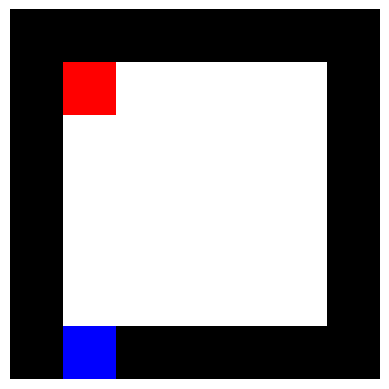

Episode: 2502655 
    Avg Iterations (last 4096 episodes): 5.71 
    Avg Score (last 4096): 1.1702 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.07368052460176591 
    Learning Rate: 0.1
    


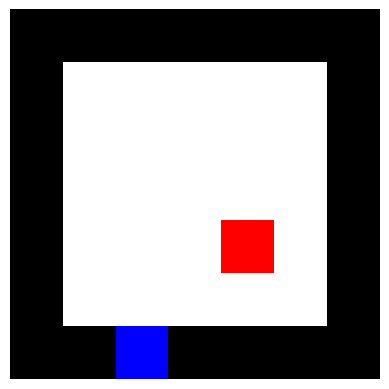

Episode: 2506751 
    Avg Iterations (last 4096 episodes): 5.72 
    Avg Score (last 4096): 1.2132 
    SnakeLength: 1.115966796875 
    Eplsilon: 0.07337934625672791 
    Learning Rate: 0.1
    


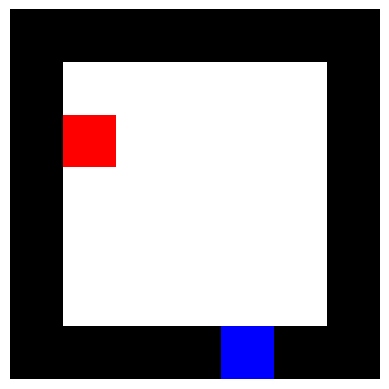

Episode: 2510847 
    Avg Iterations (last 4096 episodes): 5.38 
    Avg Score (last 4096): 1.0283 
    SnakeLength: 1.1171875 
    Eplsilon: 0.07307939901578431 
    Learning Rate: 0.1
    


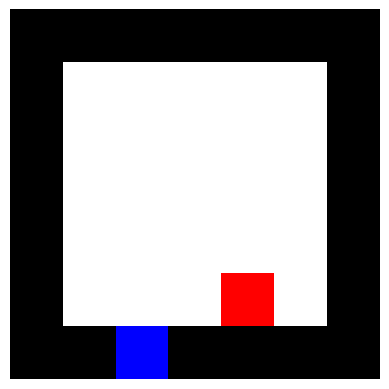

Episode: 2514943 
    Avg Iterations (last 4096 episodes): 5.28 
    Avg Score (last 4096): 0.9911 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.07278067784664352 
    Learning Rate: 0.1
    


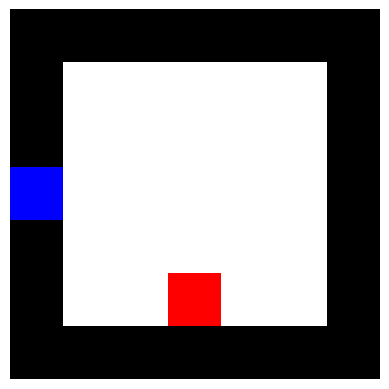

Episode: 2519039 
    Avg Iterations (last 4096 episodes): 5.64 
    Avg Score (last 4096): 1.1291 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.07248317773758392 
    Learning Rate: 0.1
    


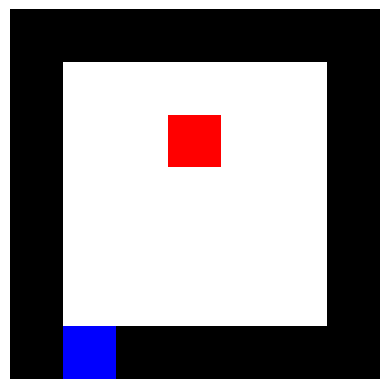

Episode: 2523135 
    Avg Iterations (last 4096 episodes): 5.40 
    Avg Score (last 4096): 1.0429 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.07218689369736979 
    Learning Rate: 0.1
    


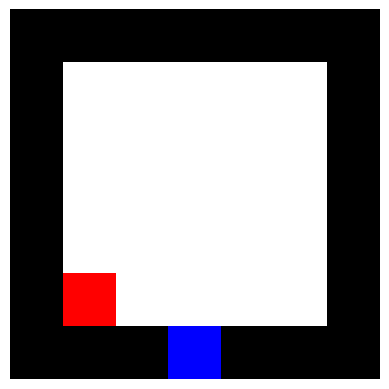

Episode: 2527231 
    Avg Iterations (last 4096 episodes): 5.74 
    Avg Score (last 4096): 1.2496 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.07189182075516809 
    Learning Rate: 0.1
    


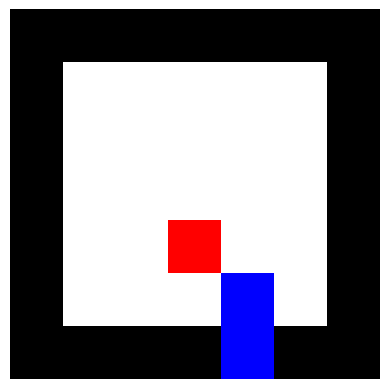

Episode: 2531327 
    Avg Iterations (last 4096 episodes): 5.28 
    Avg Score (last 4096): 0.9888 
    SnakeLength: 1.10205078125 
    Eplsilon: 0.07159795396046419 
    Learning Rate: 0.1
    


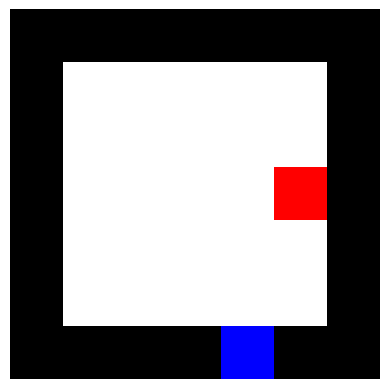

Episode: 2535423 
    Avg Iterations (last 4096 episodes): 5.81 
    Avg Score (last 4096): 1.2099 
    SnakeLength: 1.1171875 
    Eplsilon: 0.07130528838297988 
    Learning Rate: 0.1
    


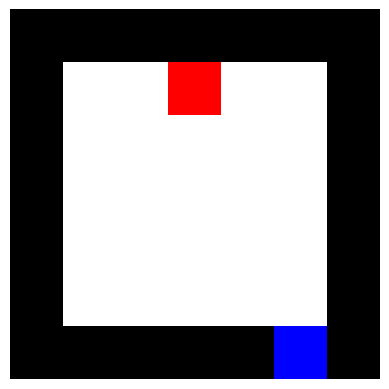

Episode: 2539519 
    Avg Iterations (last 4096 episodes): 5.68 
    Avg Score (last 4096): 1.1784 
    SnakeLength: 1.107421875 
    Eplsilon: 0.07101381911258926 
    Learning Rate: 0.1
    


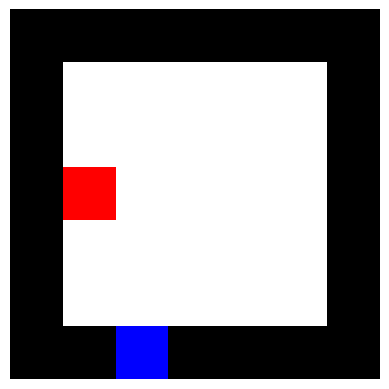

Episode: 2543615 
    Avg Iterations (last 4096 episodes): 5.92 
    Avg Score (last 4096): 1.2404 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.07072354125923871 
    Learning Rate: 0.1
    


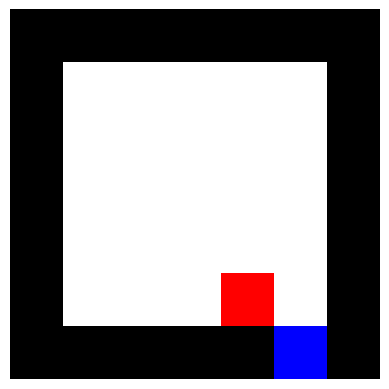

Episode: 2547711 
    Avg Iterations (last 4096 episodes): 5.58 
    Avg Score (last 4096): 1.1489 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.07043444995286129 
    Learning Rate: 0.1
    


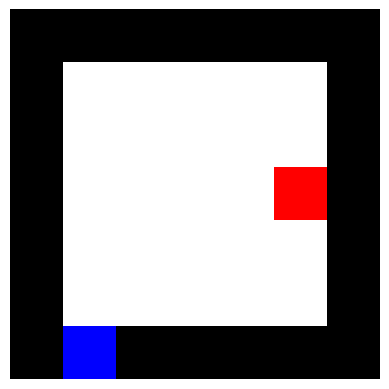

Episode: 2551807 
    Avg Iterations (last 4096 episodes): 6.26 
    Avg Score (last 4096): 1.3698 
    SnakeLength: 1.109375 
    Eplsilon: 0.07014654034329833 
    Learning Rate: 0.1
    


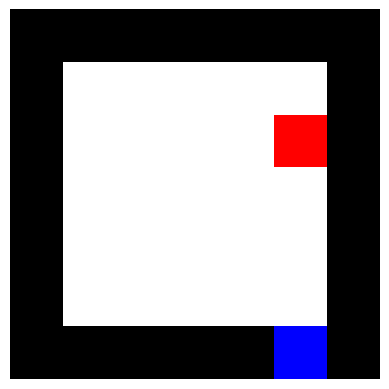

Episode: 2555903 
    Avg Iterations (last 4096 episodes): 5.42 
    Avg Score (last 4096): 1.0213 
    SnakeLength: 1.10546875 
    Eplsilon: 0.0698598076002167 
    Learning Rate: 0.1
    


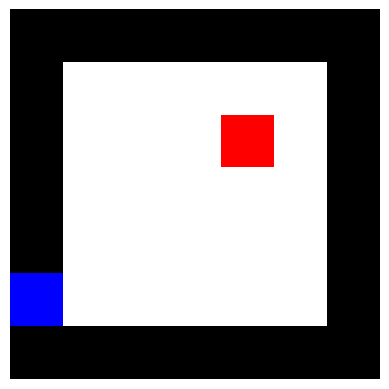

Episode: 2559999 
    Avg Iterations (last 4096 episodes): 5.77 
    Avg Score (last 4096): 1.2191 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.06957424691302774 
    Learning Rate: 0.1
    


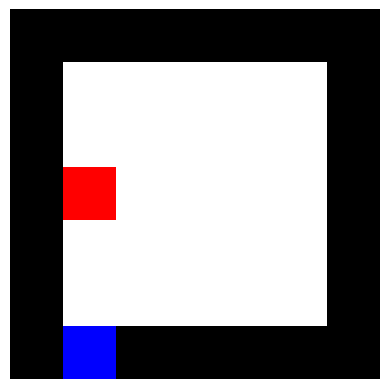

Episode: 2564095 
    Avg Iterations (last 4096 episodes): 5.65 
    Avg Score (last 4096): 1.1451 
    SnakeLength: 1.109375 
    Eplsilon: 0.06928985349080664 
    Learning Rate: 0.1
    


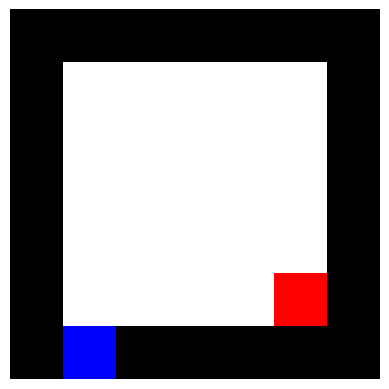

Episode: 2568191 
    Avg Iterations (last 4096 episodes): 5.82 
    Avg Score (last 4096): 1.2409 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.06900662256221202 
    Learning Rate: 0.1
    


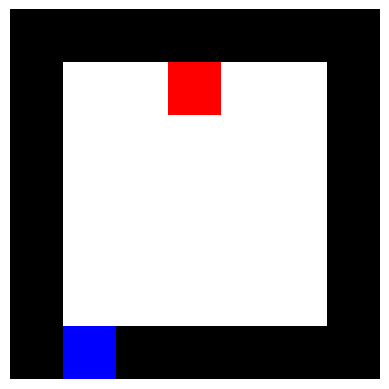

Episode: 2572287 
    Avg Iterations (last 4096 episodes): 5.61 
    Avg Score (last 4096): 1.1057 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.06872454937540598 
    Learning Rate: 0.1
    


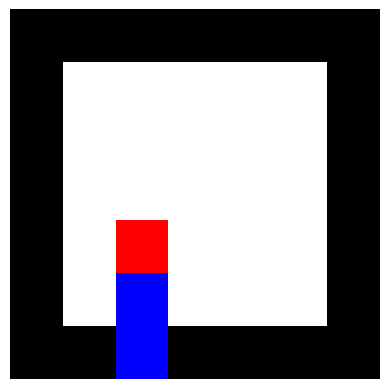

Episode: 2576383 
    Avg Iterations (last 4096 episodes): 5.78 
    Avg Score (last 4096): 1.1857 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.06844362919797446 
    Learning Rate: 0.1
    


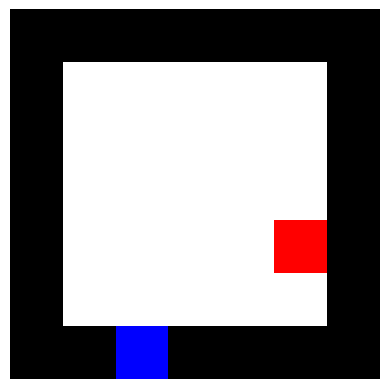

Episode: 2580479 
    Avg Iterations (last 4096 episodes): 5.53 
    Avg Score (last 4096): 1.1181 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.0681638573168479 
    Learning Rate: 0.1
    


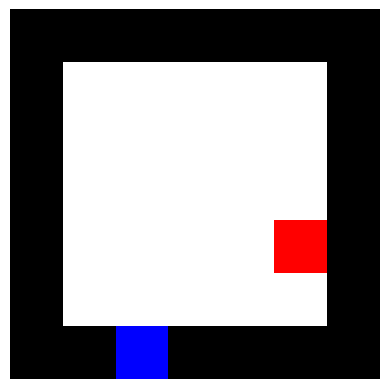

Episode: 2584575 
    Avg Iterations (last 4096 episodes): 5.65 
    Avg Score (last 4096): 1.1915 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.067885229038221 
    Learning Rate: 0.1
    


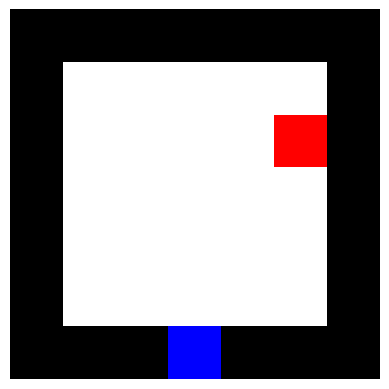

Episode: 2588671 
    Avg Iterations (last 4096 episodes): 5.83 
    Avg Score (last 4096): 1.1616 
    SnakeLength: 1.10009765625 
    Eplsilon: 0.06760773968747649 
    Learning Rate: 0.1
    


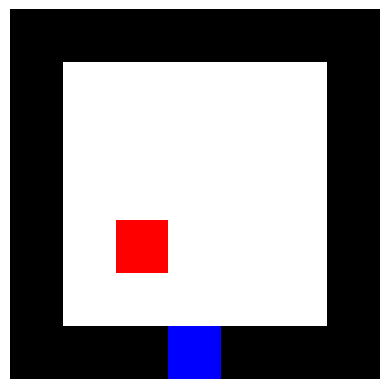

Episode: 2592767 
    Avg Iterations (last 4096 episodes): 5.62 
    Avg Score (last 4096): 1.1172 
    SnakeLength: 1.09912109375 
    Eplsilon: 0.06733138460910401 
    Learning Rate: 0.1
    


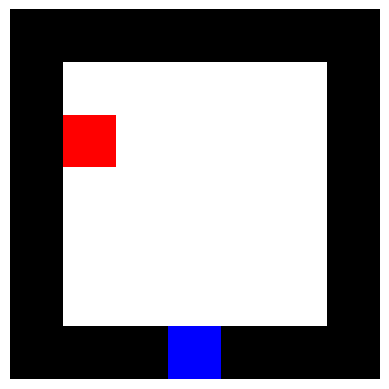

Episode: 2596863 
    Avg Iterations (last 4096 episodes): 5.56 
    Avg Score (last 4096): 1.1648 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.06705615916662372 
    Learning Rate: 0.1
    


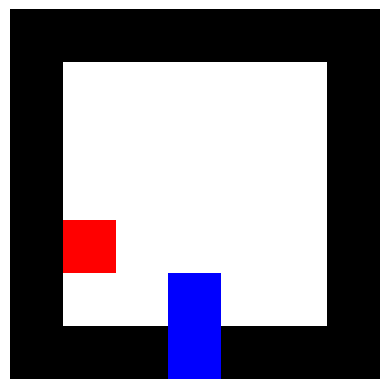

Episode: 2600959 
    Avg Iterations (last 4096 episodes): 5.77 
    Avg Score (last 4096): 1.2137 
    SnakeLength: 1.101318359375 
    Eplsilon: 0.06678205874250788 
    Learning Rate: 0.1
    


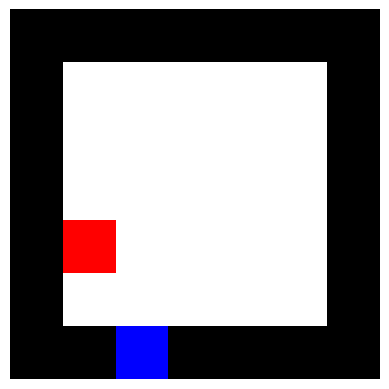

Episode: 2605055 
    Avg Iterations (last 4096 episodes): 6.24 
    Avg Score (last 4096): 1.4573 
    SnakeLength: 1.12255859375 
    Eplsilon: 0.06650907873810302 
    Learning Rate: 0.1
    


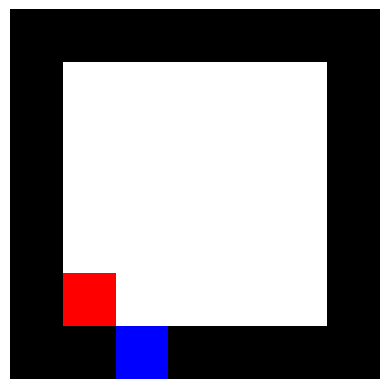

Episode: 2609151 
    Avg Iterations (last 4096 episodes): 5.61 
    Avg Score (last 4096): 1.1154 
    SnakeLength: 1.111328125 
    Eplsilon: 0.06623721457355476 
    Learning Rate: 0.1
    


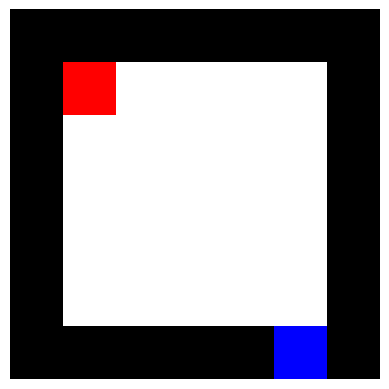

Episode: 2613247 
    Avg Iterations (last 4096 episodes): 5.82 
    Avg Score (last 4096): 1.2071 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.06596646168772768 
    Learning Rate: 0.1
    


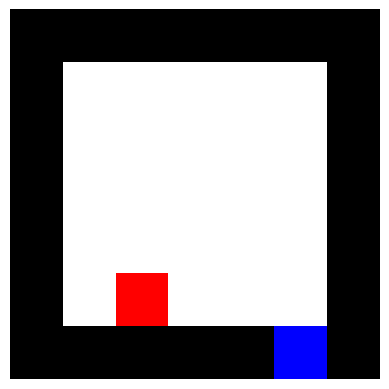

Episode: 2617343 
    Avg Iterations (last 4096 episodes): 5.52 
    Avg Score (last 4096): 1.1299 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.06569681553813107 
    Learning Rate: 0.1
    


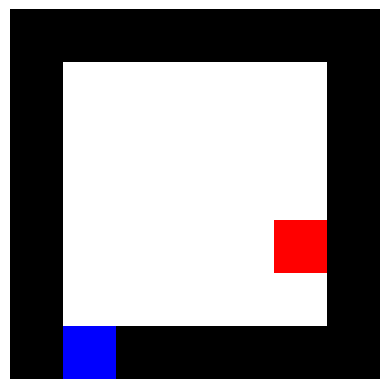

Episode: 2621439 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.3444 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.06542827160084244 
    Learning Rate: 0.1
    


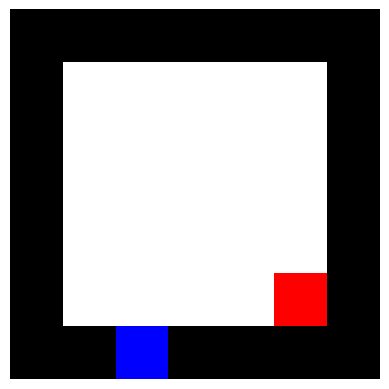

Episode: 2625535 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.3374 
    SnakeLength: 1.115234375 
    Eplsilon: 0.06516082537043134 
    Learning Rate: 0.1
    


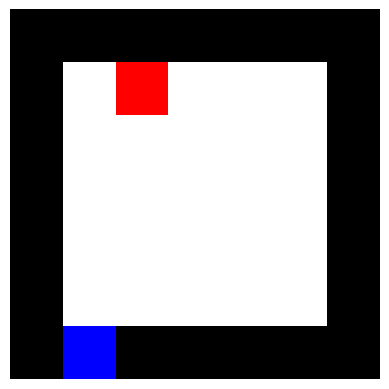

Episode: 2629631 
    Avg Iterations (last 4096 episodes): 5.91 
    Avg Score (last 4096): 1.2858 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.06489447235988405 
    Learning Rate: 0.1
    


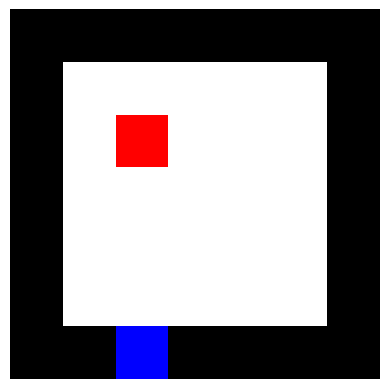

Episode: 2633727 
    Avg Iterations (last 4096 episodes): 6.00 
    Avg Score (last 4096): 1.3382 
    SnakeLength: 1.10009765625 
    Eplsilon: 0.06462920810052754 
    Learning Rate: 0.1
    


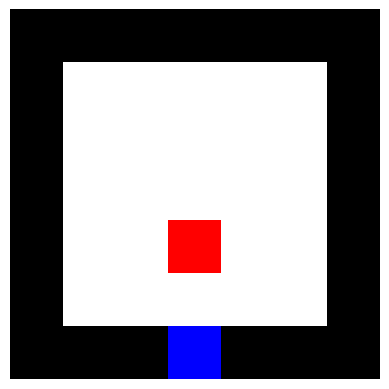

Episode: 2637823 
    Avg Iterations (last 4096 episodes): 5.93 
    Avg Score (last 4096): 1.2543 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.06436502814195594 
    Learning Rate: 0.1
    


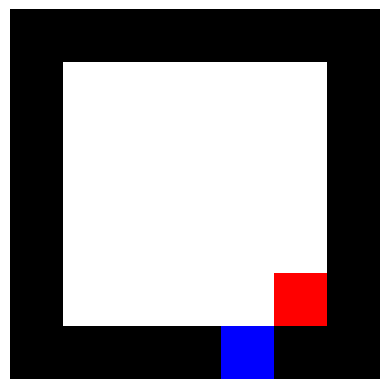

Episode: 2641919 
    Avg Iterations (last 4096 episodes): 5.74 
    Avg Score (last 4096): 1.2249 
    SnakeLength: 1.12060546875 
    Eplsilon: 0.06410192805195399 
    Learning Rate: 0.1
    


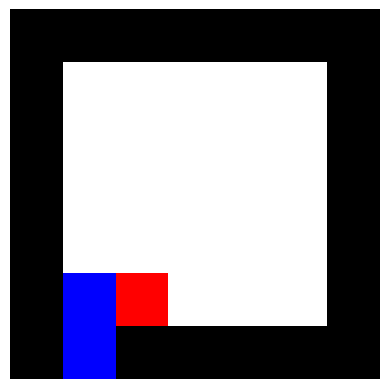

Episode: 2646015 
    Avg Iterations (last 4096 episodes): 5.95 
    Avg Score (last 4096): 1.2695 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.06383990341642334 
    Learning Rate: 0.1
    


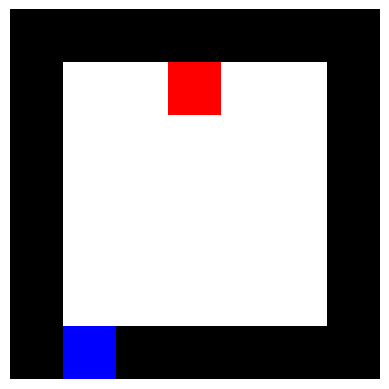

Episode: 2650111 
    Avg Iterations (last 4096 episodes): 6.13 
    Avg Score (last 4096): 1.3655 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.06357894983931096 
    Learning Rate: 0.1
    


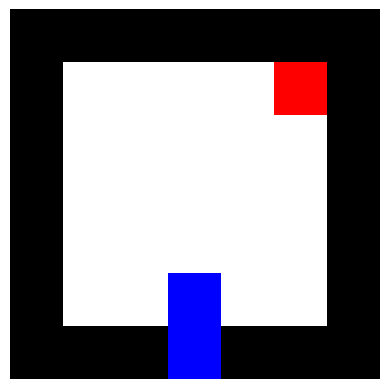

Episode: 2654207 
    Avg Iterations (last 4096 episodes): 6.18 
    Avg Score (last 4096): 1.4013 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.06331906294253083 
    Learning Rate: 0.1
    


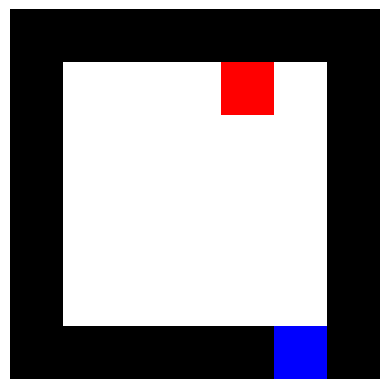

Episode: 2658303 
    Avg Iterations (last 4096 episodes): 5.43 
    Avg Score (last 4096): 1.0533 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.06306023836589453 
    Learning Rate: 0.1
    


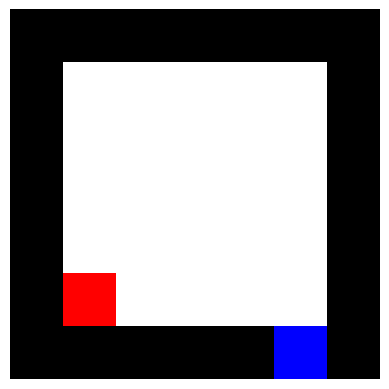

Episode: 2662399 
    Avg Iterations (last 4096 episodes): 6.10 
    Avg Score (last 4096): 1.3209 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.06280247176703514 
    Learning Rate: 0.1
    


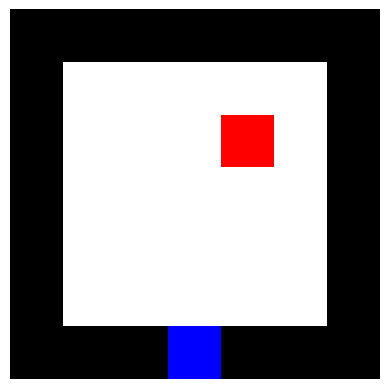

Episode: 2666495 
    Avg Iterations (last 4096 episodes): 6.31 
    Avg Score (last 4096): 1.4581 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.06254575882133653 
    Learning Rate: 0.1
    


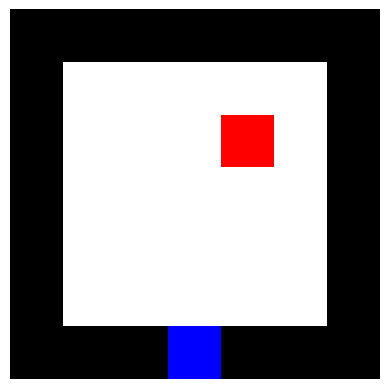

Episode: 2670591 
    Avg Iterations (last 4096 episodes): 5.72 
    Avg Score (last 4096): 1.1886 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.062290095221860714 
    Learning Rate: 0.1
    


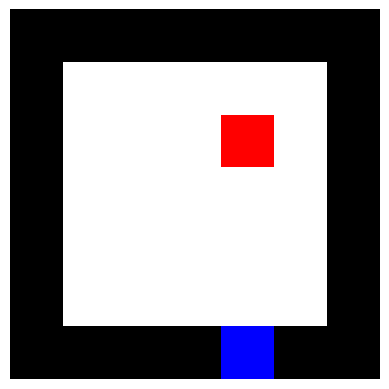

Episode: 2674687 
    Avg Iterations (last 4096 episodes): 6.01 
    Avg Score (last 4096): 1.2691 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.062035476679273 
    Learning Rate: 0.1
    


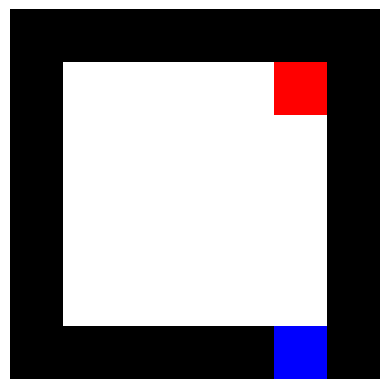

Episode: 2678783 
    Avg Iterations (last 4096 episodes): 5.80 
    Avg Score (last 4096): 1.2554 
    SnakeLength: 1.10302734375 
    Eplsilon: 0.06178189892177333 
    Learning Rate: 0.1
    


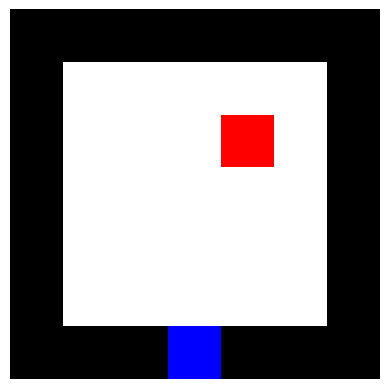

Episode: 2682879 
    Avg Iterations (last 4096 episodes): 5.90 
    Avg Score (last 4096): 1.2773 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.06152935769502249 
    Learning Rate: 0.1
    


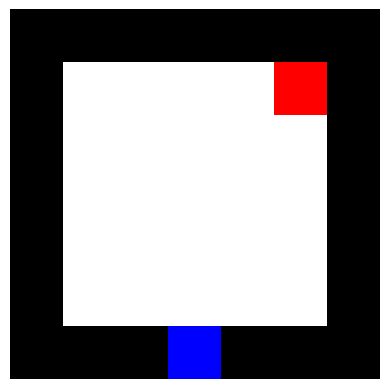

Episode: 2686975 
    Avg Iterations (last 4096 episodes): 6.23 
    Avg Score (last 4096): 1.4249 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.061277848762071804 
    Learning Rate: 0.1
    


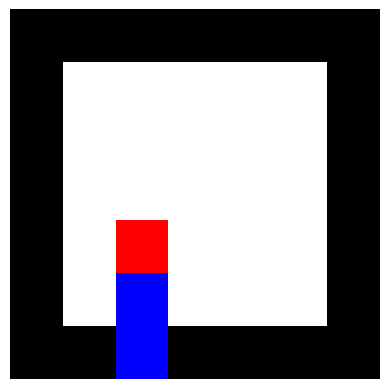

Episode: 2691071 
    Avg Iterations (last 4096 episodes): 5.80 
    Avg Score (last 4096): 1.2256 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.06102736790329122 
    Learning Rate: 0.1
    


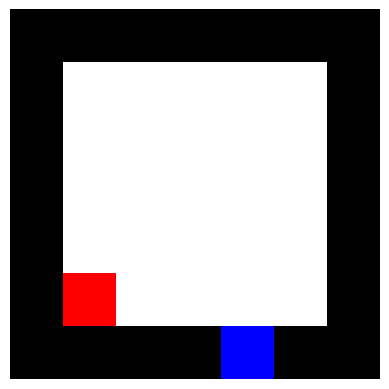

Episode: 2695167 
    Avg Iterations (last 4096 episodes): 6.05 
    Avg Score (last 4096): 1.3175 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.06077791091629924 
    Learning Rate: 0.1
    


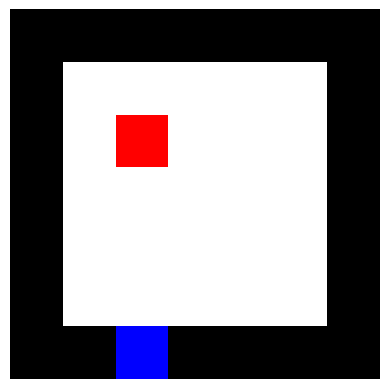

Episode: 2699263 
    Avg Iterations (last 4096 episodes): 5.77 
    Avg Score (last 4096): 1.2431 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.06052947361589204 
    Learning Rate: 0.1
    


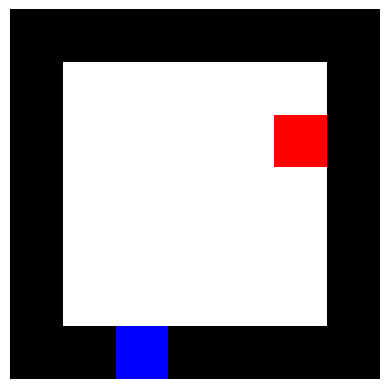

Episode: 2703359 
    Avg Iterations (last 4096 episodes): 6.23 
    Avg Score (last 4096): 1.4001 
    SnakeLength: 1.115234375 
    Eplsilon: 0.06028205183397358 
    Learning Rate: 0.1
    


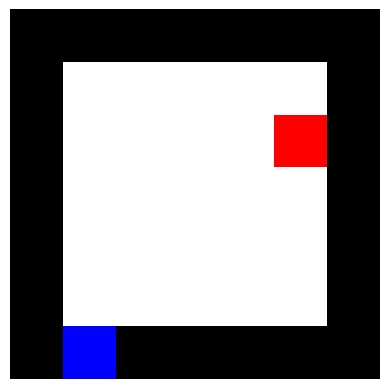

Episode: 2707455 
    Avg Iterations (last 4096 episodes): 6.14 
    Avg Score (last 4096): 1.3610 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.06003564141948495 
    Learning Rate: 0.1
    


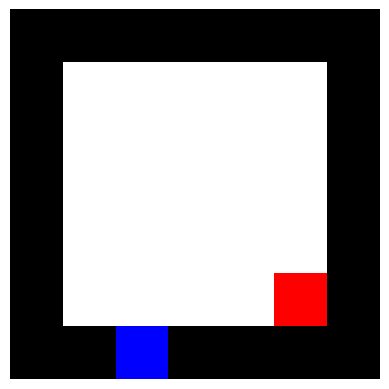

Episode: 2711551 
    Avg Iterations (last 4096 episodes): 5.72 
    Avg Score (last 4096): 1.2547 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.059790238238335666 
    Learning Rate: 0.1
    


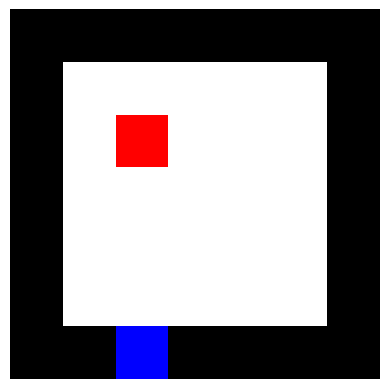

Episode: 2715647 
    Avg Iterations (last 4096 episodes): 6.06 
    Avg Score (last 4096): 1.3576 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.05954583817333367 
    Learning Rate: 0.1
    


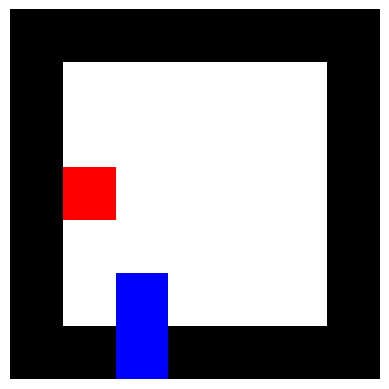

Episode: 2719743 
    Avg Iterations (last 4096 episodes): 6.15 
    Avg Score (last 4096): 1.3760 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.059302437124116335 
    Learning Rate: 0.1
    


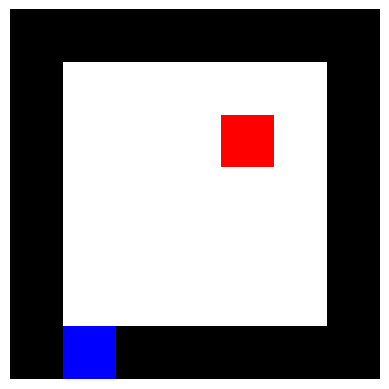

Episode: 2723839 
    Avg Iterations (last 4096 episodes): 6.01 
    Avg Score (last 4096): 1.3297 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.05906003100708201 
    Learning Rate: 0.1
    


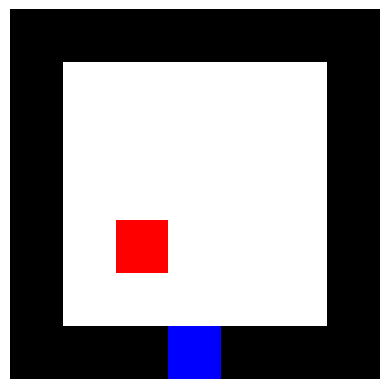

Episode: 2727935 
    Avg Iterations (last 4096 episodes): 5.80 
    Avg Score (last 4096): 1.2267 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.05881861575532089 
    Learning Rate: 0.1
    


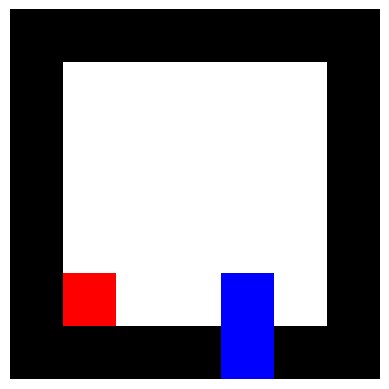

Episode: 2732031 
    Avg Iterations (last 4096 episodes): 5.67 
    Avg Score (last 4096): 1.1874 
    SnakeLength: 1.1162109375 
    Eplsilon: 0.05857818731854785 
    Learning Rate: 0.1
    


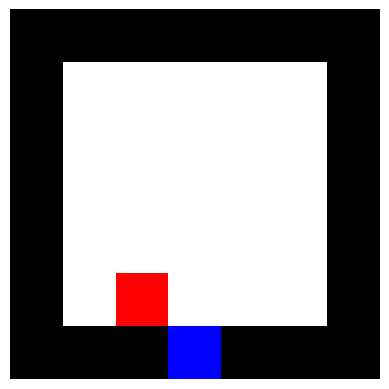

Episode: 2736127 
    Avg Iterations (last 4096 episodes): 5.92 
    Avg Score (last 4096): 1.2871 
    SnakeLength: 1.1044921875 
    Eplsilon: 0.05833874166303322 
    Learning Rate: 0.1
    


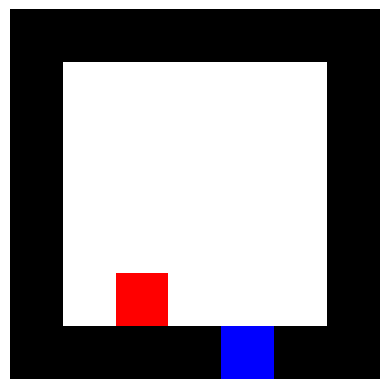

Episode: 2740223 
    Avg Iterations (last 4096 episodes): 6.04 
    Avg Score (last 4096): 1.3697 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.05810027477153562 
    Learning Rate: 0.1
    


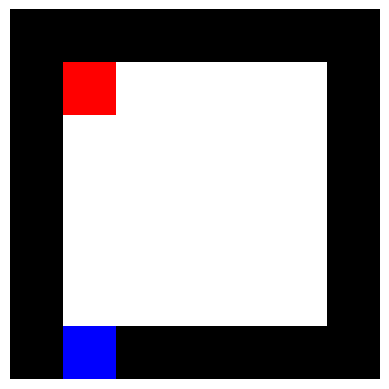

Episode: 2744319 
    Avg Iterations (last 4096 episodes): 6.14 
    Avg Score (last 4096): 1.3695 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.05786278264323553 
    Learning Rate: 0.1
    


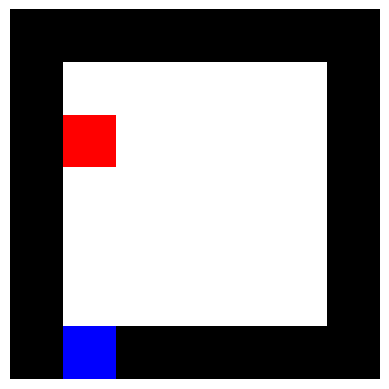

Episode: 2748415 
    Avg Iterations (last 4096 episodes): 6.07 
    Avg Score (last 4096): 1.3592 
    SnakeLength: 1.1044921875 
    Eplsilon: 0.05762626129366577 
    Learning Rate: 0.1
    


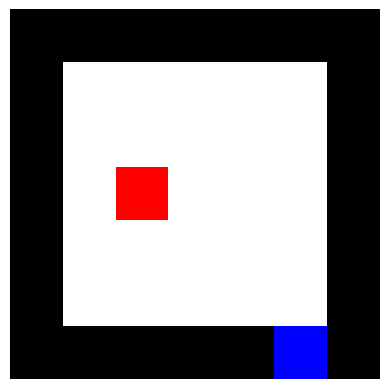

Episode: 2752511 
    Avg Iterations (last 4096 episodes): 6.00 
    Avg Score (last 4096): 1.3699 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.05739070675464788 
    Learning Rate: 0.1
    


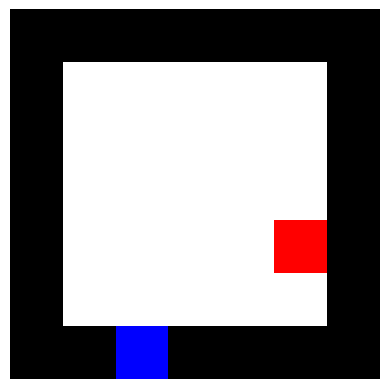

Episode: 2756607 
    Avg Iterations (last 4096 episodes): 6.04 
    Avg Score (last 4096): 1.3583 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.05715611507422279 
    Learning Rate: 0.1
    


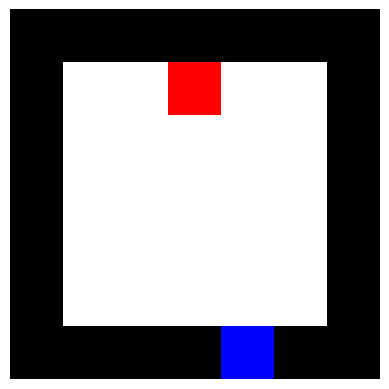

Episode: 2760703 
    Avg Iterations (last 4096 episodes): 6.03 
    Avg Score (last 4096): 1.2409 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.05692248231658559 
    Learning Rate: 0.1
    


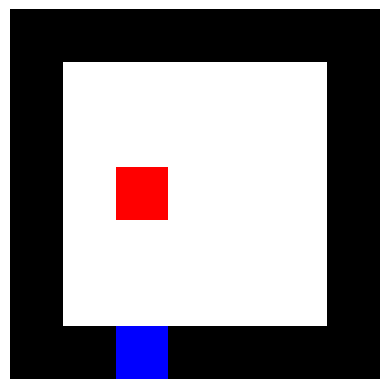

Episode: 2764799 
    Avg Iterations (last 4096 episodes): 6.11 
    Avg Score (last 4096): 1.3584 
    SnakeLength: 1.1044921875 
    Eplsilon: 0.05668980456201978 
    Learning Rate: 0.1
    


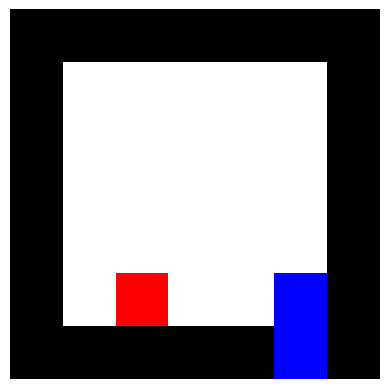

Episode: 2768895 
    Avg Iterations (last 4096 episodes): 6.20 
    Avg Score (last 4096): 1.3931 
    SnakeLength: 1.10400390625 
    Eplsilon: 0.05645807790683099 
    Learning Rate: 0.1
    


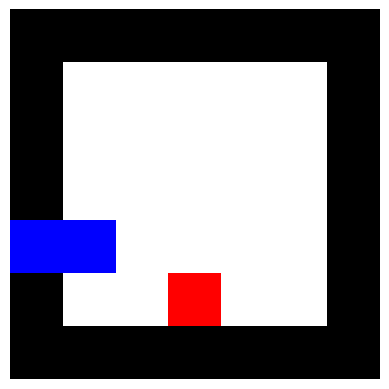

Episode: 2772991 
    Avg Iterations (last 4096 episodes): 6.29 
    Avg Score (last 4096): 1.4440 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.05622729846328158 
    Learning Rate: 0.1
    


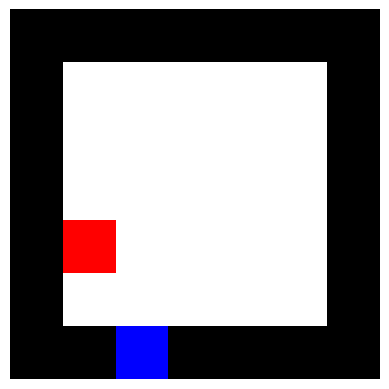

Episode: 2777087 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.3300 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.05599746235952588 
    Learning Rate: 0.1
    


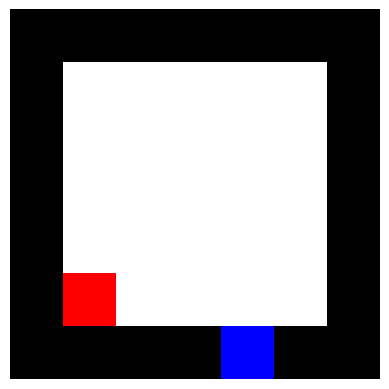

Episode: 2781183 
    Avg Iterations (last 4096 episodes): 6.47 
    Avg Score (last 4096): 1.4649 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.05576856573954486 
    Learning Rate: 0.1
    


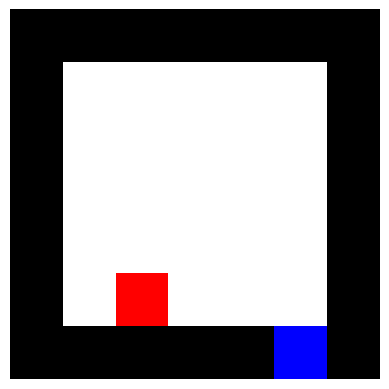

Episode: 2785279 
    Avg Iterations (last 4096 episodes): 6.40 
    Avg Score (last 4096): 1.4921 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.055540604763081154 
    Learning Rate: 0.1
    


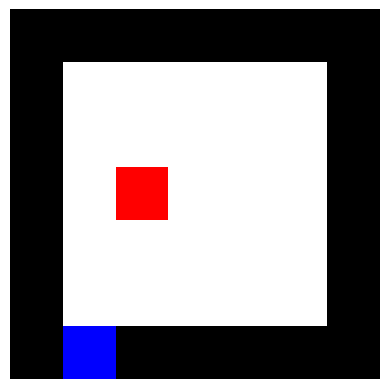

Episode: 2789375 
    Avg Iterations (last 4096 episodes): 6.31 
    Avg Score (last 4096): 1.4235 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.0553135756055749 
    Learning Rate: 0.1
    


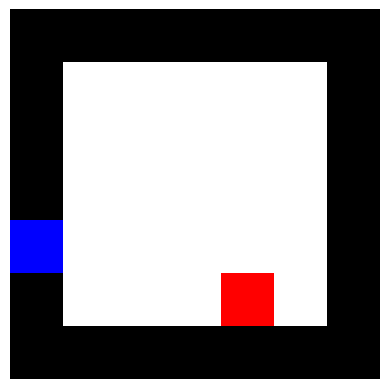

Episode: 2793471 
    Avg Iterations (last 4096 episodes): 6.45 
    Avg Score (last 4096): 1.5302 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.05508747445809981 
    Learning Rate: 0.1
    


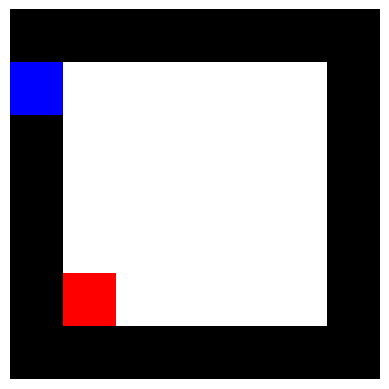

Episode: 2797567 
    Avg Iterations (last 4096 episodes): 6.50 
    Avg Score (last 4096): 1.5688 
    SnakeLength: 1.101318359375 
    Eplsilon: 0.054862297527299035 
    Learning Rate: 0.1
    


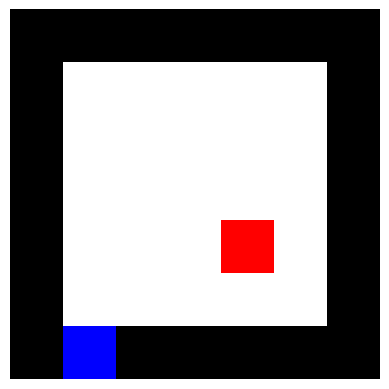

Episode: 2801663 
    Avg Iterations (last 4096 episodes): 6.19 
    Avg Score (last 4096): 1.4347 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.05463804103532146 
    Learning Rate: 0.1
    


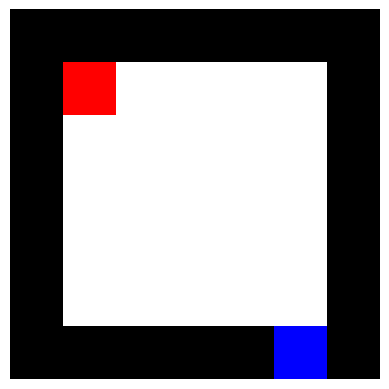

Episode: 2805759 
    Avg Iterations (last 4096 episodes): 6.15 
    Avg Score (last 4096): 1.3887 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.05441470121975835 
    Learning Rate: 0.1
    


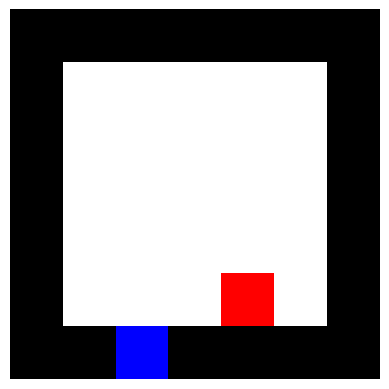

Episode: 2809855 
    Avg Iterations (last 4096 episodes): 6.09 
    Avg Score (last 4096): 1.3479 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.05419227433358072 
    Learning Rate: 0.1
    


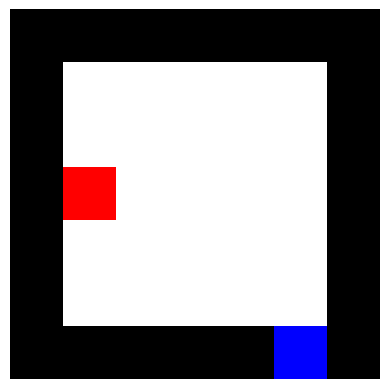

Episode: 2813951 
    Avg Iterations (last 4096 episodes): 6.44 
    Avg Score (last 4096): 1.5121 
    SnakeLength: 1.1201171875 
    Eplsilon: 0.05397075664507547 
    Learning Rate: 0.1
    


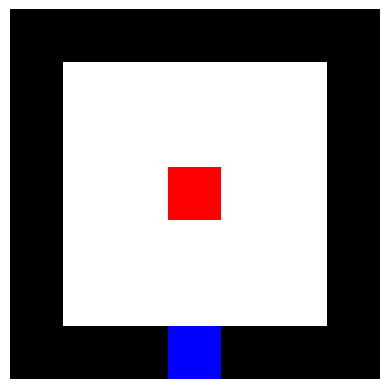

Episode: 2818047 
    Avg Iterations (last 4096 episodes): 6.64 
    Avg Score (last 4096): 1.5365 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.053750144437783746 
    Learning Rate: 0.1
    


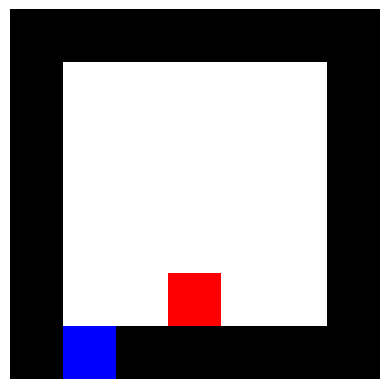

Episode: 2822143 
    Avg Iterations (last 4096 episodes): 6.51 
    Avg Score (last 4096): 1.5135 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.053530434010437736 
    Learning Rate: 0.1
    


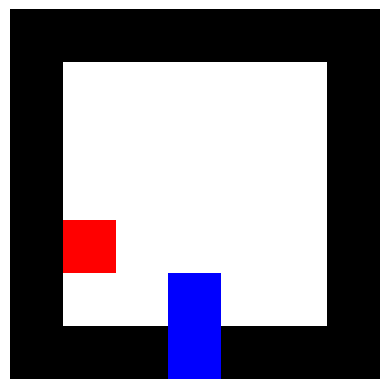

Episode: 2826239 
    Avg Iterations (last 4096 episodes): 6.67 
    Avg Score (last 4096): 1.5606 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.05331162167689983 
    Learning Rate: 0.1
    


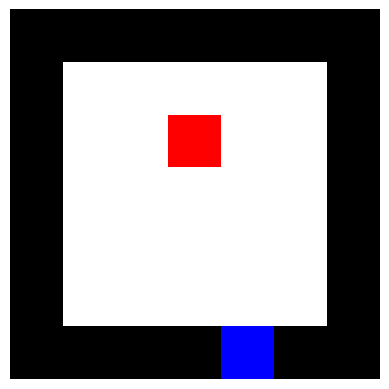

Episode: 2830335 
    Avg Iterations (last 4096 episodes): 6.49 
    Avg Score (last 4096): 1.6000 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.053093703766098836 
    Learning Rate: 0.1
    


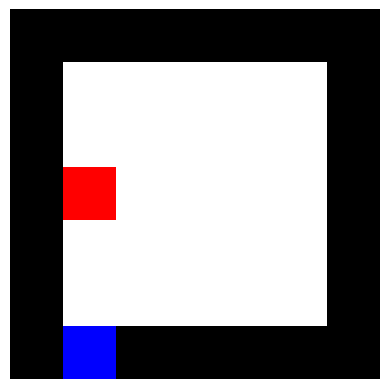

Episode: 2834431 
    Avg Iterations (last 4096 episodes): 6.49 
    Avg Score (last 4096): 1.5736 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.05287667662197017 
    Learning Rate: 0.1
    


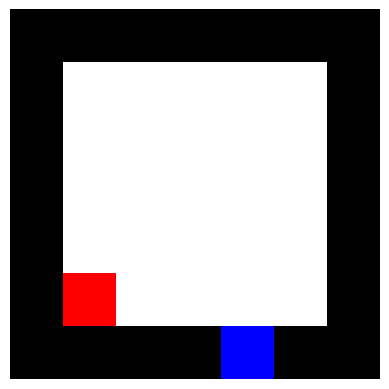

Episode: 2838527 
    Avg Iterations (last 4096 episodes): 5.96 
    Avg Score (last 4096): 1.3146 
    SnakeLength: 1.10546875 
    Eplsilon: 0.0526605366033941 
    Learning Rate: 0.1
    


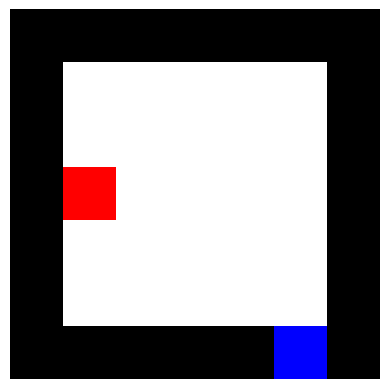

Episode: 2842623 
    Avg Iterations (last 4096 episodes): 6.47 
    Avg Score (last 4096): 1.4933 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.05244528008413402 
    Learning Rate: 0.1
    


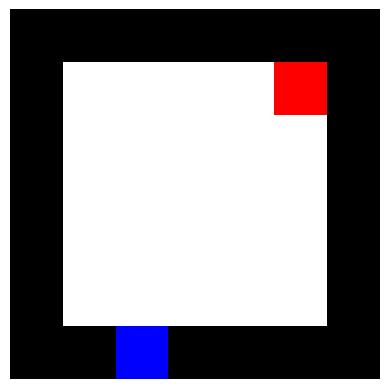

Episode: 2846719 
    Avg Iterations (last 4096 episodes): 6.32 
    Avg Score (last 4096): 1.3962 
    SnakeLength: 1.101806640625 
    Eplsilon: 0.052230903452776485 
    Learning Rate: 0.1
    


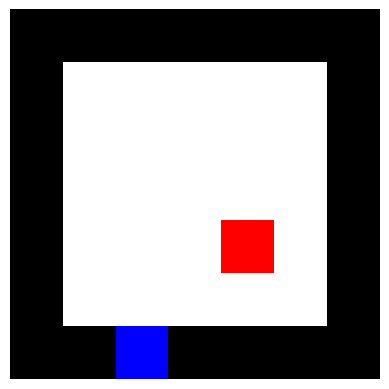

Episode: 2850815 
    Avg Iterations (last 4096 episodes): 6.64 
    Avg Score (last 4096): 1.5548 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.05201740311266953 
    Learning Rate: 0.1
    


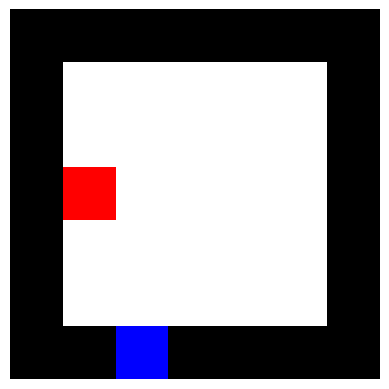

Episode: 2854911 
    Avg Iterations (last 4096 episodes): 6.49 
    Avg Score (last 4096): 1.5025 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.05180477548186305 
    Learning Rate: 0.1
    


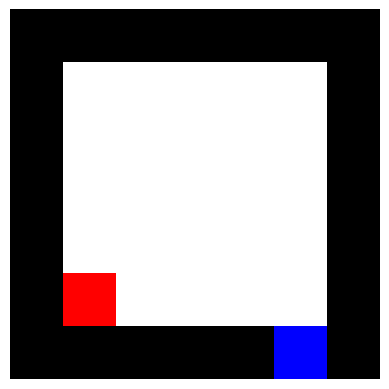

Episode: 2859007 
    Avg Iterations (last 4096 episodes): 6.70 
    Avg Score (last 4096): 1.5554 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.051593016993048746 
    Learning Rate: 0.1
    


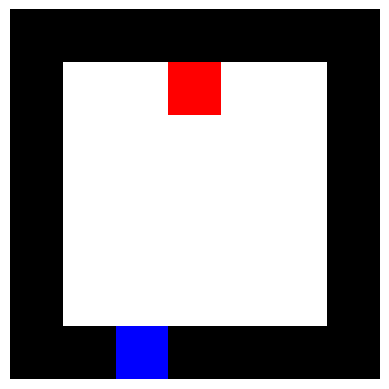

Episode: 2863103 
    Avg Iterations (last 4096 episodes): 6.58 
    Avg Score (last 4096): 1.5471 
    SnakeLength: 1.107421875 
    Eplsilon: 0.051382124093500625 
    Learning Rate: 0.1
    


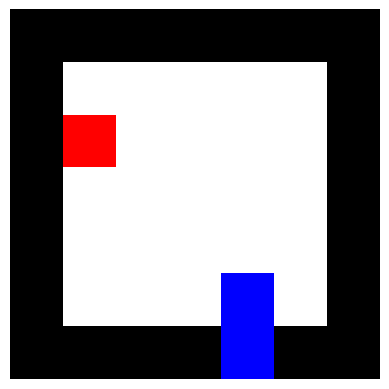

Episode: 2867199 
    Avg Iterations (last 4096 episodes): 6.55 
    Avg Score (last 4096): 1.5921 
    SnakeLength: 1.10400390625 
    Eplsilon: 0.05117209324501444 
    Learning Rate: 0.1
    


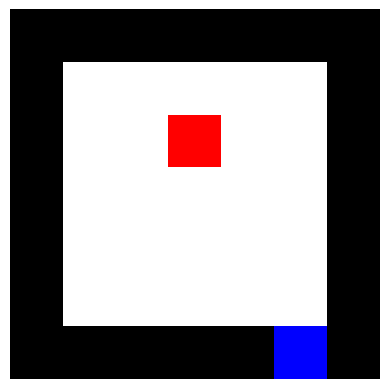

Episode: 2871295 
    Avg Iterations (last 4096 episodes): 6.80 
    Avg Score (last 4096): 1.6013 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.05096292092384859 
    Learning Rate: 0.1
    


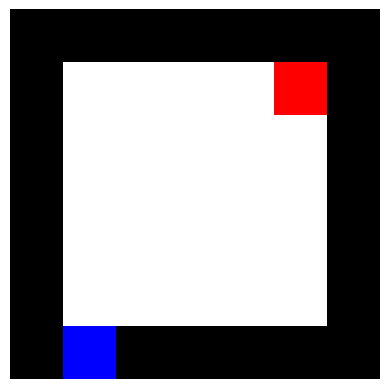

Episode: 2875391 
    Avg Iterations (last 4096 episodes): 6.44 
    Avg Score (last 4096): 1.4842 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.05075460362066532 
    Learning Rate: 0.1
    


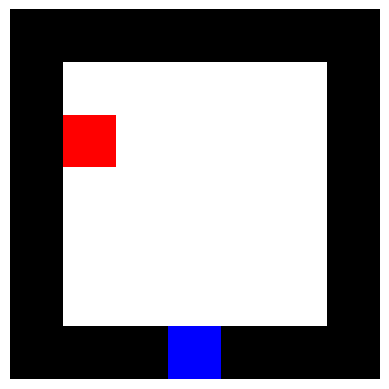

Episode: 2879487 
    Avg Iterations (last 4096 episodes): 6.37 
    Avg Score (last 4096): 1.4788 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.05054713784047229 
    Learning Rate: 0.1
    


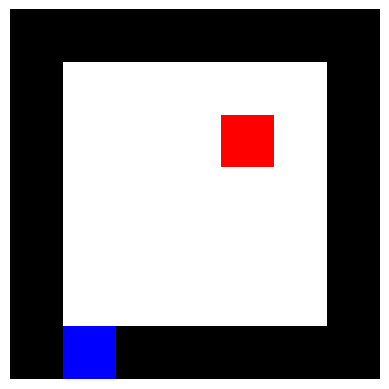

Episode: 2883583 
    Avg Iterations (last 4096 episodes): 7.00 
    Avg Score (last 4096): 1.6586 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.050340520102562715 
    Learning Rate: 0.1
    


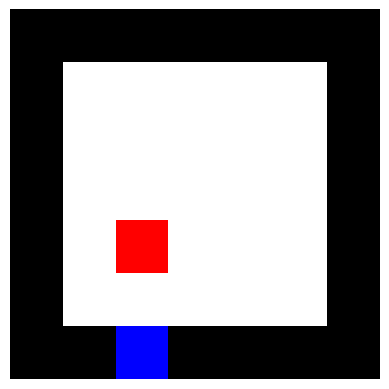

Episode: 2887679 
    Avg Iterations (last 4096 episodes): 6.31 
    Avg Score (last 4096): 1.3966 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.05013474694045787 
    Learning Rate: 0.1
    


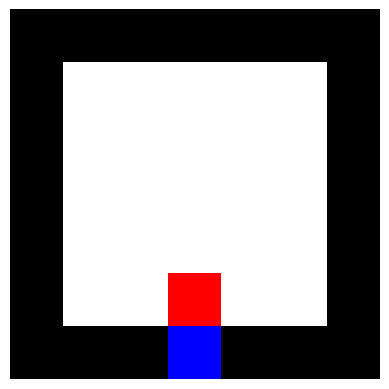

Episode: 2891775 
    Avg Iterations (last 4096 episodes): 6.75 
    Avg Score (last 4096): 1.6151 
    SnakeLength: 1.1171875 
    Eplsilon: 0.04992981490184893 
    Learning Rate: 0.1
    


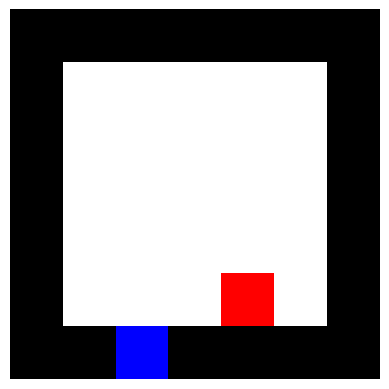

Episode: 2895871 
    Avg Iterations (last 4096 episodes): 6.86 
    Avg Score (last 4096): 1.6942 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.049725720548538355 
    Learning Rate: 0.1
    


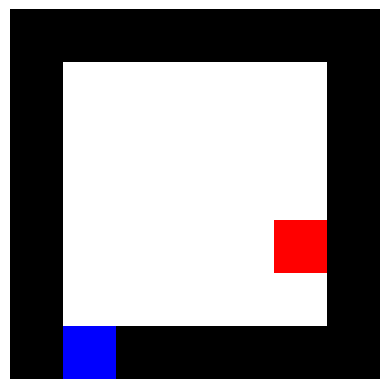

Episode: 2899967 
    Avg Iterations (last 4096 episodes): 6.38 
    Avg Score (last 4096): 1.4227 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.0495224604563824 
    Learning Rate: 0.1
    


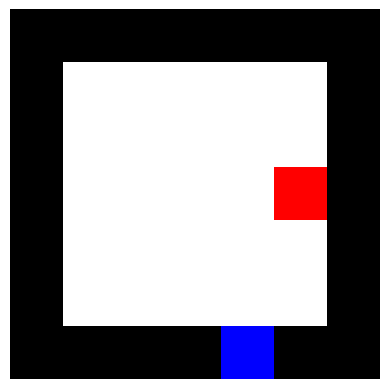

Episode: 2904063 
    Avg Iterations (last 4096 episodes): 6.68 
    Avg Score (last 4096): 1.6049 
    SnakeLength: 1.1171875 
    Eplsilon: 0.04932003121523511 
    Learning Rate: 0.1
    


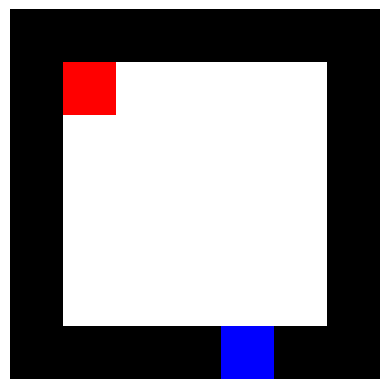

Episode: 2908159 
    Avg Iterations (last 4096 episodes): 6.28 
    Avg Score (last 4096): 1.4317 
    SnakeLength: 1.102294921875 
    Eplsilon: 0.049118429428889214 
    Learning Rate: 0.1
    


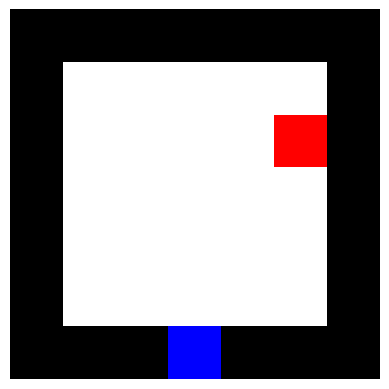

Episode: 2912255 
    Avg Iterations (last 4096 episodes): 6.52 
    Avg Score (last 4096): 1.4992 
    SnakeLength: 1.1005859375 
    Eplsilon: 0.04891765171501928 
    Learning Rate: 0.1
    


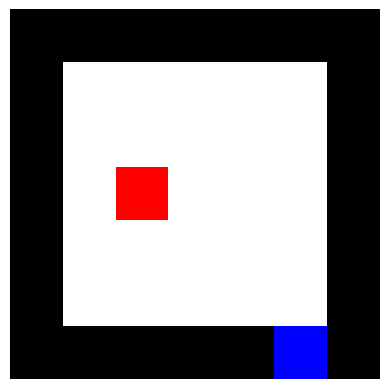

Episode: 2916351 
    Avg Iterations (last 4096 episodes): 6.56 
    Avg Score (last 4096): 1.5199 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.048717694705126845 
    Learning Rate: 0.1
    


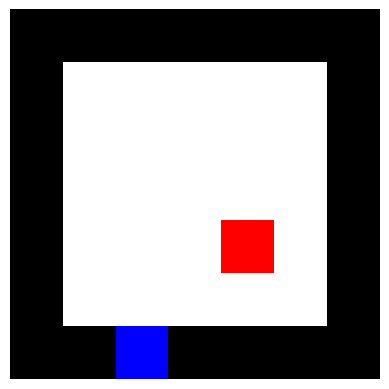

Episode: 2920447 
    Avg Iterations (last 4096 episodes): 6.64 
    Avg Score (last 4096): 1.5338 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.0485185550444817 
    Learning Rate: 0.1
    


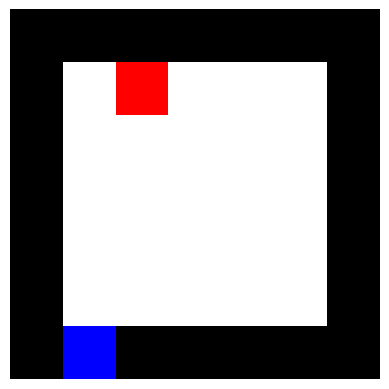

Episode: 2924543 
    Avg Iterations (last 4096 episodes): 6.35 
    Avg Score (last 4096): 1.4227 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.048320229392066455 
    Learning Rate: 0.1
    


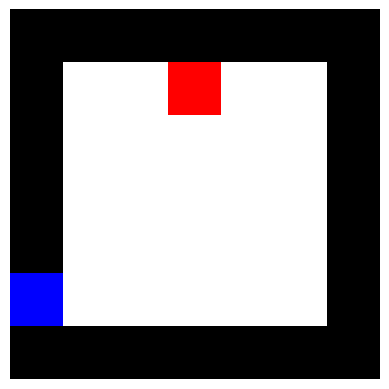

Episode: 2928639 
    Avg Iterations (last 4096 episodes): 6.78 
    Avg Score (last 4096): 1.6952 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.04812271442052104 
    Learning Rate: 0.1
    


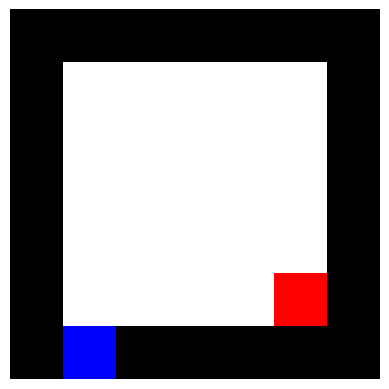

Episode: 2932735 
    Avg Iterations (last 4096 episodes): 6.25 
    Avg Score (last 4096): 1.4227 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.04792600681608628 
    Learning Rate: 0.1
    


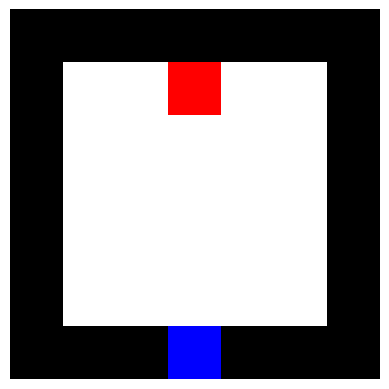

Episode: 2936831 
    Avg Iterations (last 4096 episodes): 6.85 
    Avg Score (last 4096): 1.6508 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.04773010327854811 
    Learning Rate: 0.1
    


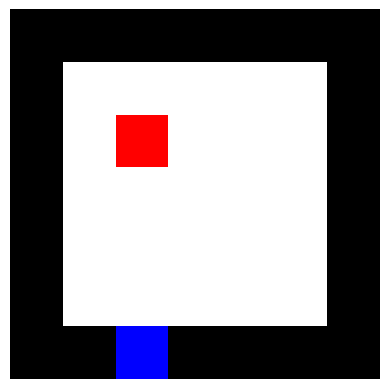

Episode: 2940927 
    Avg Iterations (last 4096 episodes): 6.72 
    Avg Score (last 4096): 1.6064 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.047535000521182806 
    Learning Rate: 0.1
    


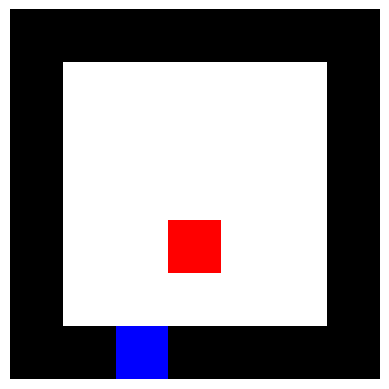

Episode: 2945023 
    Avg Iterations (last 4096 episodes): 6.33 
    Avg Score (last 4096): 1.3438 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.047340695270701144 
    Learning Rate: 0.1
    


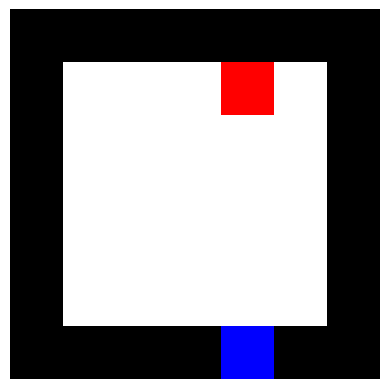

Episode: 2949119 
    Avg Iterations (last 4096 episodes): 7.04 
    Avg Score (last 4096): 1.7453 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.04714718426719444 
    Learning Rate: 0.1
    


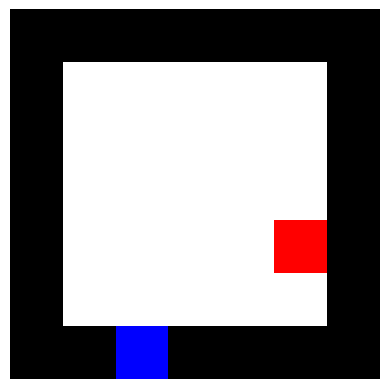

Episode: 2953215 
    Avg Iterations (last 4096 episodes): 6.42 
    Avg Score (last 4096): 1.5225 
    SnakeLength: 1.107421875 
    Eplsilon: 0.046954464264078836 
    Learning Rate: 0.1
    


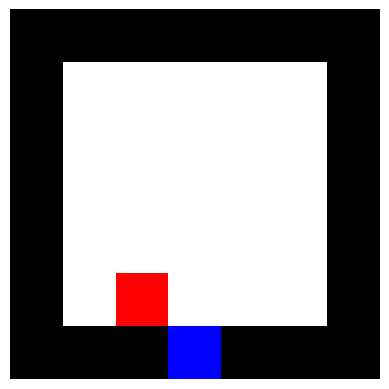

Episode: 2957311 
    Avg Iterations (last 4096 episodes): 6.75 
    Avg Score (last 4096): 1.5691 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.04676253202804187 
    Learning Rate: 0.1
    


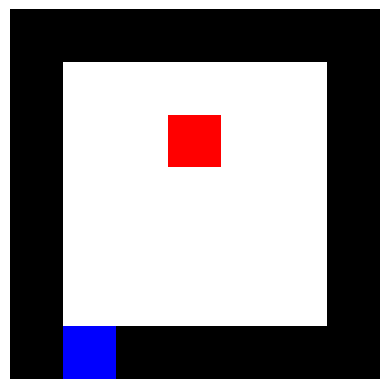

Episode: 2961407 
    Avg Iterations (last 4096 episodes): 6.45 
    Avg Score (last 4096): 1.5445 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.04657138433898652 
    Learning Rate: 0.1
    


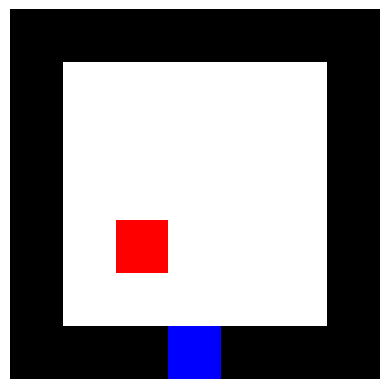

Episode: 2965503 
    Avg Iterations (last 4096 episodes): 6.67 
    Avg Score (last 4096): 1.6028 
    SnakeLength: 1.101806640625 
    Eplsilon: 0.046381017989979574 
    Learning Rate: 0.1
    


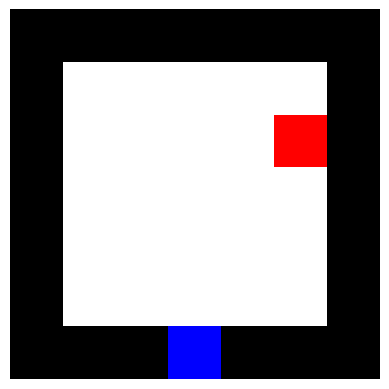

Episode: 2969599 
    Avg Iterations (last 4096 episodes): 7.01 
    Avg Score (last 4096): 1.6851 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.04619142978719591 
    Learning Rate: 0.1
    


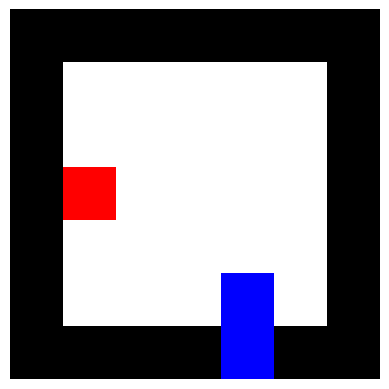

Episode: 2973695 
    Avg Iterations (last 4096 episodes): 6.62 
    Avg Score (last 4096): 1.6134 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.046002616549865594 
    Learning Rate: 0.1
    


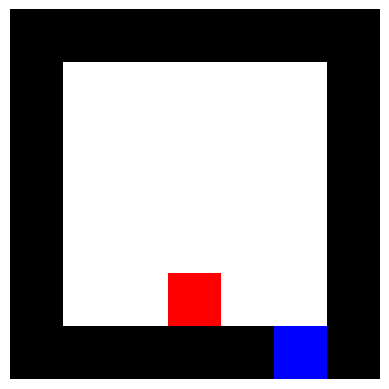

Episode: 2977791 
    Avg Iterations (last 4096 episodes): 7.08 
    Avg Score (last 4096): 1.8156 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.045814575110220676 
    Learning Rate: 0.1
    


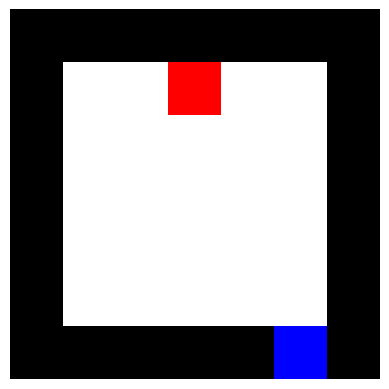

Episode: 2981887 
    Avg Iterations (last 4096 episodes): 6.75 
    Avg Score (last 4096): 1.6822 
    SnakeLength: 1.107421875 
    Eplsilon: 0.04562730231344155 
    Learning Rate: 0.1
    


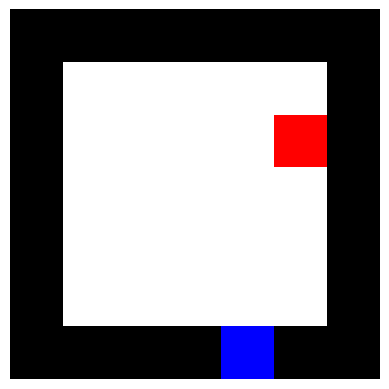

Episode: 2985983 
    Avg Iterations (last 4096 episodes): 6.91 
    Avg Score (last 4096): 1.7771 
    SnakeLength: 1.126220703125 
    Eplsilon: 0.045440795017604674 
    Learning Rate: 0.1
    


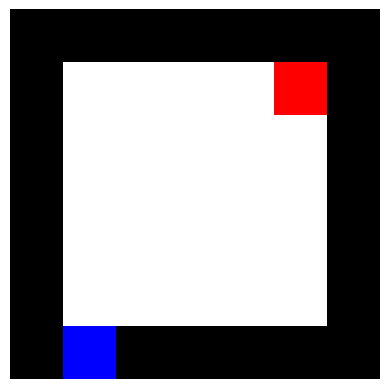

Episode: 2990079 
    Avg Iterations (last 4096 episodes): 6.87 
    Avg Score (last 4096): 1.6897 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.04525505009362913 
    Learning Rate: 0.1
    


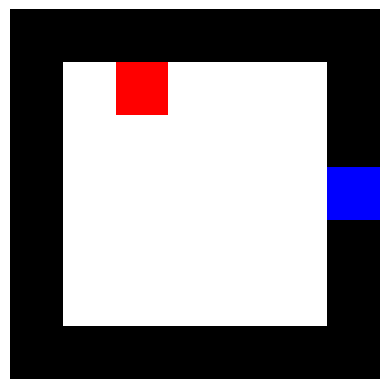

Episode: 2994175 
    Avg Iterations (last 4096 episodes): 6.77 
    Avg Score (last 4096): 1.6329 
    SnakeLength: 1.11865234375 
    Eplsilon: 0.04507006442522506 
    Learning Rate: 0.1
    


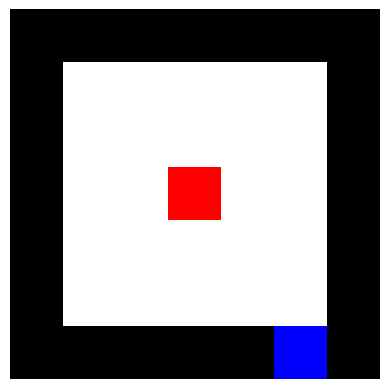

Episode: 2998271 
    Avg Iterations (last 4096 episodes): 7.24 
    Avg Score (last 4096): 1.7869 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.044885834908840225 
    Learning Rate: 0.1
    


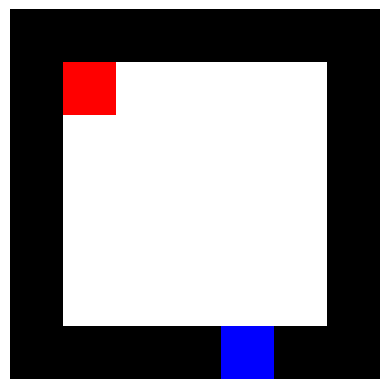

Episode: 3002367 
    Avg Iterations (last 4096 episodes): 7.12 
    Avg Score (last 4096): 1.8095 
    SnakeLength: 1.095703125 
    Eplsilon: 0.04470235845360911 
    Learning Rate: 0.1
    


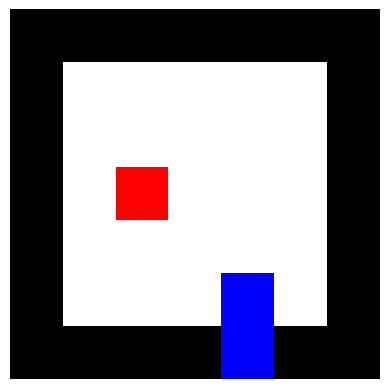

Episode: 3006463 
    Avg Iterations (last 4096 episodes): 6.53 
    Avg Score (last 4096): 1.5781 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.04451963198129989 
    Learning Rate: 0.1
    


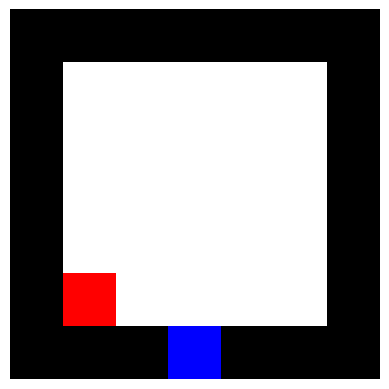

Episode: 3010559 
    Avg Iterations (last 4096 episodes): 6.83 
    Avg Score (last 4096): 1.6540 
    SnakeLength: 1.123046875 
    Eplsilon: 0.04433765242626396 
    Learning Rate: 0.1
    


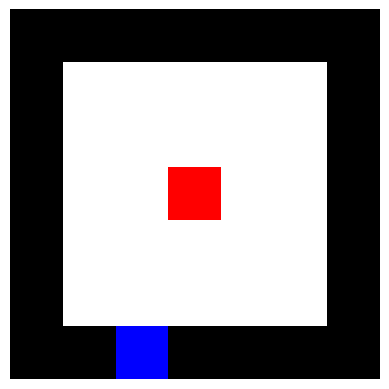

Episode: 3014655 
    Avg Iterations (last 4096 episodes): 6.47 
    Avg Score (last 4096): 1.4583 
    SnakeLength: 1.109375 
    Eplsilon: 0.04415641673538373 
    Learning Rate: 0.1
    


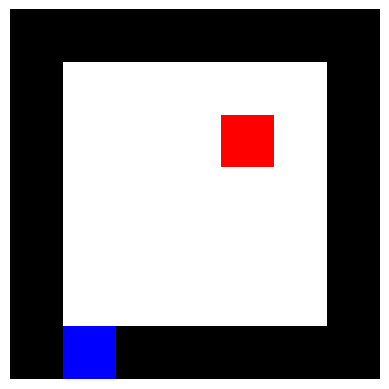

Episode: 3018751 
    Avg Iterations (last 4096 episodes): 6.48 
    Avg Score (last 4096): 1.5301 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.043975921868021475 
    Learning Rate: 0.1
    


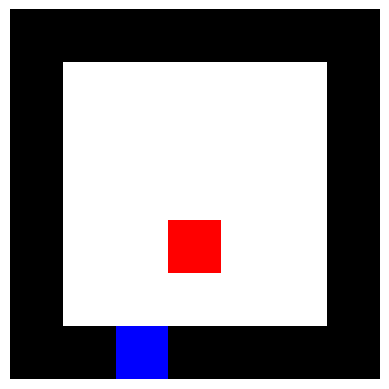

Episode: 3022847 
    Avg Iterations (last 4096 episodes): 6.72 
    Avg Score (last 4096): 1.6445 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.043796164795968644 
    Learning Rate: 0.1
    


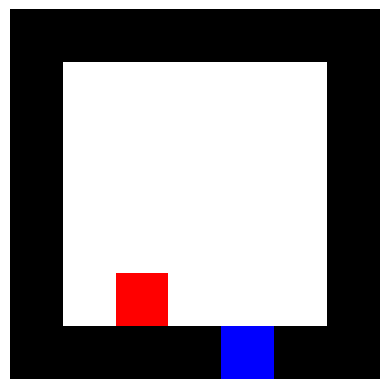

Episode: 3026943 
    Avg Iterations (last 4096 episodes): 6.75 
    Avg Score (last 4096): 1.6905 
    SnakeLength: 1.11328125 
    Eplsilon: 0.04361714250339459 
    Learning Rate: 0.1
    


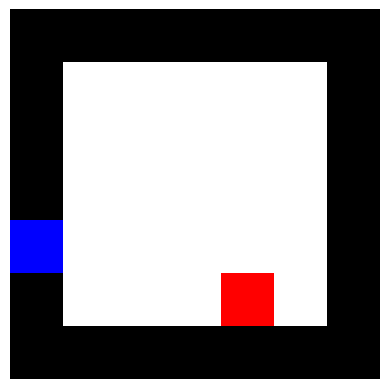

Episode: 3031039 
    Avg Iterations (last 4096 episodes): 6.85 
    Avg Score (last 4096): 1.7221 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.04343885198679639 
    Learning Rate: 0.1
    


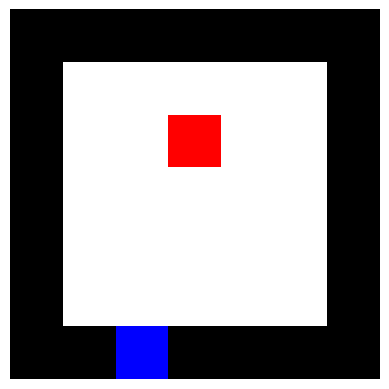

Episode: 3035135 
    Avg Iterations (last 4096 episodes): 7.54 
    Avg Score (last 4096): 1.9413 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.04326129025494859 
    Learning Rate: 0.1
    


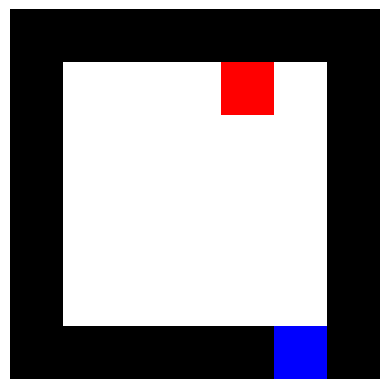

Episode: 3039231 
    Avg Iterations (last 4096 episodes): 7.26 
    Avg Score (last 4096): 1.8235 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.04308445432885249 
    Learning Rate: 0.1
    


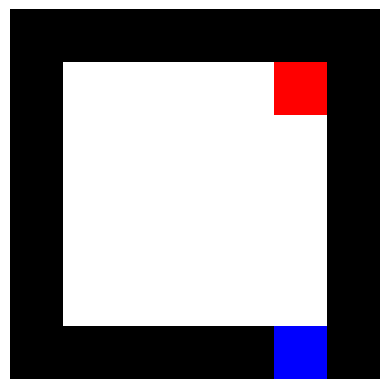

Episode: 3043327 
    Avg Iterations (last 4096 episodes): 7.16 
    Avg Score (last 4096): 1.7773 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.04290834124168624 
    Learning Rate: 0.1
    


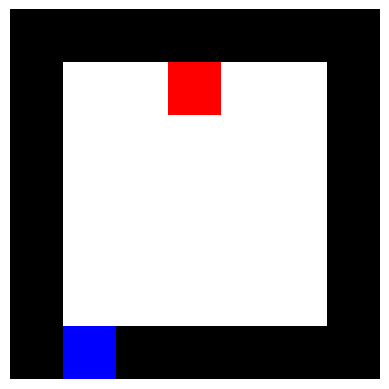

Episode: 3047423 
    Avg Iterations (last 4096 episodes): 7.34 
    Avg Score (last 4096): 1.8418 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.04273294803875587 
    Learning Rate: 0.1
    


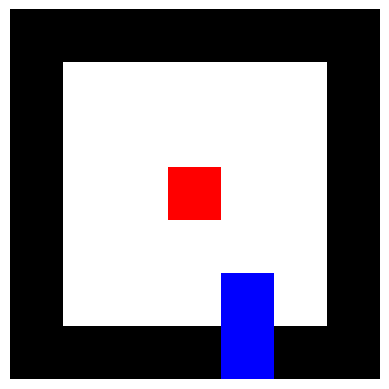

Episode: 3051519 
    Avg Iterations (last 4096 episodes): 7.12 
    Avg Score (last 4096): 1.8302 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.0425582717774444 
    Learning Rate: 0.1
    


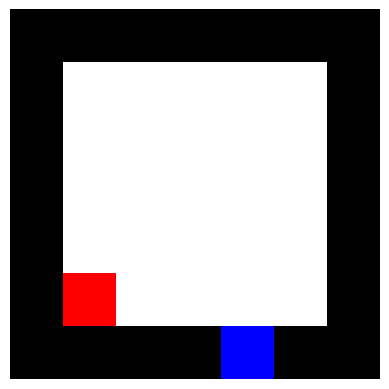

Episode: 3055615 
    Avg Iterations (last 4096 episodes): 7.47 
    Avg Score (last 4096): 1.9067 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.04238430952716326 
    Learning Rate: 0.1
    


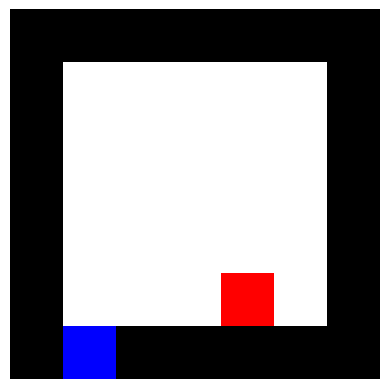

Episode: 3059711 
    Avg Iterations (last 4096 episodes): 7.48 
    Avg Score (last 4096): 1.9176 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.04221105836930342 
    Learning Rate: 0.1
    


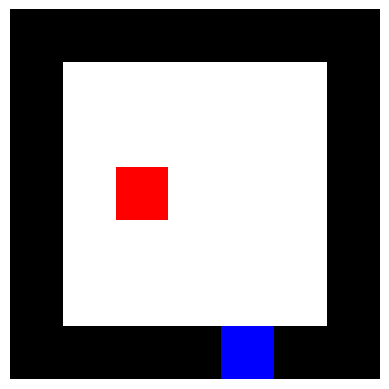

Episode: 3063807 
    Avg Iterations (last 4096 episodes): 7.10 
    Avg Score (last 4096): 1.8325 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.04203851539718557 
    Learning Rate: 0.1
    


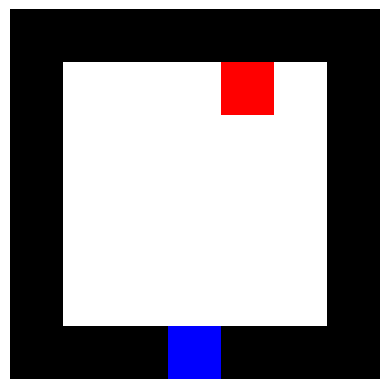

Episode: 3067903 
    Avg Iterations (last 4096 episodes): 7.21 
    Avg Score (last 4096): 1.8603 
    SnakeLength: 1.10498046875 
    Eplsilon: 0.041866677716012504 
    Learning Rate: 0.1
    


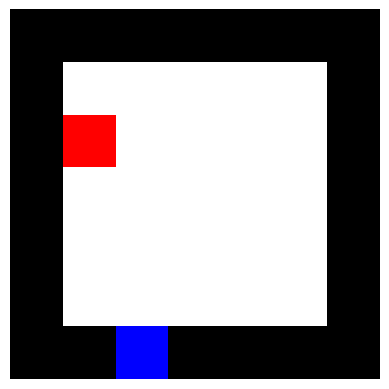

Episode: 3071999 
    Avg Iterations (last 4096 episodes): 6.84 
    Avg Score (last 4096): 1.6631 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.04169554244281895 
    Learning Rate: 0.1
    


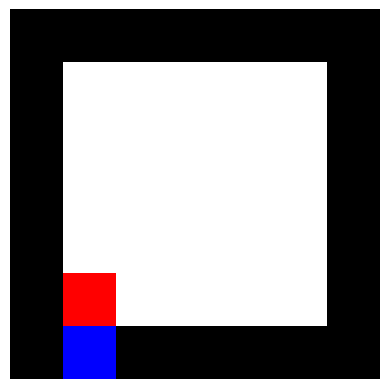

Episode: 3076095 
    Avg Iterations (last 4096 episodes): 7.71 
    Avg Score (last 4096): 2.0365 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.04152510670642496 
    Learning Rate: 0.1
    


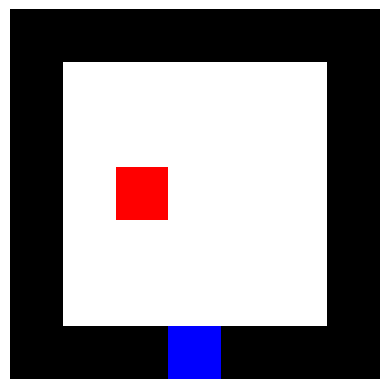

Episode: 3080191 
    Avg Iterations (last 4096 episodes): 7.22 
    Avg Score (last 4096): 1.8490 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.041355367647386544 
    Learning Rate: 0.1
    


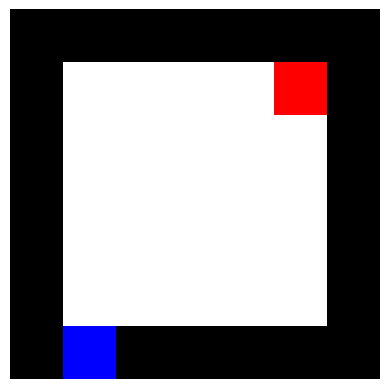

Episode: 3084287 
    Avg Iterations (last 4096 episodes): 7.41 
    Avg Score (last 4096): 1.9568 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.041186322417947625 
    Learning Rate: 0.1
    


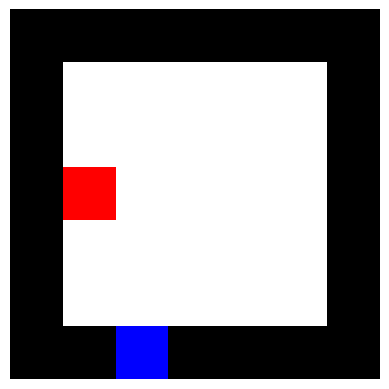

Episode: 3088383 
    Avg Iterations (last 4096 episodes): 7.11 
    Avg Score (last 4096): 1.7826 
    SnakeLength: 1.10546875 
    Eplsilon: 0.04101796818199327 
    Learning Rate: 0.1
    


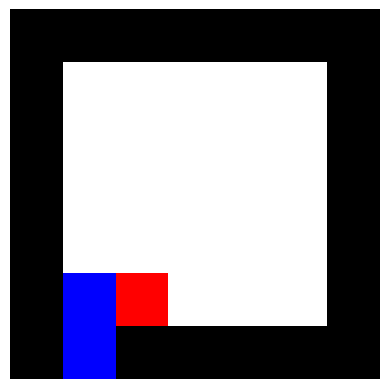

Episode: 3092479 
    Avg Iterations (last 4096 episodes): 7.05 
    Avg Score (last 4096): 1.8311 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.04085030211500133 
    Learning Rate: 0.1
    


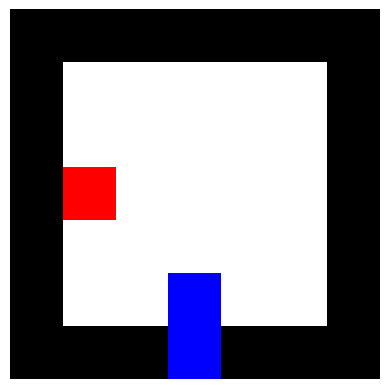

Episode: 3096575 
    Avg Iterations (last 4096 episodes): 7.19 
    Avg Score (last 4096): 1.8568 
    SnakeLength: 1.10546875 
    Eplsilon: 0.040683321403995124 
    Learning Rate: 0.1
    


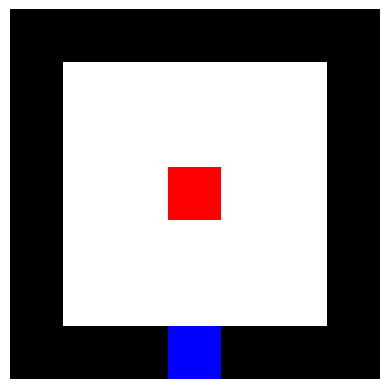

Episode: 3100671 
    Avg Iterations (last 4096 episodes): 7.48 
    Avg Score (last 4096): 1.9703 
    SnakeLength: 1.11328125 
    Eplsilon: 0.040517023247496765 
    Learning Rate: 0.1
    


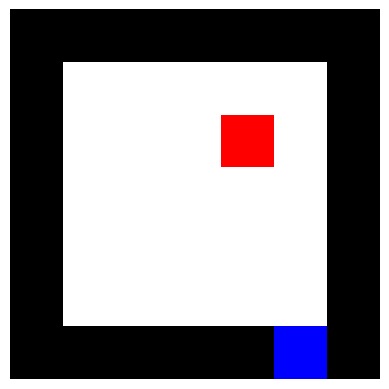

Episode: 3104767 
    Avg Iterations (last 4096 episodes): 6.98 
    Avg Score (last 4096): 1.6655 
    SnakeLength: 1.103271484375 
    Eplsilon: 0.0403514048554794 
    Learning Rate: 0.1
    


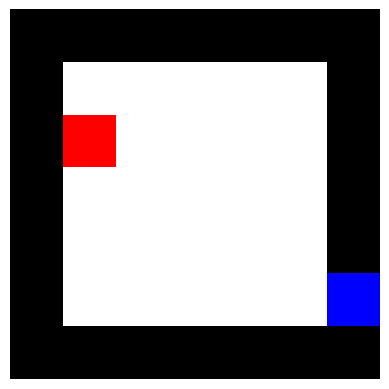

Episode: 3108863 
    Avg Iterations (last 4096 episodes): 7.10 
    Avg Score (last 4096): 1.8342 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.04018646344932042 
    Learning Rate: 0.1
    


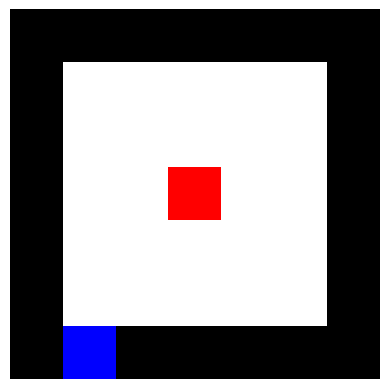

Episode: 3112959 
    Avg Iterations (last 4096 episodes): 7.58 
    Avg Score (last 4096): 1.9092 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.040022196261755946 
    Learning Rate: 0.1
    


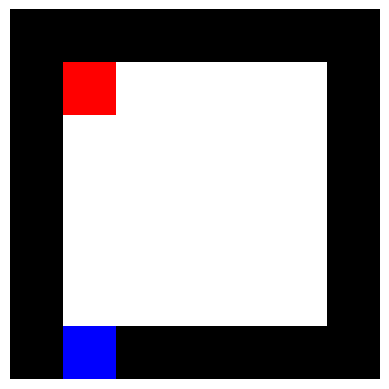

Episode: 3117055 
    Avg Iterations (last 4096 episodes): 7.35 
    Avg Score (last 4096): 1.8750 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.03985860053683314 
    Learning Rate: 0.1
    


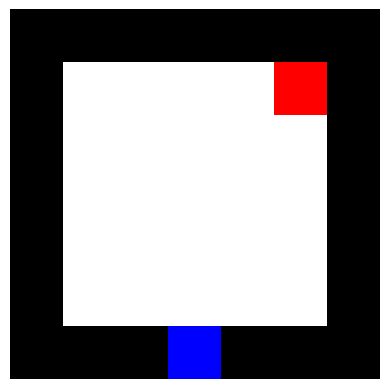

Episode: 3121151 
    Avg Iterations (last 4096 episodes): 7.22 
    Avg Score (last 4096): 1.8515 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.039695673529864826 
    Learning Rate: 0.1
    


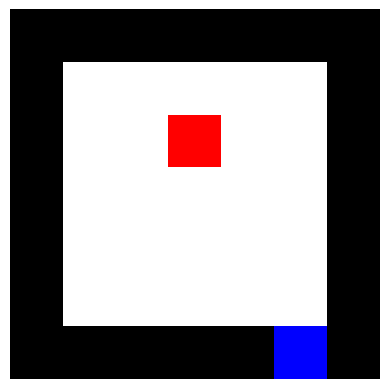

Episode: 3125247 
    Avg Iterations (last 4096 episodes): 7.30 
    Avg Score (last 4096): 1.8332 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.03953341250738273 
    Learning Rate: 0.1
    


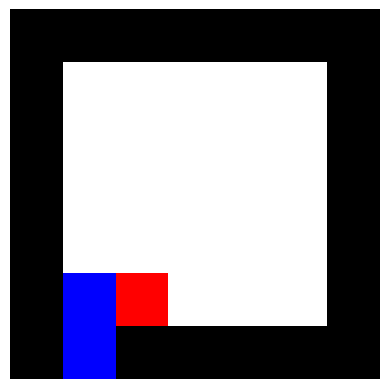

Episode: 3129343 
    Avg Iterations (last 4096 episodes): 6.74 
    Avg Score (last 4096): 1.6798 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.03937181474709199 
    Learning Rate: 0.1
    


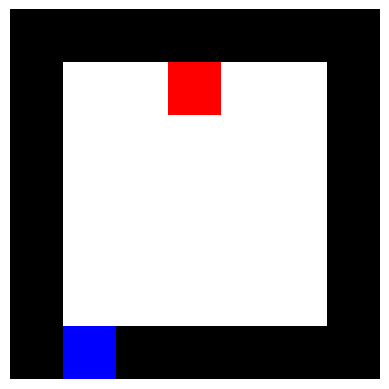

Episode: 3133439 
    Avg Iterations (last 4096 episodes): 7.28 
    Avg Score (last 4096): 1.8566 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.03921087753782567 
    Learning Rate: 0.1
    


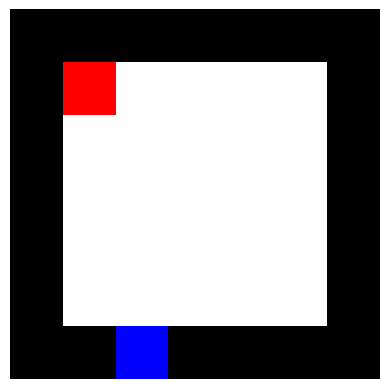

Episode: 3137535 
    Avg Iterations (last 4096 episodes): 7.45 
    Avg Score (last 4096): 2.0214 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.039050598179499296 
    Learning Rate: 0.1
    


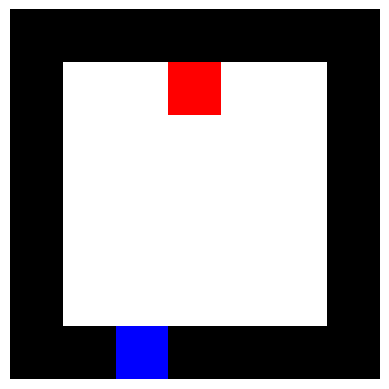

Episode: 3141631 
    Avg Iterations (last 4096 episodes): 7.06 
    Avg Score (last 4096): 1.8349 
    SnakeLength: 1.111328125 
    Eplsilon: 0.03889097398306452 
    Learning Rate: 0.1
    


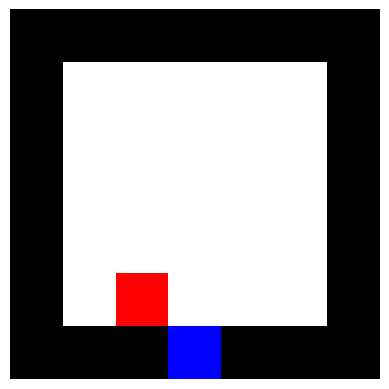

Episode: 3145727 
    Avg Iterations (last 4096 episodes): 7.97 
    Avg Score (last 4096): 2.1399 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.03873200227046548 
    Learning Rate: 0.1
    


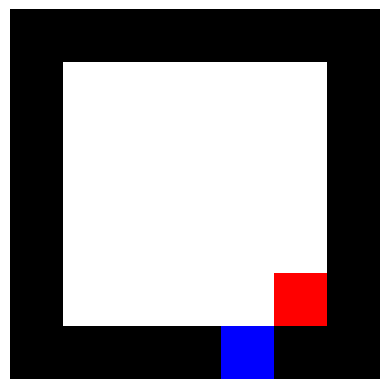

Episode: 3149823 
    Avg Iterations (last 4096 episodes): 7.39 
    Avg Score (last 4096): 1.9088 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.03857368037459288 
    Learning Rate: 0.1
    


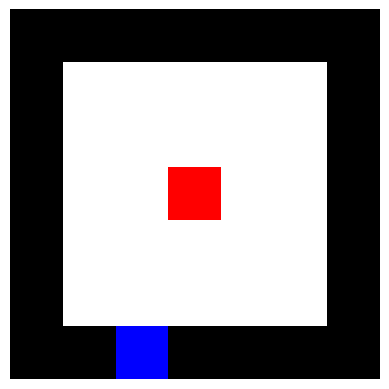

Episode: 3153919 
    Avg Iterations (last 4096 episodes): 8.08 
    Avg Score (last 4096): 2.2096 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.03841600563924 
    Learning Rate: 0.1
    


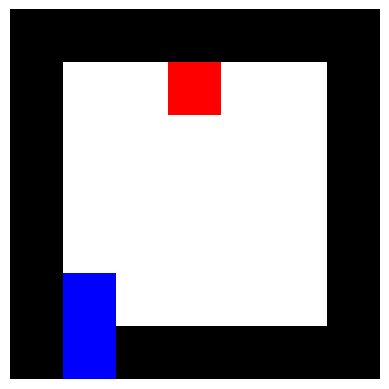

Episode: 3158015 
    Avg Iterations (last 4096 episodes): 7.71 
    Avg Score (last 4096): 2.1041 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.03825897541905694 
    Learning Rate: 0.1
    


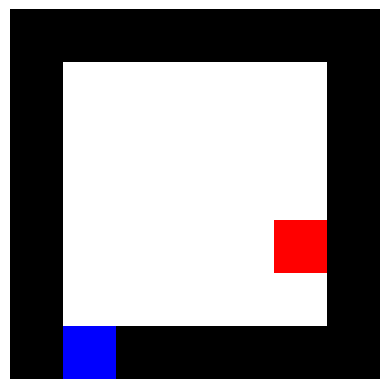

Episode: 3162111 
    Avg Iterations (last 4096 episodes): 7.25 
    Avg Score (last 4096): 1.9251 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.03810258707950799 
    Learning Rate: 0.1
    


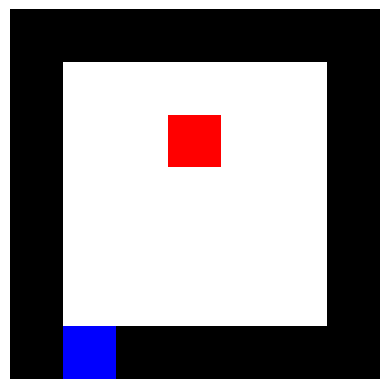

Episode: 3166207 
    Avg Iterations (last 4096 episodes): 7.43 
    Avg Score (last 4096): 1.9539 
    SnakeLength: 1.109375 
    Eplsilon: 0.037946837996825765 
    Learning Rate: 0.1
    


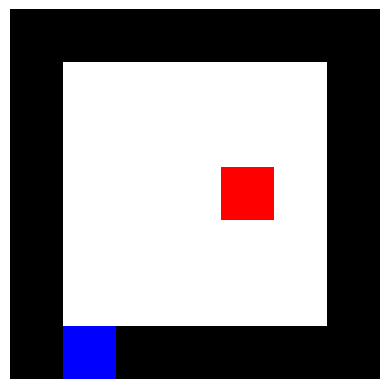

Episode: 3170303 
    Avg Iterations (last 4096 episodes): 7.84 
    Avg Score (last 4096): 2.1420 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.03779172555796778 
    Learning Rate: 0.1
    


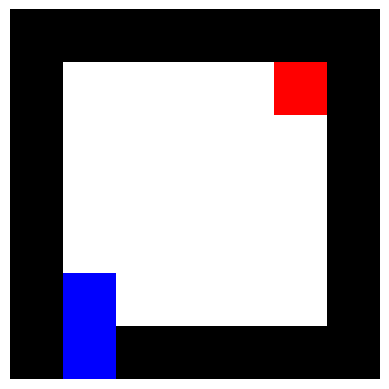

Episode: 3174399 
    Avg Iterations (last 4096 episodes): 7.90 
    Avg Score (last 4096): 2.2019 
    SnakeLength: 1.105224609375 
    Eplsilon: 0.037637247160572804 
    Learning Rate: 0.1
    


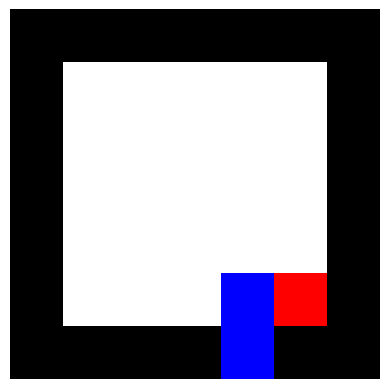

Episode: 3178495 
    Avg Iterations (last 4096 episodes): 7.34 
    Avg Score (last 4096): 1.9612 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.03748340021291777 
    Learning Rate: 0.1
    


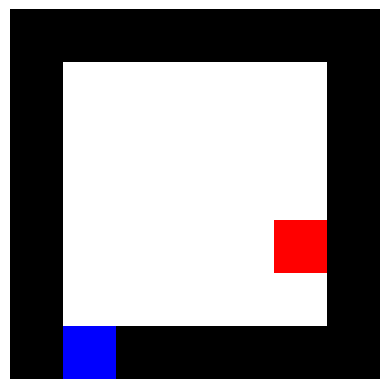

Episode: 3182591 
    Avg Iterations (last 4096 episodes): 7.76 
    Avg Score (last 4096): 2.0273 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.03733018213387252 
    Learning Rate: 0.1
    


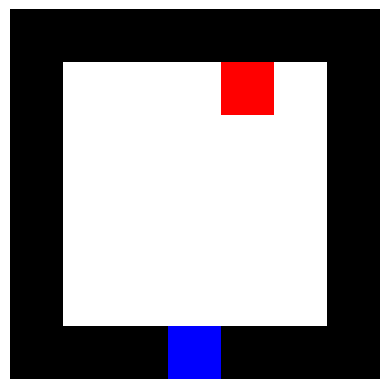

Episode: 3186687 
    Avg Iterations (last 4096 episodes): 7.34 
    Avg Score (last 4096): 1.9308 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.03717759035285828 
    Learning Rate: 0.1
    


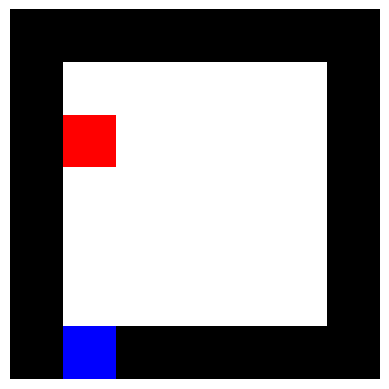

Episode: 3190783 
    Avg Iterations (last 4096 episodes): 7.85 
    Avg Score (last 4096): 2.1132 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.037025622309803365 
    Learning Rate: 0.1
    


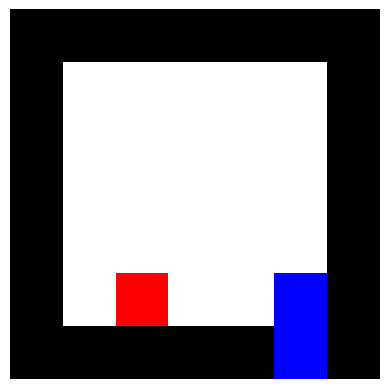

Episode: 3194879 
    Avg Iterations (last 4096 episodes): 7.13 
    Avg Score (last 4096): 1.7430 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.03687427545510158 
    Learning Rate: 0.1
    


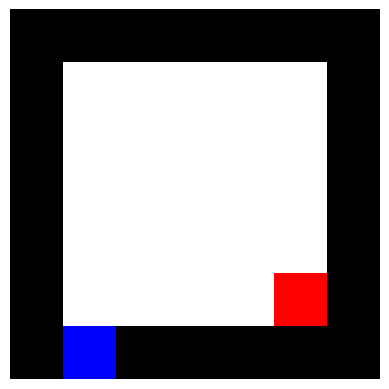

Episode: 3198975 
    Avg Iterations (last 4096 episodes): 7.58 
    Avg Score (last 4096): 1.9683 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.03672354724956738 
    Learning Rate: 0.1
    


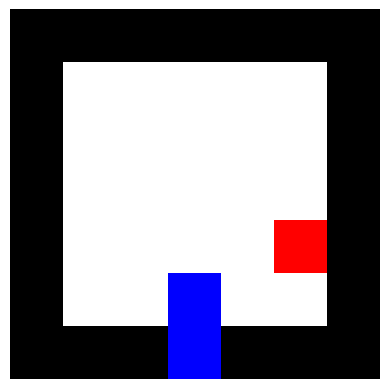

Episode: 3203071 
    Avg Iterations (last 4096 episodes): 7.37 
    Avg Score (last 4096): 1.9137 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.03657343516439521 
    Learning Rate: 0.1
    


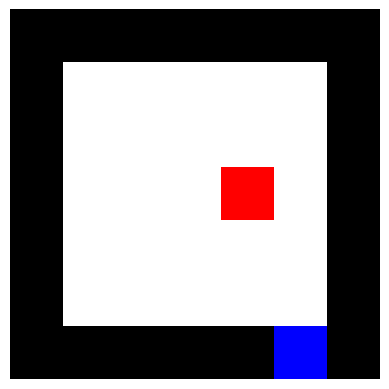

Episode: 3207167 
    Avg Iterations (last 4096 episodes): 7.91 
    Avg Score (last 4096): 2.1303 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.03642393668111612 
    Learning Rate: 0.1
    


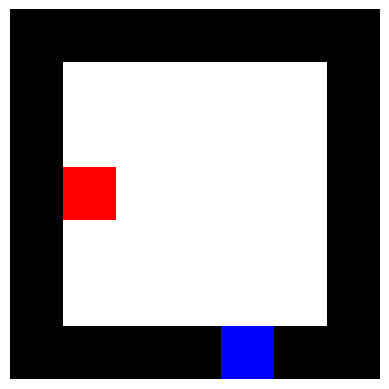

Episode: 3211263 
    Avg Iterations (last 4096 episodes): 7.86 
    Avg Score (last 4096): 2.1584 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.036275049291556005 
    Learning Rate: 0.1
    


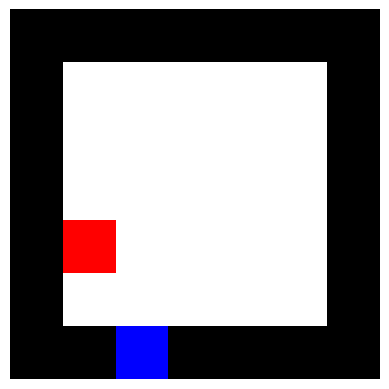

Episode: 3215359 
    Avg Iterations (last 4096 episodes): 7.68 
    Avg Score (last 4096): 2.1358 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.036126770497792636 
    Learning Rate: 0.1
    


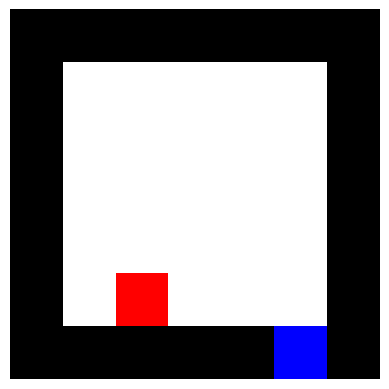

Episode: 3219455 
    Avg Iterations (last 4096 episodes): 7.36 
    Avg Score (last 4096): 1.9520 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.0359790978121147 
    Learning Rate: 0.1
    


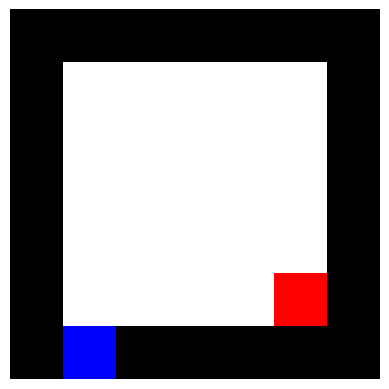

Episode: 3223551 
    Avg Iterations (last 4096 episodes): 7.98 
    Avg Score (last 4096): 2.1609 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.03583202875697994 
    Learning Rate: 0.1
    


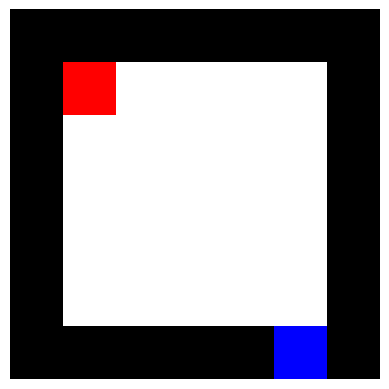

Episode: 3227647 
    Avg Iterations (last 4096 episodes): 7.84 
    Avg Score (last 4096): 2.1448 
    SnakeLength: 1.10498046875 
    Eplsilon: 0.03568556086497292 
    Learning Rate: 0.1
    


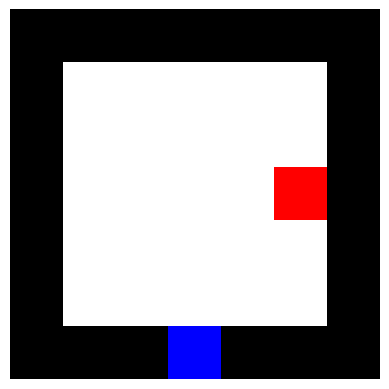

Episode: 3231743 
    Avg Iterations (last 4096 episodes): 8.11 
    Avg Score (last 4096): 2.2135 
    SnakeLength: 1.117431640625 
    Eplsilon: 0.03553969167876465 
    Learning Rate: 0.1
    


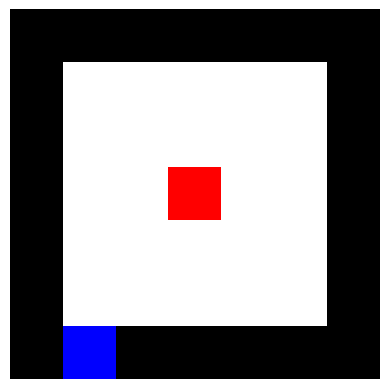

Episode: 3235839 
    Avg Iterations (last 4096 episodes): 7.82 
    Avg Score (last 4096): 2.1375 
    SnakeLength: 1.1181640625 
    Eplsilon: 0.035394418751069835 
    Learning Rate: 0.1
    


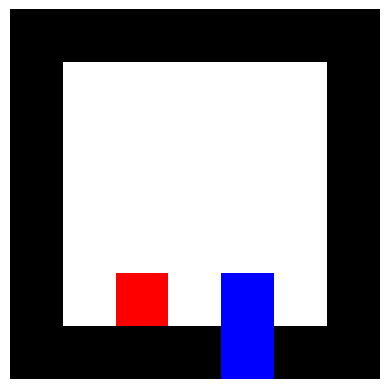

Episode: 3239935 
    Avg Iterations (last 4096 episodes): 7.26 
    Avg Score (last 4096): 1.7945 
    SnakeLength: 1.111328125 
    Eplsilon: 0.03524973964460793 
    Learning Rate: 0.1
    


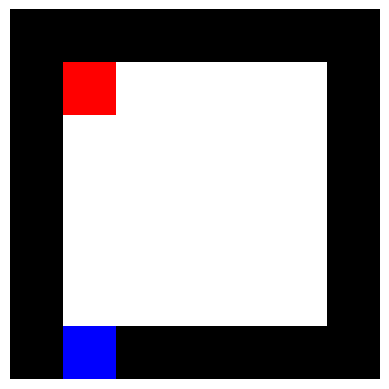

Episode: 3244031 
    Avg Iterations (last 4096 episodes): 7.74 
    Avg Score (last 4096): 2.0790 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.03510565193205999 
    Learning Rate: 0.1
    


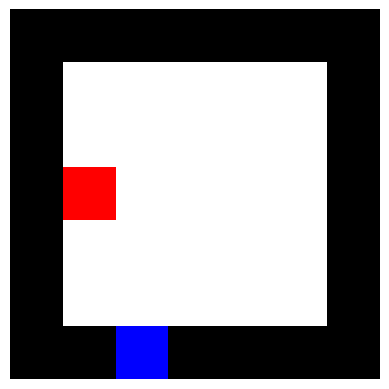

Episode: 3248127 
    Avg Iterations (last 4096 episodes): 7.36 
    Avg Score (last 4096): 1.8781 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.034962153196030306 
    Learning Rate: 0.1
    


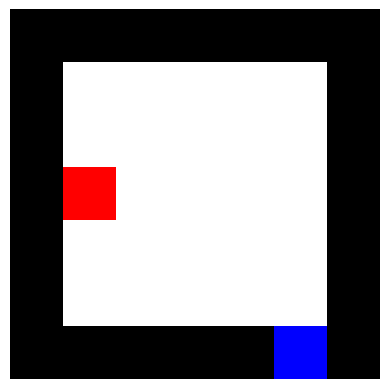

Episode: 3252223 
    Avg Iterations (last 4096 episodes): 7.89 
    Avg Score (last 4096): 2.1982 
    SnakeLength: 1.107177734375 
    Eplsilon: 0.03481924102900282 
    Learning Rate: 0.1
    


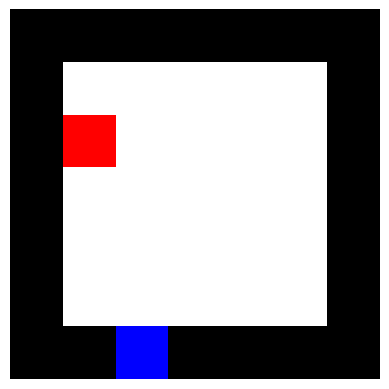

Episode: 3256319 
    Avg Iterations (last 4096 episodes): 7.79 
    Avg Score (last 4096): 2.0849 
    SnakeLength: 1.10498046875 
    Eplsilon: 0.03467691303330413 
    Learning Rate: 0.1
    


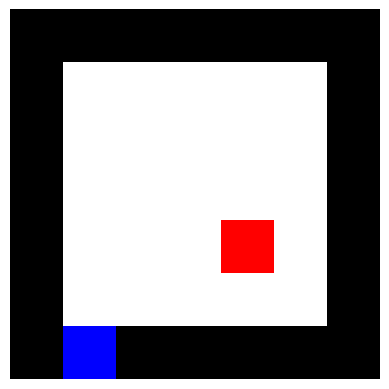

Episode: 3260415 
    Avg Iterations (last 4096 episodes): 8.36 
    Avg Score (last 4096): 2.4475 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.034535166821060656 
    Learning Rate: 0.1
    


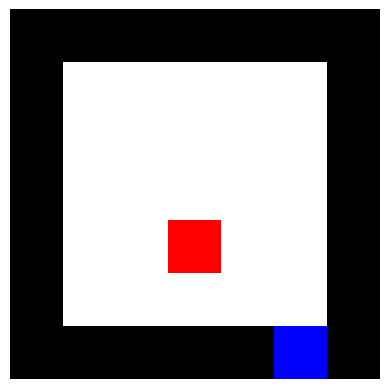

Episode: 3264511 
    Avg Iterations (last 4096 episodes): 7.94 
    Avg Score (last 4096): 2.1757 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.034394000014160306 
    Learning Rate: 0.1
    


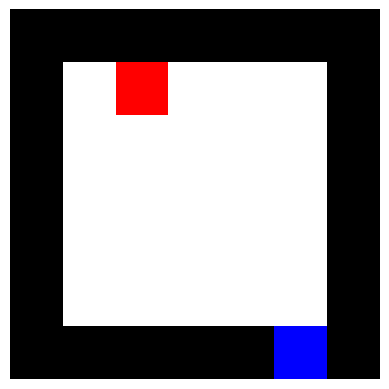

Episode: 3268607 
    Avg Iterations (last 4096 episodes): 7.97 
    Avg Score (last 4096): 2.1402 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.034253410244211024 
    Learning Rate: 0.1
    


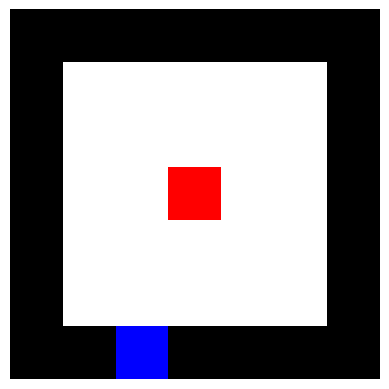

Episode: 3272703 
    Avg Iterations (last 4096 episodes): 8.14 
    Avg Score (last 4096): 2.2698 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.034113395152502286 
    Learning Rate: 0.1
    


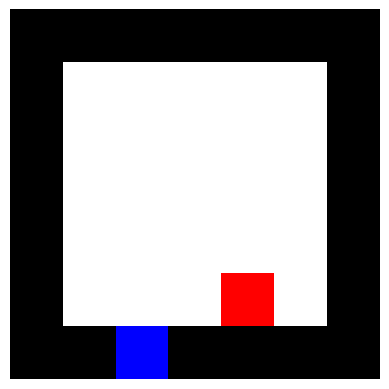

Episode: 3276799 
    Avg Iterations (last 4096 episodes): 8.31 
    Avg Score (last 4096): 2.3795 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.033973952389965034 
    Learning Rate: 0.1
    


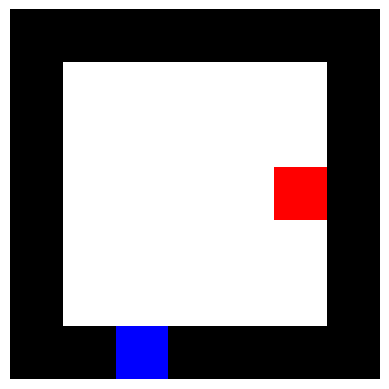

Episode: 3280895 
    Avg Iterations (last 4096 episodes): 7.95 
    Avg Score (last 4096): 2.1659 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.033835079617132204 
    Learning Rate: 0.1
    


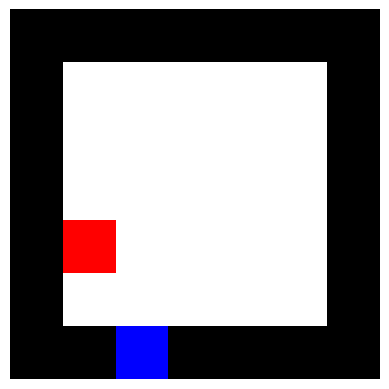

Episode: 3284991 
    Avg Iterations (last 4096 episodes): 8.04 
    Avg Score (last 4096): 2.1416 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.033696774504100246 
    Learning Rate: 0.1
    


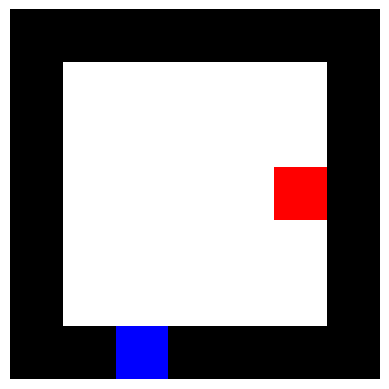

Episode: 3289087 
    Avg Iterations (last 4096 episodes): 8.08 
    Avg Score (last 4096): 2.2724 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.033559034730488296 
    Learning Rate: 0.1
    


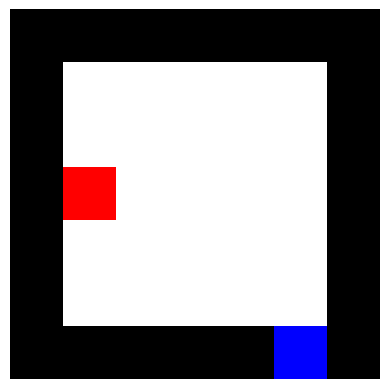

Episode: 3293183 
    Avg Iterations (last 4096 episodes): 9.13 
    Avg Score (last 4096): 2.6779 
    SnakeLength: 1.1220703125 
    Eplsilon: 0.0334218579854009 
    Learning Rate: 0.1
    


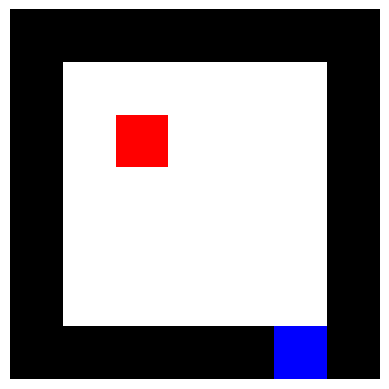

Episode: 3297279 
    Avg Iterations (last 4096 episodes): 8.45 
    Avg Score (last 4096): 2.3491 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.03328524196738868 
    Learning Rate: 0.1
    


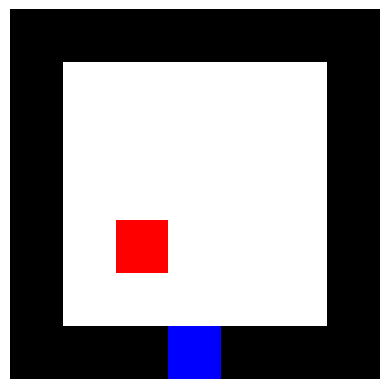

Episode: 3301375 
    Avg Iterations (last 4096 episodes): 7.87 
    Avg Score (last 4096): 2.1466 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.0331491843844099 
    Learning Rate: 0.1
    


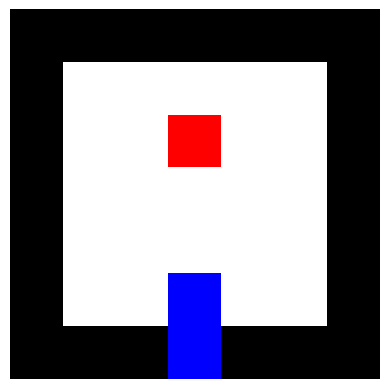

Episode: 3305471 
    Avg Iterations (last 4096 episodes): 8.22 
    Avg Score (last 4096): 2.3142 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.033013682953791285 
    Learning Rate: 0.1
    


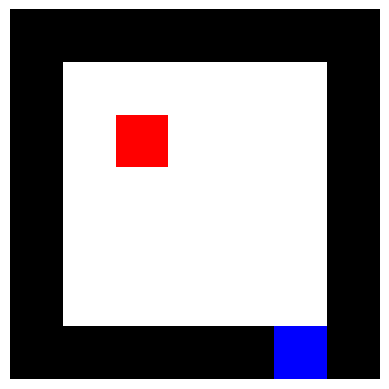

Episode: 3309567 
    Avg Iterations (last 4096 episodes): 7.82 
    Avg Score (last 4096): 2.1986 
    SnakeLength: 1.1015625 
    Eplsilon: 0.03287873540219087 
    Learning Rate: 0.1
    


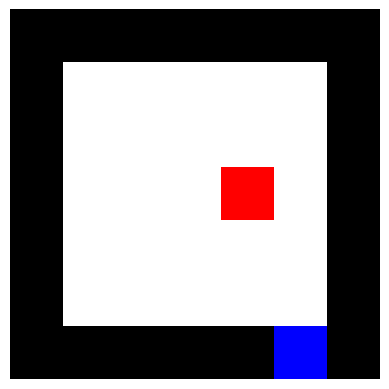

Episode: 3313663 
    Avg Iterations (last 4096 episodes): 7.88 
    Avg Score (last 4096): 2.0897 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.03274433946555898 
    Learning Rate: 0.1
    


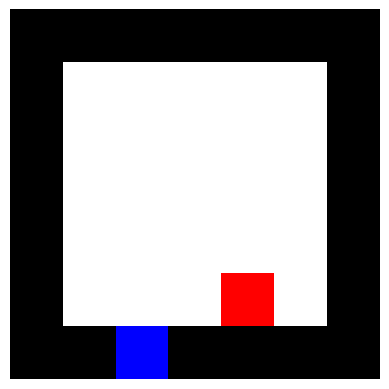

Episode: 3317759 
    Avg Iterations (last 4096 episodes): 8.65 
    Avg Score (last 4096): 2.4749 
    SnakeLength: 1.11767578125 
    Eplsilon: 0.03261049288910052 
    Learning Rate: 0.1
    


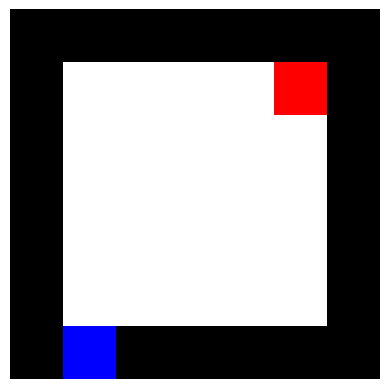

Episode: 3321855 
    Avg Iterations (last 4096 episodes): 8.29 
    Avg Score (last 4096): 2.4420 
    SnakeLength: 1.115234375 
    Eplsilon: 0.032477193427237025 
    Learning Rate: 0.1
    


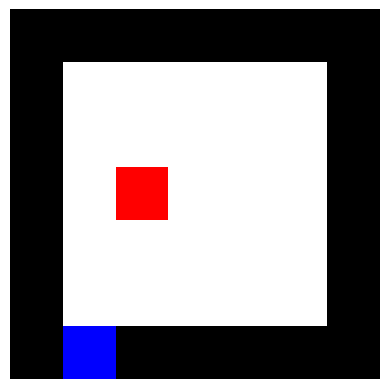

Episode: 3325951 
    Avg Iterations (last 4096 episodes): 9.26 
    Avg Score (last 4096): 2.6012 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.03234443884356986 
    Learning Rate: 0.1
    


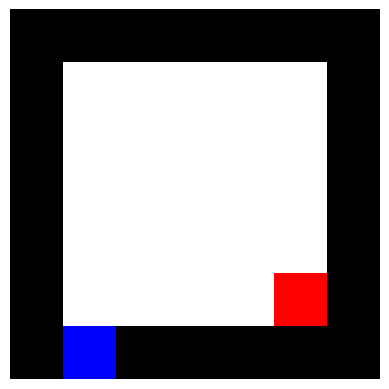

Episode: 3330047 
    Avg Iterations (last 4096 episodes): 8.57 
    Avg Score (last 4096): 2.3821 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.03221222691084103 
    Learning Rate: 0.1
    


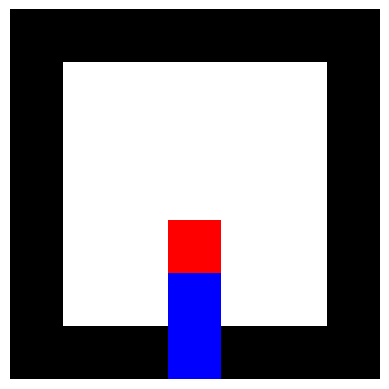

Episode: 3334143 
    Avg Iterations (last 4096 episodes): 8.44 
    Avg Score (last 4096): 2.3968 
    SnakeLength: 1.1025390625 
    Eplsilon: 0.03208055541089681 
    Learning Rate: 0.1
    


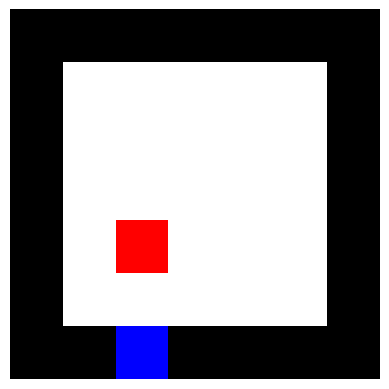

Episode: 3338239 
    Avg Iterations (last 4096 episodes): 7.63 
    Avg Score (last 4096): 1.9857 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.03194942213465077 
    Learning Rate: 0.1
    


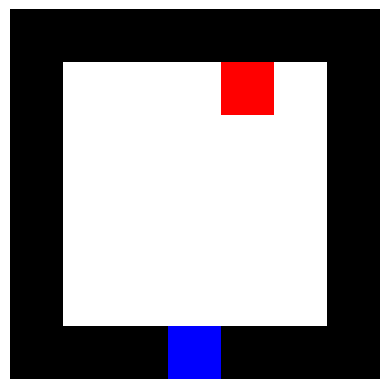

Episode: 3342335 
    Avg Iterations (last 4096 episodes): 7.69 
    Avg Score (last 4096): 2.0446 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.03181882488204639 
    Learning Rate: 0.1
    


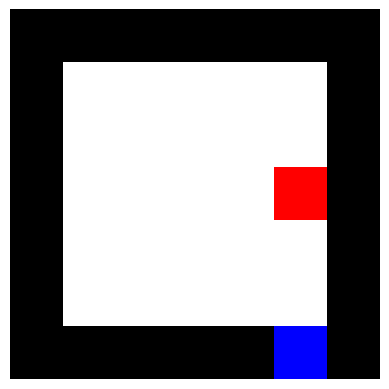

Episode: 3346431 
    Avg Iterations (last 4096 episodes): 8.78 
    Avg Score (last 4096): 2.4889 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.03168876146202013 
    Learning Rate: 0.1
    


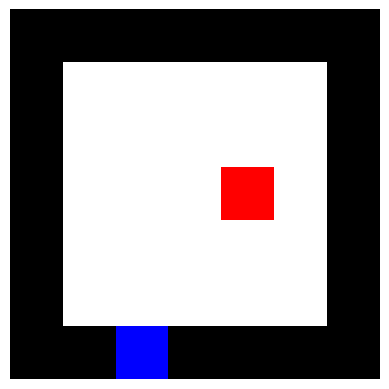

Episode: 3350527 
    Avg Iterations (last 4096 episodes): 8.10 
    Avg Score (last 4096): 2.2289 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.03155922969246474 
    Learning Rate: 0.1
    


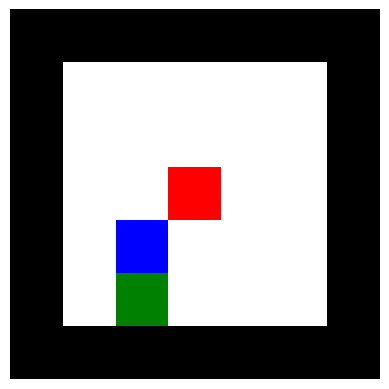

Episode: 3354623 
    Avg Iterations (last 4096 episodes): 7.99 
    Avg Score (last 4096): 2.2462 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.03143022740019254 
    Learning Rate: 0.1
    


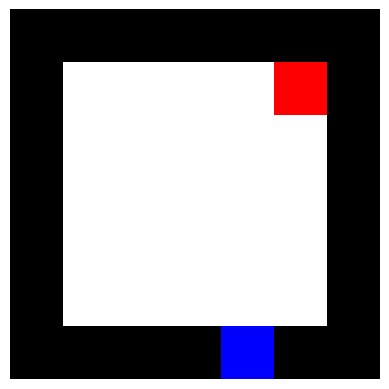

Episode: 3358719 
    Avg Iterations (last 4096 episodes): 8.38 
    Avg Score (last 4096): 2.3032 
    SnakeLength: 1.10546875 
    Eplsilon: 0.03130175242089873 
    Learning Rate: 0.1
    


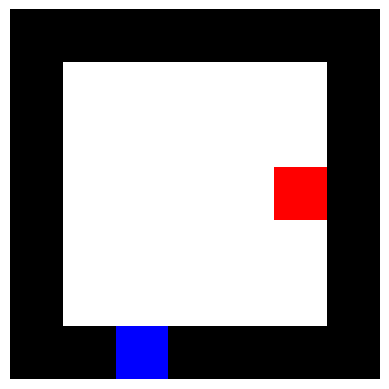

Episode: 3362815 
    Avg Iterations (last 4096 episodes): 8.79 
    Avg Score (last 4096): 2.4514 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.031173802599125937 
    Learning Rate: 0.1
    


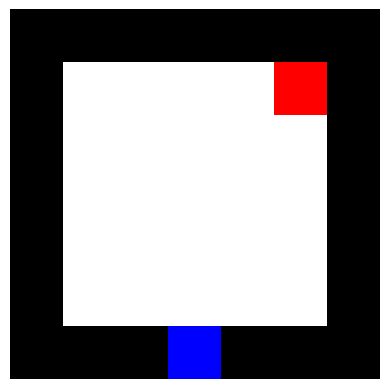

Episode: 3366911 
    Avg Iterations (last 4096 episodes): 8.65 
    Avg Score (last 4096): 2.4398 
    SnakeLength: 1.109375 
    Eplsilon: 0.031046375788227137 
    Learning Rate: 0.1
    


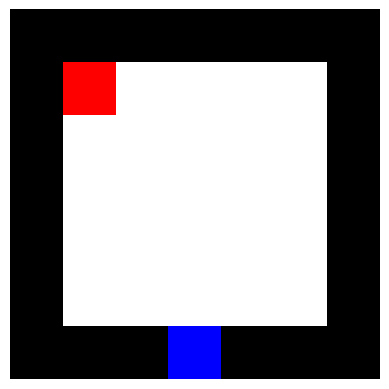

Episode: 3371007 
    Avg Iterations (last 4096 episodes): 8.59 
    Avg Score (last 4096): 2.5113 
    SnakeLength: 1.119384765625 
    Eplsilon: 0.030919469850330176 
    Learning Rate: 0.1
    


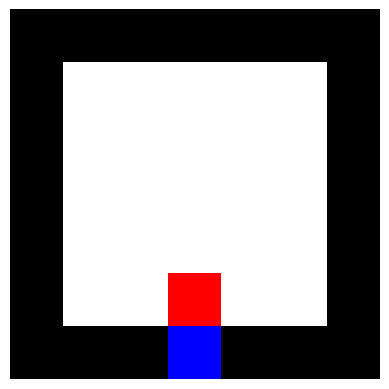

Episode: 3375103 
    Avg Iterations (last 4096 episodes): 8.80 
    Avg Score (last 4096): 2.5747 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.03079308265630154 
    Learning Rate: 0.1
    


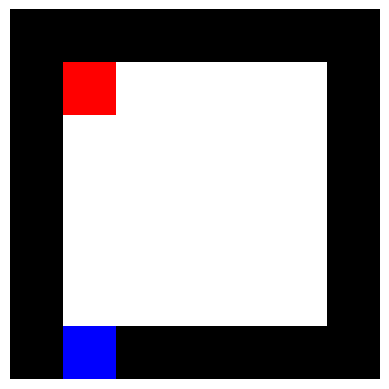

Episode: 3379199 
    Avg Iterations (last 4096 episodes): 9.04 
    Avg Score (last 4096): 2.5520 
    SnakeLength: 1.10498046875 
    Eplsilon: 0.030667212085710795 
    Learning Rate: 0.1
    


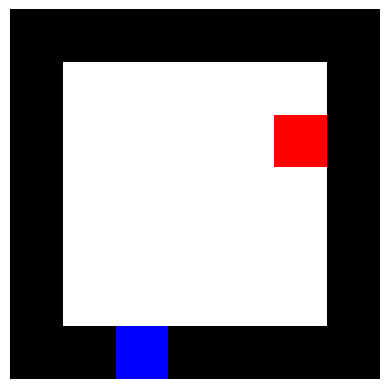

Episode: 3383295 
    Avg Iterations (last 4096 episodes): 8.17 
    Avg Score (last 4096): 2.3058 
    SnakeLength: 1.10546875 
    Eplsilon: 0.03054185602679529 
    Learning Rate: 0.1
    


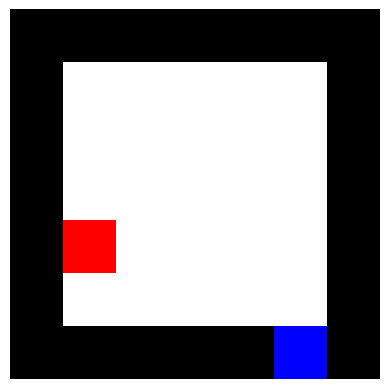

Episode: 3387391 
    Avg Iterations (last 4096 episodes): 7.83 
    Avg Score (last 4096): 2.1480 
    SnakeLength: 1.107177734375 
    Eplsilon: 0.030417012376424128 
    Learning Rate: 0.1
    


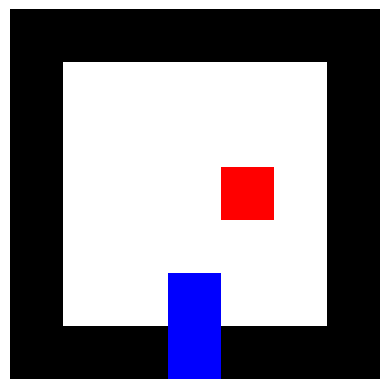

Episode: 3391487 
    Avg Iterations (last 4096 episodes): 8.42 
    Avg Score (last 4096): 2.3811 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.030292679040063563 
    Learning Rate: 0.1
    


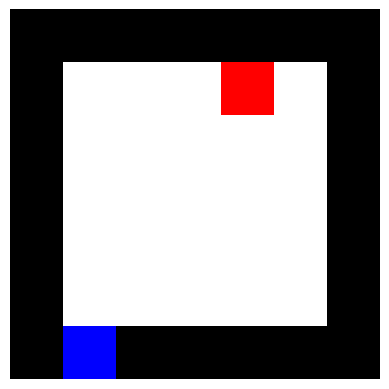

Episode: 3395583 
    Avg Iterations (last 4096 episodes): 8.79 
    Avg Score (last 4096): 2.5673 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.030168853931741343 
    Learning Rate: 0.1
    


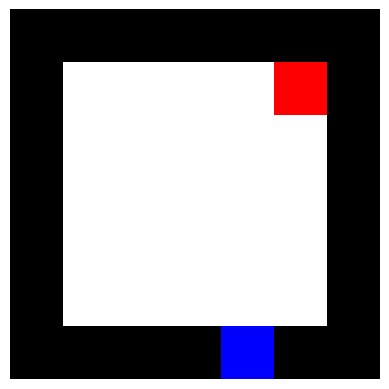

Episode: 3399679 
    Avg Iterations (last 4096 episodes): 8.93 
    Avg Score (last 4096): 2.5678 
    SnakeLength: 1.11767578125 
    Eplsilon: 0.03004553497401178 
    Learning Rate: 0.1
    


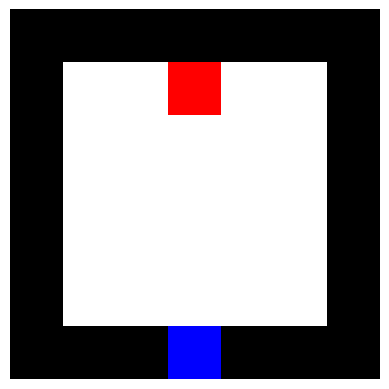

Episode: 3403775 
    Avg Iterations (last 4096 episodes): 8.22 
    Avg Score (last 4096): 2.3147 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.02992272009792122 
    Learning Rate: 0.1
    


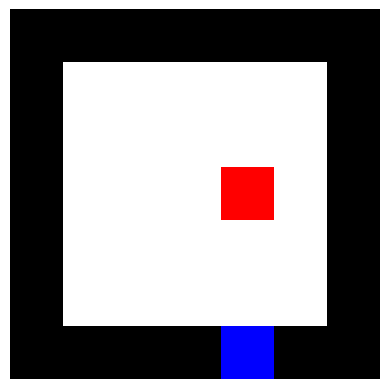

Episode: 3407871 
    Avg Iterations (last 4096 episodes): 9.71 
    Avg Score (last 4096): 2.8686 
    SnakeLength: 1.1044921875 
    Eplsilon: 0.029800407242972886 
    Learning Rate: 0.1
    


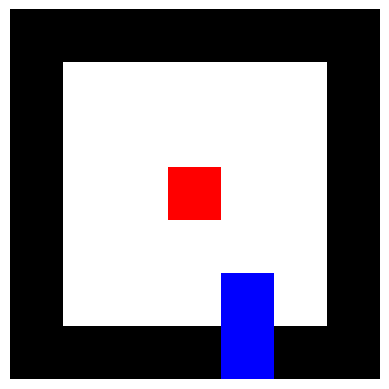

Episode: 3411967 
    Avg Iterations (last 4096 episodes): 8.17 
    Avg Score (last 4096): 2.2704 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.0296785943570928 
    Learning Rate: 0.1
    


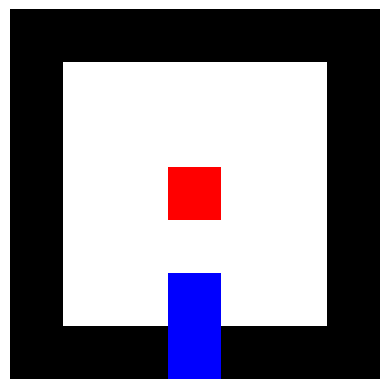

Episode: 3416063 
    Avg Iterations (last 4096 episodes): 8.96 
    Avg Score (last 4096): 2.6163 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.02955727939659494 
    Learning Rate: 0.1
    


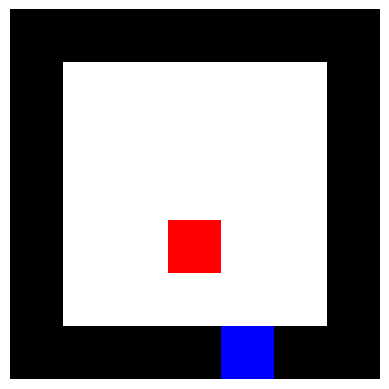

Episode: 3420159 
    Avg Iterations (last 4096 episodes): 9.55 
    Avg Score (last 4096): 2.7170 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.029436460326147048 
    Learning Rate: 0.1
    


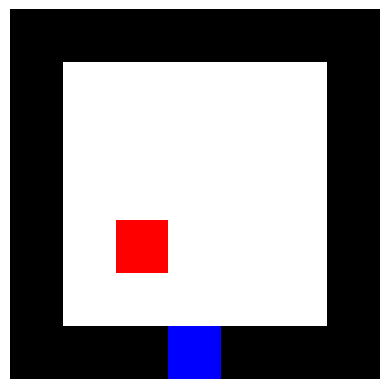

Episode: 3424255 
    Avg Iterations (last 4096 episodes): 9.19 
    Avg Score (last 4096): 2.7270 
    SnakeLength: 1.10302734375 
    Eplsilon: 0.029316135118736694 
    Learning Rate: 0.1
    


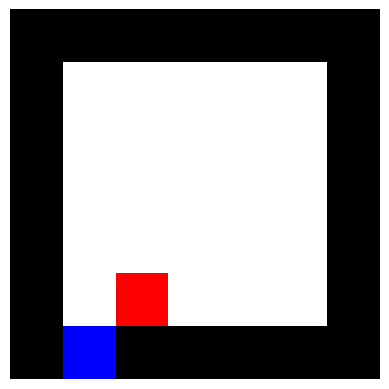

Episode: 3428351 
    Avg Iterations (last 4096 episodes): 9.12 
    Avg Score (last 4096): 2.6357 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.029196301755637134 
    Learning Rate: 0.1
    


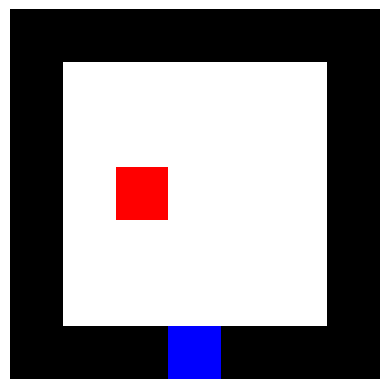

Episode: 3432447 
    Avg Iterations (last 4096 episodes): 8.92 
    Avg Score (last 4096): 2.6844 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.029076958226373097 
    Learning Rate: 0.1
    


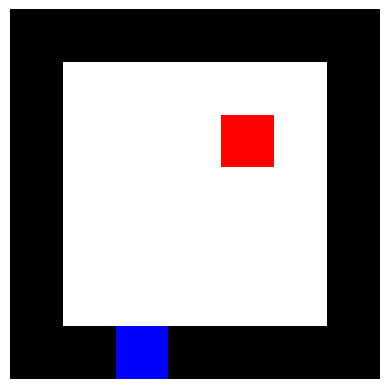

Episode: 3436543 
    Avg Iterations (last 4096 episodes): 9.02 
    Avg Score (last 4096): 2.6883 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.028958102528687867 
    Learning Rate: 0.1
    


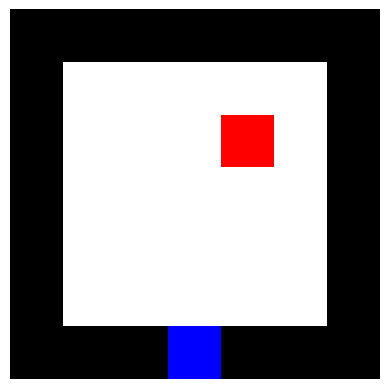

Episode: 3440639 
    Avg Iterations (last 4096 episodes): 8.79 
    Avg Score (last 4096): 2.4272 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.028839732668508623 
    Learning Rate: 0.1
    


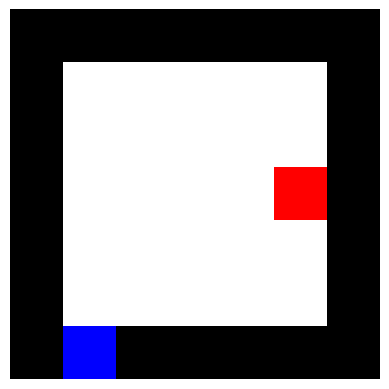

Episode: 3444735 
    Avg Iterations (last 4096 episodes): 8.95 
    Avg Score (last 4096): 2.4685 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.028721846659914316 
    Learning Rate: 0.1
    


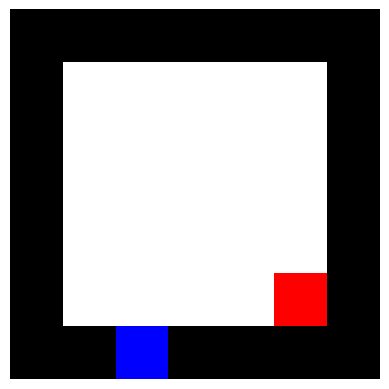

Episode: 3448831 
    Avg Iterations (last 4096 episodes): 8.93 
    Avg Score (last 4096): 2.5429 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.028604442525100804 
    Learning Rate: 0.1
    


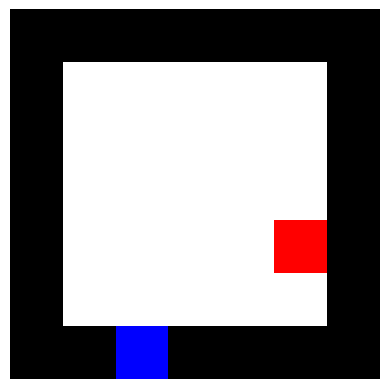

Episode: 3452927 
    Avg Iterations (last 4096 episodes): 9.34 
    Avg Score (last 4096): 2.8276 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.028487518294349066 
    Learning Rate: 0.1
    


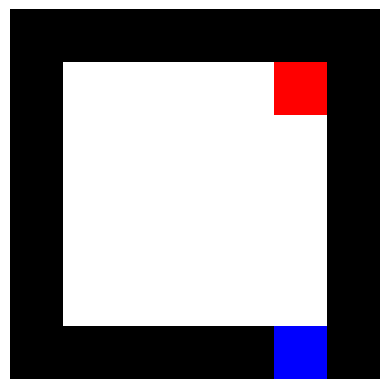

Episode: 3457023 
    Avg Iterations (last 4096 episodes): 8.44 
    Avg Score (last 4096): 2.3607 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.0283710720059913 
    Learning Rate: 0.1
    


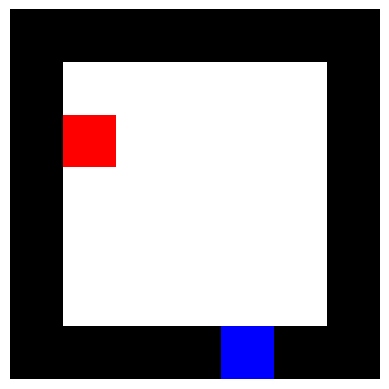

Episode: 3461119 
    Avg Iterations (last 4096 episodes): 9.08 
    Avg Score (last 4096): 2.6697 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.028255101706378103 
    Learning Rate: 0.1
    


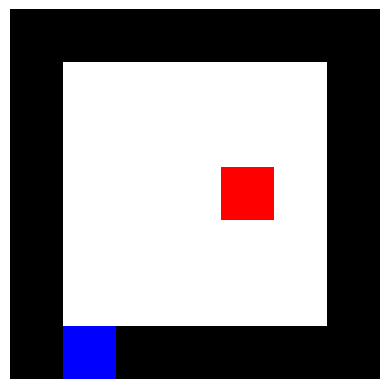

Episode: 3465215 
    Avg Iterations (last 4096 episodes): 9.15 
    Avg Score (last 4096): 2.6843 
    SnakeLength: 1.109375 
    Eplsilon: 0.028139605449846134 
    Learning Rate: 0.1
    


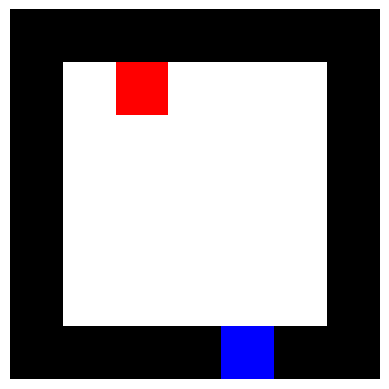

Episode: 3469311 
    Avg Iterations (last 4096 episodes): 8.32 
    Avg Score (last 4096): 2.3280 
    SnakeLength: 1.1015625 
    Eplsilon: 0.028024581298685226 
    Learning Rate: 0.1
    


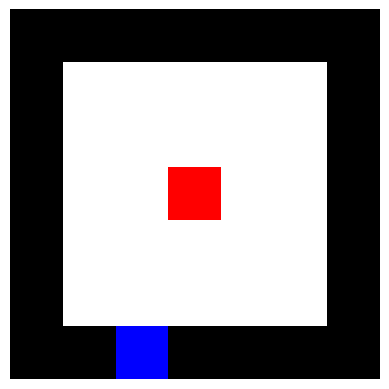

Episode: 3473407 
    Avg Iterations (last 4096 episodes): 8.70 
    Avg Score (last 4096): 2.4668 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.027910027323105605 
    Learning Rate: 0.1
    


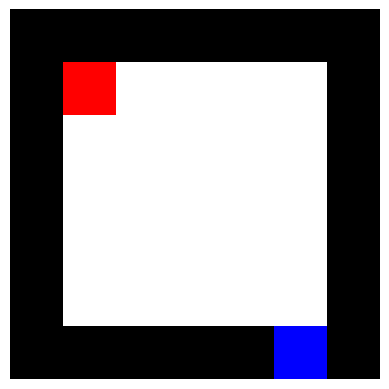

Episode: 3477503 
    Avg Iterations (last 4096 episodes): 9.08 
    Avg Score (last 4096): 2.7889 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.027795941601205888 
    Learning Rate: 0.1
    


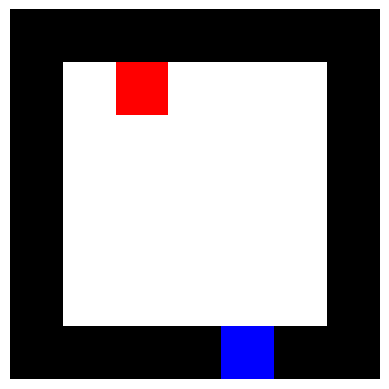

Episode: 3481599 
    Avg Iterations (last 4096 episodes): 9.46 
    Avg Score (last 4096): 2.7544 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.0276823222189407 
    Learning Rate: 0.1
    


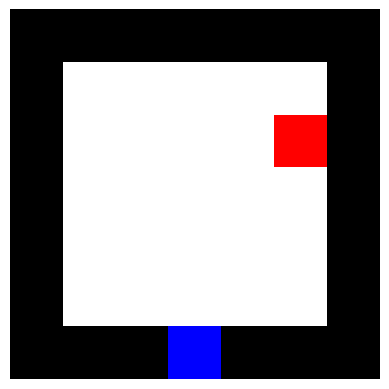

Episode: 3485695 
    Avg Iterations (last 4096 episodes): 9.36 
    Avg Score (last 4096): 2.8729 
    SnakeLength: 1.115234375 
    Eplsilon: 0.027569167270088523 
    Learning Rate: 0.1
    


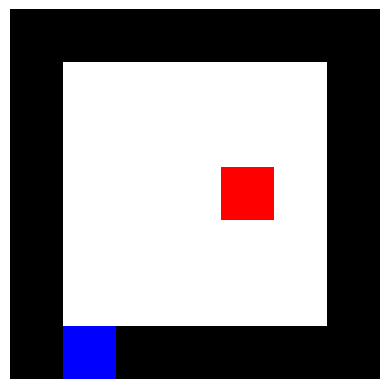

Episode: 3489791 
    Avg Iterations (last 4096 episodes): 8.87 
    Avg Score (last 4096): 2.5060 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.02745647485622002 
    Learning Rate: 0.1
    


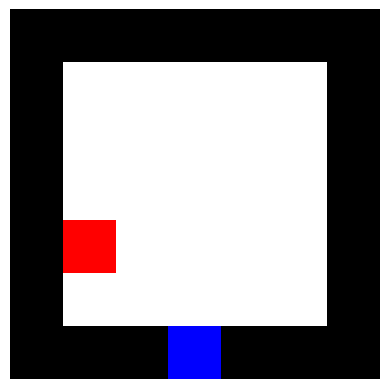

Episode: 3493887 
    Avg Iterations (last 4096 episodes): 9.60 
    Avg Score (last 4096): 2.8324 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.027344243086665235 
    Learning Rate: 0.1
    


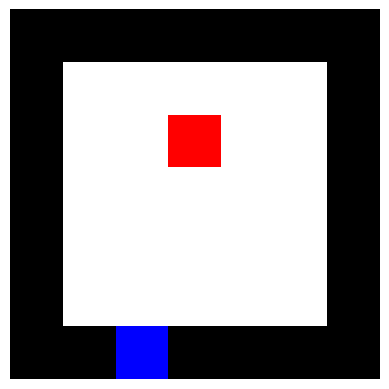

Episode: 3497983 
    Avg Iterations (last 4096 episodes): 9.20 
    Avg Score (last 4096): 2.7227 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.027232470078483256 
    Learning Rate: 0.1
    


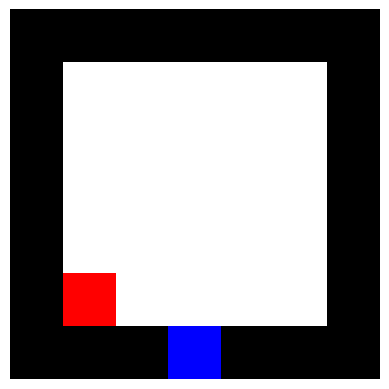

Episode: 3502079 
    Avg Iterations (last 4096 episodes): 8.97 
    Avg Score (last 4096): 2.5757 
    SnakeLength: 1.113037109375 
    Eplsilon: 0.027121153956429705 
    Learning Rate: 0.1
    


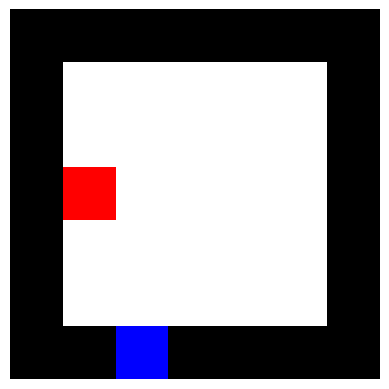

Episode: 3506175 
    Avg Iterations (last 4096 episodes): 10.08 
    Avg Score (last 4096): 3.2723 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.027010292852925548 
    Learning Rate: 0.1
    


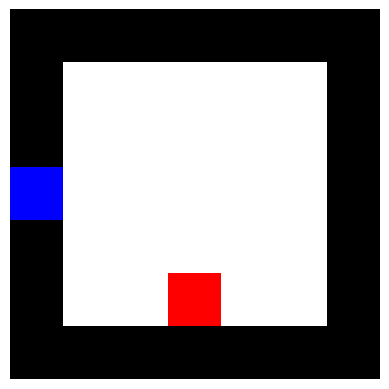

Episode: 3510271 
    Avg Iterations (last 4096 episodes): 8.63 
    Avg Score (last 4096): 2.4117 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.02689988490802556 
    Learning Rate: 0.1
    


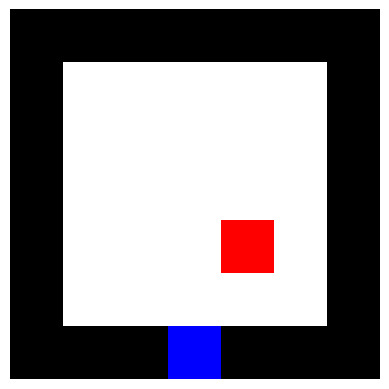

Episode: 3514367 
    Avg Iterations (last 4096 episodes): 9.88 
    Avg Score (last 4096): 3.0121 
    SnakeLength: 1.101318359375 
    Eplsilon: 0.026789928269387316 
    Learning Rate: 0.1
    


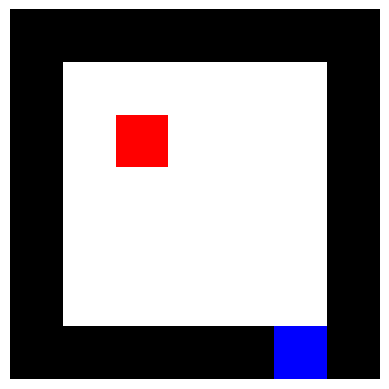

Episode: 3518463 
    Avg Iterations (last 4096 episodes): 9.93 
    Avg Score (last 4096): 2.9646 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.026680421092240055 
    Learning Rate: 0.1
    


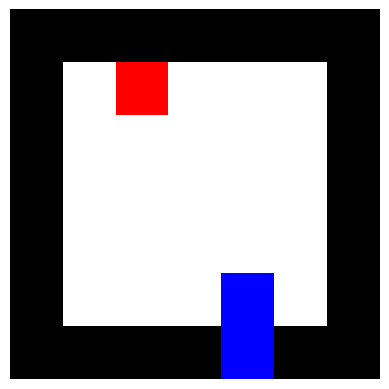

Episode: 3522559 
    Avg Iterations (last 4096 episodes): 9.01 
    Avg Score (last 4096): 2.6507 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.026571361539354015 
    Learning Rate: 0.1
    


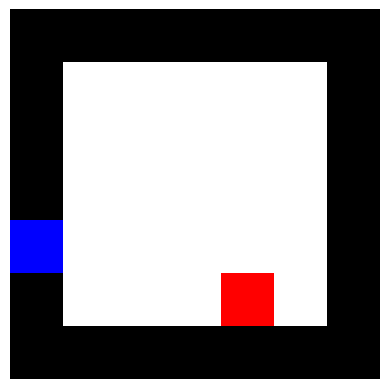

Episode: 3526655 
    Avg Iterations (last 4096 episodes): 9.63 
    Avg Score (last 4096): 2.9521 
    SnakeLength: 1.102294921875 
    Eplsilon: 0.026462747781008947 
    Learning Rate: 0.1
    


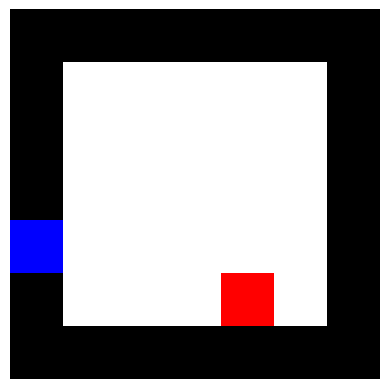

Episode: 3530751 
    Avg Iterations (last 4096 episodes): 9.25 
    Avg Score (last 4096): 2.7125 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.026354577994964188 
    Learning Rate: 0.1
    


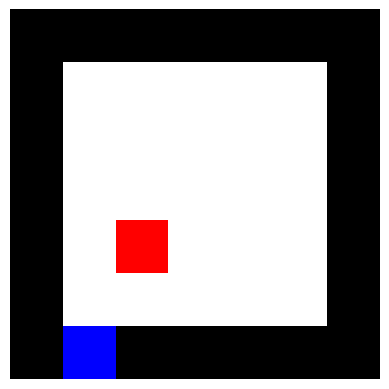

Episode: 3534847 
    Avg Iterations (last 4096 episodes): 9.14 
    Avg Score (last 4096): 2.7261 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.026246850366427307 
    Learning Rate: 0.1
    


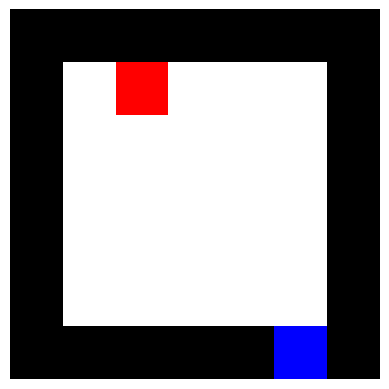

Episode: 3538943 
    Avg Iterations (last 4096 episodes): 9.62 
    Avg Score (last 4096): 3.0269 
    SnakeLength: 1.105224609375 
    Eplsilon: 0.02613956308802434 
    Learning Rate: 0.1
    


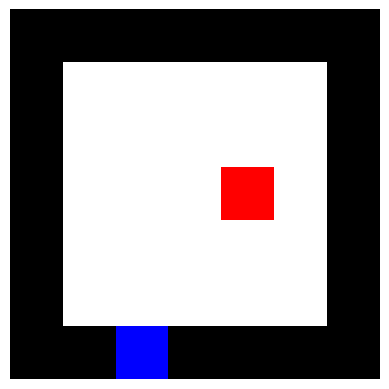

Episode: 3543039 
    Avg Iterations (last 4096 episodes): 9.39 
    Avg Score (last 4096): 2.8249 
    SnakeLength: 1.106201171875 
    Eplsilon: 0.02603271435976914 
    Learning Rate: 0.1
    


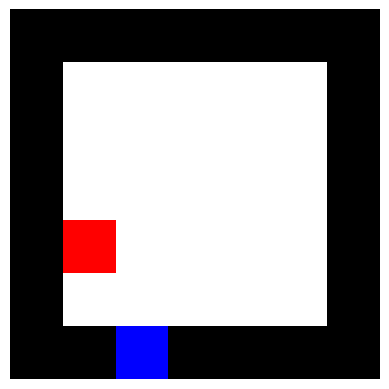

Episode: 3547135 
    Avg Iterations (last 4096 episodes): 9.70 
    Avg Score (last 4096): 2.9437 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.025926302389033252 
    Learning Rate: 0.1
    


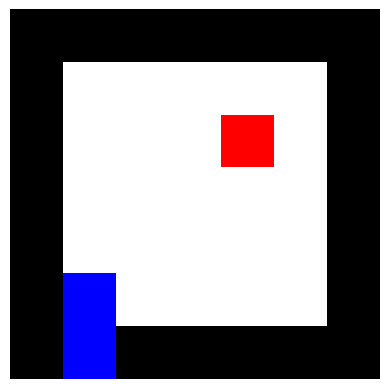

Episode: 3551231 
    Avg Iterations (last 4096 episodes): 9.49 
    Avg Score (last 4096): 2.8623 
    SnakeLength: 1.11669921875 
    Eplsilon: 0.025820325390515847 
    Learning Rate: 0.1
    


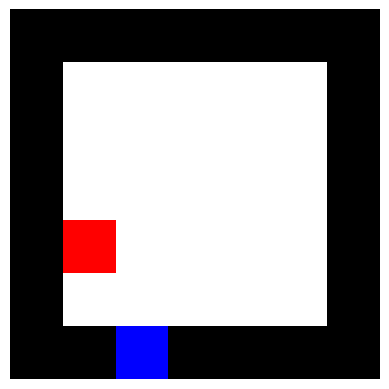

Episode: 3555327 
    Avg Iterations (last 4096 episodes): 8.68 
    Avg Score (last 4096): 2.6328 
    SnakeLength: 1.121826171875 
    Eplsilon: 0.02571478158621368 
    Learning Rate: 0.1
    


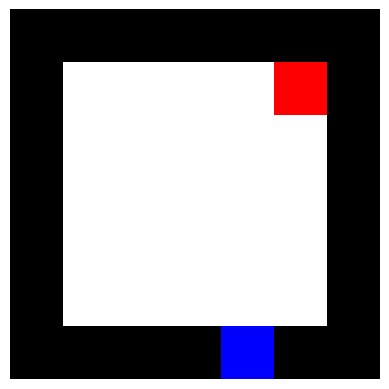

Episode: 3559423 
    Avg Iterations (last 4096 episodes): 9.47 
    Avg Score (last 4096): 2.8990 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.02560966920539096 
    Learning Rate: 0.1
    


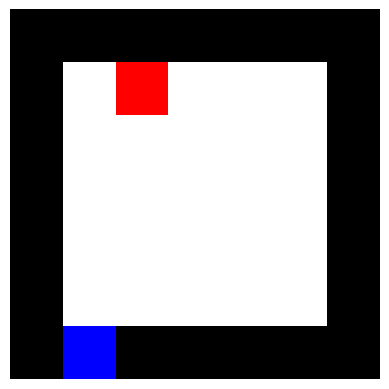

Episode: 3563519 
    Avg Iterations (last 4096 episodes): 9.81 
    Avg Score (last 4096): 2.9456 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.025504986484550726 
    Learning Rate: 0.1
    


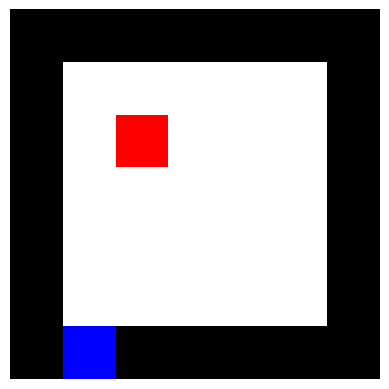

Episode: 3567615 
    Avg Iterations (last 4096 episodes): 9.97 
    Avg Score (last 4096): 2.9384 
    SnakeLength: 1.099365234375 
    Eplsilon: 0.025400731667403847 
    Learning Rate: 0.1
    


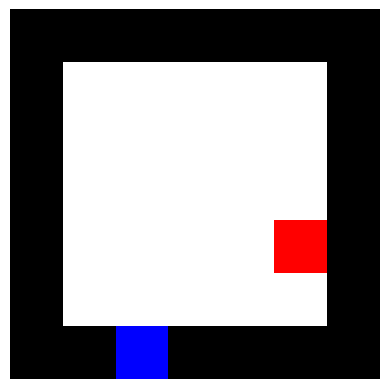

Episode: 3571711 
    Avg Iterations (last 4096 episodes): 9.91 
    Avg Score (last 4096): 2.9950 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.02529690300484078 
    Learning Rate: 0.1
    


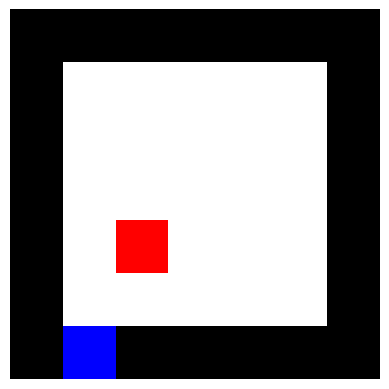

Episode: 3575807 
    Avg Iterations (last 4096 episodes): 10.85 
    Avg Score (last 4096): 3.3686 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.0251934987549015 
    Learning Rate: 0.1
    


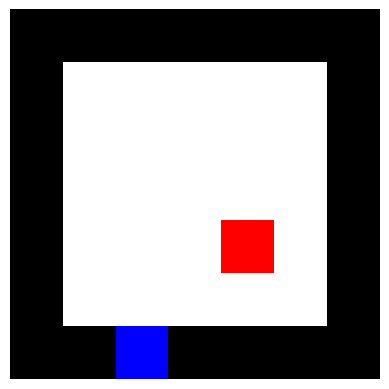

Episode: 3579903 
    Avg Iterations (last 4096 episodes): 9.12 
    Avg Score (last 4096): 2.6492 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.025090517182746165 
    Learning Rate: 0.1
    


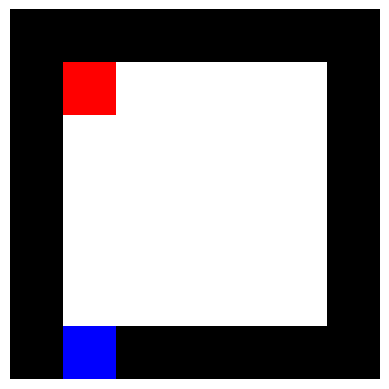

Episode: 3583999 
    Avg Iterations (last 4096 episodes): 9.64 
    Avg Score (last 4096): 2.8869 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.02498795656062658 
    Learning Rate: 0.1
    


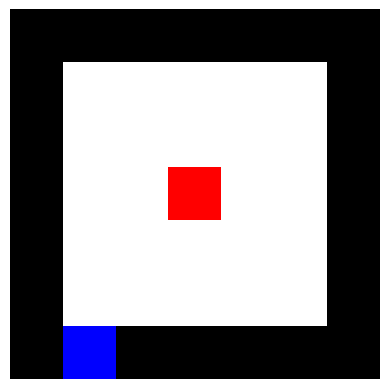

Episode: 3588095 
    Avg Iterations (last 4096 episodes): 10.31 
    Avg Score (last 4096): 3.1446 
    SnakeLength: 1.1171875 
    Eplsilon: 0.02488581516785707 
    Learning Rate: 0.1
    


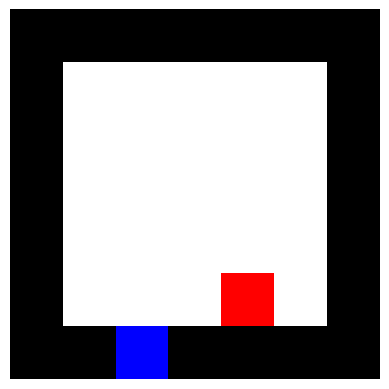

Episode: 3592191 
    Avg Iterations (last 4096 episodes): 9.31 
    Avg Score (last 4096): 2.7317 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.02478409129078522 
    Learning Rate: 0.1
    


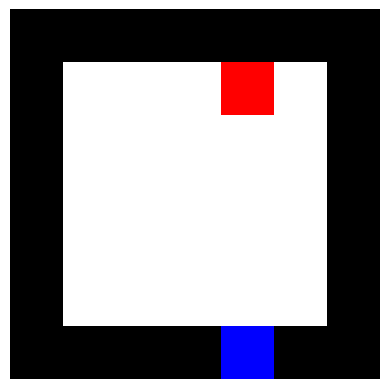

Episode: 3596287 
    Avg Iterations (last 4096 episodes): 9.81 
    Avg Score (last 4096): 2.9999 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.024682783222763485 
    Learning Rate: 0.1
    


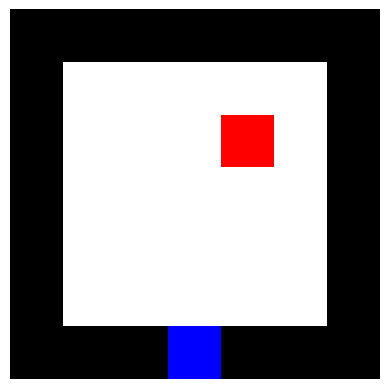

Episode: 3600383 
    Avg Iterations (last 4096 episodes): 9.47 
    Avg Score (last 4096): 2.8028 
    SnakeLength: 1.099365234375 
    Eplsilon: 0.02458188926412039 
    Learning Rate: 0.1
    


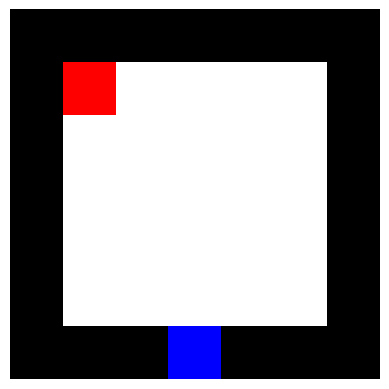

Episode: 3604479 
    Avg Iterations (last 4096 episodes): 9.53 
    Avg Score (last 4096): 2.8251 
    SnakeLength: 1.100341796875 
    Eplsilon: 0.02448140772213238 
    Learning Rate: 0.1
    


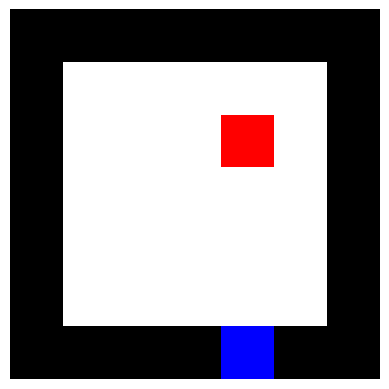

Episode: 3608575 
    Avg Iterations (last 4096 episodes): 9.58 
    Avg Score (last 4096): 2.7818 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.024381336910994623 
    Learning Rate: 0.1
    


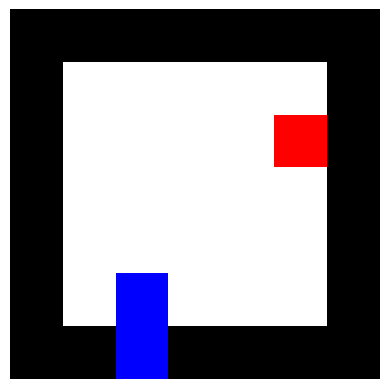

Episode: 3612671 
    Avg Iterations (last 4096 episodes): 9.30 
    Avg Score (last 4096): 2.7134 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.024281675151793507 
    Learning Rate: 0.1
    


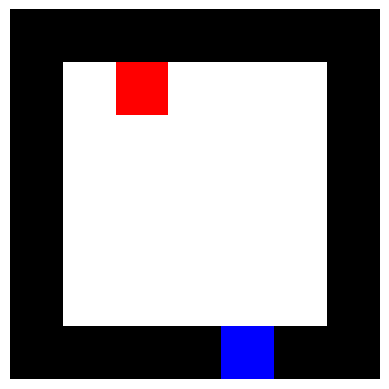

Episode: 3616767 
    Avg Iterations (last 4096 episodes): 9.53 
    Avg Score (last 4096): 2.8682 
    SnakeLength: 1.1025390625 
    Eplsilon: 0.02418242077247833 
    Learning Rate: 0.1
    


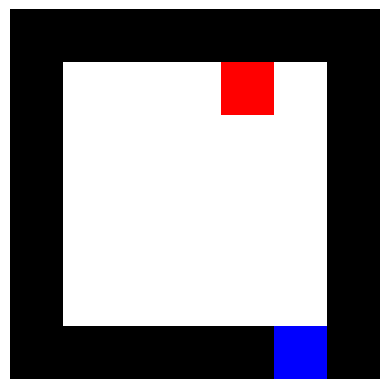

Episode: 3620863 
    Avg Iterations (last 4096 episodes): 9.97 
    Avg Score (last 4096): 3.1365 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.024083572107832685 
    Learning Rate: 0.1
    


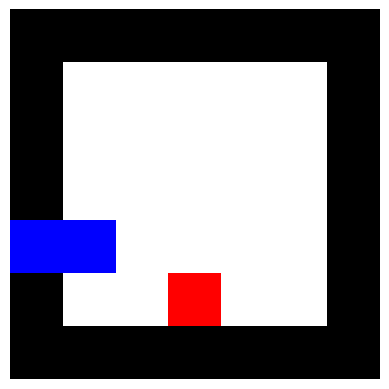

Episode: 3624959 
    Avg Iterations (last 4096 episodes): 9.90 
    Avg Score (last 4096): 2.9717 
    SnakeLength: 1.106689453125 
    Eplsilon: 0.023985127499447482 
    Learning Rate: 0.1
    


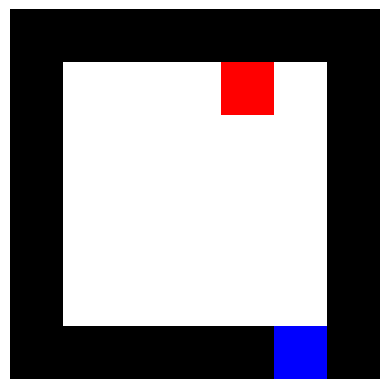

Episode: 3629055 
    Avg Iterations (last 4096 episodes): 10.13 
    Avg Score (last 4096): 3.0314 
    SnakeLength: 1.103759765625 
    Eplsilon: 0.02388708529569205 
    Learning Rate: 0.1
    


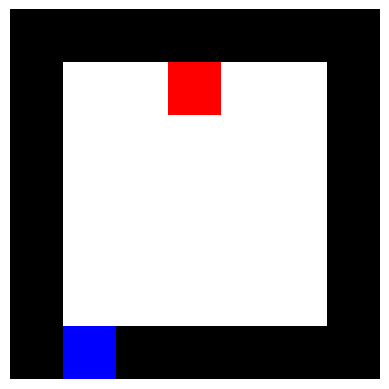

Episode: 3633151 
    Avg Iterations (last 4096 episodes): 11.01 
    Avg Score (last 4096): 3.4631 
    SnakeLength: 1.102294921875 
    Eplsilon: 0.023789443851687384 
    Learning Rate: 0.1
    


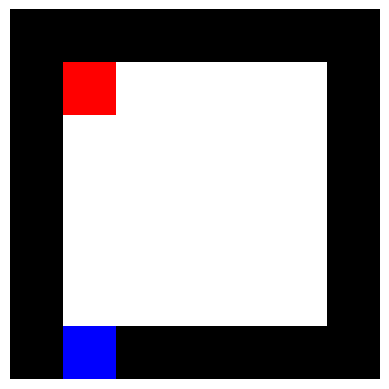

Episode: 3637247 
    Avg Iterations (last 4096 episodes): 10.45 
    Avg Score (last 4096): 3.2337 
    SnakeLength: 1.119140625 
    Eplsilon: 0.023692201529277916 
    Learning Rate: 0.1
    


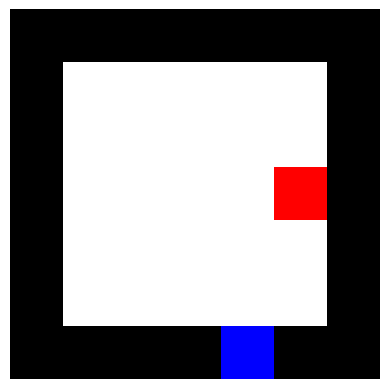

Episode: 3641343 
    Avg Iterations (last 4096 episodes): 10.11 
    Avg Score (last 4096): 3.1015 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.023595356697004147 
    Learning Rate: 0.1
    


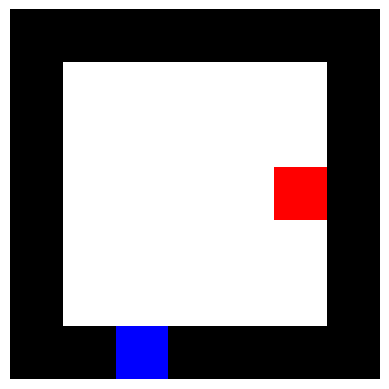

Episode: 3645439 
    Avg Iterations (last 4096 episodes): 9.72 
    Avg Score (last 4096): 2.8610 
    SnakeLength: 1.1044921875 
    Eplsilon: 0.023498907730075597 
    Learning Rate: 0.1
    


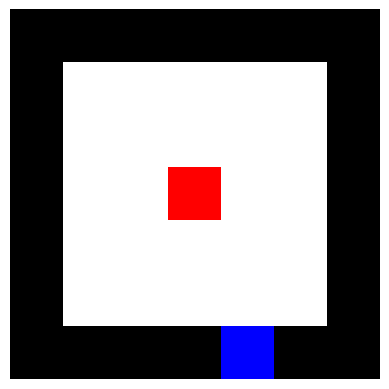

Episode: 3649535 
    Avg Iterations (last 4096 episodes): 10.08 
    Avg Score (last 4096): 3.1734 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.023402853010343318 
    Learning Rate: 0.1
    


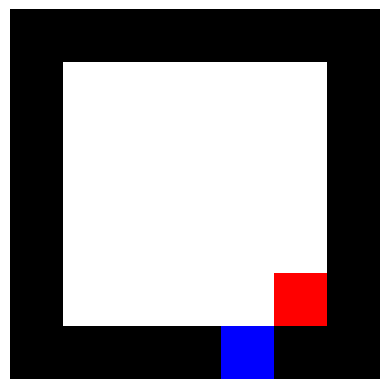

Episode: 3653631 
    Avg Iterations (last 4096 episodes): 10.15 
    Avg Score (last 4096): 3.1804 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.02330719092627255 
    Learning Rate: 0.1
    


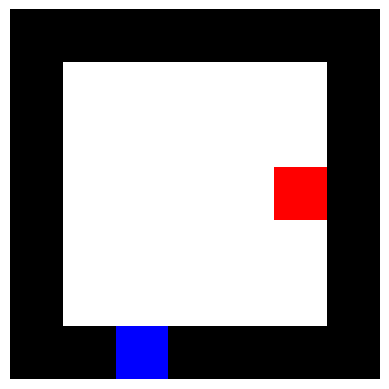

Episode: 3657727 
    Avg Iterations (last 4096 episodes): 10.40 
    Avg Score (last 4096): 3.2926 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.02321191987291625 
    Learning Rate: 0.1
    


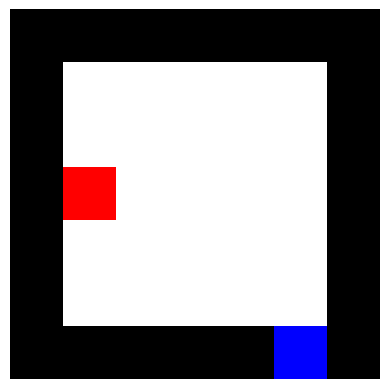

Episode: 3661823 
    Avg Iterations (last 4096 episodes): 10.75 
    Avg Score (last 4096): 3.2306 
    SnakeLength: 1.103271484375 
    Eplsilon: 0.023117038251887247 
    Learning Rate: 0.1
    


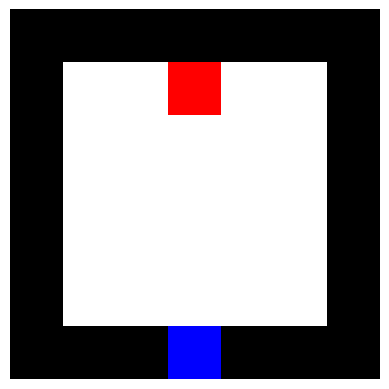

Episode: 3665919 
    Avg Iterations (last 4096 episodes): 9.68 
    Avg Score (last 4096): 2.9171 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.023022544471332347 
    Learning Rate: 0.1
    


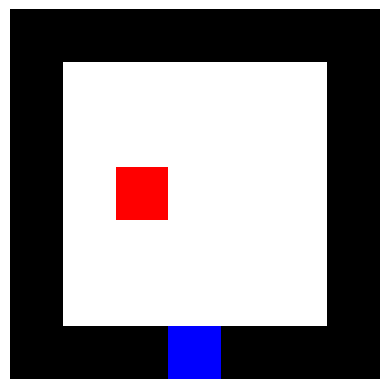

Episode: 3670015 
    Avg Iterations (last 4096 episodes): 9.90 
    Avg Score (last 4096): 2.9626 
    SnakeLength: 1.100830078125 
    Eplsilon: 0.02292843694590526 
    Learning Rate: 0.1
    


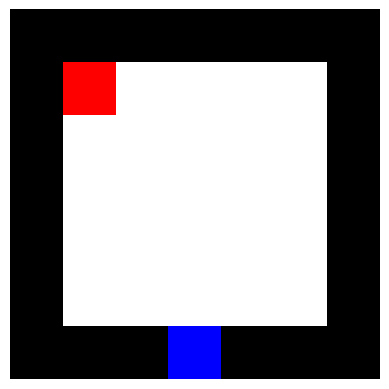

Episode: 3674111 
    Avg Iterations (last 4096 episodes): 10.46 
    Avg Score (last 4096): 3.1988 
    SnakeLength: 1.114501953125 
    Eplsilon: 0.022834714096739882 
    Learning Rate: 0.1
    


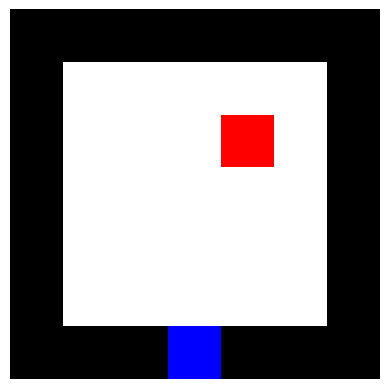

Episode: 3678207 
    Avg Iterations (last 4096 episodes): 9.96 
    Avg Score (last 4096): 2.9817 
    SnakeLength: 1.11083984375 
    Eplsilon: 0.02274137435142397 
    Learning Rate: 0.1
    


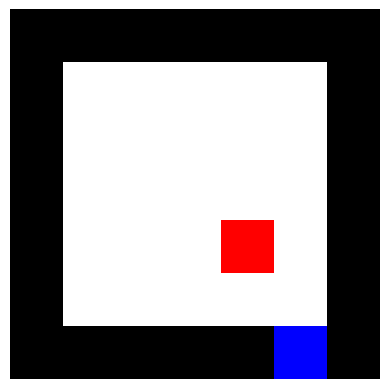

Episode: 3682303 
    Avg Iterations (last 4096 episodes): 10.05 
    Avg Score (last 4096): 3.1120 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.02264841614397255 
    Learning Rate: 0.1
    


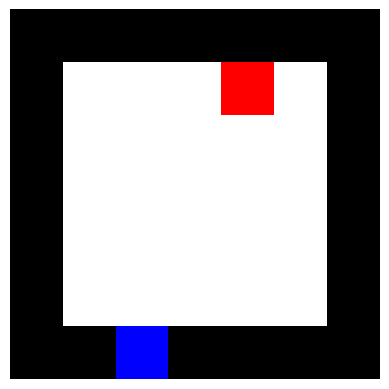

Episode: 3686399 
    Avg Iterations (last 4096 episodes): 11.10 
    Avg Score (last 4096): 3.4977 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.02255583791480224 
    Learning Rate: 0.1
    


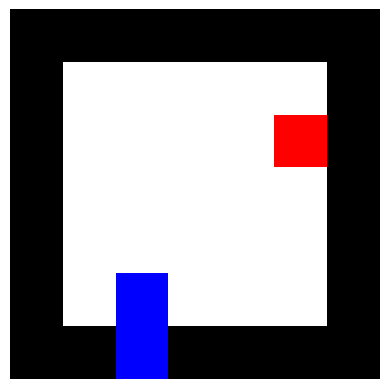

Episode: 3690495 
    Avg Iterations (last 4096 episodes): 10.50 
    Avg Score (last 4096): 3.2923 
    SnakeLength: 1.10400390625 
    Eplsilon: 0.02246363811070415 
    Learning Rate: 0.1
    


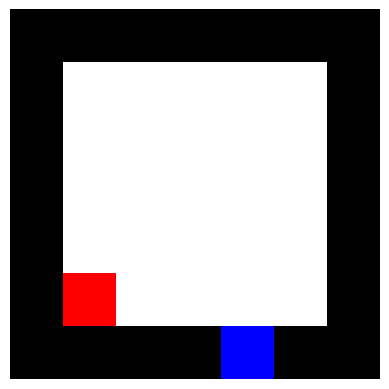

Episode: 3694591 
    Avg Iterations (last 4096 episodes): 10.78 
    Avg Score (last 4096): 3.3808 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.022371815184818573 
    Learning Rate: 0.1
    


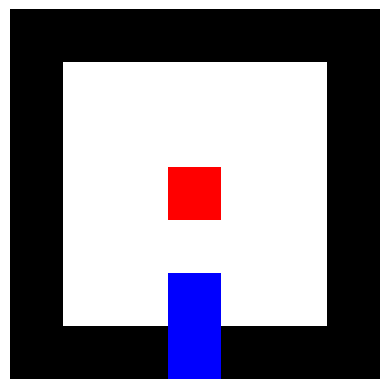

Episode: 3698687 
    Avg Iterations (last 4096 episodes): 10.96 
    Avg Score (last 4096): 3.5083 
    SnakeLength: 1.104248046875 
    Eplsilon: 0.022280367596608883 
    Learning Rate: 0.1
    


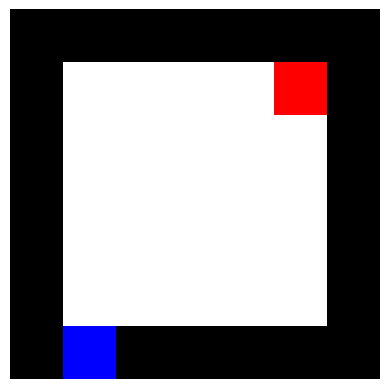

Episode: 3702783 
    Avg Iterations (last 4096 episodes): 11.11 
    Avg Score (last 4096): 3.3761 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.022189293811835216 
    Learning Rate: 0.1
    


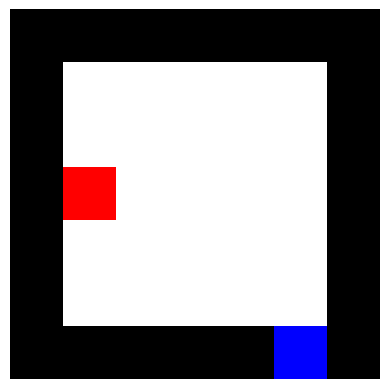

Episode: 3706879 
    Avg Iterations (last 4096 episodes): 10.72 
    Avg Score (last 4096): 3.3868 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.02209859230252958 
    Learning Rate: 0.1
    


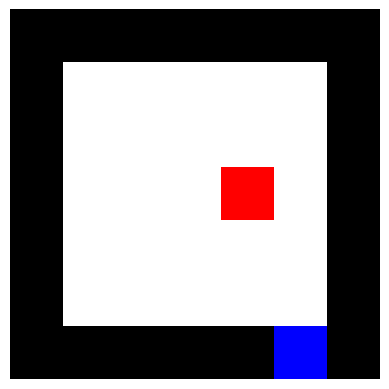

Episode: 3710975 
    Avg Iterations (last 4096 episodes): 10.29 
    Avg Score (last 4096): 3.3186 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.022008261546969287 
    Learning Rate: 0.1
    


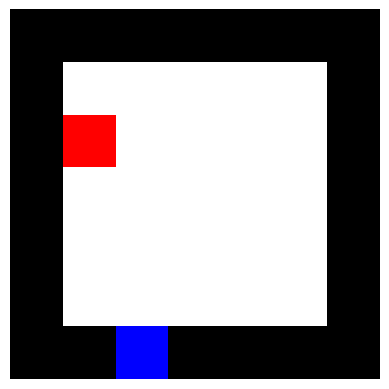

Episode: 3715071 
    Avg Iterations (last 4096 episodes): 10.13 
    Avg Score (last 4096): 3.1565 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.021918300029652282 
    Learning Rate: 0.1
    


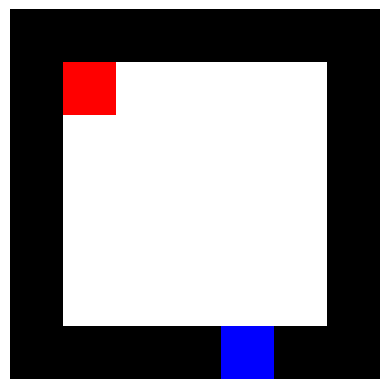

Episode: 3719167 
    Avg Iterations (last 4096 episodes): 10.26 
    Avg Score (last 4096): 3.1712 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.021828706241271128 
    Learning Rate: 0.1
    


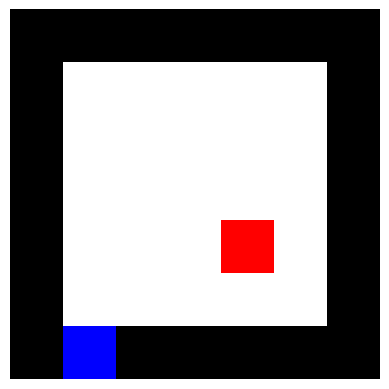

Episode: 3723263 
    Avg Iterations (last 4096 episodes): 11.37 
    Avg Score (last 4096): 3.6433 
    SnakeLength: 1.107421875 
    Eplsilon: 0.021739478678687953 
    Learning Rate: 0.1
    


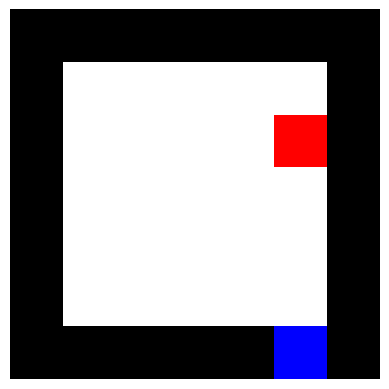

Episode: 3727359 
    Avg Iterations (last 4096 episodes): 10.29 
    Avg Score (last 4096): 3.1350 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.021650615844908846 
    Learning Rate: 0.1
    


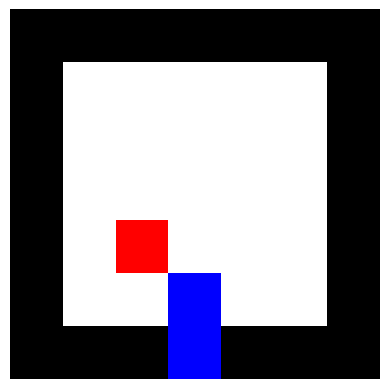

Episode: 3731455 
    Avg Iterations (last 4096 episodes): 10.59 
    Avg Score (last 4096): 3.3733 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.021562116249059453 
    Learning Rate: 0.1
    


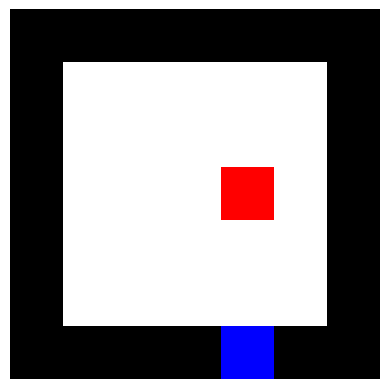

Episode: 3735551 
    Avg Iterations (last 4096 episodes): 10.71 
    Avg Score (last 4096): 3.5641 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.02147397840635938 
    Learning Rate: 0.1
    


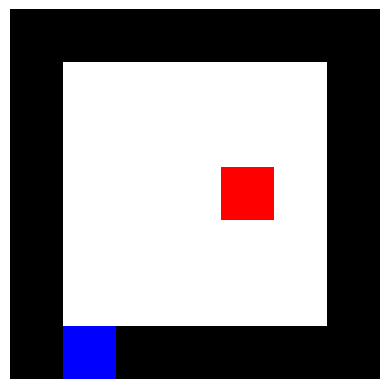

Episode: 3739647 
    Avg Iterations (last 4096 episodes): 10.95 
    Avg Score (last 4096): 3.4928 
    SnakeLength: 1.0986328125 
    Eplsilon: 0.0213862008380974 
    Learning Rate: 0.1
    


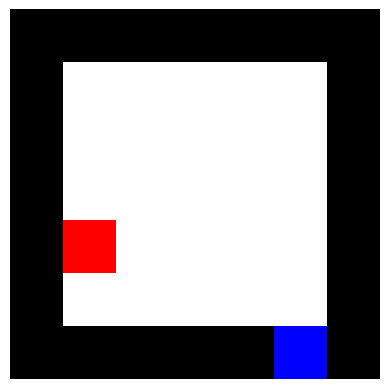

Episode: 3743743 
    Avg Iterations (last 4096 episodes): 10.51 
    Avg Score (last 4096): 3.4570 
    SnakeLength: 1.109375 
    Eplsilon: 0.02129878207160683 
    Learning Rate: 0.1
    


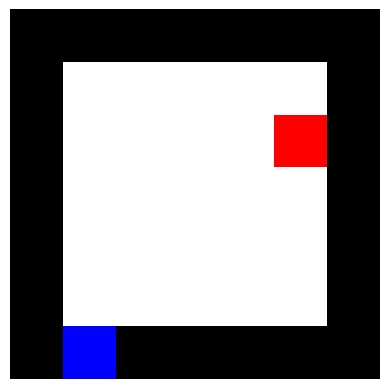

Episode: 3747839 
    Avg Iterations (last 4096 episodes): 11.59 
    Avg Score (last 4096): 3.7316 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.021211720640240378 
    Learning Rate: 0.1
    


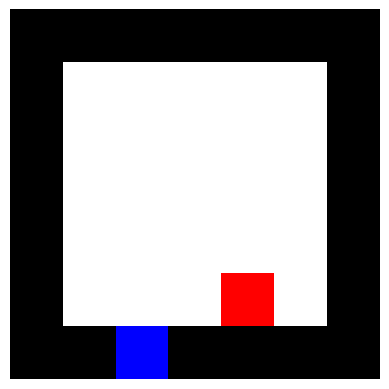

Episode: 3751935 
    Avg Iterations (last 4096 episodes): 10.92 
    Avg Score (last 4096): 3.3712 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.02112501508334629 
    Learning Rate: 0.1
    


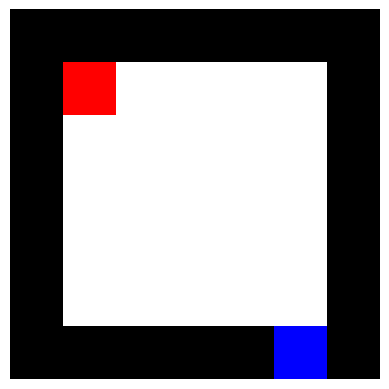

Episode: 3756031 
    Avg Iterations (last 4096 episodes): 11.05 
    Avg Score (last 4096): 3.5325 
    SnakeLength: 1.10546875 
    Eplsilon: 0.021038663946243357 
    Learning Rate: 0.1
    


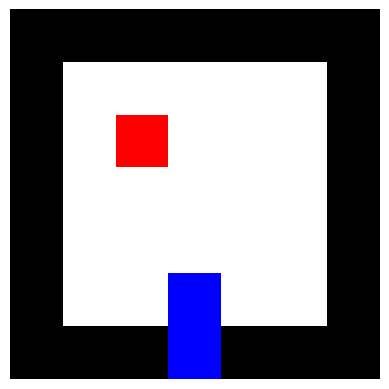

Episode: 3760127 
    Avg Iterations (last 4096 episodes): 9.82 
    Avg Score (last 4096): 3.0646 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.02095266578019612 
    Learning Rate: 0.1
    


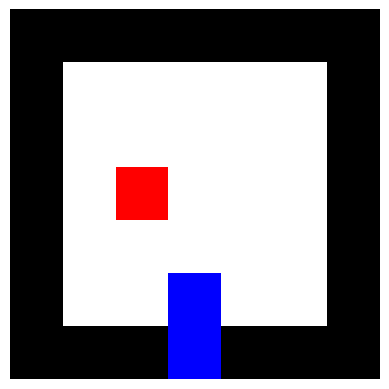

Episode: 3764223 
    Avg Iterations (last 4096 episodes): 10.01 
    Avg Score (last 4096): 3.0177 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.02086701914239151 
    Learning Rate: 0.1
    


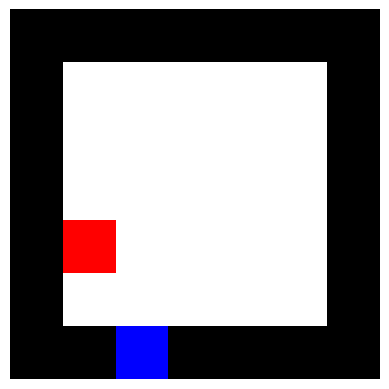

Episode: 3768319 
    Avg Iterations (last 4096 episodes): 11.16 
    Avg Score (last 4096): 3.5370 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.020781722595914 
    Learning Rate: 0.1
    


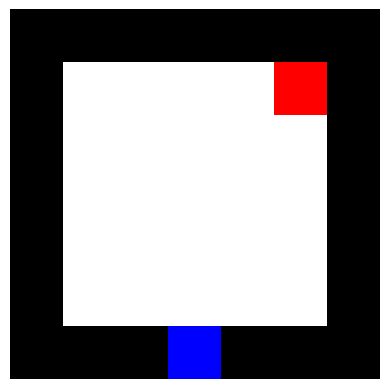

Episode: 3772415 
    Avg Iterations (last 4096 episodes): 11.05 
    Avg Score (last 4096): 3.5294 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.020696774709721383 
    Learning Rate: 0.1
    


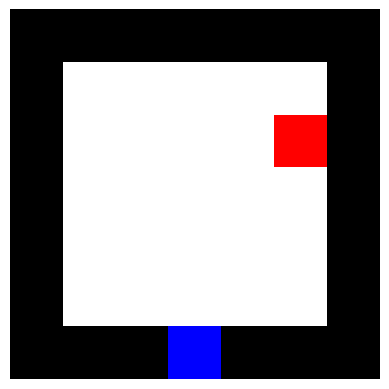

Episode: 3776511 
    Avg Iterations (last 4096 episodes): 10.53 
    Avg Score (last 4096): 3.4334 
    SnakeLength: 1.101806640625 
    Eplsilon: 0.02061217405862123 
    Learning Rate: 0.1
    


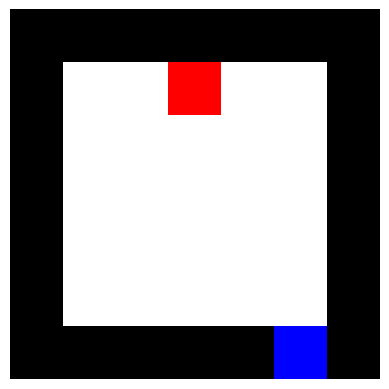

Episode: 3780607 
    Avg Iterations (last 4096 episodes): 10.78 
    Avg Score (last 4096): 3.3803 
    SnakeLength: 1.105712890625 
    Eplsilon: 0.02052791922324704 
    Learning Rate: 0.1
    


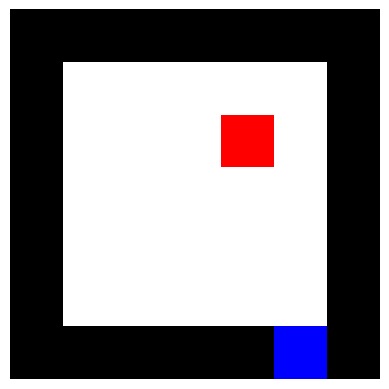

Episode: 3784703 
    Avg Iterations (last 4096 episodes): 11.83 
    Avg Score (last 4096): 3.7128 
    SnakeLength: 1.102294921875 
    Eplsilon: 0.020444008790033524 
    Learning Rate: 0.1
    


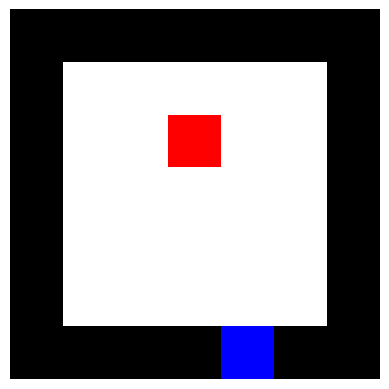

Episode: 3788799 
    Avg Iterations (last 4096 episodes): 11.35 
    Avg Score (last 4096): 3.6461 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.020360441351193845 
    Learning Rate: 0.1
    


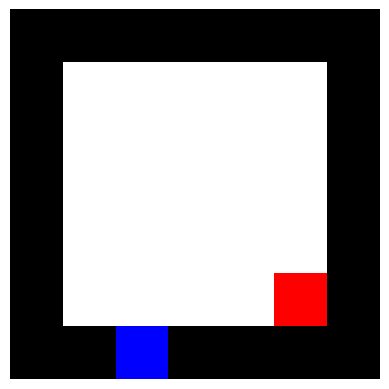

Episode: 3792895 
    Avg Iterations (last 4096 episodes): 11.45 
    Avg Score (last 4096): 3.6609 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.020277215504695974 
    Learning Rate: 0.1
    


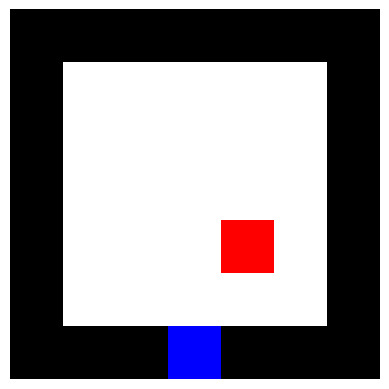

Episode: 3796991 
    Avg Iterations (last 4096 episodes): 10.28 
    Avg Score (last 4096): 3.1392 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.020194329854238323 
    Learning Rate: 0.1
    


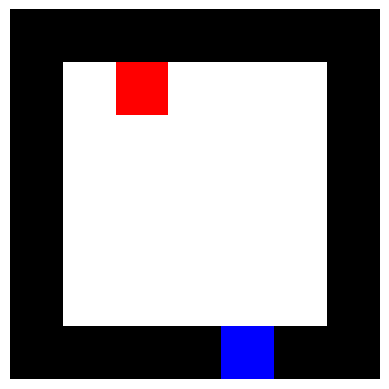

Episode: 3801087 
    Avg Iterations (last 4096 episodes): 12.62 
    Avg Score (last 4096): 4.3080 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.02011178300922703 
    Learning Rate: 0.1
    


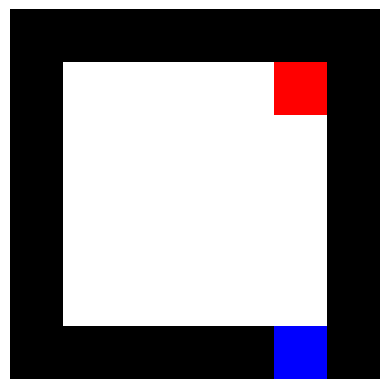

Episode: 3805183 
    Avg Iterations (last 4096 episodes): 11.02 
    Avg Score (last 4096): 3.5311 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.020029573584752564 
    Learning Rate: 0.1
    


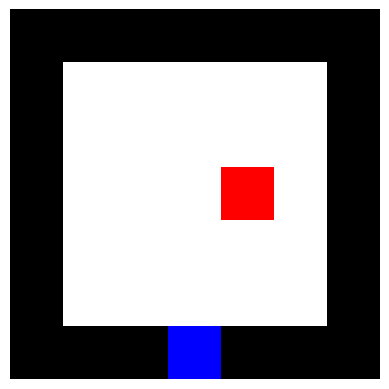

Episode: 3809279 
    Avg Iterations (last 4096 episodes): 10.98 
    Avg Score (last 4096): 3.7836 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.01994770020156648 
    Learning Rate: 0.1
    


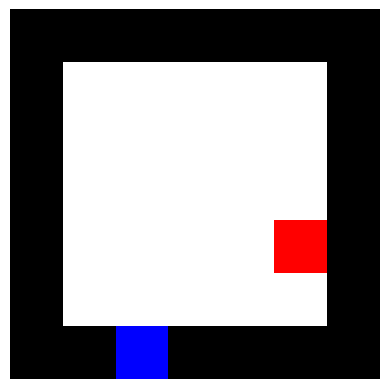

Episode: 3813375 
    Avg Iterations (last 4096 episodes): 11.64 
    Avg Score (last 4096): 3.8313 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.01986616148605788 
    Learning Rate: 0.1
    


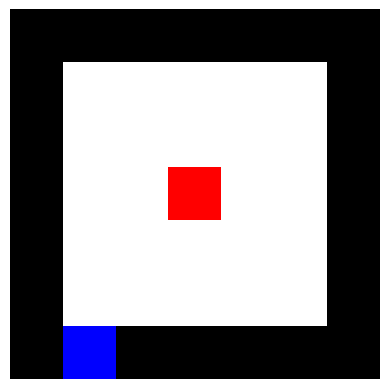

Episode: 3817471 
    Avg Iterations (last 4096 episodes): 11.31 
    Avg Score (last 4096): 3.6149 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.01978495607023095 
    Learning Rate: 0.1
    


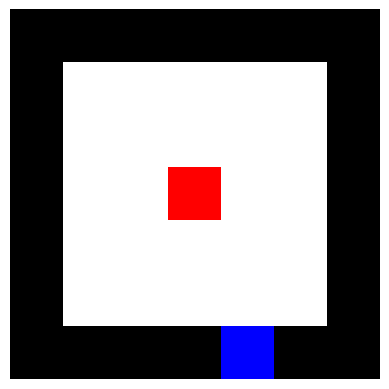

Episode: 3821567 
    Avg Iterations (last 4096 episodes): 12.47 
    Avg Score (last 4096): 4.2597 
    SnakeLength: 1.114990234375 
    Eplsilon: 0.019704082591681733 
    Learning Rate: 0.1
    


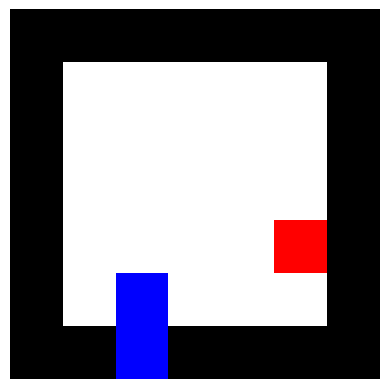

Episode: 3825663 
    Avg Iterations (last 4096 episodes): 12.30 
    Avg Score (last 4096): 3.9909 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.01962353969357498 
    Learning Rate: 0.1
    


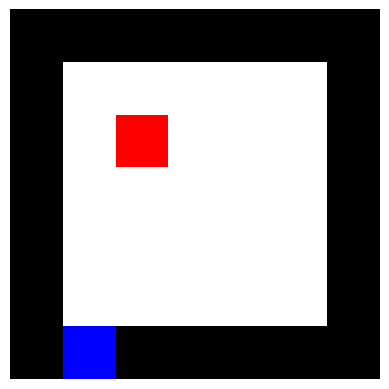

Episode: 3829759 
    Avg Iterations (last 4096 episodes): 10.62 
    Avg Score (last 4096): 3.3754 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.019543326024621836 
    Learning Rate: 0.1
    


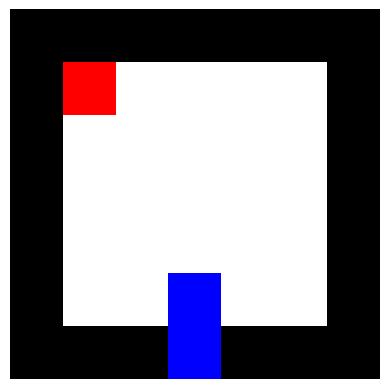

Episode: 3833855 
    Avg Iterations (last 4096 episodes): 11.37 
    Avg Score (last 4096): 3.8112 
    SnakeLength: 1.11279296875 
    Eplsilon: 0.01946344023905712 
    Learning Rate: 0.1
    


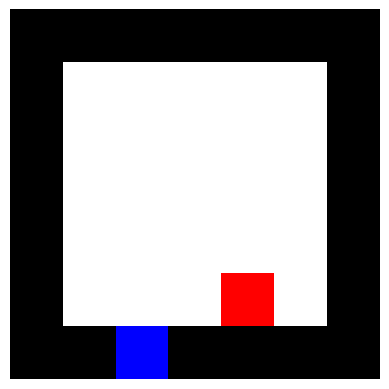

Episode: 3837951 
    Avg Iterations (last 4096 episodes): 11.99 
    Avg Score (last 4096): 3.7840 
    SnakeLength: 1.110595703125 
    Eplsilon: 0.019383880996616528 
    Learning Rate: 0.1
    


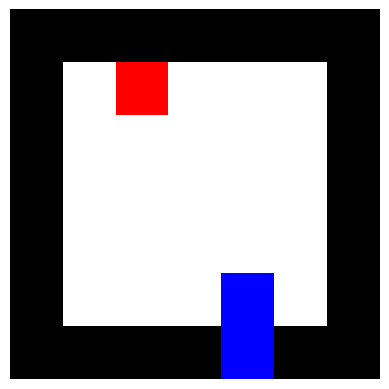

Episode: 3842047 
    Avg Iterations (last 4096 episodes): 11.24 
    Avg Score (last 4096): 3.4932 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.01930464696251418 
    Learning Rate: 0.1
    


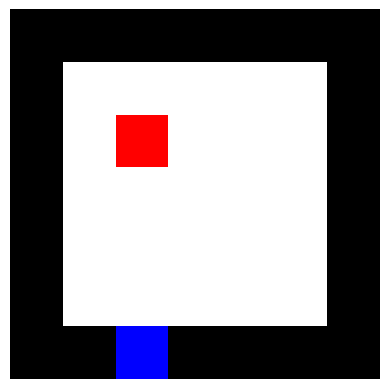

Episode: 3846143 
    Avg Iterations (last 4096 episodes): 11.24 
    Avg Score (last 4096): 3.6219 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.019225736807420384 
    Learning Rate: 0.1
    


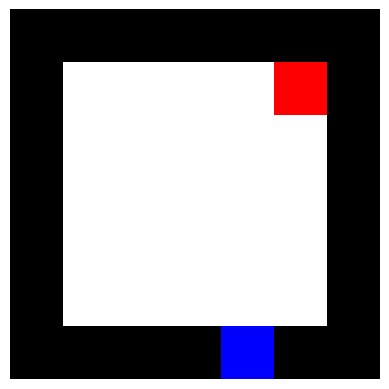

Episode: 3850239 
    Avg Iterations (last 4096 episodes): 12.71 
    Avg Score (last 4096): 4.1472 
    SnakeLength: 1.108154296875 
    Eplsilon: 0.019147149207439297 
    Learning Rate: 0.1
    


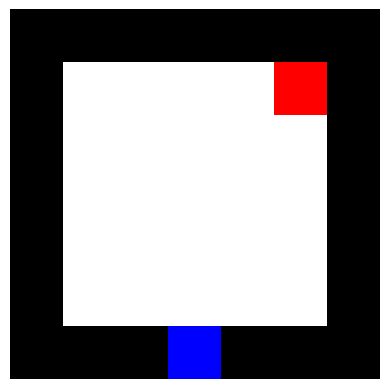

Episode: 3854335 
    Avg Iterations (last 4096 episodes): 11.54 
    Avg Score (last 4096): 3.6285 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.019068882844086723 
    Learning Rate: 0.1
    


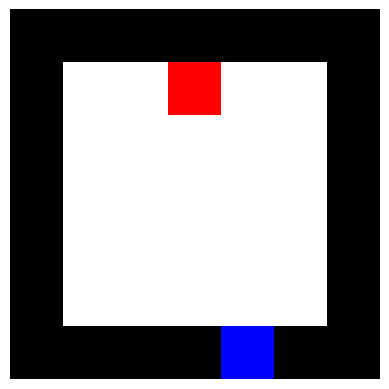

Episode: 3858431 
    Avg Iterations (last 4096 episodes): 12.78 
    Avg Score (last 4096): 4.4095 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.018990936404267637 
    Learning Rate: 0.1
    


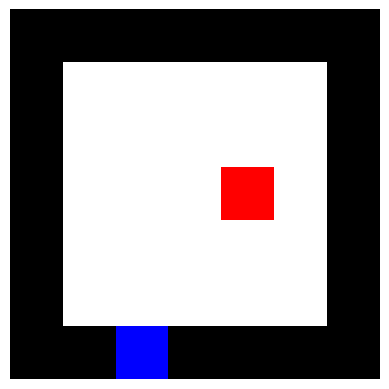

Episode: 3862527 
    Avg Iterations (last 4096 episodes): 11.74 
    Avg Score (last 4096): 3.7130 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.01891330858025475 
    Learning Rate: 0.1
    


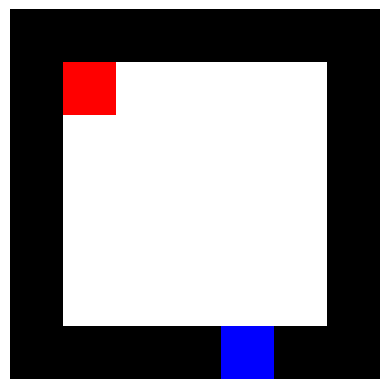

Episode: 3866623 
    Avg Iterations (last 4096 episodes): 12.40 
    Avg Score (last 4096): 3.9324 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.018835998069666154 
    Learning Rate: 0.1
    


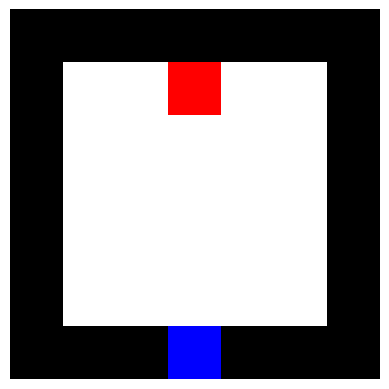

Episode: 3870719 
    Avg Iterations (last 4096 episodes): 11.65 
    Avg Score (last 4096): 3.8293 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.018759003575443627 
    Learning Rate: 0.1
    


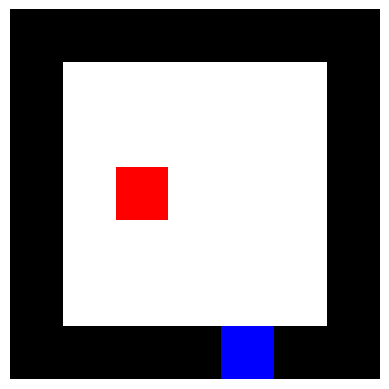

Episode: 3874815 
    Avg Iterations (last 4096 episodes): 11.54 
    Avg Score (last 4096): 3.8115 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.018682323805830816 
    Learning Rate: 0.1
    


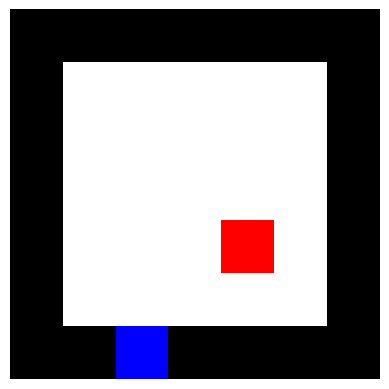

Episode: 3878911 
    Avg Iterations (last 4096 episodes): 12.13 
    Avg Score (last 4096): 4.0649 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.018605957474351596 
    Learning Rate: 0.1
    


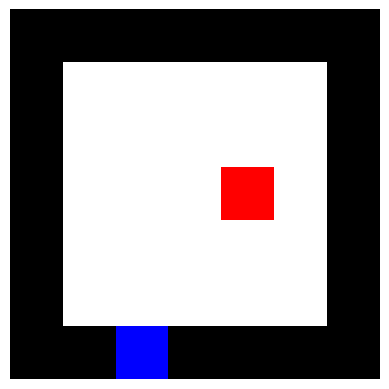

Episode: 3883007 
    Avg Iterations (last 4096 episodes): 11.69 
    Avg Score (last 4096): 3.7781 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.01852990329978827 
    Learning Rate: 0.1
    


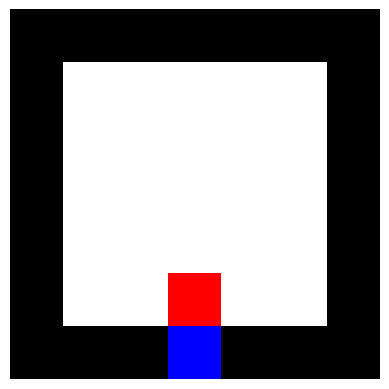

Episode: 3887103 
    Avg Iterations (last 4096 episodes): 11.32 
    Avg Score (last 4096): 3.6054 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.018454160006160656 
    Learning Rate: 0.1
    


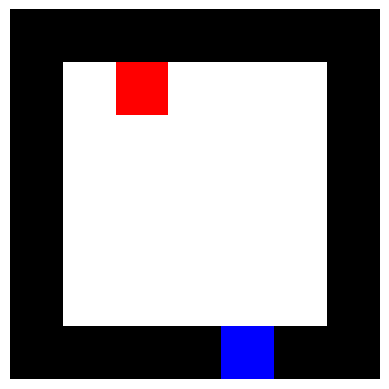

Episode: 3891199 
    Avg Iterations (last 4096 episodes): 11.47 
    Avg Score (last 4096): 3.5324 
    SnakeLength: 1.11181640625 
    Eplsilon: 0.018378726322704146 
    Learning Rate: 0.1
    


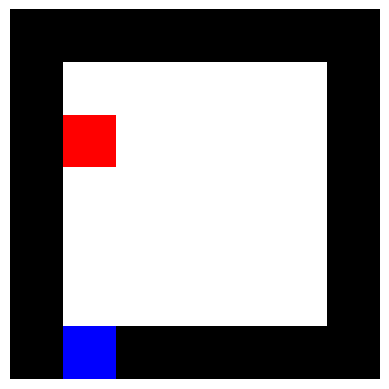

Episode: 3895295 
    Avg Iterations (last 4096 episodes): 12.35 
    Avg Score (last 4096): 4.1377 
    SnakeLength: 1.0986328125 
    Eplsilon: 0.01830360098384837 
    Learning Rate: 0.1
    


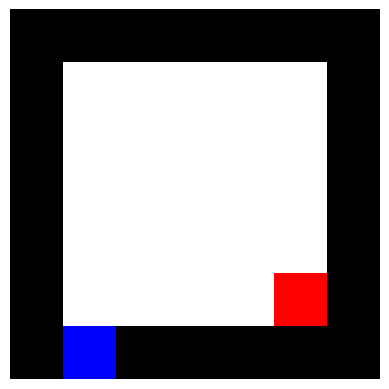

Episode: 3899391 
    Avg Iterations (last 4096 episodes): 12.81 
    Avg Score (last 4096): 4.2608 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.01822878272919634 
    Learning Rate: 0.1
    


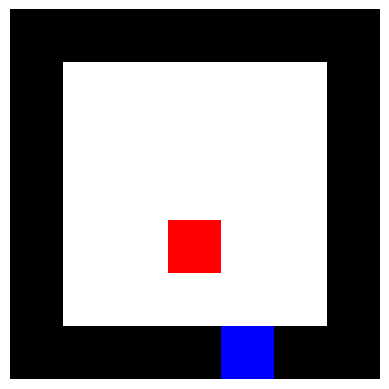

Episode: 3903487 
    Avg Iterations (last 4096 episodes): 11.60 
    Avg Score (last 4096): 3.7081 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.018154270303503015 
    Learning Rate: 0.1
    


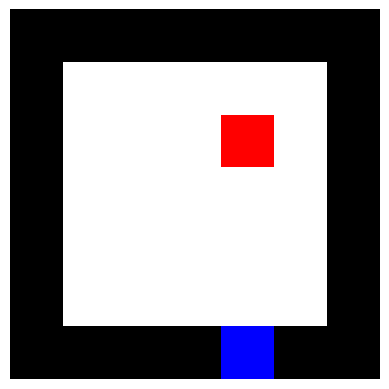

Episode: 3907583 
    Avg Iterations (last 4096 episodes): 11.28 
    Avg Score (last 4096): 3.4801 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.01808006245665424 
    Learning Rate: 0.1
    


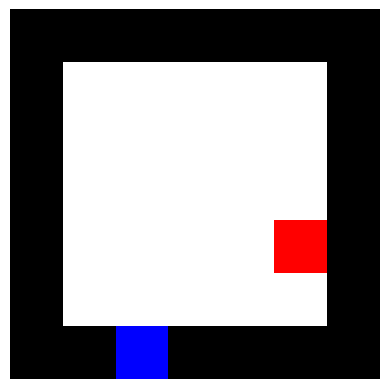

Episode: 3911679 
    Avg Iterations (last 4096 episodes): 11.21 
    Avg Score (last 4096): 3.5088 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.01800615794364602 
    Learning Rate: 0.1
    


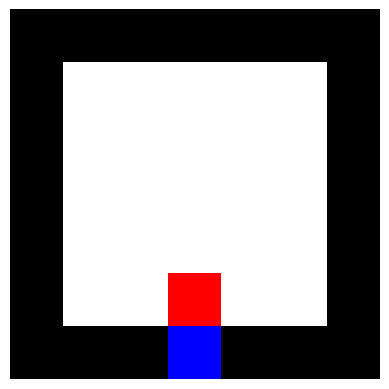

Episode: 3915775 
    Avg Iterations (last 4096 episodes): 13.78 
    Avg Score (last 4096): 4.6928 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.017932555524563472 
    Learning Rate: 0.1
    


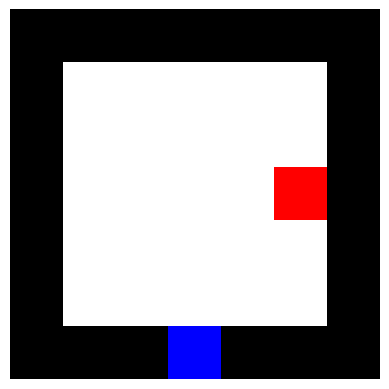

Episode: 3919871 
    Avg Iterations (last 4096 episodes): 12.67 
    Avg Score (last 4096): 4.2657 
    SnakeLength: 1.1142578125 
    Eplsilon: 0.017859253964559903 
    Learning Rate: 0.1
    


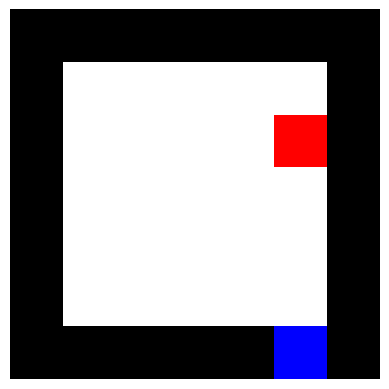

Episode: 3923967 
    Avg Iterations (last 4096 episodes): 11.97 
    Avg Score (last 4096): 3.8799 
    SnakeLength: 1.10986328125 
    Eplsilon: 0.017786252033836224 
    Learning Rate: 0.1
    


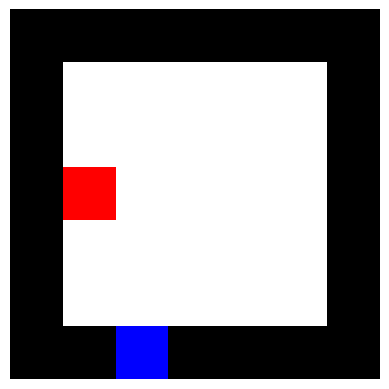

Episode: 3928063 
    Avg Iterations (last 4096 episodes): 11.64 
    Avg Score (last 4096): 3.7737 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.01771354850762033 
    Learning Rate: 0.1
    


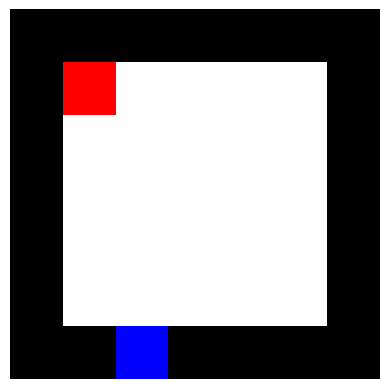

Episode: 3932159 
    Avg Iterations (last 4096 episodes): 11.45 
    Avg Score (last 4096): 3.5924 
    SnakeLength: 1.111572265625 
    Eplsilon: 0.01764114216614669 
    Learning Rate: 0.1
    


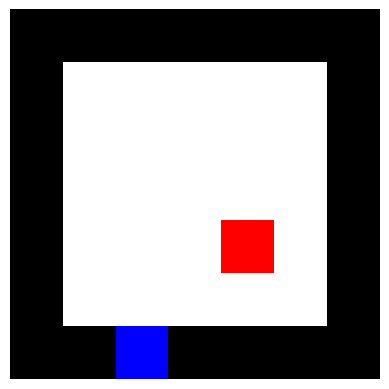

Episode: 3936255 
    Avg Iterations (last 4096 episodes): 12.71 
    Avg Score (last 4096): 4.0516 
    SnakeLength: 1.104736328125 
    Eplsilon: 0.01756903179463534 
    Learning Rate: 0.1
    


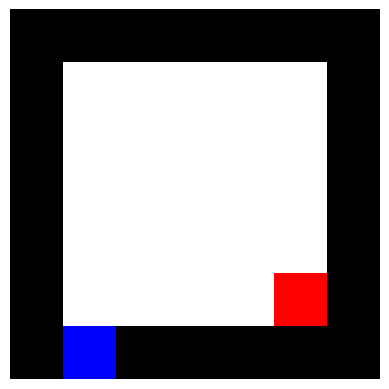

Episode: 3940351 
    Avg Iterations (last 4096 episodes): 12.42 
    Avg Score (last 4096): 4.0821 
    SnakeLength: 1.120361328125 
    Eplsilon: 0.01749721618327223 
    Learning Rate: 0.1
    


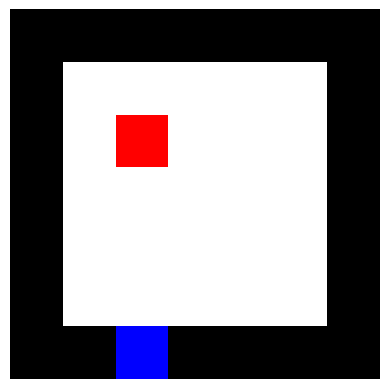

Episode: 3944447 
    Avg Iterations (last 4096 episodes): 12.64 
    Avg Score (last 4096): 4.2548 
    SnakeLength: 1.10595703125 
    Eplsilon: 0.01742569412718836 
    Learning Rate: 0.1
    


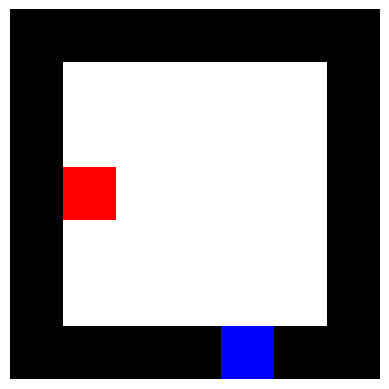

Episode: 3948543 
    Avg Iterations (last 4096 episodes): 12.05 
    Avg Score (last 4096): 3.9579 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.017354464426440046 
    Learning Rate: 0.1
    


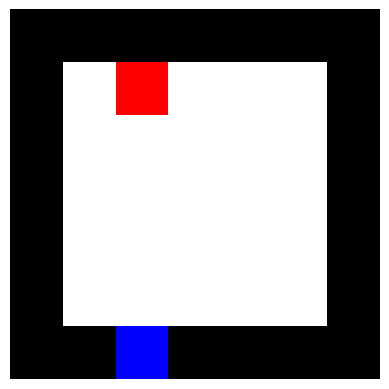

Episode: 3952639 
    Avg Iterations (last 4096 episodes): 13.01 
    Avg Score (last 4096): 4.2467 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.01728352588598819 
    Learning Rate: 0.1
    


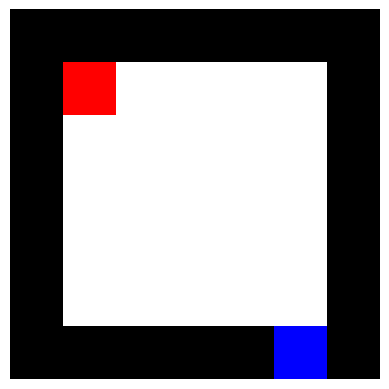

Episode: 3956735 
    Avg Iterations (last 4096 episodes): 12.43 
    Avg Score (last 4096): 4.2153 
    SnakeLength: 1.10888671875 
    Eplsilon: 0.017212877315678696 
    Learning Rate: 0.1
    


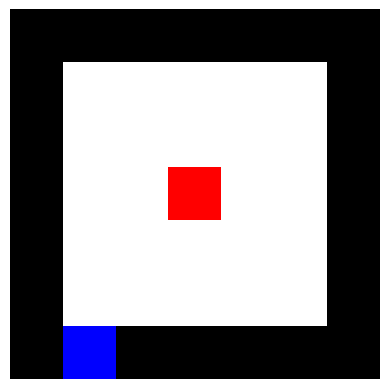

Episode: 3960831 
    Avg Iterations (last 4096 episodes): 12.99 
    Avg Score (last 4096): 4.2563 
    SnakeLength: 1.10693359375 
    Eplsilon: 0.017142517530222483 
    Learning Rate: 0.1
    


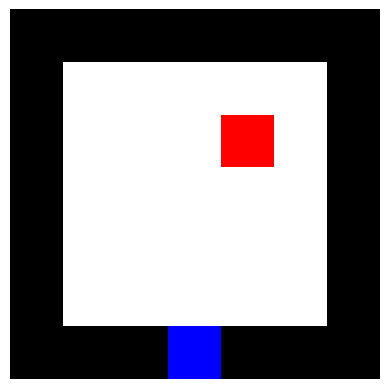

Episode: 3964927 
    Avg Iterations (last 4096 episodes): 12.45 
    Avg Score (last 4096): 4.0309 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.017072445349175316 
    Learning Rate: 0.1
    


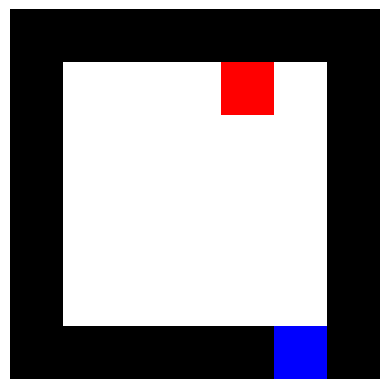

Episode: 3969023 
    Avg Iterations (last 4096 episodes): 12.70 
    Avg Score (last 4096): 4.2661 
    SnakeLength: 1.1103515625 
    Eplsilon: 0.017002659596918428 
    Learning Rate: 0.1
    


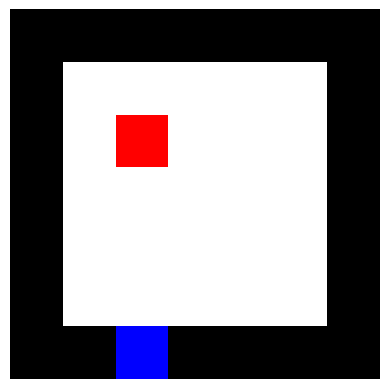

Episode: 3973119 
    Avg Iterations (last 4096 episodes): 12.67 
    Avg Score (last 4096): 4.2020 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.01693315910263827 
    Learning Rate: 0.1
    


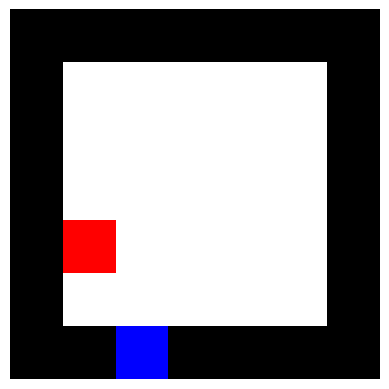

Episode: 3977215 
    Avg Iterations (last 4096 episodes): 12.04 
    Avg Score (last 4096): 4.1167 
    SnakeLength: 1.117919921875 
    Eplsilon: 0.016863942700307333 
    Learning Rate: 0.1
    


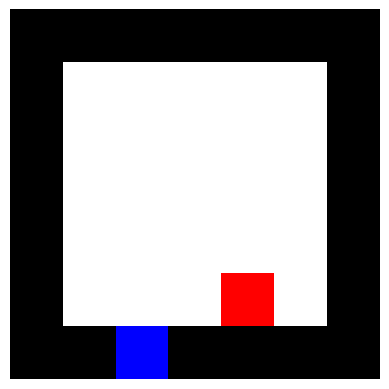

Episode: 3981311 
    Avg Iterations (last 4096 episodes): 12.58 
    Avg Score (last 4096): 4.2232 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.01679500922866423 
    Learning Rate: 0.1
    


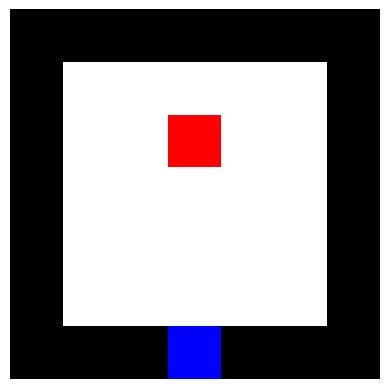

Episode: 3985407 
    Avg Iterations (last 4096 episodes): 12.77 
    Avg Score (last 4096): 4.3949 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.01672635753119416 
    Learning Rate: 0.1
    


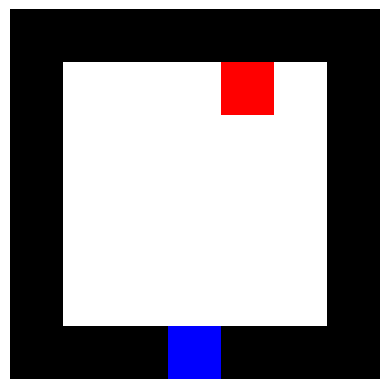

Episode: 3989503 
    Avg Iterations (last 4096 episodes): 12.54 
    Avg Score (last 4096): 4.3355 
    SnakeLength: 1.118896484375 
    Eplsilon: 0.016657986456110243 
    Learning Rate: 0.1
    


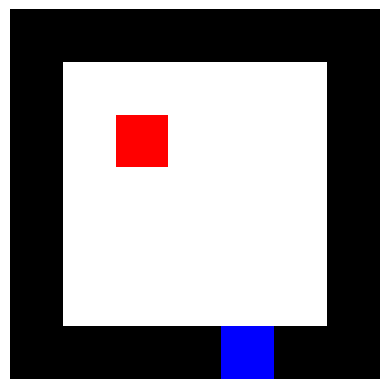

Episode: 3993599 
    Avg Iterations (last 4096 episodes): 14.28 
    Avg Score (last 4096): 4.9657 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.01658989485633356 
    Learning Rate: 0.1
    


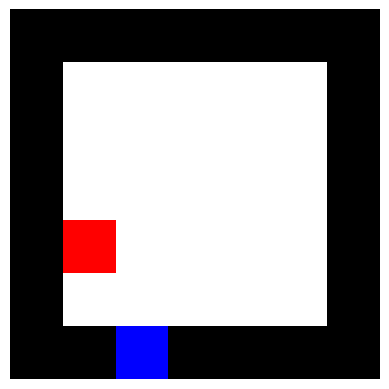

Episode: 3997695 
    Avg Iterations (last 4096 episodes): 13.02 
    Avg Score (last 4096): 4.5223 
    SnakeLength: 1.118408203125 
    Eplsilon: 0.016522081589473832 
    Learning Rate: 0.1
    


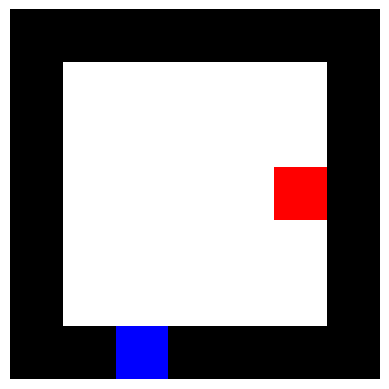

Episode: 4001791 
    Avg Iterations (last 4096 episodes): 12.41 
    Avg Score (last 4096): 4.2911 
    SnakeLength: 1.109375 
    Eplsilon: 0.016454545517810445 
    Learning Rate: 0.1
    


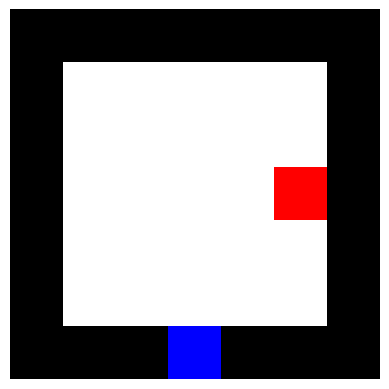

Episode: 4005887 
    Avg Iterations (last 4096 episodes): 14.43 
    Avg Score (last 4096): 5.3590 
    SnakeLength: 1.11962890625 
    Eplsilon: 0.016387285508273473 
    Learning Rate: 0.1
    


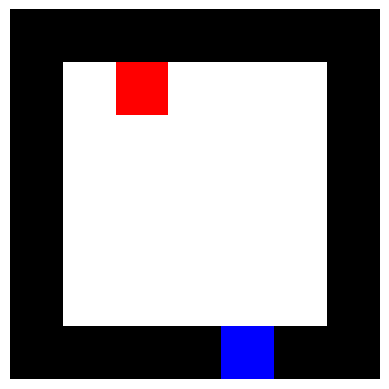

Episode: 4009983 
    Avg Iterations (last 4096 episodes): 13.01 
    Avg Score (last 4096): 4.4628 
    SnakeLength: 1.100341796875 
    Eplsilon: 0.01632030043242435 
    Learning Rate: 0.1
    


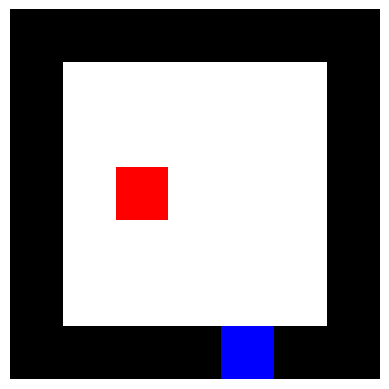

Episode: 4014079 
    Avg Iterations (last 4096 episodes): 15.03 
    Avg Score (last 4096): 5.3775 
    SnakeLength: 1.114013671875 
    Eplsilon: 0.016253589166437456 
    Learning Rate: 0.1
    


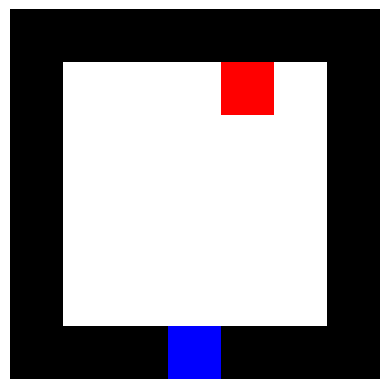

Episode: 4018175 
    Avg Iterations (last 4096 episodes): 13.71 
    Avg Score (last 4096): 4.6206 
    SnakeLength: 1.101806640625 
    Eplsilon: 0.016187150591080786 
    Learning Rate: 0.1
    


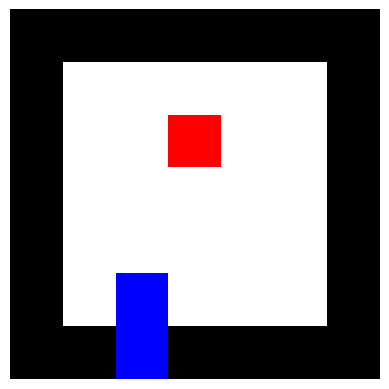

Episode: 4022271 
    Avg Iterations (last 4096 episodes): 13.56 
    Avg Score (last 4096): 4.5843 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.01612098359169726 
    Learning Rate: 0.1
    


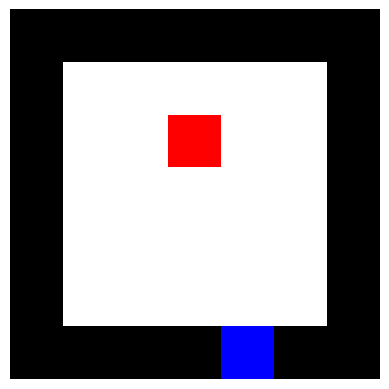

Episode: 4026367 
    Avg Iterations (last 4096 episodes): 13.27 
    Avg Score (last 4096): 4.6727 
    SnakeLength: 1.1083984375 
    Eplsilon: 0.016055087058186226 
    Learning Rate: 0.1
    


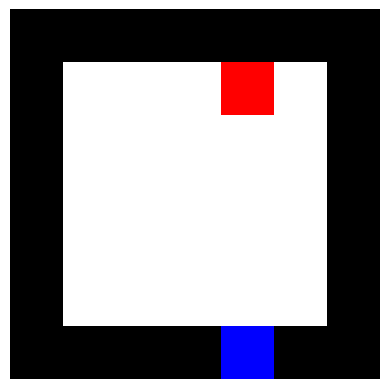

Episode: 4030463 
    Avg Iterations (last 4096 episodes): 13.96 
    Avg Score (last 4096): 4.8839 
    SnakeLength: 1.109130859375 
    Eplsilon: 0.015989459884984524 
    Learning Rate: 0.1
    


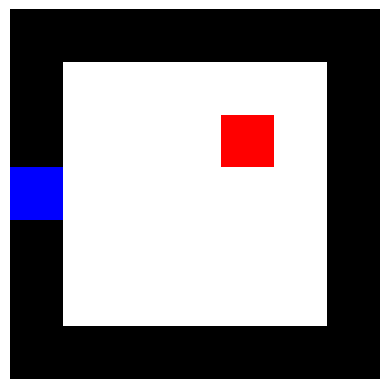

Episode: 4034559 
    Avg Iterations (last 4096 episodes): 14.60 
    Avg Score (last 4096): 5.0889 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.015924100971048516 
    Learning Rate: 0.1
    


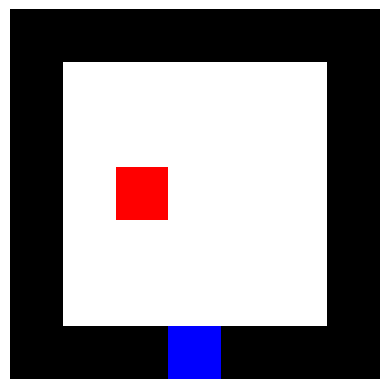

Episode: 4038655 
    Avg Iterations (last 4096 episodes): 14.09 
    Avg Score (last 4096): 4.7583 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.015859009219834665 
    Learning Rate: 0.1
    


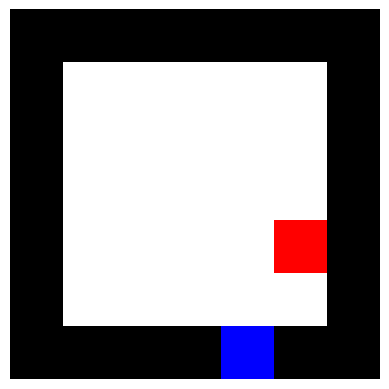

Episode: 4042751 
    Avg Iterations (last 4096 episodes): 12.61 
    Avg Score (last 4096): 4.1999 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.01579418353928208 
    Learning Rate: 0.1
    


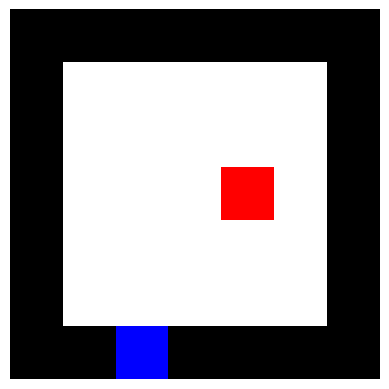

Episode: 4046847 
    Avg Iterations (last 4096 episodes): 13.60 
    Avg Score (last 4096): 4.4062 
    SnakeLength: 1.11572265625 
    Eplsilon: 0.015729622841793845 
    Learning Rate: 0.1
    


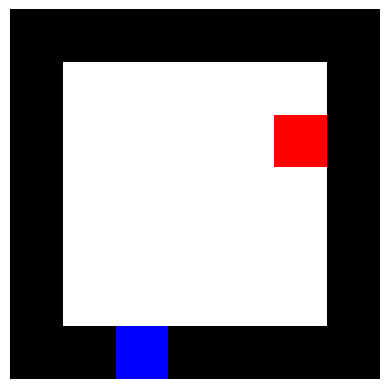

Episode: 4050943 
    Avg Iterations (last 4096 episodes): 15.35 
    Avg Score (last 4096): 5.4358 
    SnakeLength: 1.105224609375 
    Eplsilon: 0.015665326044218567 
    Learning Rate: 0.1
    


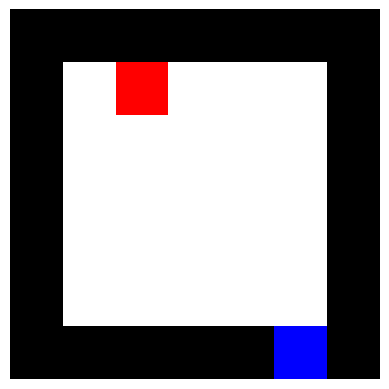

Episode: 4055039 
    Avg Iterations (last 4096 episodes): 13.55 
    Avg Score (last 4096): 4.6271 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.015601292067832322 
    Learning Rate: 0.1
    


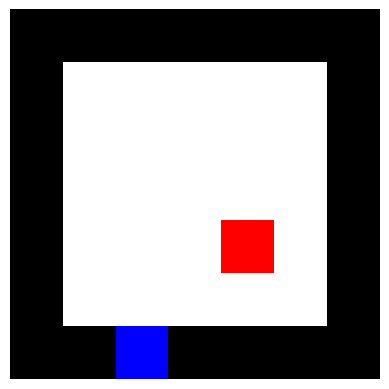

Episode: 4059135 
    Avg Iterations (last 4096 episodes): 14.18 
    Avg Score (last 4096): 4.8045 
    SnakeLength: 1.09765625 
    Eplsilon: 0.015537519838320654 
    Learning Rate: 0.1
    


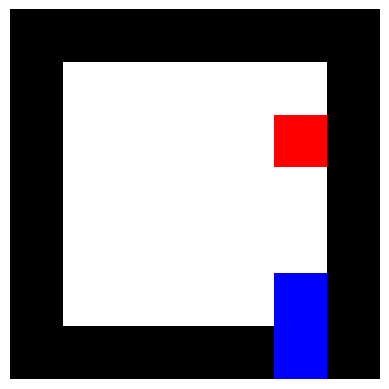

Episode: 4063231 
    Avg Iterations (last 4096 episodes): 14.18 
    Avg Score (last 4096): 4.9076 
    SnakeLength: 1.109619140625 
    Eplsilon: 0.015474008285760501 
    Learning Rate: 0.1
    


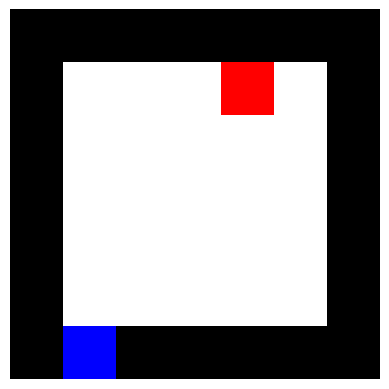

Episode: 4067327 
    Avg Iterations (last 4096 episodes): 14.26 
    Avg Score (last 4096): 5.0373 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.015410756344602424 
    Learning Rate: 0.1
    


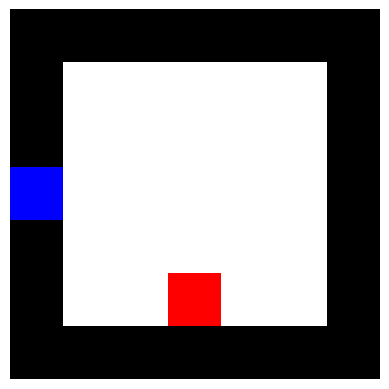

Episode: 4071423 
    Avg Iterations (last 4096 episodes): 14.31 
    Avg Score (last 4096): 4.9120 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.015347762953652212 
    Learning Rate: 0.1
    


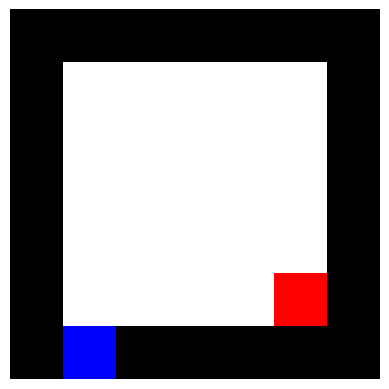

Episode: 4075519 
    Avg Iterations (last 4096 episodes): 13.30 
    Avg Score (last 4096): 4.5604 
    SnakeLength: 1.107666015625 
    Eplsilon: 0.015285027056053755 
    Learning Rate: 0.1
    


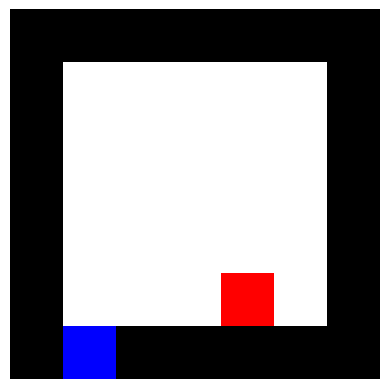

Episode: 4079615 
    Avg Iterations (last 4096 episodes): 13.50 
    Avg Score (last 4096): 4.5174 
    SnakeLength: 1.103759765625 
    Eplsilon: 0.015222547599270761 
    Learning Rate: 0.1
    


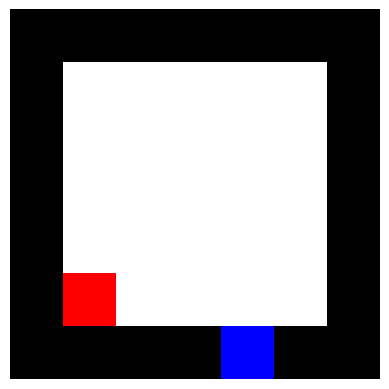

Episode: 4083711 
    Avg Iterations (last 4096 episodes): 14.23 
    Avg Score (last 4096): 5.0497 
    SnakeLength: 1.111083984375 
    Eplsilon: 0.015160323535069357 
    Learning Rate: 0.1
    


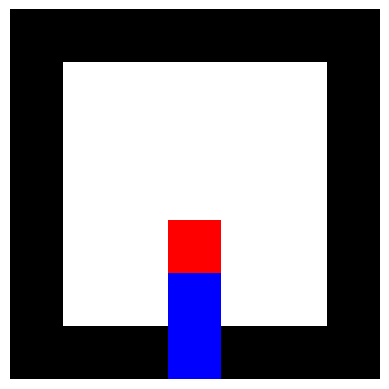

Episode: 4087807 
    Avg Iterations (last 4096 episodes): 12.38 
    Avg Score (last 4096): 3.9748 
    SnakeLength: 1.110107421875 
    Eplsilon: 0.015098353819500539 
    Learning Rate: 0.1
    


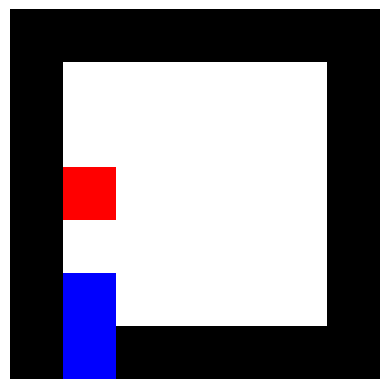

Episode: 4091903 
    Avg Iterations (last 4096 episodes): 15.44 
    Avg Score (last 4096): 5.2644 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.015036637412882468 
    Learning Rate: 0.1
    


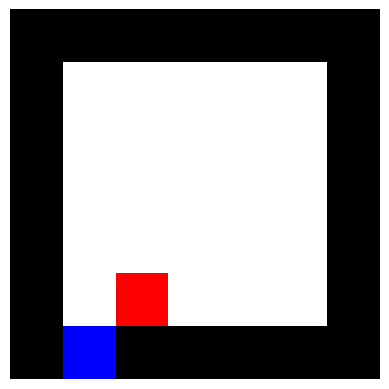

Episode: 4095999 
    Avg Iterations (last 4096 episodes): 14.28 
    Avg Score (last 4096): 5.1442 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.014975173279783168 
    Learning Rate: 0.1
    


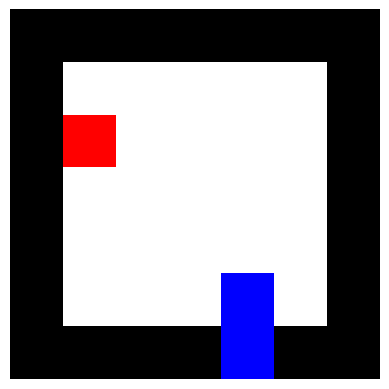

Episode: 4100095 
    Avg Iterations (last 4096 episodes): 12.91 
    Avg Score (last 4096): 4.4714 
    SnakeLength: 1.115478515625 
    Eplsilon: 0.014913960389003125 
    Learning Rate: 0.1
    


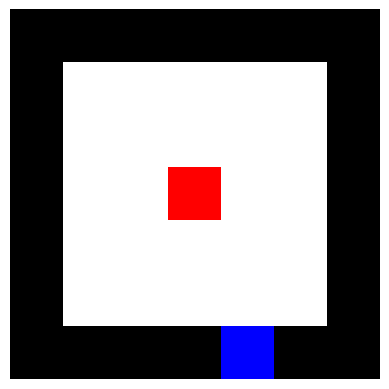

Episode: 4104191 
    Avg Iterations (last 4096 episodes): 15.14 
    Avg Score (last 4096): 5.2972 
    SnakeLength: 1.1005859375 
    Eplsilon: 0.014852997713557982 
    Learning Rate: 0.1
    


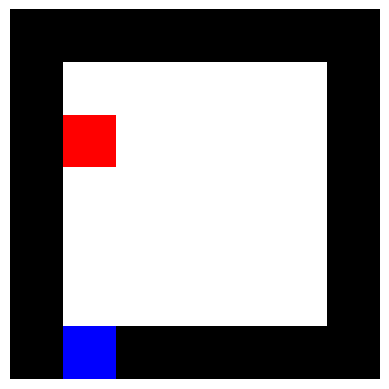

Episode: 4108287 
    Avg Iterations (last 4096 episodes): 12.28 
    Avg Score (last 4096): 4.0894 
    SnakeLength: 1.116455078125 
    Eplsilon: 0.014792284230661333 
    Learning Rate: 0.1
    


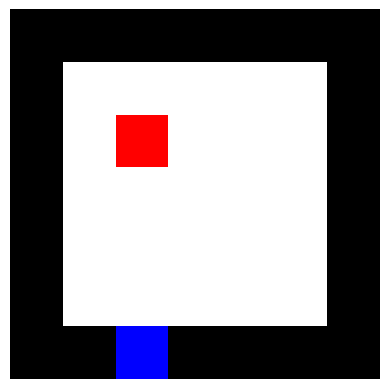

Episode: 4112383 
    Avg Iterations (last 4096 episodes): 15.17 
    Avg Score (last 4096): 5.3277 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.014731818921707536 
    Learning Rate: 0.1
    


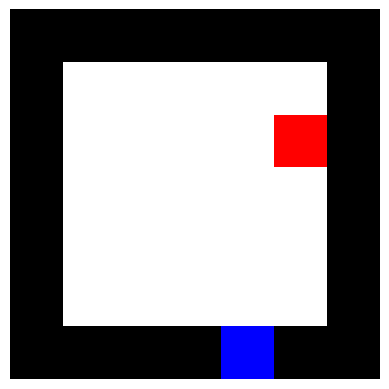

Episode: 4116479 
    Avg Iterations (last 4096 episodes): 13.29 
    Avg Score (last 4096): 4.6165 
    SnakeLength: 1.112548828125 
    Eplsilon: 0.014671600772254626 
    Learning Rate: 0.1
    


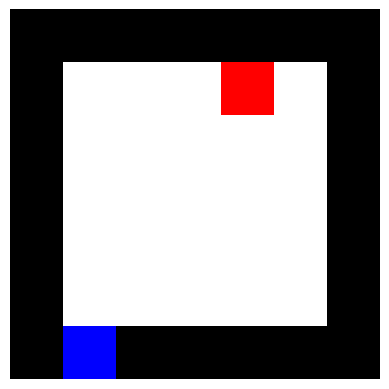

Episode: 4120575 
    Avg Iterations (last 4096 episodes): 13.66 
    Avg Score (last 4096): 4.6926 
    SnakeLength: 1.105224609375 
    Eplsilon: 0.014611628772007204 
    Learning Rate: 0.1
    


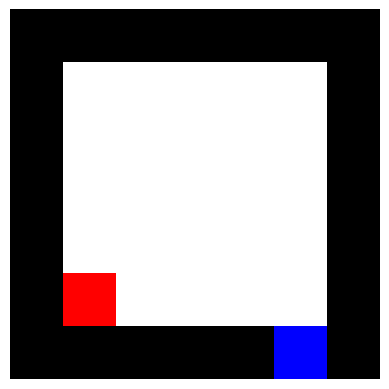

Episode: 4124671 
    Avg Iterations (last 4096 episodes): 12.83 
    Avg Score (last 4096): 4.3444 
    SnakeLength: 1.119140625 
    Eplsilon: 0.014551901914799678 
    Learning Rate: 0.1
    


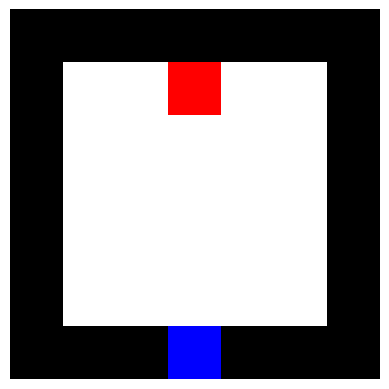

Episode: 4128767 
    Avg Iterations (last 4096 episodes): 15.33 
    Avg Score (last 4096): 5.4084 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.014492419198579317 
    Learning Rate: 0.1
    


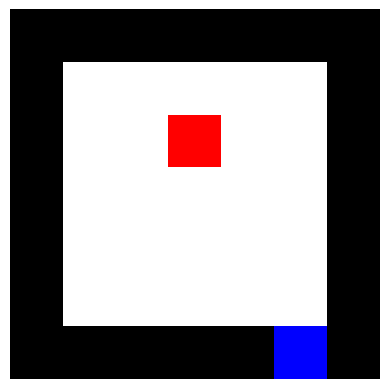

Episode: 4132863 
    Avg Iterations (last 4096 episodes): 15.04 
    Avg Score (last 4096): 5.3027 
    SnakeLength: 1.121337890625 
    Eplsilon: 0.014433179625389304 
    Learning Rate: 0.1
    


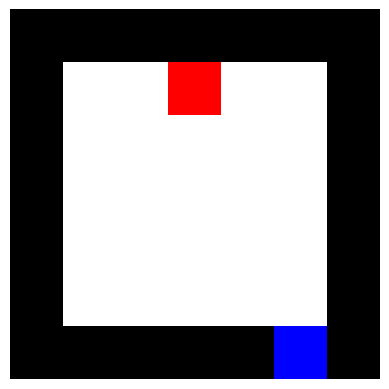

Episode: 4136959 
    Avg Iterations (last 4096 episodes): 13.77 
    Avg Score (last 4096): 4.4808 
    SnakeLength: 1.0986328125 
    Eplsilon: 0.014374182201352111 
    Learning Rate: 0.1
    


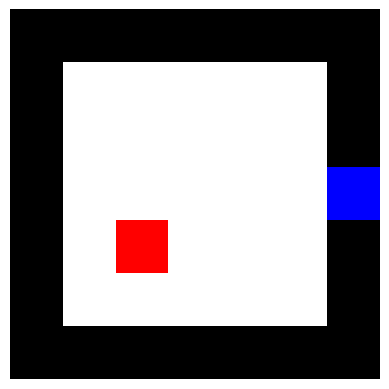

Episode: 4141055 
    Avg Iterations (last 4096 episodes): 14.16 
    Avg Score (last 4096): 4.6245 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.014315425936652974 
    Learning Rate: 0.1
    


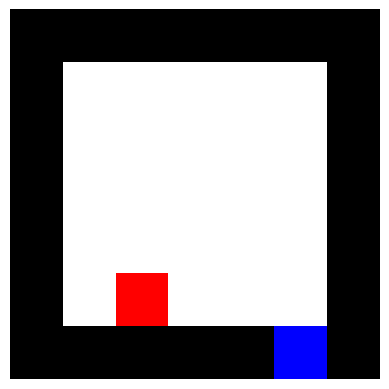

Episode: 4145151 
    Avg Iterations (last 4096 episodes): 14.10 
    Avg Score (last 4096): 4.7986 
    SnakeLength: 1.109375 
    Eplsilon: 0.01425690984552281 
    Learning Rate: 0.1
    


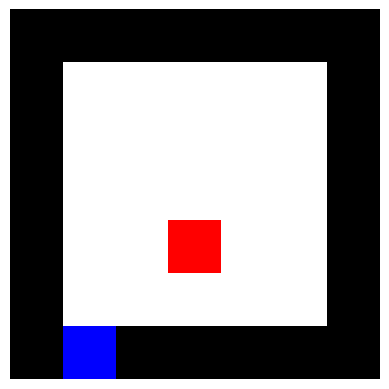

Episode: 4149247 
    Avg Iterations (last 4096 episodes): 13.79 
    Avg Score (last 4096): 4.7955 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.014198632946222232 
    Learning Rate: 0.1
    


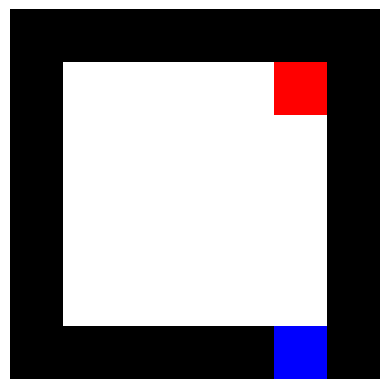

Episode: 4153343 
    Avg Iterations (last 4096 episodes): 15.41 
    Avg Score (last 4096): 5.3024 
    SnakeLength: 1.1064453125 
    Eplsilon: 0.01414059426102475 
    Learning Rate: 0.1
    


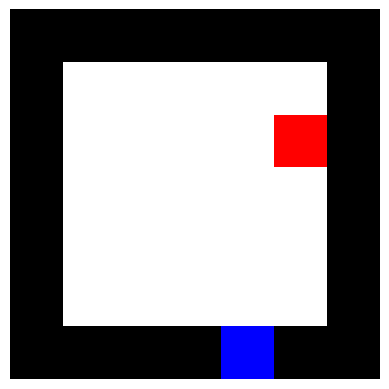

Episode: 4157439 
    Avg Iterations (last 4096 episodes): 15.23 
    Avg Score (last 4096): 5.4181 
    SnakeLength: 1.113525390625 
    Eplsilon: 0.014082792816200495 
    Learning Rate: 0.1
    


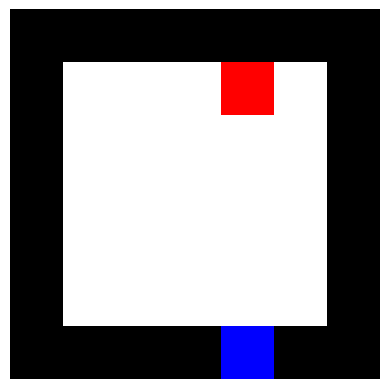

Episode: 4161535 
    Avg Iterations (last 4096 episodes): 15.35 
    Avg Score (last 4096): 5.4328 
    SnakeLength: 1.10791015625 
    Eplsilon: 0.0140252276419998 
    Learning Rate: 0.1
    


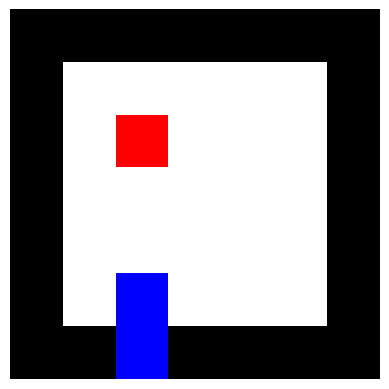

Episode: 4165631 
    Avg Iterations (last 4096 episodes): 15.57 
    Avg Score (last 4096): 5.5181 
    SnakeLength: 1.11376953125 
    Eplsilon: 0.013967897772637088 
    Learning Rate: 0.1
    


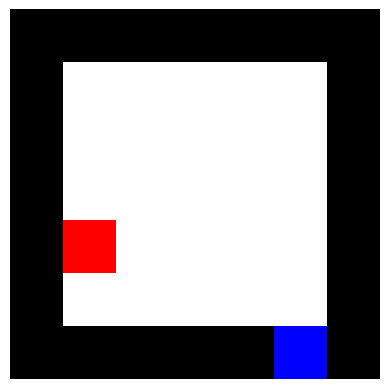

Episode: 4169727 
    Avg Iterations (last 4096 episodes): 15.48 
    Avg Score (last 4096): 5.4692 
    SnakeLength: 1.112060546875 
    Eplsilon: 0.0139108022462743 
    Learning Rate: 0.1
    


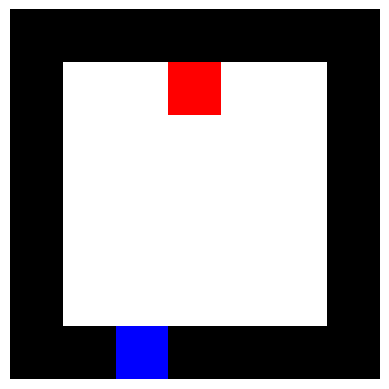

Episode: 4173823 
    Avg Iterations (last 4096 episodes): 15.05 
    Avg Score (last 4096): 5.2712 
    SnakeLength: 1.1123046875 
    Eplsilon: 0.013853940105005244 
    Learning Rate: 0.1
    


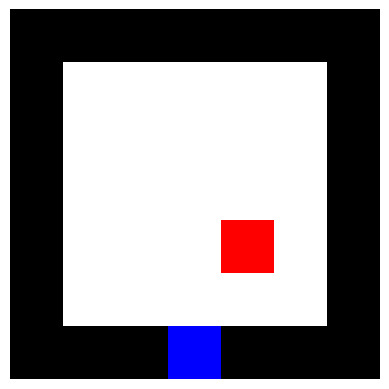

Episode: 4177919 
    Avg Iterations (last 4096 episodes): 14.00 
    Avg Score (last 4096): 4.7173 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.013797310394839129 
    Learning Rate: 0.1
    


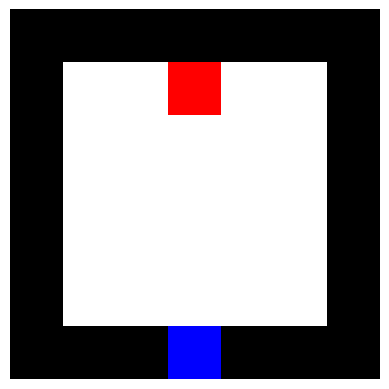

Episode: 4182015 
    Avg Iterations (last 4096 episodes): 14.78 
    Avg Score (last 4096): 5.0820 
    SnakeLength: 1.093017578125 
    Eplsilon: 0.01374091216568489 
    Learning Rate: 0.1
    


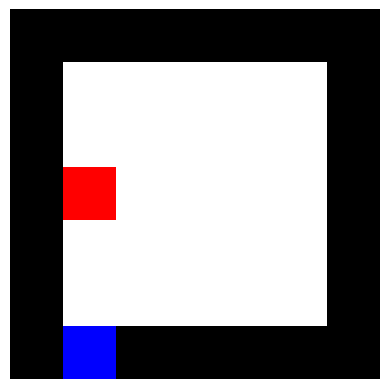

Episode: 4186111 
    Avg Iterations (last 4096 episodes): 16.02 
    Avg Score (last 4096): 5.8019 
    SnakeLength: 1.11474609375 
    Eplsilon: 0.013684744471335018 
    Learning Rate: 0.1
    


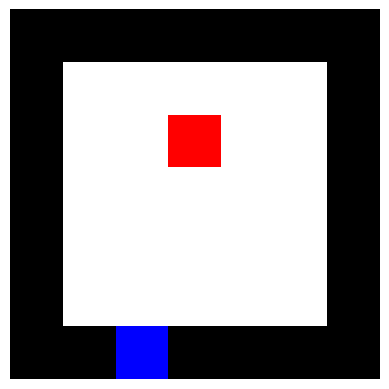

Episode: 4190207 
    Avg Iterations (last 4096 episodes): 14.33 
    Avg Score (last 4096): 5.1902 
    SnakeLength: 1.108642578125 
    Eplsilon: 0.013628806369449539 
    Learning Rate: 0.1
    


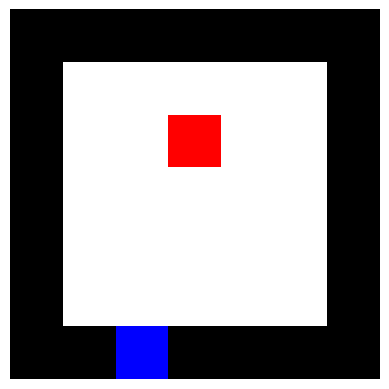

Episode: 4194303 
    Avg Iterations (last 4096 episodes): 14.86 
    Avg Score (last 4096): 5.0549 
    SnakeLength: 1.10498046875 
    Eplsilon: 0.013573096921540724 
    Learning Rate: 0.1
    


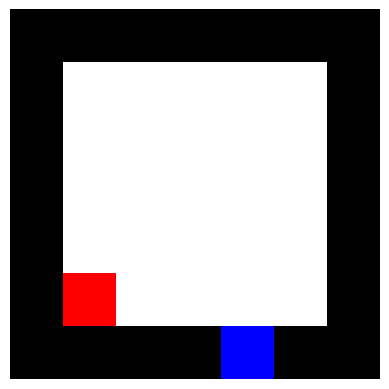

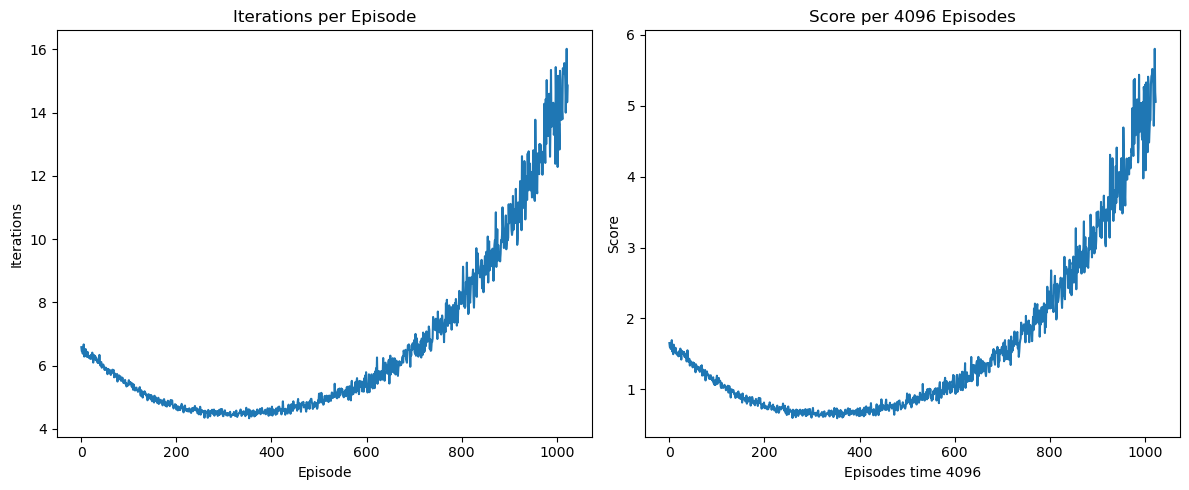

In [12]:
action_mapping = {0: Direction.UP, 1: Direction.DOWN, 2: Direction.LEFT, 3: Direction.RIGHT}
for episode in range(EPISODES):
    iteration_count = 0
    set_seed(SEED + episode)
    starting_head_location = random.choice(list(EMPTY_GRID_SET))
    starting_apple_location = random.choice(list(EMPTY_GRID_SET - set(starting_head_location)))
    done, snake_queue, apple_location, score = initialize_game(starting_head_location, starting_apple_location)
    state = encode_state(snake_queue, apple_location, score)
    while not done:
        action_index = agent.get_action(state)
        done, snake_queue, apple_location, score = update_state(snake_queue, apple_location, action_mapping[action_index], score)
        state = encode_state(snake_queue, apple_location, score)
        agent.buffer.push(state, action_index, score, state, done)
        agent.update()
        iteration_count += 1
   
    moving_avg_iterations.append(iteration_count)
    moving_avg_scores.append(score)
    moving_avg_length.append(len(snake_queue))
    
    if ((episode + 1) % PRINT_FREQUENCY == 0):
        eps = agent.get_epsilon()
        lr = agent.get_lr()
        avg_iterations, avg_score = my_plot_fn(moving_avg_iterations, moving_avg_scores, moving_avg_length, eps, lr, episode, state)
        iterations_plot_list.append(avg_iterations)
        scores_plot_list.append(avg_score)
    agent.decay_epsilon()
    if episode % SYNC_FREQUENCY == 0: # Sync every so many episodes
        agent.sync_target()

plot_series(iterations_plot_list, scores_plot_list)

Absolutely! Systematic hyperparameter tuning and debugging is crucial in reinforcement learning to ensure efficient learning. Let's outline a structured approach:

1. Baseline and Simplification:
Start with a simpler version of the problem. Perhaps a smaller grid or an environment where the apple is always in the same place.
Make the network as simple as possible. Once you see it learning, gradually increase its complexity.
2. Diagnosis:
Visualizations: Visualize the agent's decisions over time. Is it exploring enough? Is it getting stuck in a loop?
Reward Analysis: Print the rewards obtained during each step. Is the agent getting the expected rewards for its actions?
Gradient Checks: Monitor the magnitude of the gradients. If they're too small, you might be dealing with vanishing gradients; if they're too large, exploding gradients.
Q-value Analysis: Plot the Q-values over time. Are they diverging or converging? Are they increasing for the correct actions and decreasing for the incorrect ones?
Action Distribution: Check the distribution of actions taken by the agent. Is it too biased towards one action? This can indicate that the agent has found a loophole in the reward system or isn't exploring enough.
3. Hyperparameter Tuning:
Grid Search: Start with broader ranges for hyperparameters like learning rate, epsilon decay, etc., and then narrow down.
Random Search: Sometimes better than grid search, as it can explore the hyperparameter space more diversely.
Bayesian Optimization: Tools like Optuna, Hyperopt, or frameworks like Ray Tune can be very efficient for hyperparameter tuning in RL.
4. Incremental Changes:
Change one thing at a time and observe its impact. If you adjust multiple things and something goes wrong (or right), you won't know what caused it.
5. Check Environment Dynamics:
Ensure there are no bugs in the environment itself, as these can majorly affect learning.
6. Reproducibility:
Start with established, reproducible baselines or reference implementations. If a well-known algorithm doesn't work in your environment, it's a strong signal that something might be off.
7. Alternative Approaches:
Curriculum Learning: Start with easier tasks and gradually move to complex ones.
Reward Shaping: Sometimes, a more frequent, intermediate reward can guide the agent better than a sparse reward.
Transfer Learning: If you have a model trained on a similar task, you can fine-tune it on your current task.
8. Review Model Architecture:
Ensure that the architecture is suitable for the task. Sometimes a simple feed-forward network might not suffice, and you might need recurrent layers or other architectures.
Check the initialization methods for your neural network layers.
9. Regular Monitoring and Logging:
Tools like TensorBoard or Weights & Biases can be invaluable. Log scalars like loss, average reward, epsilon, and more complex data like histograms of network weights, Q-values, or even images of the game state.
Remember, in RL, especially in environments with high variance, it's often valuable to run multiple seeds (starting points) and average the results to ensure the changes you're observing aren't just due to randomness.


Your model's performance seems to be fluctuating with a limited increase in average score and snake length over the episodes. Let's troubleshoot:

Learning Rate and Decay: Your learning rate LEARNING_RATE = 1e-2 is relatively high for a deep learning problem, especially when it is decaying at every episode. As the learning rate drops, the model might make smaller and smaller updates, leading to slow or stalled learning. Consider using a slightly higher learning rate or decaying it less frequently.

Reward Structure: The reward structure plays a critical role in RL. Let's analyze:

MOVEMENT_BONUS: It's quite high for just moving. This might encourage the snake to move around without necessarily targeting the apple.
WALL_PENALTY: It's a good idea to penalize the snake for hitting the wall. However, consider the magnitude. Is -10 too low or too high relative to other rewards?
WIN_BONUS: This bonus is huge compared to other rewards. While this can incentivize winning, the agent might never achieve this state if it's too focused on smaller rewards (like movement).
Epsilon Decay: Your epsilon is decaying at a rate of 1e-5 which means it will approach its minimum quite slowly. This means that exploration will continue to dominate for many episodes. It might be worthwhile to allow the agent to exploit its knowledge sooner by adjusting the decay rate or setting a threshold episode after which epsilon decreases more rapidly.

Network Architecture: We haven't seen the architecture of the DQN. The model's complexity, layers, and activation functions can impact its ability to learn. Consider experimenting with different architectures.

Replay Buffer: How is your buffer implemented? Too small a buffer can cause the agent to forget previous experiences quickly. On the other hand, a very large buffer might make the agent focus too much on older experiences. Also, the sampling strategy can make a difference. Prioritized experience replay can sometimes enhance learning.

Initialization: How are the weights of your DQN initialized? Poor initialization can hamper learning.

Training Frequency: Consider adjusting how often you sync the target network with the DQN. Syncing too frequently can lead to chasing a moving target, while too infrequent can slow down learning.

Exploration vs. Exploitation: Printing the epsilon value periodically will give insight into how much exploration vs. exploitation is being done. If it's still in a high exploration mode, consider adjusting the decay.

Environment Dynamics: Ensure that the environment (like apple placement, snake initialization) does not have any bugs or undesired behaviors that can affect learning.

Visual Analysis: Sometimes, it's beneficial to visually observe the agent in action. Look for any repetitive or strange behaviors.

Grad Check: Ensure gradients aren't vanishing or exploding during backpropagation. This can be done by checking the norms of the gradients.

After making any changes, it's essential to retrain and observe the agent's behavior. Remember, deep reinforcement learning can be sensitive to hyperparameters and often requires multiple iterations and tweaks for convergence.